In [1]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [2]:
L = 7 #system size
M = 0.1 #fermion mass
N=3 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |2 2 2 2 2 2 2>           2186  
        1.         |2 2 2 2 2 2 1>           2185  
        2.         |2 2 2 2 2 2 0>           2184  
        3.         |2 2 2 2 2 1 2>           2183  
        4.         |2 2 2 2 2 1 1>           2182  
        5.         |2 2 2 2 2 1 0>           2181  
        6.         |2 2 2 2 2 0 2>           2180  
        7.         |2 2 2 2 2 0 1>           2179  
        8.         |2 2 2 2 2 0 0>           2178  
        9.         |2 2 2 2 1 2 2>           2177  
       10.         |2 2 2 2 1 2 1>           2176  
       11.         |2 2 2 2 1 2 0>           2175  
       12.         |2 2 2 2 1 1 2>           2174  
       13.         |2 2 2 2 1 1 1>           2173  
       14.         |2 2 2 2 1 1 0>           2172  
       15.         |2 2 2 2 1 0 2>           2171  
       16.         |2 2 2 2 1 0 1>           2170  
       17.         |2 2 2 2 1 0 0>           21

In [4]:
#initialisation of the Gauss laws
LL = 5 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[5]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste[6]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste_m[2]],
    ["I",liste[3]],
])

gauss_law_map.append([
    ["z",liste[3]],
    ["z",liste_m[4]],
    ["z",liste_m[6]],

])

gauss_law_map.append([
    ["z",liste[4]],
    ["z",liste_m[5]],
    ["I",liste[5]],

])
for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [9]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**0*M,2])
mass_term.append([2*(-1)**0*M,3])
mass_term.append([2*(-1)**1*M,4])
mass_term.append([2*(-1)**0*M,5])
mass_term.append([2*(-1)**1*M,6])

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = -0.5*(Proj[2]@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[3]+Proj[3]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@Proj[2])
interaction[3] = -0.5*(Proj[4]@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[2].tocsc()@Proj[4])
interaction[4] = 0.5*(Proj[5]@phase_ham[4].tocsc()@phase_ham[6].tocsc()@link_p_ham[4].tocsc()@Proj[4]+Proj[4]@link_m_ham[4].tocsc()@phase_ham[4].tocsc()@phase_ham[6].tocsc()@Proj[5])
interaction[5] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[5].tocsc()@link_p_ham[5].tocsc()@Proj[5]+Proj[5]@link_m_ham[5].tocsc()@phase_ham[5].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[6] = 0.5*(Proj[1]@phase_ham[1].tocsc()@phase_ham[6].tocsc()@link_p_ham[6].tocsc()@Proj[4]+Proj[4]@link_m_ham[6].tocsc()@phase_ham[6].tocsc()@phase_ham[1].tocsc()@Proj[1])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(4)]

plaquette[0] = 0.5*(Proj_0[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj_0[5]+Proj_0[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj_0[5])
plaquette[1] = -0.5*(Proj[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj[5]+Proj[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj[5])
plaquette[2] = -0.5*(Proj_0[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj_0[4]+Proj_0[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj_0[4])
plaquette[3] = 0.5*(Proj[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj[4]+Proj[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj[4])

h_plaq = 0

for i in range(4):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.6*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [14]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-1.6209751  -0.89907721 -0.7386169 ]


In [15]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [16]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-2:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.6209751  -0.89907721 -0.7386169 ]
(0.014622316350001004-0.10109206615567727j)|2 1 2 1 1 1 1>
(-0.03263642040114348+0.2256334147959134j)|2 1 1 1 1 1 1>
(0.01825480327945069-0.12620543398275394j)|2 1 1 1 0 0 2>
(0.018686925142939143-0.129192928642671j)|1 2 2 0 1 1 0>
(-0.03490523832883955+0.24131899336990664j)|1 1 2 1 1 1 1>
(0.014622316350000915-0.10109206615567473j)|1 1 2 1 0 1 1>
(0.014622316350001179-0.10109206615567393j)|1 1 1 2 1 2 1>
(-0.03263642040114338+0.22563341479591079j)|1 1 1 2 1 1 1>
(-0.034905238328838635+0.24131899336990328j)|1 1 1 1 1 2 1>
(0.09210357123688448-0.6367623359928248j)|1 1 1 1 1 1 1>
(-0.02435557532480784+0.16838340609383154j)|1 1 1 1 1 1 0>
(-0.03263642040114577+0.22563341479590782j)|1 1 1 1 0 1 1>
(0.014622316350001737-0.10109206615567601j)|1 0 1 1 1 2 1>
(-0.03263642040114556+0.2256334147959128j)|1 0 1 1 1 1 1>
(0.018254803279451365-0.126205433982753j)|1 0 0 2 1 1 2>
(0.018686925142940593-0.12919292864267096j)|0 1 1 1 2 2 0>



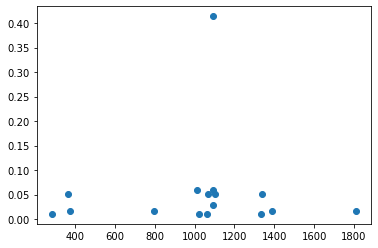

In [18]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-2:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [19]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod




def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

In [20]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [26]:
import optuna
n_iter = 3500
theta = np.zeros(9*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        for j in range(9):
            theta[9*i+j] = trial.suggest_float("9*"+str(i)+"+"+str(j), -4*np.pi, 4*np.pi)

        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[9*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

        psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
        psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var
        
        psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
        psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var
        
        psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var

    cost = np.conj(psi_var)@full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-04-30 20:21:17,611] A new study created in memory with name: no-name-233fa8c8-b237-4ecf-b8cb-9bc36752ed85
[I 2022-04-30 20:21:19,756] Trial 0 finished with value: 0.351853265597368 and parameters: {'9*0+0': -7.299136738866094, '9*0+1': -11.396107026866007, '9*0+2': -3.775584253595163, '9*0+3': 2.7933441154672014, '9*0+4': 9.567831595507656, '9*0+5': -2.4372853236218432, '9*0+6': 0.6026951401892227, '9*0+7': 2.754311799469777, '9*0+8': 0.2820335162595562, '9*1+0': 9.46290199046318, '9*1+1': -6.183477449284383, '9*1+2': 10.668560808616917, '9*1+3': 12.34485509070364, '9*1+4': 9.043026960965793, '9*1+5': 5.024085053160551, '9*1+6': -3.3469487375890203, '9*1+7': -0.9431072300509804, '9*1+8': 11.08130831832566, '9*2+0': -3.947144835220696, '9*2+1': -6.276622921028878, '9*2+2': 3.20565328485797, '9*2+3': 3.1123776488608605, '9*2+4': 10.61380236124204, '9*2+5': -4.788495214668232, '9*2+6': 9.37355028447692, '9*2+7': 12.082798919480126, '9*2+8': 6.7307012355760385}. Best is trial 0 wit

[I 2022-04-30 20:21:39,255] Trial 9 finished with value: 4.712635414873878 and parameters: {'9*0+0': -8.63599892062357, '9*0+1': -5.019980855425073, '9*0+2': -1.7547118793370318, '9*0+3': -3.6692345747589155, '9*0+4': 3.1685609213332224, '9*0+5': -5.887634921168661, '9*0+6': -1.5436211648161904, '9*0+7': 0.7948113365515862, '9*0+8': -0.1929736541581189, '9*1+0': -4.223872558084483, '9*1+1': -4.459481851344599, '9*1+2': -2.4434248965295042, '9*1+3': 0.07196991509856782, '9*1+4': 3.600037720106343, '9*1+5': -4.329350508260633, '9*1+6': -3.694017352407911, '9*1+7': -5.728845609972402, '9*1+8': 1.6632551907325936, '9*2+0': -4.773917684730864, '9*2+1': -2.66898698542156, '9*2+2': -3.329464900667919, '9*2+3': -2.4444372911817944, '9*2+4': 1.1579032020994882, '9*2+5': -10.568080147079407, '9*2+6': 2.277146978282667, '9*2+7': 2.7351852770898737, '9*2+8': 0.6214685650282986}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:21:41,432] Trial 10 finished with value: 0.367526773519

[I 2022-04-30 20:21:58,913] Trial 18 finished with value: 0.43378294207082024 and parameters: {'9*0+0': -3.969151806824786, '9*0+1': 1.9012653525187309, '9*0+2': -0.07577324571672983, '9*0+3': -2.8735907063215205, '9*0+4': 0.5523446478583542, '9*0+5': 2.893123891056947, '9*0+6': -4.359643886033931, '9*0+7': -11.231483374351345, '9*0+8': 0.37125241081222965, '9*1+0': -1.7199773955755573, '9*1+1': 0.293684135605898, '9*1+2': 6.5200974313943645, '9*1+3': 5.64485545963159, '9*1+4': 6.7847677408319065, '9*1+5': -3.5733356119476665, '9*1+6': -0.45159477772032586, '9*1+7': 1.796999903824792, '9*1+8': 4.062116063179452, '9*2+0': -2.815111915515801, '9*2+1': 3.625985560459952, '9*2+2': 0.6966069959000459, '9*2+3': -5.028212098881858, '9*2+4': -3.17405935796656, '9*2+5': -3.5111192338203416, '9*2+6': 0.9547174815175801, '9*2+7': -10.144152525753398, '9*2+8': 4.3964997326958235}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:22:01,094] Trial 19 finished with value: 0.3607311305

[I 2022-04-30 20:22:18,586] Trial 27 finished with value: 1.0358594078946473 and parameters: {'9*0+0': 0.23825359359007073, '9*0+1': 0.7701606148381042, '9*0+2': 0.1500967775399058, '9*0+3': -3.022141358838801, '9*0+4': -9.912873283234243, '9*0+5': -3.305842999817484, '9*0+6': -4.883745231837603, '9*0+7': -4.99464635147431, '9*0+8': 4.106336410648224, '9*1+0': -5.4819305858901775, '9*1+1': -4.749759446616786, '9*1+2': 7.618069068015758, '9*1+3': 4.638499158212187, '9*1+4': 1.8623398119821974, '9*1+5': -8.605201350907487, '9*1+6': 1.732395042630016, '9*1+7': -6.492796919636362, '9*1+8': 4.798778307103934, '9*2+0': 2.568012015088158, '9*2+1': 0.47298631161652027, '9*2+2': 0.2712999233295219, '9*2+3': -4.27394645239054, '9*2+4': 0.8930976968280095, '9*2+5': -3.581052135596668, '9*2+6': -0.3588305761667101, '9*2+7': -1.6906364909752911, '9*2+8': 8.360977867712675}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:22:20,766] Trial 28 finished with value: 0.3395359116125414 a

[I 2022-04-30 20:22:38,028] Trial 36 finished with value: 6.724554811574351 and parameters: {'9*0+0': -0.10685873228453246, '9*0+1': -1.0298354422709206, '9*0+2': 0.07069409711593044, '9*0+3': 3.385552237305554, '9*0+4': -5.95864833293057, '9*0+5': 10.821942472395738, '9*0+6': -2.0583597351537457, '9*0+7': -9.562478923030813, '9*0+8': 4.960051892599831, '9*1+0': -0.541655090499696, '9*1+1': 4.593877252489072, '9*1+2': 6.690529202856856, '9*1+3': 3.9261461993090574, '9*1+4': 3.1751949395958317, '9*1+5': 2.266336818758756, '9*1+6': -1.0203580352575028, '9*1+7': -3.754449730000907, '9*1+8': 3.5363660744637584, '9*2+0': 1.600671588823106, '9*2+1': -2.1638967308602695, '9*2+2': -5.250100508450535, '9*2+3': -11.313364041705237, '9*2+4': 6.193801061329529, '9*2+5': -1.5845289595855203, '9*2+6': -2.5990259463593923, '9*2+7': -0.01026475396720783, '9*2+8': -3.0914075044131812}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:22:40,197] Trial 37 finished with value: 2.4915260270

[I 2022-04-30 20:22:57,667] Trial 45 finished with value: 0.9769120403615457 and parameters: {'9*0+0': 0.9951700047440957, '9*0+1': 2.008363733094226, '9*0+2': -3.9902332291446276, '9*0+3': -6.761487379158976, '9*0+4': -2.5413930450835163, '9*0+5': -4.052479635853684, '9*0+6': 0.7025821831978578, '9*0+7': -3.2139951311320383, '9*0+8': -9.789421851321741, '9*1+0': 4.075610286891104, '9*1+1': 3.6237500666502895, '9*1+2': 3.623485009217457, '9*1+3': 6.142806348351224, '9*1+4': -1.6563594207495331, '9*1+5': 0.014272886154257147, '9*1+6': -0.32788924713855905, '9*1+7': 2.8329190447521397, '9*1+8': 6.2446366500814, '9*2+0': 6.04523291312421, '9*2+1': -4.212797568812451, '9*2+2': -2.7114846930777583, '9*2+3': -3.8157132058813588, '9*2+4': 5.131735190840047, '9*2+5': -5.753513852552482, '9*2+6': 1.8936785239463707, '9*2+7': -7.8967241666931365, '9*2+8': 0.13185134749752614}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:22:59,857] Trial 46 finished with value: 0.329924513209

[I 2022-04-30 20:23:17,243] Trial 54 finished with value: 2.9067712147663687 and parameters: {'9*0+0': -1.0417637758462135, '9*0+1': 4.493229106994109, '9*0+2': -2.965965851033486, '9*0+3': -3.010238282386094, '9*0+4': 0.26269755963687125, '9*0+5': 5.061431836587365, '9*0+6': -3.0928130875730324, '9*0+7': -8.901907165009057, '9*0+8': -1.763977271839921, '9*1+0': -6.00290796197975, '9*1+1': 9.022233361793797, '9*1+2': 7.01173204515874, '9*1+3': 8.168246971441231, '9*1+4': 7.270769094074838, '9*1+5': 3.2666882610657275, '9*1+6': -11.175406101684443, '9*1+7': 4.9412272596821, '9*1+8': 8.565864121104894, '9*2+0': 5.619103730265899, '9*2+1': 0.97123209146825, '9*2+2': -3.4229846184735035, '9*2+3': 0.8980792736412733, '9*2+4': 5.800469129528742, '9*2+5': -6.268747840421777, '9*2+6': -6.962717146832578, '9*2+7': -6.711532466977226, '9*2+8': 3.070327343299453}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:23:19,442] Trial 55 finished with value: 3.0177326173004495 and param

[I 2022-04-30 20:23:36,890] Trial 63 finished with value: 4.380668044863845 and parameters: {'9*0+0': -4.993730960900437, '9*0+1': 3.126580975525493, '9*0+2': -3.868992623835493, '9*0+3': -4.2240473974446076, '9*0+4': -2.135928776630912, '9*0+5': 1.2474273754070095, '9*0+6': -8.811330561083892, '9*0+7': -11.965580010614719, '9*0+8': 3.3752349042641296, '9*1+0': 2.15025166627676, '9*1+1': -2.2529709565784084, '9*1+2': 6.225286143431158, '9*1+3': 2.161709005188574, '9*1+4': 2.1052908314647745, '9*1+5': -3.71413559934281, '9*1+6': 2.357311998501322, '9*1+7': -4.248637572101584, '9*1+8': 3.2731178956662106, '9*2+0': 3.775479196053827, '9*2+1': 1.7884795389564605, '9*2+2': -5.992297611682941, '9*2+3': -5.754728485722026, '9*2+4': 3.5434270694634353, '9*2+5': -11.977228158483697, '9*2+6': -1.69087520799031, '9*2+7': -9.092696487474724, '9*2+8': 0.033967463621472765}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:23:39,059] Trial 64 finished with value: 0.34149690069491095 

[I 2022-04-30 20:23:56,520] Trial 72 finished with value: 2.683731202528678 and parameters: {'9*0+0': 3.1616212282562257, '9*0+1': 10.259243259643304, '9*0+2': -3.13558947756482, '9*0+3': 0.2238794078295536, '9*0+4': 1.3868285507708804, '9*0+5': -7.897482957482667, '9*0+6': -6.8373969700605315, '9*0+7': -8.025820289673016, '9*0+8': -1.3545721097051202, '9*1+0': 6.350079314341114, '9*1+1': 0.5443984580667955, '9*1+2': 2.3642062225898552, '9*1+3': 6.083282350371051, '9*1+4': -0.9592347171873064, '9*1+5': -3.30733942839675, '9*1+6': -7.8393013884756435, '9*1+7': 5.518354791705332, '9*1+8': 5.889490271284439, '9*2+0': 7.382252337191936, '9*2+1': -4.655405443919657, '9*2+2': -6.643763335211167, '9*2+3': -0.6822489538710648, '9*2+4': 2.0512618822130273, '9*2+5': -3.6269128179864363, '9*2+6': -2.7049139391045447, '9*2+7': -5.320382296811365, '9*2+8': 6.538005173658066}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:23:58,714] Trial 73 finished with value: 0.9243028698204141

[I 2022-04-30 20:24:16,112] Trial 81 finished with value: 1.504087116515833 and parameters: {'9*0+0': -3.400194123209206, '9*0+1': 2.852552080554929, '9*0+2': -0.02781142542000148, '9*0+3': 0.9430570673346614, '9*0+4': 3.6432172940508014, '9*0+5': -7.110911955846097, '9*0+6': -0.8488738873118574, '9*0+7': -11.074475911179029, '9*0+8': 7.8041236031091366, '9*1+0': 3.5432712819713625, '9*1+1': 0.4963370776839411, '9*1+2': 0.5602771739124612, '9*1+3': 6.505077614815935, '9*1+4': 12.397005336308482, '9*1+5': -0.7939878234260433, '9*1+6': -0.8530337507305499, '9*1+7': 0.02890099031983162, '9*1+8': 0.5422297622219583, '9*2+0': 9.741826509531785, '9*2+1': -4.994907907521233, '9*2+2': -3.5059044846344802, '9*2+3': -0.14486207714738786, '9*2+4': 5.785616477626462, '9*2+5': -7.759554756414045, '9*2+6': -6.13861913144188, '9*2+7': -6.708420460457985, '9*2+8': -7.306360697092353}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:24:18,296] Trial 82 finished with value: 0.3320405595

[I 2022-04-30 20:24:35,739] Trial 90 finished with value: 1.712063860465887 and parameters: {'9*0+0': -4.512241476615468, '9*0+1': 6.807637002783675, '9*0+2': -4.261733306031329, '9*0+3': 3.2134722709794934, '9*0+4': 1.91708512188623, '9*0+5': -5.403560562261106, '9*0+6': 1.3415874629221234, '9*0+7': -9.357111171139891, '9*0+8': 3.5706700642962006, '9*1+0': -1.4522680366153433, '9*1+1': 4.612311256599838, '9*1+2': 2.0362527949663116, '9*1+3': 9.490047563573013, '9*1+4': 6.73352690757661, '9*1+5': -1.362319414079737, '9*1+6': -1.4143419885521453, '9*1+7': -9.124359399112402, '9*1+8': -2.337814401186553, '9*2+0': 1.7494740059134346, '9*2+1': 2.9493383288565624, '9*2+2': -9.57649585891532, '9*2+3': -1.8467194580610093, '9*2+4': 6.4141373627168985, '9*2+5': -3.612920961654293, '9*2+6': -4.886791686452608, '9*2+7': -5.76514164571283, '9*2+8': 3.912918264236343}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:24:37,937] Trial 91 finished with value: 0.1931950632642477 and p

[I 2022-04-30 20:24:55,524] Trial 99 finished with value: 48.93602973775603 and parameters: {'9*0+0': 2.1874878323273688, '9*0+1': -2.4056470918864976, '9*0+2': -0.10016991508062989, '9*0+3': -3.3168049267487536, '9*0+4': -2.5328378775604867, '9*0+5': -4.130189853894071, '9*0+6': -4.284006693442374, '9*0+7': -6.007026475960044, '9*0+8': 4.693184638607693, '9*1+0': 0.4785588796612331, '9*1+1': 1.4035673668932667, '9*1+2': 5.711040200540998, '9*1+3': -0.9836404366218563, '9*1+4': 4.780133365578834, '9*1+5': -0.42686327131767987, '9*1+6': -3.3178722398635907, '9*1+7': -9.457631186688914, '9*1+8': 0.5949286232770419, '9*2+0': 3.9927257619448655, '9*2+1': -5.225706328759166, '9*2+2': -1.7946895888521155, '9*2+3': -0.47888626963957404, '9*2+4': 4.547975444319482, '9*2+5': -4.600315552687703, '9*2+6': 0.040433581547298925, '9*2+7': -10.631127123492234, '9*2+8': -2.3223278422792135}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:24:57,710] Trial 100 finished with value: 0.94

[I 2022-04-30 20:25:15,166] Trial 108 finished with value: 5.144960462656225 and parameters: {'9*0+0': -2.7424738987430097, '9*0+1': 2.192951639223067, '9*0+2': 0.13725150965654542, '9*0+3': 0.6486706713777792, '9*0+4': 3.4188368163721328, '9*0+5': -0.13777870164158124, '9*0+6': -2.825890002773521, '9*0+7': 0.2095927971856515, '9*0+8': 3.516096630098237, '9*1+0': -1.5556303609345212, '9*1+1': 2.168851495236303, '9*1+2': 10.299776573399239, '9*1+3': 9.843571829092651, '9*1+4': -1.5701929810930415, '9*1+5': -2.236475110628983, '9*1+6': -2.2913001623852867, '9*1+7': 3.1130049026250717, '9*1+8': -4.806938814965658, '9*2+0': 2.801241163121638, '9*2+1': -5.242987783721057, '9*2+2': -7.468975762538826, '9*2+3': -0.6102478291831159, '9*2+4': 2.9966583930656436, '9*2+5': -10.827685756227533, '9*2+6': -3.5885532793254566, '9*2+7': -4.2786767143227955, '9*2+8': 7.163901616792824}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:25:17,362] Trial 109 finished with value: 0.70433590

[I 2022-04-30 20:25:34,998] Trial 117 finished with value: 3.4067823173151397 and parameters: {'9*0+0': -4.4978692904743225, '9*0+1': 10.458350940904495, '9*0+2': -2.0459727195076782, '9*0+3': 1.994378054420157, '9*0+4': 7.463687633833725, '9*0+5': -4.866491635944816, '9*0+6': -2.408256320672205, '9*0+7': -5.71621358302176, '9*0+8': 2.2253027506227667, '9*1+0': 1.9527529132443429, '9*1+1': 3.3898841254248806, '9*1+2': -2.0979361315533787, '9*1+3': 8.625401709624658, '9*1+4': -2.2699183319121343, '9*1+5': -1.017178060244727, '9*1+6': 5.36153943729954, '9*1+7': -3.8872620684692247, '9*1+8': 10.042752495857608, '9*2+0': 6.068288008411341, '9*2+1': -1.628484417789478, '9*2+2': -7.052172373126254, '9*2+3': 1.6985738293975134, '9*2+4': 7.435902912649185, '9*2+5': -11.589319984154072, '9*2+6': -1.2933375102074696, '9*2+7': -8.944062273541922, '9*2+8': 5.827878075251711}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:25:37,177] Trial 118 finished with value: 3.65262011073681

[I 2022-04-30 20:25:54,650] Trial 126 finished with value: 2.2306913705676865 and parameters: {'9*0+0': 2.5958144958047416, '9*0+1': 1.619576723395435, '9*0+2': -5.153267745755341, '9*0+3': -1.7275796067381706, '9*0+4': 8.915284578454585, '9*0+5': -10.018443594811682, '9*0+6': -7.526368537141152, '9*0+7': -6.5316406532918725, '9*0+8': 7.703764529183019, '9*1+0': -1.2940286270702956, '9*1+1': 6.166303234343361, '9*1+2': 6.443982493189546, '9*1+3': 10.416217730258879, '9*1+4': 0.95831472392147, '9*1+5': -4.875515986575696, '9*1+6': -1.0257463566677902, '9*1+7': 1.3683311890649215, '9*1+8': 2.4785118071513703, '9*2+0': 8.54097123146917, '9*2+1': -5.890776953152967, '9*2+2': -1.3920050717814627, '9*2+3': -1.38260212206651, '9*2+4': 7.720130274214768, '9*2+5': -2.9062867567991715, '9*2+6': 5.688689642190688, '9*2+7': 0.9967088126877437, '9*2+8': 1.742593839428348}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:25:56,815] Trial 127 finished with value: 6.631999240357112 an

[I 2022-04-30 20:26:14,189] Trial 135 finished with value: 1.8328017652836452 and parameters: {'9*0+0': 1.6062103717721128, '9*0+1': -0.2669845623149918, '9*0+2': -9.082447043191783, '9*0+3': 5.270959256803332, '9*0+4': 6.189347405404061, '9*0+5': -2.5342515905604204, '9*0+6': -9.667005326613044, '9*0+7': -3.940542156194583, '9*0+8': 5.128022437595658, '9*1+0': 1.7012214066132234, '9*1+1': 4.532633971312724, '9*1+2': 5.406787456257448, '9*1+3': 1.5578523139054843, '9*1+4': 7.209389381441083, '9*1+5': -2.4516711888182163, '9*1+6': 0.7811750590112161, '9*1+7': -1.5213048326969885, '9*1+8': -1.3404537520828201, '9*2+0': -2.3148772896897, '9*2+1': -4.636249479587252, '9*2+2': -5.6566212554528805, '9*2+3': -0.1092961158485024, '9*2+4': 12.291146065767062, '9*2+5': -6.3303824698096705, '9*2+6': -3.9725450273795544, '9*2+7': -11.248778051761928, '9*2+8': 5.117655772155797}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:26:16,385] Trial 136 finished with value: 1.64441906522

[I 2022-04-30 20:26:34,027] Trial 144 finished with value: 2.959082476676443 and parameters: {'9*0+0': -2.45716221577117, '9*0+1': 5.01520208688949, '9*0+2': -6.598568183941928, '9*0+3': -0.8730928533080554, '9*0+4': 9.061966919931438, '9*0+5': -11.961265275923362, '9*0+6': -6.544193182097917, '9*0+7': -3.841925643824394, '9*0+8': 11.160239357205612, '9*1+0': 2.25294494107418, '9*1+1': 4.798720715443149, '9*1+2': 3.7791905163674473, '9*1+3': 7.786471951384775, '9*1+4': 0.5075148704424448, '9*1+5': -9.726357186373336, '9*1+6': 5.280492275939417, '9*1+7': -7.44330269931929, '9*1+8': -1.844781306848375, '9*2+0': 6.104081740657223, '9*2+1': -4.947155464612996, '9*2+2': -3.3501739991476125, '9*2+3': 3.864457005639978, '9*2+4': 11.178139809346288, '9*2+5': -4.535625536596268, '9*2+6': -5.130731918020125, '9*2+7': -1.4222688508435892, '9*2+8': 2.740226092299496}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:26:36,233] Trial 145 finished with value: 0.7801711500831282 and p

[I 2022-04-30 20:26:53,691] Trial 153 finished with value: 4.962115880449233 and parameters: {'9*0+0': 3.4688210802495636, '9*0+1': 1.9757173674966717, '9*0+2': -7.302625987724351, '9*0+3': 1.1953495116954211, '9*0+4': 6.080959186686002, '9*0+5': -9.752352200158322, '9*0+6': -2.6219317976564764, '9*0+7': -5.5164447507117975, '9*0+8': 6.932489001851913, '9*1+0': 1.5510275198527914, '9*1+1': 8.41029645469025, '9*1+2': 8.442422344689083, '9*1+3': 7.23008631261861, '9*1+4': 0.26714655081427896, '9*1+5': -12.147925719363487, '9*1+6': 4.774257971179663, '9*1+7': -0.16270831260368643, '9*1+8': 2.320557606481226, '9*2+0': 9.703447422413515, '9*2+1': -1.8186735019546363, '9*2+2': -5.487569444797293, '9*2+3': -3.0475662276763344, '9*2+4': 10.146918828415417, '9*2+5': -1.9873805627193804, '9*2+6': -4.5831952894842765, '9*2+7': -12.233007218494908, '9*2+8': -2.4013425081816404}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:26:55,893] Trial 154 finished with value: 86.6508896622

[I 2022-04-30 20:27:13,540] Trial 162 finished with value: 1.157454820238933 and parameters: {'9*0+0': 1.2986201297986206, '9*0+1': 4.959129183492499, '9*0+2': -8.263288877937454, '9*0+3': 7.471525815568416, '9*0+4': 12.495275965421037, '9*0+5': -8.570928396060634, '9*0+6': -4.306452879687728, '9*0+7': -6.470513973892638, '9*0+8': 7.972194481145827, '9*1+0': 1.6122438207429686, '9*1+1': 1.4640517594211264, '9*1+2': 9.101727036175301, '9*1+3': 2.2360294239923446, '9*1+4': 2.314275059532017, '9*1+5': -12.543263527639903, '9*1+6': 9.207200740755614, '9*1+7': 0.35285291688974063, '9*1+8': 0.1108287505124903, '9*2+0': 1.8227219432950457, '9*2+1': -5.889505038935313, '9*2+2': -11.696366324530167, '9*2+3': 1.7416103060687147, '9*2+4': 6.017889401515433, '9*2+5': -4.221838434467795, '9*2+6': -2.140450718240038, '9*2+7': -10.681777256003489, '9*2+8': 1.8838845506214432}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:27:15,732] Trial 163 finished with value: 0.9441432267027907

[I 2022-04-30 20:27:33,269] Trial 171 finished with value: 2.9403206053662134 and parameters: {'9*0+0': -5.788163478890966, '9*0+1': 3.511750880590354, '9*0+2': -9.592933338975728, '9*0+3': -2.58755805201647, '9*0+4': 7.159044721487229, '9*0+5': -3.816551456474901, '9*0+6': -5.923553486892402, '9*0+7': -7.026369085982665, '9*0+8': 6.13857431607776, '9*1+0': -0.3384361456286329, '9*1+1': 6.001019120336501, '9*1+2': 9.939459687395297, '9*1+3': 4.305283357302761, '9*1+4': 4.9071716548922995, '9*1+5': -10.607893721858224, '9*1+6': 11.880181891126348, '9*1+7': -0.14446696298221284, '9*1+8': 4.43149434568854, '9*2+0': 9.524888106802113, '9*2+1': 2.6825939102759664, '9*2+2': -10.36397499300361, '9*2+3': -2.4525590513073654, '9*2+4': 3.1431209908498223, '9*2+5': -8.126611205292352, '9*2+6': -0.043352010388545636, '9*2+7': -3.3930434995359846, '9*2+8': 2.584974101947433}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:27:35,467] Trial 172 finished with value: 2.476145675452374

[I 2022-04-30 20:27:53,054] Trial 180 finished with value: 1.5476392879235459 and parameters: {'9*0+0': 2.159603861874768, '9*0+1': -1.5578522504488195, '9*0+2': -7.73093055908492, '9*0+3': -3.0267946107151524, '9*0+4': 8.448663468071642, '9*0+5': -3.393423049251287, '9*0+6': -3.3710708894601686, '9*0+7': -8.046925202075572, '9*0+8': 4.536100401346646, '9*1+0': 7.033918019015606, '9*1+1': 4.853599905645741, '9*1+2': -0.4245860449417398, '9*1+3': 1.037928772065169, '9*1+4': 1.7628053378347954, '9*1+5': -5.3266430668917435, '9*1+6': 0.2735528206241611, '9*1+7': -4.009135817761229, '9*1+8': 7.985489561129521, '9*2+0': 5.780149872310382, '9*2+1': -4.175908968214353, '9*2+2': -5.791174362840695, '9*2+3': -0.500368717243096, '9*2+4': 10.936465455702226, '9*2+5': -8.918189245096167, '9*2+6': -2.68642786954231, '9*2+7': -3.1681320894122615, '9*2+8': 4.10625992018566}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:27:55,263] Trial 181 finished with value: 1.5280164297539947 a

[I 2022-04-30 20:28:12,699] Trial 189 finished with value: 1.717528128931425 and parameters: {'9*0+0': -2.4284968234014994, '9*0+1': 6.722289409338665, '9*0+2': -6.231228498373705, '9*0+3': 0.8636433579023843, '9*0+4': 8.767940035962752, '9*0+5': -2.11505124229193, '9*0+6': -1.4270631859109404, '9*0+7': -9.4715947636697, '9*0+8': 5.16063057606225, '9*1+0': -0.17373835614563804, '9*1+1': 7.730582881212079, '9*1+2': 7.647531870699054, '9*1+3': -1.783412069865669, '9*1+4': 5.784790108511853, '9*1+5': -8.920203805295596, '9*1+6': 6.531670283268719, '9*1+7': 3.1224945293285105, '9*1+8': 1.6251485499557643, '9*2+0': 1.377111751941436, '9*2+1': -4.359302839613435, '9*2+2': -9.992430543043254, '9*2+3': 2.6752630947582583, '9*2+4': 2.605220324950825, '9*2+5': -10.415383952439983, '9*2+6': -4.556298913803449, '9*2+7': -9.854638807831222, '9*2+8': 6.200465644346171}. Best is trial 7 with value: 0.0395862629820741.
[I 2022-04-30 20:28:14,892] Trial 190 finished with value: 5.152040689701364 and pa

[I 2022-04-30 20:28:32,509] Trial 198 finished with value: 2.1642924127259033 and parameters: {'9*0+0': 1.5889608706199212, '9*0+1': 7.062609334212061, '9*0+2': -2.8404641446208467, '9*0+3': 0.8721300690439269, '9*0+4': 7.362377219606946, '9*0+5': -1.1224380701876915, '9*0+6': 2.302866078303417, '9*0+7': -8.282097692546284, '9*0+8': 10.212862030185613, '9*1+0': -1.4068341489067098, '9*1+1': 6.360955111557892, '9*1+2': 7.173707755477434, '9*1+3': 2.9478370986893774, '9*1+4': 4.92406796156405, '9*1+5': -5.144672412486188, '9*1+6': 9.135861553312788, '9*1+7': -9.765552524789058, '9*1+8': 3.2449141898246014, '9*2+0': 4.343769834601835, '9*2+1': -9.808280567498526, '9*2+2': -10.258635011140584, '9*2+3': 1.978520574071787, '9*2+4': 6.486891464342651, '9*2+5': -11.172732583115067, '9*2+6': -6.36710704751269, '9*2+7': -6.293303921092257, '9*2+8': 4.33387069499333}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:28:34,718] Trial 199 finished with value: 0.9384435754875674 

[I 2022-04-30 20:28:52,290] Trial 207 finished with value: 0.714528193288386 and parameters: {'9*0+0': 2.603889973916382, '9*0+1': 6.232629942274654, '9*0+2': -8.412334544846507, '9*0+3': 2.185727757672823, '9*0+4': 2.853056120092914, '9*0+5': 1.83785918231601, '9*0+6': 2.433454384644853, '9*0+7': -10.974620403958266, '9*0+8': 7.011331598453244, '9*1+0': 1.9976393580616052, '9*1+1': 6.656564708659163, '9*1+2': 8.28515608554109, '9*1+3': 7.8270525987318855, '9*1+4': -0.5482142968438604, '9*1+5': -5.118316945240558, '9*1+6': 8.592694250315446, '9*1+7': -6.54453581521105, '9*1+8': 4.635919392634393, '9*2+0': 1.0902597376779513, '9*2+1': -7.481631153771026, '9*2+2': -7.95886540924137, '9*2+3': 2.8006194331733427, '9*2+4': 0.6582072913466739, '9*2+5': -6.433520084898662, '9*2+6': -7.624558092730053, '9*2+7': -6.592863752926991, '9*2+8': 8.76092921268917}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:28:54,494] Trial 208 finished with value: 0.8132753864471155 and par

[I 2022-04-30 20:29:12,118] Trial 216 finished with value: 0.608883078246623 and parameters: {'9*0+0': 1.097239264451838, '9*0+1': 11.808074536617365, '9*0+2': -8.54006838989815, '9*0+3': -2.339223142941444, '9*0+4': 0.942031100648463, '9*0+5': -1.2705327944121843, '9*0+6': 5.331281735404912, '9*0+7': -8.711906604548005, '9*0+8': 7.38406249962108, '9*1+0': 0.3578683011229131, '9*1+1': 4.8758339513825035, '9*1+2': 0.5116303892977552, '9*1+3': 5.175097513852338, '9*1+4': 1.743061747986806, '9*1+5': -7.999266576950978, '9*1+6': 5.070209521473738, '9*1+7': -2.4234970548282213, '9*1+8': 8.868252180677732, '9*2+0': -0.24712357499027449, '9*2+1': -5.14555633041145, '9*2+2': -10.46884518062614, '9*2+3': 5.991126090171232, '9*2+4': -0.5029877430061154, '9*2+5': -4.682434925290247, '9*2+6': -5.614067883443094, '9*2+7': -3.29185722029835, '9*2+8': 8.217037703316175}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:29:14,331] Trial 217 finished with value: 0.9013165026974324 a

[I 2022-04-30 20:29:31,916] Trial 225 finished with value: 1.448593927282725 and parameters: {'9*0+0': 2.9100358532659047, '9*0+1': 8.559568397850303, '9*0+2': -7.574373362486147, '9*0+3': 0.4618905424002915, '9*0+4': 4.371277616313885, '9*0+5': 7.871567912786832, '9*0+6': 3.7772650853830663, '9*0+7': -8.817679399044096, '9*0+8': 4.76770744971676, '9*1+0': -6.611202224591802, '9*1+1': 10.199232094940346, '9*1+2': 7.714476615609783, '9*1+3': -1.144704321911696, '9*1+4': 3.3601133615076666, '9*1+5': -7.09601438427409, '9*1+6': 3.8388483696530575, '9*1+7': -2.6944850443970223, '9*1+8': 0.1590727461574568, '9*2+0': 0.8404006276422121, '9*2+1': 2.1746997099613767, '9*2+2': -6.262378502603827, '9*2+3': 7.111882652454635, '9*2+4': 6.148035169853422, '9*2+5': -7.1724036284645205, '9*2+6': -7.429711196160876, '9*2+7': -4.1174744178753055, '9*2+8': 7.291672459709247}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:29:34,129] Trial 226 finished with value: 0.1697212675252115

[I 2022-04-30 20:29:51,748] Trial 234 finished with value: 1.7120905396096329 and parameters: {'9*0+0': 4.398028427480855, '9*0+1': 4.39189776508772, '9*0+2': -10.164064207681921, '9*0+3': 5.167457973249577, '9*0+4': 5.255072283054068, '9*0+5': 6.287571531644671, '9*0+6': -0.8560975518580309, '9*0+7': -11.226471319000922, '9*0+8': 0.9851396461841802, '9*1+0': 1.1986578799500403, '9*1+1': 5.1426078144565, '9*1+2': 5.8442236597515045, '9*1+3': -2.691135071859256, '9*1+4': 0.876601283924693, '9*1+5': -4.523008982713593, '9*1+6': 4.678107683737533, '9*1+7': -1.4570662510514465, '9*1+8': 5.942878818488921, '9*2+0': -1.9196717695471635, '9*2+1': -4.661443967273696, '9*2+2': -8.10495955260371, '9*2+3': 9.329507429198312, '9*2+4': 0.8674758084905685, '9*2+5': -8.521344711498324, '9*2+6': -5.981019268738507, '9*2+7': -3.2625303144854856, '9*2+8': 8.489030366594772}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:29:53,917] Trial 235 finished with value: 3.1925262893734687 

[I 2022-04-30 20:30:11,458] Trial 243 finished with value: 0.6730809297290412 and parameters: {'9*0+0': 4.349978823076207, '9*0+1': 6.326466477227895, '9*0+2': -6.4448311668038185, '9*0+3': -3.1903536743077354, '9*0+4': -0.20489447335175015, '9*0+5': 0.9495658894761076, '9*0+6': 4.373501023360505, '9*0+7': -11.788401216619985, '9*0+8': 0.5996399542368516, '9*1+0': -3.313616446951887, '9*1+1': 5.35145674030612, '9*1+2': 7.664664041437756, '9*1+3': 8.002276199177443, '9*1+4': 0.878709778370867, '9*1+5': -4.488398513754446, '9*1+6': 5.642088517865716, '9*1+7': -3.096241779085776, '9*1+8': 5.9562463579586, '9*2+0': 2.4200143353956562, '9*2+1': -0.6883391787668257, '9*2+2': -11.021644646330621, '9*2+3': 6.539845228822087, '9*2+4': -4.6219355004779255, '9*2+5': -3.5458477134602564, '9*2+6': -11.669776553400608, '9*2+7': -3.865548630371328, '9*2+8': -0.705159924361725}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:30:13,655] Trial 244 finished with value: 0.16621801448

[I 2022-04-30 20:30:31,192] Trial 252 finished with value: 3.2414700237036724 and parameters: {'9*0+0': 1.9773829055721976, '9*0+1': 4.498009726293209, '9*0+2': -5.223824734175238, '9*0+3': -4.905094630024699, '9*0+4': 4.488164886750289, '9*0+5': 5.548009085029531, '9*0+6': 5.798402923958728, '9*0+7': -10.615639569209016, '9*0+8': 2.956174208453823, '9*1+0': 2.1834590614165927, '9*1+1': -0.5286428138757198, '9*1+2': 9.306361172293304, '9*1+3': 0.15466693254776054, '9*1+4': -4.1401121569803045, '9*1+5': -5.8642772419005516, '9*1+6': 8.57366009047974, '9*1+7': -4.094233801977996, '9*1+8': 1.8520835967456701, '9*2+0': 4.8380775360002595, '9*2+1': -1.7157960012963551, '9*2+2': -9.695811526446239, '9*2+3': 5.2878447793490695, '9*2+4': 3.4532259766125994, '9*2+5': -6.673210051182608, '9*2+6': -11.765926840198086, '9*2+7': -9.220564492277912, '9*2+8': 10.265997324118128}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:30:33,400] Trial 253 finished with value: 0.711462139

[I 2022-04-30 20:30:50,915] Trial 261 finished with value: 0.3787739164021495 and parameters: {'9*0+0': -0.5707012754254337, '9*0+1': 2.5459881866345544, '9*0+2': -0.49818579449463174, '9*0+3': -3.989706837359281, '9*0+4': 4.0706546284414795, '9*0+5': 6.966826147378188, '9*0+6': 1.1876399977839638, '9*0+7': -5.045128319904679, '9*0+8': -0.8666426047687175, '9*1+0': -1.5188973256204394, '9*1+1': 6.136809832092746, '9*1+2': 9.97750272879923, '9*1+3': 0.7495271852163428, '9*1+4': 1.4314792362712554, '9*1+5': -3.4752487200797324, '9*1+6': 11.841544055012907, '9*1+7': -0.5393816971684415, '9*1+8': 3.760771732611195, '9*2+0': 3.4420351995646876, '9*2+1': 0.11274620727398688, '9*2+2': -6.979616414315412, '9*2+3': 2.52169637743628, '9*2+4': 8.973228762292726, '9*2+5': -9.050477426970922, '9*2+6': -3.656395303527725, '9*2+7': -3.674333185613518, '9*2+8': 1.1087460223117795}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:30:53,118] Trial 262 finished with value: 3.30257938

[I 2022-04-30 20:31:10,752] Trial 270 finished with value: 0.7325413111756821 and parameters: {'9*0+0': -0.5923364626207054, '9*0+1': 8.449970260294224, '9*0+2': -0.4846631484986639, '9*0+3': -1.4938277550029886, '9*0+4': 0.8059296108550115, '9*0+5': 5.273608709910504, '9*0+6': 4.210919121201582, '9*0+7': -9.962109350370243, '9*0+8': 0.47223073560092765, '9*1+0': -1.0022585550632686, '9*1+1': 2.2536918442523026, '9*1+2': 4.835248869099365, '9*1+3': -4.513818252743905, '9*1+4': -1.4503895283097814, '9*1+5': -3.793396288155252, '9*1+6': 4.986714753092045, '9*1+7': 1.7997240821605032, '9*1+8': 2.223454897233314, '9*2+0': 10.477585782100457, '9*2+1': 2.7927178491815283, '9*2+2': -11.592787926884732, '9*2+3': 8.721088461391554, '9*2+4': 4.476079520031749, '9*2+5': -7.362779161349351, '9*2+6': -5.152302962135247, '9*2+7': -4.888822500508825, '9*2+8': 9.894271333311504}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:31:12,965] Trial 271 finished with value: 0.8896621633

[I 2022-04-30 20:31:30,513] Trial 279 finished with value: 1.3890356063006268 and parameters: {'9*0+0': 4.3863522755877735, '9*0+1': 0.5861253169304179, '9*0+2': 2.7263564359883192, '9*0+3': 0.5476042096236915, '9*0+4': 1.925478557901815, '9*0+5': 4.374436912481469, '9*0+6': 3.1148828174564653, '9*0+7': -7.286469229771791, '9*0+8': 0.9917542991948549, '9*1+0': -0.3577593799594209, '9*1+1': -0.4124482994473917, '9*1+2': 7.848813430193328, '9*1+3': 2.937117785030189, '9*1+4': -4.033688160447806, '9*1+5': -1.4394744972011724, '9*1+6': 5.867056801978824, '9*1+7': 6.106028223687496, '9*1+8': -3.2528007561455263, '9*2+0': 2.322146193893852, '9*2+1': -3.28005703368742, '9*2+2': -9.093455522358623, '9*2+3': 11.396535766995429, '9*2+4': 4.496372848300544, '9*2+5': -5.272065575018364, '9*2+6': -5.114547434271527, '9*2+7': -2.3943308367406893, '9*2+8': 6.794851113360549}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:31:32,719] Trial 280 finished with value: 6.6570244353687

[I 2022-04-30 20:31:50,332] Trial 288 finished with value: 3.8377034761318503 and parameters: {'9*0+0': 4.443095287455954, '9*0+1': 4.612412615808678, '9*0+2': -4.3712351314131945, '9*0+3': 0.7807158853965237, '9*0+4': 5.552531925082535, '9*0+5': 7.588634186509648, '9*0+6': -0.4578604897531702, '9*0+7': -7.5136376753377885, '9*0+8': 0.16557345222440667, '9*1+0': 1.6307461503733671, '9*1+1': 2.5420018373067568, '9*1+2': 8.626863848309803, '9*1+3': 1.3038548690966727, '9*1+4': -5.328977584485548, '9*1+5': -2.473873530473405, '9*1+6': 4.06764736369149, '9*1+7': 0.1328708977782458, '9*1+8': 7.779455095726387, '9*2+0': 3.8768477416698004, '9*2+1': 5.10636795867447, '9*2+2': -8.376424375242356, '9*2+3': 6.990029672610335, '9*2+4': 7.1665595892245575, '9*2+5': -3.4408040297548776, '9*2+6': -7.258101667758003, '9*2+7': 1.4059671824852278, '9*2+8': 7.440640714394245}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:31:52,541] Trial 289 finished with value: 17.57052054520973

[I 2022-04-30 20:32:10,179] Trial 297 finished with value: 1.3258230491404803 and parameters: {'9*0+0': 0.7465419668125337, '9*0+1': 6.411630250807166, '9*0+2': -6.726475038258135, '9*0+3': -4.128126027806842, '9*0+4': 3.180673957132815, '9*0+5': 7.984655084070056, '9*0+6': 0.5277775523209846, '9*0+7': -11.260241028600948, '9*0+8': -3.1504921226651907, '9*1+0': 1.3349986875426803, '9*1+1': -0.5257728657389515, '9*1+2': 11.222958034798818, '9*1+3': 4.736165291022701, '9*1+4': -3.4627372127065335, '9*1+5': -2.0135180103350945, '9*1+6': 6.003032452089821, '9*1+7': -3.309676077801167, '9*1+8': 10.403844028444514, '9*2+0': 7.677486004127768, '9*2+1': 1.5124393248522199, '9*2+2': -5.28106594735611, '9*2+3': 11.325635251532944, '9*2+4': 1.1287911099507315, '9*2+5': -0.4516011245014946, '9*2+6': -1.498675130864461, '9*2+7': -2.864223859808847, '9*2+8': -3.45985448876294}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:32:12,339] Trial 298 finished with value: 1.5729103585

[I 2022-04-30 20:32:29,880] Trial 306 finished with value: 0.15707559221887132 and parameters: {'9*0+0': -0.5290835753524616, '9*0+1': 6.21068547709325, '9*0+2': -6.028381430547653, '9*0+3': -5.581249964018819, '9*0+4': -0.7789543509439749, '9*0+5': 10.610493805380022, '9*0+6': 2.7593350371121455, '9*0+7': -6.067105295188281, '9*0+8': 2.8218607921103063, '9*1+0': 5.932090287266723, '9*1+1': 1.5759814426375893, '9*1+2': 8.543158986363903, '9*1+3': -3.852402694184739, '9*1+4': 0.12427616795960267, '9*1+5': -6.125182476608651, '9*1+6': 10.700474189874603, '9*1+7': 9.563157541691403, '9*1+8': -0.9903443539930179, '9*2+0': 7.283588395671718, '9*2+1': 3.506407752271792, '9*2+2': -9.177971885448226, '9*2+3': 11.424533293952065, '9*2+4': 2.6819334711987217, '9*2+5': -8.73344203828923, '9*2+6': -2.4508102411522756, '9*2+7': -1.0705124038962541, '9*2+8': 6.5166483132354625}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:32:32,082] Trial 307 finished with value: 0.862115182

[I 2022-04-30 20:32:49,568] Trial 315 finished with value: 24.622415480552633 and parameters: {'9*0+0': 3.2320082170408035, '9*0+1': -0.07868662088352174, '9*0+2': -0.3422821650682536, '9*0+3': 0.563168220782067, '9*0+4': 7.247888189737852, '9*0+5': 9.49747237985185, '9*0+6': 5.6952984241775315, '9*0+7': -6.010043391489883, '9*0+8': -1.1828020600695406, '9*1+0': 6.78040575601665, '9*1+1': 5.520051597530473, '9*1+2': 6.103342991736593, '9*1+3': -4.886218535257278, '9*1+4': -0.3871156453453217, '9*1+5': -2.868648268828098, '9*1+6': 8.866420466534796, '9*1+7': 5.57080559204065, '9*1+8': -0.9316989797694875, '9*2+0': 5.1073052918602455, '9*2+1': 4.767668417836096, '9*2+2': -5.585498259847395, '9*2+3': 11.331383956711168, '9*2+4': 1.5481263676608645, '9*2+5': -8.644873877497458, '9*2+6': -3.0695798933971292, '9*2+7': -2.5607241266439535, '9*2+8': 4.51805460488805}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:32:51,766] Trial 316 finished with value: 0.14268915489669

[I 2022-04-30 20:33:09,399] Trial 324 finished with value: 1.8365517875634634 and parameters: {'9*0+0': 0.9317519200741967, '9*0+1': 3.3306245710028817, '9*0+2': 3.839142911174849, '9*0+3': -2.53108187731365, '9*0+4': 3.5984854046014676, '9*0+5': 8.421889420431503, '9*0+6': 1.5236859821566573, '9*0+7': -5.409676769308757, '9*0+8': 4.51455523073391, '9*1+0': 1.723274211923163, '9*1+1': 3.971882775799168, '9*1+2': 8.310499753878322, '9*1+3': 2.797125423463363, '9*1+4': 1.1382614051588038, '9*1+5': -1.3132312397149604, '9*1+6': 7.331278352581068, '9*1+7': 3.1346512743453827, '9*1+8': 1.164012812246392, '9*2+0': 4.281321901529424, '9*2+1': 2.547455698037428, '9*2+2': -11.304275008329844, '9*2+3': 7.807589372579815, '9*2+4': 1.8073962900293554, '9*2+5': -11.624377520591887, '9*2+6': -6.914153494729557, '9*2+7': -1.7620314089448863, '9*2+8': 0.6435902739827286}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:33:11,607] Trial 325 finished with value: 3.9164089135138345 a

[I 2022-04-30 20:33:29,263] Trial 333 finished with value: 48.378017294327094 and parameters: {'9*0+0': -1.5026347560807924, '9*0+1': 7.316842011272877, '9*0+2': 1.7362248645613674, '9*0+3': -2.0659251730232855, '9*0+4': 4.561139688140558, '9*0+5': 8.92942431467511, '9*0+6': 1.864161586036331, '9*0+7': -6.719219670392868, '9*0+8': 1.340064321149961, '9*1+0': 0.9800841309270245, '9*1+1': 5.892498996177999, '9*1+2': 7.372082547818278, '9*1+3': 8.000851892560354, '9*1+4': -6.777098455144925, '9*1+5': -7.320497042647185, '9*1+6': 2.34741236513426, '9*1+7': 6.578460689233776, '9*1+8': 4.674039403644696, '9*2+0': 8.51983496622722, '9*2+1': 1.652452566857722, '9*2+2': -8.037458149757816, '9*2+3': 6.82229960923109, '9*2+4': 4.916339653051367, '9*2+5': -7.468382682006328, '9*2+6': -3.667755800848063, '9*2+7': -1.9244415084594686, '9*2+8': 3.1546391112718597}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:33:31,472] Trial 334 finished with value: 12.99194028877984 and para

[I 2022-04-30 20:33:49,095] Trial 342 finished with value: 0.24210800024291612 and parameters: {'9*0+0': -3.267821324751024, '9*0+1': 2.281910150713896, '9*0+2': -1.1713334990258137, '9*0+3': -2.897881542207317, '9*0+4': 4.076307647328081, '9*0+5': 9.983792041944486, '9*0+6': 5.9561441190151285, '9*0+7': -4.647919748471088, '9*0+8': 7.119226283217305, '9*1+0': 2.2075314014672585, '9*1+1': 6.790303153491966, '9*1+2': 5.06258487413551, '9*1+3': 3.6118835478381963, '9*1+4': 1.5917472248467512, '9*1+5': -9.4587169908475, '9*1+6': 3.1669479632380346, '9*1+7': 6.135999775570706, '9*1+8': 1.654671100731398, '9*2+0': 9.294752837652398, '9*2+1': 0.5250784215014042, '9*2+2': -10.526763592560428, '9*2+3': 7.789567606921756, '9*2+4': 1.5976092329899128, '9*2+5': -2.294249449816811, '9*2+6': -2.5361337755013795, '9*2+7': -3.086851041990567, '9*2+8': 9.007444456924363}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:33:51,297] Trial 343 finished with value: 0.1762899552026515 a

[I 2022-04-30 20:34:08,910] Trial 351 finished with value: 0.9041845498014027 and parameters: {'9*0+0': 0.6197282629916901, '9*0+1': 5.870533563580161, '9*0+2': -4.666433006873036, '9*0+3': -0.5198430046990055, '9*0+4': 0.8050925411151999, '9*0+5': 8.83452528950192, '9*0+6': 0.5451525063148388, '9*0+7': -6.339664177140665, '9*0+8': 5.0658720680091545, '9*1+0': 7.232874858067661, '9*1+1': 9.098984484048472, '9*1+2': 1.5847330657807421, '9*1+3': 1.1466792257151424, '9*1+4': -4.901899305921075, '9*1+5': -2.766176585816064, '9*1+6': 8.289110611205462, '9*1+7': 10.219631522457371, '9*1+8': 4.1314197643483705, '9*2+0': 5.082054493955607, '9*2+1': 4.130215114447848, '9*2+2': -4.722453590843412, '9*2+3': 9.149920324893309, '9*2+4': -0.32622948889652825, '9*2+5': -4.940003943503655, '9*2+6': -9.521214438489885, '9*2+7': 3.3798965840315565, '9*2+8': 8.22010257493861}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:34:11,074] Trial 352 finished with value: 1.731646100526104 

[I 2022-04-30 20:34:28,635] Trial 360 finished with value: 0.5162642421343523 and parameters: {'9*0+0': 0.8450979788843718, '9*0+1': 2.9441639666871935, '9*0+2': -3.5209207145214787, '9*0+3': -1.2586692725543343, '9*0+4': 5.665788610127986, '9*0+5': 9.684241268968005, '9*0+6': 5.7922276360001845, '9*0+7': -4.807143695467161, '9*0+8': 3.714040486749717, '9*1+0': 4.784602540058879, '9*1+1': 6.809599958718946, '9*1+2': 1.1590771505317168, '9*1+3': 6.01789270054238, '9*1+4': -1.1021567096994578, '9*1+5': -7.229215215448708, '9*1+6': 6.989925367596472, '9*1+7': 5.608738040550545, '9*1+8': 6.329964805428672, '9*2+0': 5.457776820560639, '9*2+1': -3.296023241999147, '9*2+2': -9.914259067772033, '9*2+3': 6.817394399879936, '9*2+4': 2.5094718776146774, '9*2+5': -5.056468564222764, '9*2+6': -6.23202569572309, '9*2+7': -0.37457550257844036, '9*2+8': 3.323590396792924}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:34:30,823] Trial 361 finished with value: 8.37984102730312 an

[I 2022-04-30 20:34:48,331] Trial 369 finished with value: 0.6790582614878009 and parameters: {'9*0+0': -4.049252517567679, '9*0+1': 0.8196167466077777, '9*0+2': -0.7469075471521665, '9*0+3': 0.09506083633045392, '9*0+4': 3.225613742075391, '9*0+5': 12.253109217534043, '9*0+6': 7.00152244222237, '9*0+7': -9.978362450364633, '9*0+8': 1.9512615623673475, '9*1+0': 2.910161132287845, '9*1+1': 7.4937991073920776, '9*1+2': 1.1211044170409643, '9*1+3': 5.400105342322708, '9*1+4': -1.6220407595781883, '9*1+5': -7.383888863907304, '9*1+6': 9.283669488487263, '9*1+7': 7.774591055117215, '9*1+8': 0.4803967078137279, '9*2+0': 9.328473752658287, '9*2+1': 2.8470721143506728, '9*2+2': -8.30553491829571, '9*2+3': 10.08188095195969, '9*2+4': 5.934349105142756, '9*2+5': -7.470077848238039, '9*2+6': -6.98381737337534, '9*2+7': 0.48881387037282836, '9*2+8': 5.065230504305173}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:34:50,520] Trial 370 finished with value: 0.6543699574310651 

[I 2022-04-30 20:35:07,889] Trial 378 finished with value: 1.5836687022484905 and parameters: {'9*0+0': -2.8606525422286126, '9*0+1': 1.1364662073467686, '9*0+2': -8.331672666422453, '9*0+3': -3.0574688043566143, '9*0+4': 1.6489623974202123, '9*0+5': 9.233511924023286, '9*0+6': 8.488867176679584, '9*0+7': -7.932964878533353, '9*0+8': 5.94275032407325, '9*1+0': 4.301337156425969, '9*1+1': 10.940906558528951, '9*1+2': 5.587309146186074, '9*1+3': 7.101457201747257, '9*1+4': -7.88954881736408, '9*1+5': -11.547500883883938, '9*1+6': 3.689477857589179, '9*1+7': 10.916980173679049, '9*1+8': -0.018826036587151762, '9*2+0': 6.964909541380976, '9*2+1': -3.7888582102746673, '9*2+2': -12.564725295335553, '9*2+3': 10.24758559515492, '9*2+4': 5.3254718244770896, '9*2+5': -4.546743981252728, '9*2+6': -2.3424981098748, '9*2+7': 4.131171257769497, '9*2+8': 4.210978546655301}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:35:10,083] Trial 379 finished with value: 0.472595394139261

[I 2022-04-30 20:35:27,666] Trial 387 finished with value: 6.751593388203345 and parameters: {'9*0+0': -2.035612869467995, '9*0+1': -0.5586467919666616, '9*0+2': -1.9080680938660288, '9*0+3': -4.5376937774183, '9*0+4': 4.153906658142691, '9*0+5': 8.94597199591913, '9*0+6': 6.43719311997873, '9*0+7': -3.8659638655373847, '9*0+8': 9.40390181770166, '9*1+0': 4.63759307801247, '9*1+1': 9.510114293648112, '9*1+2': 5.407648762351536, '9*1+3': 2.3670200904989778, '9*1+4': -8.754732673143652, '9*1+5': -6.39232049291516, '9*1+6': 5.368961226682327, '9*1+7': 3.6032801464120308, '9*1+8': -1.304940594115783, '9*2+0': 8.219210632954471, '9*2+1': -1.8796050495137184, '9*2+2': -7.169657754421285, '9*2+3': 11.129590064435453, '9*2+4': 2.227987057592517, '9*2+5': -6.587044223627092, '9*2+6': -0.6913330766917736, '9*2+7': -1.647109551434721, '9*2+8': 8.097008932008034}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:35:29,877] Trial 388 finished with value: 0.1406176245164325 and p

[I 2022-04-30 20:35:47,377] Trial 396 finished with value: 8.2762516878745 and parameters: {'9*0+0': -2.189915721295768, '9*0+1': 3.998004215156856, '9*0+2': -4.506767590093112, '9*0+3': -5.249151272811144, '9*0+4': 2.9863216450236805, '9*0+5': 9.367534429067677, '9*0+6': 7.080740047544978, '9*0+7': -8.076467323242934, '9*0+8': 4.067819808361875, '9*1+0': 4.001624011896713, '9*1+1': 8.84073145722597, '9*1+2': 2.999881702362444, '9*1+3': 7.528383066233924, '9*1+4': 0.5765412209828267, '9*1+5': -10.156572271545109, '9*1+6': 8.651167053767807, '9*1+7': 9.839849649625437, '9*1+8': 4.494442486775771, '9*2+0': 8.420791779058993, '9*2+1': -3.4574762942636417, '9*2+2': -9.640975729414972, '9*2+3': 9.400668759742663, '9*2+4': 4.8110765728969405, '9*2+5': -5.922338574043149, '9*2+6': -9.292152994015085, '9*2+7': 1.3506733342118262, '9*2+8': 2.1875306753636483}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:35:49,585] Trial 397 finished with value: 0.6748540686174801 and pa

[I 2022-04-30 20:36:07,122] Trial 405 finished with value: 7.966572290433751 and parameters: {'9*0+0': -3.6698090583269476, '9*0+1': 5.107698006116809, '9*0+2': -3.447895869958101, '9*0+3': -3.960248879137465, '9*0+4': 3.7071552182898375, '9*0+5': 6.267964689831418, '9*0+6': 1.6663169150507293, '9*0+7': -7.165310467255195, '9*0+8': 3.8585001137305617, '9*1+0': -5.1173775336806315, '9*1+1': 9.30500348700743, '9*1+2': 5.452547360872991, '9*1+3': 5.523025682968678, '9*1+4': 1.8164841334885156, '9*1+5': -7.600402913925916, '9*1+6': 6.40834797899638, '9*1+7': 6.515391834717308, '9*1+8': 2.748757262841175, '9*2+0': 5.707251264086198, '9*2+1': 2.639108550942921, '9*2+2': -8.225747313413773, '9*2+3': 5.911280143806886, '9*2+4': 1.2907962195689373, '9*2+5': -12.545654292317696, '9*2+6': -2.466435288789448, '9*2+7': 1.0760759203504648, '9*2+8': 2.6109032090774416}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:36:09,305] Trial 406 finished with value: 11.13111985076226 and

[I 2022-04-30 20:36:26,875] Trial 414 finished with value: 5.247848198865105 and parameters: {'9*0+0': -1.1655120403822066, '9*0+1': 8.530728890995917, '9*0+2': -3.789033272030465, '9*0+3': -4.05442634648137, '9*0+4': 5.739950985854269, '9*0+5': 11.571177499564774, '9*0+6': 0.21464291541029068, '9*0+7': -1.507662699250723, '9*0+8': 6.427355315784515, '9*1+0': 2.3100801408925262, '9*1+1': 8.664044804246496, '9*1+2': 3.715356336433586, '9*1+3': 6.865936968360563, '9*1+4': 4.835114930673196, '9*1+5': -11.47374294613363, '9*1+6': 11.617968389753198, '9*1+7': 8.585242257556713, '9*1+8': 4.045656064853936, '9*2+0': 8.971354824717425, '9*2+1': 0.394976254457862, '9*2+2': -9.280552061566393, '9*2+3': 11.597225461223392, '9*2+4': 5.855261502564575, '9*2+5': -5.347854148904013, '9*2+6': -2.3779673229671117, '9*2+7': 1.38272357695706, '9*2+8': 5.025137250990206}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:36:29,085] Trial 415 finished with value: 2.7309808914006672 and p

[I 2022-04-30 20:36:46,567] Trial 423 finished with value: 0.32128948337545093 and parameters: {'9*0+0': 2.1091397969727645, '9*0+1': 9.220805559729019, '9*0+2': -0.44566905407184243, '9*0+3': -3.0562630146857326, '9*0+4': 5.807957554585698, '9*0+5': 11.19170811527366, '9*0+6': 4.543473924297398, '9*0+7': -3.0181271280483273, '9*0+8': 3.764479558720939, '9*1+0': 6.647695734614623, '9*1+1': 10.62687520989025, '9*1+2': 1.8359960597572487, '9*1+3': 11.982881412442156, '9*1+4': -1.3114723966893176, '9*1+5': -10.940908647127511, '9*1+6': 3.35230392135269, '9*1+7': 9.080978977948373, '9*1+8': 6.9277453219807015, '9*2+0': 8.902143912994932, '9*2+1': 2.0477635648964636, '9*2+2': -9.914841833381406, '9*2+3': 9.190251323699307, '9*2+4': 3.66761393466711, '9*2+5': -2.107106623294532, '9*2+6': -7.82302284627509, '9*2+7': 1.7240273047578607, '9*2+8': 1.413375207366344}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:36:48,755] Trial 424 finished with value: 2.2054397081104926 

[I 2022-04-30 20:37:06,173] Trial 432 finished with value: 21.364746540217677 and parameters: {'9*0+0': 5.487252558787485, '9*0+1': 11.906948254654907, '9*0+2': -3.586608019105908, '9*0+3': -2.2500061014180615, '9*0+4': 4.531125938238457, '9*0+5': 9.15158315398984, '9*0+6': 2.4292183058427046, '9*0+7': -7.15016040283639, '9*0+8': -2.646273772103036, '9*1+0': 5.714431637617194, '9*1+1': 3.9157565923309323, '9*1+2': 3.9057865783044035, '9*1+3': 6.980052099699095, '9*1+4': 0.5371135576332549, '9*1+5': -5.639235462715169, '9*1+6': 5.5318576283301, '9*1+7': 6.949797613162241, '9*1+8': 0.2845662289471309, '9*2+0': 8.764611248888961, '9*2+1': -1.5561334646990783, '9*2+2': -6.609246450102598, '9*2+3': 5.863660979133908, '9*2+4': 1.5578467609178315, '9*2+5': -7.070252629371849, '9*2+6': -5.80862385985999, '9*2+7': 1.8049859975451494, '9*2+8': 2.589711782803567}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:37:08,365] Trial 433 finished with value: 0.43350818516249123 and

[I 2022-04-30 20:37:25,848] Trial 441 finished with value: 0.9652817265821723 and parameters: {'9*0+0': 4.519667896403004, '9*0+1': 8.239387946131822, '9*0+2': -3.9715619943260947, '9*0+3': -3.790525958203117, '9*0+4': 2.1883853523132046, '9*0+5': 11.51871453870485, '9*0+6': 2.6527154892896223, '9*0+7': -3.8110849111587335, '9*0+8': 1.0825184653794566, '9*1+0': 1.9646995158133091, '9*1+1': 7.935169347045685, '9*1+2': 5.401438346882156, '9*1+3': 11.94383124556717, '9*1+4': 3.0635490590618684, '9*1+5': -5.701224975284939, '9*1+6': 3.583050887246057, '9*1+7': 3.3796157736226027, '9*1+8': 2.306601886663387, '9*2+0': 8.587188021648602, '9*2+1': -3.7102007527772387, '9*2+2': -6.33139491709244, '9*2+3': 9.182575164510949, '9*2+4': 1.6283365563975007, '9*2+5': -2.330736997366317, '9*2+6': -6.482733516020447, '9*2+7': 5.6380559636605705, '9*2+8': 0.03217069887417967}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:37:28,049] Trial 442 finished with value: 3.730254287392450

[I 2022-04-30 20:37:45,478] Trial 450 finished with value: 5.042774818752238 and parameters: {'9*0+0': -2.9714663359076257, '9*0+1': 10.904379376237586, '9*0+2': -3.7304852884470896, '9*0+3': -1.2286842013603665, '9*0+4': 5.974556843011334, '9*0+5': 8.434464006350861, '9*0+6': -3.0823246739411956, '9*0+7': -5.716585192294952, '9*0+8': 3.3938507373968276, '9*1+0': -0.41040168302783586, '9*1+1': 8.290891355552175, '9*1+2': 3.8438707764607987, '9*1+3': 9.15233825231849, '9*1+4': 5.6462432454020774, '9*1+5': -7.929298366419335, '9*1+6': 9.256300071391095, '9*1+7': 6.429333093929558, '9*1+8': -2.177957987777474, '9*2+0': 6.273725722915667, '9*2+1': -4.259270190220393, '9*2+2': -9.769393522369464, '9*2+3': 6.586326290607646, '9*2+4': 0.2097521305963399, '9*2+5': -7.323864265284718, '9*2+6': -7.045367607898566, '9*2+7': -0.32642952310880524, '9*2+8': 0.583628712094457}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:37:47,649] Trial 451 finished with value: 11.6718584838

[I 2022-04-30 20:38:05,042] Trial 459 finished with value: 0.6550515985453674 and parameters: {'9*0+0': 2.0988280283749874, '9*0+1': 11.244394760231799, '9*0+2': 0.022367884560205553, '9*0+3': -5.947938437916065, '9*0+4': 3.897454343999411, '9*0+5': 10.512062784473011, '9*0+6': -1.2105896023245335, '9*0+7': -7.855968003038391, '9*0+8': 3.041027370505876, '9*1+0': -0.5160428831105908, '9*1+1': 1.9335066606456794, '9*1+2': 4.636267432078973, '9*1+3': 7.7310041425708675, '9*1+4': 2.0031412055990647, '9*1+5': -10.858538052346857, '9*1+6': 3.7394575262853063, '9*1+7': 6.248547178263972, '9*1+8': -2.95384162336133, '9*2+0': 10.431492864399878, '9*2+1': -4.087475816122778, '9*2+2': -6.931400780627834, '9*2+3': 11.462806783221279, '9*2+4': -3.2076731742495532, '9*2+5': -3.0681564799656726, '9*2+6': -5.173297589183079, '9*2+7': 1.7797706868794159, '9*2+8': 3.4385951242075565}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:38:07,220] Trial 460 finished with value: 1.688317

[I 2022-04-30 20:38:24,699] Trial 468 finished with value: 21.59668110119051 and parameters: {'9*0+0': 1.543607204833988, '9*0+1': 10.266661274329987, '9*0+2': -2.6829381809822976, '9*0+3': -0.5003233788641408, '9*0+4': 7.7391368999773675, '9*0+5': 7.603602089367305, '9*0+6': 3.284108758077823, '9*0+7': -6.042400989610179, '9*0+8': -2.9203665047667364, '9*1+0': 0.16623356513786836, '9*1+1': 3.3853644268882817, '9*1+2': 1.9363278991006736, '9*1+3': 8.566418088756704, '9*1+4': 5.964560648619987, '9*1+5': -8.044570067210334, '9*1+6': 9.224550526241432, '9*1+7': 10.998497695042454, '9*1+8': 2.4866933280417896, '9*2+0': 6.139693974255339, '9*2+1': -2.918698081195777, '9*2+2': -10.9631283511718, '9*2+3': 9.399572396670813, '9*2+4': -1.0508202021622703, '9*2+5': -3.955026698164816, '9*2+6': -6.30159036847136, '9*2+7': 5.597101174185019, '9*2+8': 2.6814324539628123}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:38:26,861] Trial 469 finished with value: 1.694856205596204

[I 2022-04-30 20:38:44,262] Trial 477 finished with value: 1.1021868288507615 and parameters: {'9*0+0': 1.687897234266045, '9*0+1': 4.595224815685824, '9*0+2': 0.008324718911521423, '9*0+3': -4.801580795223017, '9*0+4': 5.078932185136984, '9*0+5': 11.501421785768397, '9*0+6': -3.1266633198696083, '9*0+7': -6.667384071112962, '9*0+8': 3.7399652343684595, '9*1+0': -3.666403552361014, '9*1+1': 0.161439611442864, '9*1+2': 3.0082303267804287, '9*1+3': 9.622578124519267, '9*1+4': -0.12589929817840098, '9*1+5': -8.660232675505652, '9*1+6': 4.395824725624498, '9*1+7': 2.043640633408553, '9*1+8': -1.0836646807570045, '9*2+0': 7.695051338921498, '9*2+1': 2.029417941452706, '9*2+2': -5.476617846913571, '9*2+3': 11.891053466100074, '9*2+4': 0.23206452866736038, '9*2+5': -0.7182095374313944, '9*2+6': -8.266006853047763, '9*2+7': 4.357094309416973, '9*2+8': 7.934139835857769}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:38:46,444] Trial 478 finished with value: 0.30842135262

[I 2022-04-30 20:39:03,912] Trial 486 finished with value: 0.12957881359524795 and parameters: {'9*0+0': 0.6237604803180372, '9*0+1': 6.382445885468494, '9*0+2': -0.8748417714391463, '9*0+3': -4.237170080282524, '9*0+4': 4.671795495493581, '9*0+5': 6.707271637032984, '9*0+6': -0.8115632130584282, '9*0+7': -11.389574612702354, '9*0+8': -1.889508329137303, '9*1+0': 3.3046094122771503, '9*1+1': 3.215805777682846, '9*1+2': 8.19732564790411, '9*1+3': 11.13544908375721, '9*1+4': -0.1507343998736801, '9*1+5': -10.382975133826463, '9*1+6': 8.874903343531336, '9*1+7': 7.758579133101824, '9*1+8': -6.365417099565315, '9*2+0': 0.6236127548752601, '9*2+1': -1.0886446156821137, '9*2+2': -10.768417670049097, '9*2+3': 5.5234139120657995, '9*2+4': -2.459995381054499, '9*2+5': -3.8688769152305174, '9*2+6': -4.604073160282461, '9*2+7': 3.0156880337849823, '9*2+8': 7.327469176813876}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:39:06,077] Trial 487 finished with value: 0.381134136

[I 2022-04-30 20:39:23,438] Trial 495 finished with value: 0.35941684349258574 and parameters: {'9*0+0': -3.1102189970579004, '9*0+1': 7.881578346212132, '9*0+2': -5.282397800974116, '9*0+3': -3.6853449702891954, '9*0+4': 2.301780034634182, '9*0+5': 8.415036422364064, '9*0+6': -1.5788979707294932, '9*0+7': -12.095305520943832, '9*0+8': -1.2543988864043627, '9*1+0': 0.6401660070087467, '9*1+1': 9.492958526173732, '9*1+2': -0.5879676065709125, '9*1+3': 10.783535090994357, '9*1+4': -1.5642312356825943, '9*1+5': -9.06516703425108, '9*1+6': 3.983391736712495, '9*1+7': 3.499195838227333, '9*1+8': 0.9287620977242357, '9*2+0': 1.8119074448814887, '9*2+1': 1.3254506503693726, '9*2+2': -11.592358474100442, '9*2+3': 9.4707331923992, '9*2+4': -4.457279502080839, '9*2+5': -5.684655955444663, '9*2+6': -3.2446901665968357, '9*2+7': 1.4576085058739752, '9*2+8': 5.216024042478768}. Best is trial 193 with value: 0.036116883467541855.
[I 2022-04-30 20:39:25,646] Trial 496 finished with value: 0.030365567

[I 2022-04-30 20:39:43,313] Trial 504 finished with value: 0.9749143675228111 and parameters: {'9*0+0': 1.6884930477995863, '9*0+1': 6.657051135828347, '9*0+2': -4.987196757500465, '9*0+3': -3.6160599396117066, '9*0+4': 6.857028365540041, '9*0+5': 8.84934025215155, '9*0+6': -0.33854627530614567, '9*0+7': -10.909406009778957, '9*0+8': 3.1364947804912355, '9*1+0': 0.5728450575742605, '9*1+1': 11.70273837592124, '9*1+2': -0.4262451751721956, '9*1+3': 12.264265632153679, '9*1+4': -3.175061113211487, '9*1+5': -9.120925194237342, '9*1+6': 7.40260511755336, '9*1+7': 4.126609600076488, '9*1+8': -0.26756146870805964, '9*2+0': -3.1911496513639594, '9*2+1': 2.668858594338603, '9*2+2': -11.356768966290346, '9*2+3': 6.633599483339518, '9*2+4': -2.6802215185576497, '9*2+5': -2.023157300326697, '9*2+6': -4.851209670747058, '9*2+7': 3.607009567992442, '9*2+8': 5.43725200237355}. Best is trial 496 with value: 0.030365567613331104.
[I 2022-04-30 20:39:45,496] Trial 505 finished with value: 0.05827348519

[I 2022-04-30 20:40:03,054] Trial 513 finished with value: 9.562721406931615 and parameters: {'9*0+0': -3.24907751340694, '9*0+1': 4.928560681097964, '9*0+2': -4.606412193136026, '9*0+3': -0.877703504281218, '9*0+4': 3.854216606813462, '9*0+5': 8.217675320668857, '9*0+6': 0.5192332601968277, '9*0+7': -11.95773042380976, '9*0+8': 0.5803184435935942, '9*1+0': -1.3736548122419463, '9*1+1': 10.125937770718586, '9*1+2': 0.43077187777582004, '9*1+3': 10.725561355047718, '9*1+4': 0.4807268107166238, '9*1+5': -8.202793524428744, '9*1+6': 5.429002579956425, '9*1+7': 2.466249194610749, '9*1+8': 0.5982555750287379, '9*2+0': 3.1810273623094414, '9*2+1': -1.8658505538326335, '9*2+2': -8.433620835058887, '9*2+3': 10.77118257574217, '9*2+4': -8.862071364671232, '9*2+5': -4.595195266883604, '9*2+6': 4.826536070451611, '9*2+7': 3.275478219964044, '9*2+8': 7.763930673410373}. Best is trial 506 with value: 0.02281480697019245.
[I 2022-04-30 20:40:05,219] Trial 514 finished with value: 0.6969241705327791 

[I 2022-04-30 20:40:22,732] Trial 522 finished with value: 0.19183085666121302 and parameters: {'9*0+0': -3.343577165791329, '9*0+1': 6.66497427931382, '9*0+2': -2.6115211600973183, '9*0+3': -4.022283988207865, '9*0+4': 4.945519782594553, '9*0+5': 7.864770745518506, '9*0+6': -2.9339115986159543, '9*0+7': -8.187133279595688, '9*0+8': 0.9598229528082558, '9*1+0': 2.304200623617781, '9*1+1': 6.947504501022562, '9*1+2': -0.0005051339522039733, '9*1+3': 10.06874695462034, '9*1+4': 1.0888190937561322, '9*1+5': -4.860534313106744, '9*1+6': 8.692575178967706, '9*1+7': 4.842418258746022, '9*1+8': -1.3501741946869403, '9*2+0': 2.2146391919490886, '9*2+1': 1.0327665796186998, '9*2+2': -9.203976420786852, '9*2+3': 7.923898787709229, '9*2+4': -2.5345667521257083, '9*2+5': -5.091086585398621, '9*2+6': -5.3447128477730335, '9*2+7': 2.9448753690221054, '9*2+8': 5.23861153470872}. Best is trial 506 with value: 0.02281480697019245.
[I 2022-04-30 20:40:24,907] Trial 523 finished with value: 1.00317043775

[I 2022-04-30 20:40:42,366] Trial 531 finished with value: 0.8993338079057543 and parameters: {'9*0+0': -1.967917835946692, '9*0+1': 6.484210618612506, '9*0+2': -5.917923142467672, '9*0+3': -0.9760493476469527, '9*0+4': 5.62203471134927, '9*0+5': 5.524178354287266, '9*0+6': -1.379910853584333, '9*0+7': -7.5662328452694085, '9*0+8': -4.201066574031066, '9*1+0': 3.0004982959723225, '9*1+1': 7.612711550138565, '9*1+2': 3.0353709307610393, '9*1+3': 10.349331319121369, '9*1+4': -6.832396893609216, '9*1+5': -5.391149293310122, '9*1+6': 7.464632633335973, '9*1+7': 6.072958823837272, '9*1+8': -4.597677959530308, '9*2+0': -0.6720819445882953, '9*2+1': 2.3585969931030224, '9*2+2': -6.704227101795675, '9*2+3': 6.6219038584002785, '9*2+4': -2.5580249304564893, '9*2+5': -1.5049199669020503, '9*2+6': -5.366655303771274, '9*2+7': 1.0648616866677585, '9*2+8': 6.303422488838554}. Best is trial 506 with value: 0.02281480697019245.
[I 2022-04-30 20:40:44,556] Trial 532 finished with value: 0.068752177730

[I 2022-04-30 20:41:01,940] Trial 540 finished with value: 0.4361010874687154 and parameters: {'9*0+0': 0.9335119794809443, '9*0+1': 9.520470087735665, '9*0+2': -8.36210999923529, '9*0+3': -5.458131635795974, '9*0+4': 8.720124410226838, '9*0+5': 3.712709124358389, '9*0+6': 1.3221270264240057, '9*0+7': -10.816243611251064, '9*0+8': -3.9781944116066974, '9*1+0': -3.137884366737337, '9*1+1': 2.4526896548838164, '9*1+2': 3.1764862099888793, '9*1+3': 7.226062105031883, '9*1+4': -4.961851533065671, '9*1+5': -6.685018833922164, '9*1+6': 7.325261008894029, '9*1+7': 6.529065503419101, '9*1+8': -2.3347967862242363, '9*2+0': 0.22198563955753103, '9*2+1': 2.621745927404734, '9*2+2': -5.094924739887526, '9*2+3': 10.945382190058185, '9*2+4': -8.249888876164988, '9*2+5': -6.762004896971508, '9*2+6': -5.4202302716678465, '9*2+7': 4.302028756243611, '9*2+8': 7.609921252985555}. Best is trial 506 with value: 0.02281480697019245.
[I 2022-04-30 20:41:04,117] Trial 541 finished with value: 0.03876712211800

[I 2022-04-30 20:41:21,605] Trial 549 finished with value: 1.6753019611977862 and parameters: {'9*0+0': -1.0664058776866945, '9*0+1': 8.910678038107688, '9*0+2': -8.124289677544871, '9*0+3': -3.8087540261224446, '9*0+4': 8.84165953007629, '9*0+5': 9.414182480532542, '9*0+6': 1.0014522186498778, '9*0+7': -9.81732466444193, '9*0+8': -1.1268811370004583, '9*1+0': 3.8780213777231074, '9*1+1': 7.834068059559989, '9*1+2': 2.228689483100813, '9*1+3': 9.612428770053322, '9*1+4': 2.3021966611012115, '9*1+5': -7.823070443027531, '9*1+6': 7.946092375623923, '9*1+7': 1.6599802417098617, '9*1+8': -0.7003808730159313, '9*2+0': 3.162174005327848, '9*2+1': 2.8575930646372245, '9*2+2': -3.9810207528745276, '9*2+3': 11.180694191936519, '9*2+4': -4.921678358411764, '9*2+5': -6.845710552349482, '9*2+6': -6.851343277251674, '9*2+7': 2.7265823467671977, '9*2+8': 6.155829893273774}. Best is trial 506 with value: 0.02281480697019245.
[I 2022-04-30 20:41:23,813] Trial 550 finished with value: 0.124089967450898

[I 2022-04-30 20:41:41,440] Trial 558 finished with value: 0.6384281666909309 and parameters: {'9*0+0': 2.342536961413956, '9*0+1': 5.69245087611503, '9*0+2': -4.415389048604245, '9*0+3': -4.78594714442746, '9*0+4': 6.884030097670946, '9*0+5': 6.012751303312779, '9*0+6': 3.139123580568026, '9*0+7': -6.653429021313627, '9*0+8': -4.261695707368769, '9*1+0': 2.522890612909328, '9*1+1': 8.672020964565261, '9*1+2': 4.608666071995873, '9*1+3': 3.213344011129562, '9*1+4': -3.5523616660602935, '9*1+5': -7.241514935060929, '9*1+6': 9.408243305031393, '9*1+7': -0.35855232059821196, '9*1+8': -1.470680092884566, '9*2+0': 0.112445389720643, '9*2+1': 3.4160041440381934, '9*2+2': -8.108774074196392, '9*2+3': 8.128642546087292, '9*2+4': -5.58219497322672, '9*2+5': -6.365925477682246, '9*2+6': -5.135790851761808, '9*2+7': 4.187671493660985, '9*2+8': 11.4813454758705}. Best is trial 506 with value: 0.02281480697019245.
[I 2022-04-30 20:41:43,622] Trial 559 finished with value: 0.44841266272269137 and pa

[I 2022-04-30 20:42:01,046] Trial 567 finished with value: 0.5967163670227561 and parameters: {'9*0+0': -1.1239456060316881, '9*0+1': 8.762290012677514, '9*0+2': -8.23749802708867, '9*0+3': -2.8501413662917905, '9*0+4': 9.218291597671717, '9*0+5': 10.080087268710061, '9*0+6': 0.8131872211212345, '9*0+7': -9.024237941080404, '9*0+8': -4.21031238148937, '9*1+0': 3.8120468759928636, '9*1+1': 8.317527573995164, '9*1+2': 1.524014443595627, '9*1+3': 3.932407040371719, '9*1+4': 1.3422011493482726, '9*1+5': -7.949845845069326, '9*1+6': 6.934216583860111, '9*1+7': 1.8211026234350096, '9*1+8': 4.142120119172809, '9*2+0': 0.5243331182584516, '9*2+1': -2.2879980706635075, '9*2+2': -6.012118248074392, '9*2+3': 6.974482980231273, '9*2+4': -4.500703105860201, '9*2+5': -4.997583417256777, '9*2+6': -5.550112860169021, '9*2+7': 6.858697705827352, '9*2+8': 7.256421243066295}. Best is trial 506 with value: 0.02281480697019245.
[I 2022-04-30 20:42:03,212] Trial 568 finished with value: 0.07386036816122726 

[I 2022-04-30 20:42:20,627] Trial 576 finished with value: 2.528358968231016 and parameters: {'9*0+0': 3.830957702416508, '9*0+1': 9.91123300881415, '9*0+2': -6.0525195264116975, '9*0+3': -2.364035450238683, '9*0+4': 6.756690264580783, '9*0+5': 5.628125475536288, '9*0+6': 1.1110166160519455, '9*0+7': -7.544315029266544, '9*0+8': -4.183997480956078, '9*1+0': 1.8171776504641666, '9*1+1': 7.97584422736299, '9*1+2': 8.419292907911025, '9*1+3': 6.6063571852544625, '9*1+4': -0.05602500233584462, '9*1+5': -9.053805474664763, '9*1+6': 4.669788426359297, '9*1+7': 3.8258763874481048, '9*1+8': 2.331172005679259, '9*2+0': -0.7004102477980172, '9*2+1': 3.766272335302814, '9*2+2': -2.7503269765470604, '9*2+3': 7.6905550723763865, '9*2+4': -2.094103931997889, '9*2+5': -7.396788039716687, '9*2+6': -8.744257629093841, '9*2+7': 3.1440410206048526, '9*2+8': 7.83594366701722}. Best is trial 506 with value: 0.02281480697019245.
[I 2022-04-30 20:42:22,833] Trial 577 finished with value: 0.12015170576928409 

[I 2022-04-30 20:42:40,264] Trial 585 finished with value: 0.9093462261218573 and parameters: {'9*0+0': 0.5332507690031281, '9*0+1': 6.150425288949634, '9*0+2': -1.8034215198799783, '9*0+3': -2.3460473578863508, '9*0+4': 6.590435512212126, '9*0+5': 9.6826093854902, '9*0+6': -0.2967680181907415, '9*0+7': -8.607744984060925, '9*0+8': -4.925863834838269, '9*1+0': 1.2446233640573257, '9*1+1': 6.27640959268558, '9*1+2': 3.5385760525514165, '9*1+3': 7.140219984980643, '9*1+4': 0.8475046915130753, '9*1+5': -8.67798267532593, '9*1+6': 5.942465465728687, '9*1+7': 5.3645670299758885, '9*1+8': 1.541519626457516, '9*2+0': 2.5158877630253302, '9*2+1': 2.82881466332902, '9*2+2': -2.827064364110125, '9*2+3': 11.732252686678393, '9*2+4': -4.63043627184503, '9*2+5': -5.516844450011169, '9*2+6': -10.39709626450449, '9*2+7': 1.974689057584261, '9*2+8': 7.194208442165344}. Best is trial 506 with value: 0.02281480697019245.
[I 2022-04-30 20:42:42,471] Trial 586 finished with value: 0.018759278508148243 and

[I 2022-04-30 20:43:00,124] Trial 594 finished with value: 1.7622505998013536 and parameters: {'9*0+0': 1.8534715340547252, '9*0+1': 5.982550288371069, '9*0+2': -8.297577644466367, '9*0+3': -5.7871497161469945, '9*0+4': 6.1579418536620425, '9*0+5': 5.839767985116083, '9*0+6': 0.15847246381198477, '9*0+7': -8.277401339602168, '9*0+8': -2.554607241339285, '9*1+0': -2.634508262869519, '9*1+1': 12.544608199802866, '9*1+2': 7.9807153359567735, '9*1+3': 5.064538122755934, '9*1+4': 8.2152400636586, '9*1+5': -2.4838415027793337, '9*1+6': 12.156346525941757, '9*1+7': -0.7535243035888834, '9*1+8': 1.9607725175469304, '9*2+0': -0.37271464332069293, '9*2+1': 0.5243169781098995, '9*2+2': -1.5187205038428142, '9*2+3': 8.799859391642903, '9*2+4': -2.1922882596889437, '9*2+5': -5.199436494319453, '9*2+6': -7.549476054266028, '9*2+7': 7.393057130733946, '9*2+8': 4.541482191582379}. Best is trial 586 with value: 0.018759278508148243.
[I 2022-04-30 20:43:02,328] Trial 595 finished with value: 0.021326178

[I 2022-04-30 20:43:19,983] Trial 603 finished with value: 0.03949309562622144 and parameters: {'9*0+0': -0.3481645008329606, '9*0+1': 6.6810472949532915, '9*0+2': -9.115436624531261, '9*0+3': -4.829101844858683, '9*0+4': 8.506594387812333, '9*0+5': 10.048313772510529, '9*0+6': 1.0222784297666176, '9*0+7': -11.54252847390972, '9*0+8': -3.5647197119766614, '9*1+0': -2.228256596285298, '9*1+1': 2.3730772783122447, '9*1+2': 2.547369740902229, '9*1+3': 4.538581317345641, '9*1+4': -0.16600282855183313, '9*1+5': -3.1073767289180796, '9*1+6': 4.807960774217314, '9*1+7': 4.951117981224355, '9*1+8': 4.565268976800508, '9*2+0': 0.9457045922264733, '9*2+1': 2.1948017135344826, '9*2+2': -5.6986579026898285, '9*2+3': 9.55238454329297, '9*2+4': -4.0105603166276715, '9*2+5': -6.264166337968959, '9*2+6': -8.900330619677506, '9*2+7': 7.828417007847778, '9*2+8': 4.49928395510929}. Best is trial 586 with value: 0.018759278508148243.
[I 2022-04-30 20:43:22,186] Trial 604 finished with value: 0.21802813328

[I 2022-04-30 20:43:39,843] Trial 612 finished with value: 0.7519691190043202 and parameters: {'9*0+0': -2.624397098566962, '9*0+1': 7.309458299489307, '9*0+2': -9.243410686158649, '9*0+3': -5.59178535098938, '9*0+4': 7.300730211125146, '9*0+5': 11.280189515656465, '9*0+6': 4.735499751496205, '9*0+7': -7.589963907896507, '9*0+8': -6.105474547493215, '9*1+0': -0.5377134712812492, '9*1+1': 3.800662336924021, '9*1+2': 2.9937285377127307, '9*1+3': 0.8223991069904342, '9*1+4': 0.698076548473186, '9*1+5': -7.993138200963785, '9*1+6': 3.239850984907873, '9*1+7': 6.830920230078229, '9*1+8': 4.567947566090592, '9*2+0': 1.8948421461322635, '9*2+1': 0.17364155611234633, '9*2+2': -5.435824225113104, '9*2+3': 8.755064207103493, '9*2+4': -0.9211253924196563, '9*2+5': -4.684077754170691, '9*2+6': -9.849767076282602, '9*2+7': 6.922590709259688, '9*2+8': 3.5811141535814923}. Best is trial 586 with value: 0.018759278508148243.
[I 2022-04-30 20:43:42,049] Trial 613 finished with value: 2.451243937137641 

[I 2022-04-30 20:43:59,702] Trial 621 finished with value: 10.014090080015006 and parameters: {'9*0+0': -2.2731344038434975, '9*0+1': 9.01707152068834, '9*0+2': -6.289888691401416, '9*0+3': -4.383396904748463, '9*0+4': 8.759132722375533, '9*0+5': 9.284052944001983, '9*0+6': 1.1769314137343714, '9*0+7': -11.4989625551215, '9*0+8': -3.7920246232010353, '9*1+0': -2.207127811302403, '9*1+1': 6.2854357409591435, '9*1+2': -0.3586912649741123, '9*1+3': 3.5478630347780977, '9*1+4': -1.9336681370351534, '9*1+5': -6.890749882749694, '9*1+6': 9.447348007283239, '9*1+7': 8.138631114715526, '9*1+8': 5.786620186303071, '9*2+0': 1.627757266725548, '9*2+1': 2.9599283675615164, '9*2+2': -2.608281086558507, '9*2+3': 9.515454161609272, '9*2+4': -7.70035441307653, '9*2+5': -4.54513318129599, '9*2+6': -8.365633962802475, '9*2+7': 9.820824692014222, '9*2+8': 6.778172666211136}. Best is trial 586 with value: 0.018759278508148243.
[I 2022-04-30 20:44:01,907] Trial 622 finished with value: 0.28106700484580704 

[I 2022-04-30 20:44:19,520] Trial 630 finished with value: 0.27483197753569677 and parameters: {'9*0+0': 2.954993960310447, '9*0+1': 8.642293992205133, '9*0+2': -9.482929311900268, '9*0+3': -8.045059664536865, '9*0+4': 6.022089647221859, '9*0+5': 8.712555037916038, '9*0+6': 4.5576639797362315, '9*0+7': -12.502119030004314, '9*0+8': -3.413715411317456, '9*1+0': -5.2468528938646415, '9*1+1': 7.442681075661129, '9*1+2': 3.115641108125774, '9*1+3': 4.075585630257772, '9*1+4': -1.777642769538807, '9*1+5': -5.323222009488736, '9*1+6': 6.723004820691265, '9*1+7': 4.616613112343093, '9*1+8': 6.307673798050487, '9*2+0': 0.07839580387218614, '9*2+1': 0.7954269012842725, '9*2+2': -0.5013101547279528, '9*2+3': 6.478889780841269, '9*2+4': -5.382356601020825, '9*2+5': -5.184100269660507, '9*2+6': -9.376019285136415, '9*2+7': 8.389351993079597, '9*2+8': 7.090911915328954}. Best is trial 586 with value: 0.018759278508148243.
[I 2022-04-30 20:44:21,725] Trial 631 finished with value: 0.1264804607893156

[I 2022-04-30 20:44:39,362] Trial 639 finished with value: 0.7413497693381844 and parameters: {'9*0+0': -1.1631098301033176, '9*0+1': 9.28398347260513, '9*0+2': -8.37335498918655, '9*0+3': -6.1034197280795155, '9*0+4': 9.3939915691787, '9*0+5': 8.505044373414373, '9*0+6': 2.8967292788018266, '9*0+7': -8.141022306099583, '9*0+8': -3.564285289914146, '9*1+0': -1.6517885205916154, '9*1+1': 3.356565692321898, '9*1+2': 1.2649643530505656, '9*1+3': 1.3879338808716426, '9*1+4': 1.6915305710448902, '9*1+5': -5.203959616189477, '9*1+6': 6.840878642299223, '9*1+7': 4.855497470077021, '9*1+8': 5.525139558967857, '9*2+0': 5.235805042639095, '9*2+1': 7.314031935462804, '9*2+2': 0.2534543988464457, '9*2+3': 2.9882739789506987, '9*2+4': -2.377886015251491, '9*2+5': -8.176171937439827, '9*2+6': -10.055187188054981, '9*2+7': 8.647821193620386, '9*2+8': 7.02918087631364}. Best is trial 586 with value: 0.018759278508148243.
[I 2022-04-30 20:44:41,573] Trial 640 finished with value: 3.4759514964748597 and

[I 2022-04-30 20:44:59,197] Trial 648 finished with value: 0.07245200106762306 and parameters: {'9*0+0': 0.029494539022337785, '9*0+1': 11.020184201431888, '9*0+2': -9.312058453425436, '9*0+3': -5.401744125505385, '9*0+4': 8.23264060284524, '9*0+5': 9.952462387170307, '9*0+6': 3.371452431066216, '9*0+7': -7.508920967215785, '9*0+8': -5.381935600881848, '9*1+0': -3.1146208921231193, '9*1+1': 2.43682162290642, '9*1+2': 5.56510069535971, '9*1+3': 5.01353351412204, '9*1+4': 0.6569867836886425, '9*1+5': -6.547187266212479, '9*1+6': 7.3664955151984906, '9*1+7': 3.996480613558748, '9*1+8': 3.3431803922015613, '9*2+0': 3.9132869797594942, '9*2+1': 4.079477145973061, '9*2+2': -4.466057713463901, '9*2+3': 4.025895260845717, '9*2+4': -2.251573664236434, '9*2+5': -9.881993116816659, '9*2+6': -11.900016763810138, '9*2+7': 7.053602692604045, '9*2+8': 2.6165647504800886}. Best is trial 643 with value: 0.009626245157962473.
[I 2022-04-30 20:45:01,402] Trial 649 finished with value: 0.8396109371926221 

[I 2022-04-30 20:45:19,029] Trial 657 finished with value: 0.044950110108373444 and parameters: {'9*0+0': 1.2686602059252332, '9*0+1': 10.818611728510385, '9*0+2': -10.863041113306847, '9*0+3': -3.4035925609204734, '9*0+4': 10.485359632876381, '9*0+5': 10.16447922429279, '9*0+6': 3.8347151084628672, '9*0+7': -8.322361266961124, '9*0+8': -1.0547389849317188, '9*1+0': -1.1363137586343277, '9*1+1': 0.2131462717319077, '9*1+2': 1.5404651629393817, '9*1+3': 5.514521586052489, '9*1+4': 3.9892015887724015, '9*1+5': -8.34823637545445, '9*1+6': 5.064578557242947, '9*1+7': 5.286831280732044, '9*1+8': 3.1470621871066387, '9*2+0': 1.1925986343985633, '9*2+1': -0.02906979338021909, '9*2+2': -2.746478352029121, '9*2+3': 2.270813991499009, '9*2+4': -3.458394807928215, '9*2+5': -3.470819327034679, '9*2+6': -9.68737827308086, '9*2+7': 5.767480504935143, '9*2+8': 1.3284677459259946}. Best is trial 643 with value: 0.009626245157962473.
[I 2022-04-30 20:45:21,242] Trial 658 finished with value: 0.14356734

[I 2022-04-30 20:45:38,726] Trial 666 finished with value: 6.177308416820525 and parameters: {'9*0+0': 2.2343388281106424, '9*0+1': 7.768291497417781, '9*0+2': -8.406107587296082, '9*0+3': -2.1599759551058417, '9*0+4': 8.813139959304895, '9*0+5': 9.075829765523121, '9*0+6': 4.006278176224827, '9*0+7': -11.131001279459614, '9*0+8': 1.4009839854991886, '9*1+0': -1.43403386786407, '9*1+1': 3.6938890991254527, '9*1+2': 0.9518005906861771, '9*1+3': 6.582339701608423, '9*1+4': 2.692126635550146, '9*1+5': -1.098359842719177, '9*1+6': 7.2967700940871945, '9*1+7': 3.4138290543695913, '9*1+8': 5.91769583596837, '9*2+0': -2.079753677610034, '9*2+1': 1.9218271577211674, '9*2+2': -3.5521473839926867, '9*2+3': 7.444785138146663, '9*2+4': -3.1313493120576537, '9*2+5': -5.52697380039125, '9*2+6': -8.004229789947217, '9*2+7': 5.362402825771869, '9*2+8': 3.0390833575783476}. Best is trial 643 with value: 0.009626245157962473.
[I 2022-04-30 20:45:40,920] Trial 667 finished with value: 2.890879172430894 a

[I 2022-04-30 20:45:58,398] Trial 675 finished with value: 10.535809398086212 and parameters: {'9*0+0': -1.6195586929438743, '9*0+1': 5.158880217139185, '9*0+2': -8.32534549231391, '9*0+3': -0.5788289085222189, '9*0+4': 9.775890354564778, '9*0+5': 5.441110974041404, '9*0+6': 5.584767038765378, '9*0+7': -9.208691978408812, '9*0+8': -1.3968788741694453, '9*1+0': -1.8978379793030893, '9*1+1': 1.2686242315155276, '9*1+2': 2.6919073531843014, '9*1+3': 4.29947939290338, '9*1+4': 0.6821091159581831, '9*1+5': -5.4764017097592, '9*1+6': 6.310921799643721, '9*1+7': 6.968814149836632, '9*1+8': 6.322759567484063, '9*2+0': -1.0322682821737477, '9*2+1': 3.3178003510318037, '9*2+2': -0.4382419460956424, '9*2+3': 4.716245838379436, '9*2+4': -0.8082665301037419, '9*2+5': -4.954543804341721, '9*2+6': -8.777504617144533, '9*2+7': 6.568732002303778, '9*2+8': 2.7716209638226825}. Best is trial 643 with value: 0.009626245157962473.
[I 2022-04-30 20:46:00,595] Trial 676 finished with value: 1.203013849409645

[I 2022-04-30 20:46:18,103] Trial 684 finished with value: 0.1554358651209195 and parameters: {'9*0+0': 0.24200703795265358, '9*0+1': 9.722598103925634, '9*0+2': -8.369001175124868, '9*0+3': -1.3491724227069282, '9*0+4': 7.326922508810871, '9*0+5': 10.035339490606878, '9*0+6': 0.8288189721058961, '9*0+7': -8.22340995618323, '9*0+8': 1.1362840258927438, '9*1+0': 0.06805789902351789, '9*1+1': 2.0754024760034806, '9*1+2': 3.883668500459028, '9*1+3': 5.44461568961862, '9*1+4': 2.6822111809043117, '9*1+5': -4.860637310949404, '9*1+6': 5.787950667085169, '9*1+7': 3.0037720094787255, '9*1+8': 1.5463428634629297, '9*2+0': 3.5633558665266927, '9*2+1': 2.9536230157464867, '9*2+2': -5.707330389000521, '9*2+3': 5.259517181454882, '9*2+4': -2.3238545103468202, '9*2+5': -5.7206362971749245, '9*2+6': -10.698586988514444, '9*2+7': 7.635273267002765, '9*2+8': 1.366154046827595}. Best is trial 643 with value: 0.009626245157962473.
[I 2022-04-30 20:46:20,279] Trial 685 finished with value: 0.342268286101

[I 2022-04-30 20:46:37,652] Trial 693 finished with value: 0.773235441689114 and parameters: {'9*0+0': 1.4462727282174932, '9*0+1': 9.367484119620478, '9*0+2': -7.674878587855527, '9*0+3': -3.2490437589652457, '9*0+4': 8.961023172346106, '9*0+5': 4.379395634337357, '9*0+6': 3.595870685927451, '9*0+7': -5.301510888579016, '9*0+8': -0.5436726303397773, '9*1+0': 0.23321805792478134, '9*1+1': 5.254832836248075, '9*1+2': 0.8585285583692271, '9*1+3': 2.8689183263144775, '9*1+4': 2.9547051777965594, '9*1+5': -4.412459574395128, '9*1+6': 6.4788695973853905, '9*1+7': 5.127870055517912, '9*1+8': 3.347470584791447, '9*2+0': 1.1061655671481085, '9*2+1': 3.576672585885625, '9*2+2': -5.202995974636492, '9*2+3': 9.900718386861193, '9*2+4': -3.078260567449477, '9*2+5': 1.0579763118607206, '9*2+6': -9.319647602488805, '9*2+7': 9.886581069653953, '9*2+8': 0.6785211686534809}. Best is trial 643 with value: 0.009626245157962473.
[I 2022-04-30 20:46:39,849] Trial 694 finished with value: 1.266097777107841 

[I 2022-04-30 20:46:57,360] Trial 702 finished with value: 1.4413236694983698 and parameters: {'9*0+0': 2.1788685515192476, '9*0+1': 11.094586699387007, '9*0+2': -9.648586414657183, '9*0+3': -2.528382680871986, '9*0+4': 8.32215980564129, '9*0+5': 4.533219231459098, '9*0+6': -0.4962520829862309, '9*0+7': -12.435621680046987, '9*0+8': 0.029832404758739328, '9*1+0': -2.846342511537977, '9*1+1': 4.239337010094488, '9*1+2': -0.9009290826121845, '9*1+3': 3.4387526656725615, '9*1+4': 2.02108499854386, '9*1+5': -5.241187842347882, '9*1+6': 9.52014533163245, '9*1+7': 6.556880570373089, '9*1+8': 1.6444863143092627, '9*2+0': 1.510407000116738, '9*2+1': 1.7653855160550427, '9*2+2': -4.799551438766732, '9*2+3': 6.988781935153152, '9*2+4': -1.716865844552828, '9*2+5': -0.20382572048601788, '9*2+6': -11.828137426039895, '9*2+7': 7.444645133762119, '9*2+8': 2.217870106611061}. Best is trial 643 with value: 0.009626245157962473.
[I 2022-04-30 20:46:59,529] Trial 703 finished with value: 0.1714304840545

[I 2022-04-30 20:47:17,143] Trial 711 finished with value: 0.35350949999867043 and parameters: {'9*0+0': -2.240287959355488, '9*0+1': 8.23731661208288, '9*0+2': -8.766275198050078, '9*0+3': -1.3708433669137317, '9*0+4': 8.188382340710476, '9*0+5': 5.274400640926286, '9*0+6': 1.2090499165885271, '9*0+7': -5.706995117680547, '9*0+8': 2.643980888980339, '9*1+0': 1.2164216636319307, '9*1+1': 2.5144222687315416, '9*1+2': 1.181023439522999, '9*1+3': 4.801275072030649, '9*1+4': 0.24176997901543096, '9*1+5': -2.175969524818094, '9*1+6': 4.6619001465331795, '9*1+7': 2.483568173852345, '9*1+8': 1.1855878730421963, '9*2+0': 5.583230867016051, '9*2+1': 4.400507489880226, '9*2+2': -5.233418056849668, '9*2+3': 3.99374126567295, '9*2+4': -6.591568383373685, '9*2+5': -2.547712773682572, '9*2+6': -10.049567693314541, '9*2+7': 8.730493207991515, '9*2+8': -0.30412587306098837}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:47:19,351] Trial 712 finished with value: 15.42632508621221

[I 2022-04-30 20:47:36,906] Trial 720 finished with value: 1.331457561550761 and parameters: {'9*0+0': 2.168838298287911, '9*0+1': 7.3252217960320545, '9*0+2': -7.514164548224972, '9*0+3': -2.5729909866673566, '9*0+4': 7.697016243667941, '9*0+5': 2.933849317000171, '9*0+6': 3.541409247749695, '9*0+7': -12.384460691683275, '9*0+8': 2.4933844383899046, '9*1+0': 1.951049694128702, '9*1+1': 3.9789710965230216, '9*1+2': 4.22074808588361, '9*1+3': 7.41413971426903, '9*1+4': 1.3543491897696165, '9*1+5': -4.425486371487092, '9*1+6': 5.82490946941548, '9*1+7': 5.904844894300006, '9*1+8': 1.8392314816035433, '9*2+0': 3.3058593177821978, '9*2+1': 1.8601421842880435, '9*2+2': -10.25577451288164, '9*2+3': 7.521342496196954, '9*2+4': -4.792348284340323, '9*2+5': -0.4344933190308482, '9*2+6': -10.108558456313558, '9*2+7': 9.470166099583597, '9*2+8': 2.2545274362547536}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:47:39,074] Trial 721 finished with value: 0.03728231648350658 a

[I 2022-04-30 20:47:56,774] Trial 729 finished with value: 0.017893774363285625 and parameters: {'9*0+0': -0.15254114316112552, '9*0+1': 8.29775928831331, '9*0+2': -8.233328207321009, '9*0+3': 0.04524318257677565, '9*0+4': 5.514859319235514, '9*0+5': 5.7030153895442695, '9*0+6': 2.5125750502121575, '9*0+7': -6.229183775840737, '9*0+8': -0.055028750647552194, '9*1+0': 1.4660897002811528, '9*1+1': 4.037900441647558, '9*1+2': 1.742595243150703, '9*1+3': 5.481424435753199, '9*1+4': -1.3431237946875205, '9*1+5': -3.245712286585519, '9*1+6': 5.831634438618512, '9*1+7': 4.421988105443543, '9*1+8': -0.9034907919771618, '9*2+0': -0.676363670238167, '9*2+1': 0.9547096321559156, '9*2+2': -8.544542494260117, '9*2+3': 5.850011831844431, '9*2+4': -4.110219795059077, '9*2+5': -4.641283052715744, '9*2+6': -9.75238943921943, '9*2+7': 9.938864329421705, '9*2+8': 4.546370940172828}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:47:58,975] Trial 730 finished with value: 0.3470547447

[I 2022-04-30 20:48:16,408] Trial 738 finished with value: 1.9390535671219609 and parameters: {'9*0+0': -2.17824804437939, '9*0+1': 8.339355517913257, '9*0+2': -11.459653683702898, '9*0+3': 0.5835865517945391, '9*0+4': 2.9742171529296955, '9*0+5': 6.479645592837139, '9*0+6': 5.658034986240809, '9*0+7': -7.049496359724144, '9*0+8': 2.622280116053462, '9*1+0': 1.2923530941366246, '9*1+1': 4.651738405899111, '9*1+2': 1.718496113052177, '9*1+3': 8.80013288023137, '9*1+4': 0.5211014801919163, '9*1+5': -6.619609433540038, '9*1+6': 4.241600276718479, '9*1+7': 7.235912119599464, '9*1+8': 0.6215031537985087, '9*2+0': 1.2378779687230572, '9*2+1': 3.0837949911174984, '9*2+2': -8.136467667455756, '9*2+3': 4.468562463653887, '9*2+4': -7.389332046542544, '9*2+5': -6.247394281748472, '9*2+6': -11.390497545581482, '9*2+7': 6.43250157386864, '9*2+8': 6.1157286094959655}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:48:18,596] Trial 739 finished with value: 1.1069956182827179 and

[I 2022-04-30 20:48:36,076] Trial 747 finished with value: 0.02464414617680869 and parameters: {'9*0+0': 0.010586804602484637, '9*0+1': 10.629343413347815, '9*0+2': -8.04113067417877, '9*0+3': -0.9599080491693959, '9*0+4': 4.471117906423492, '9*0+5': 7.250069216073975, '9*0+6': 2.842418856485438, '9*0+7': -11.190646579800585, '9*0+8': -0.14653019627737418, '9*1+0': 1.0433420959153226, '9*1+1': 5.672847662641466, '9*1+2': 1.3317962711601594, '9*1+3': 8.24753736728523, '9*1+4': 0.2811888316000425, '9*1+5': -4.421493533983683, '9*1+6': 3.1288937882192505, '9*1+7': 4.889675805227703, '9*1+8': 3.048406207330829, '9*2+0': 2.0684958548695698, '9*2+1': 0.9927573644755889, '9*2+2': -9.102252000010267, '9*2+3': 2.7855232458843506, '9*2+4': -2.5590334125519574, '9*2+5': -4.9969532703068165, '9*2+6': -7.699649546163891, '9*2+7': 10.721349147517097, '9*2+8': 4.601240248455311}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:48:38,243] Trial 748 finished with value: 0.139567659

[I 2022-04-30 20:48:55,688] Trial 756 finished with value: 0.09751319543998688 and parameters: {'9*0+0': 1.3503690770494252, '9*0+1': 7.43271337842979, '9*0+2': -6.877193477245183, '9*0+3': 0.35967599118436056, '9*0+4': 5.729430872569968, '9*0+5': 9.792373917170286, '9*0+6': 1.5300068801304252, '9*0+7': -7.976087291155248, '9*0+8': 0.21997026218254462, '9*1+0': 0.2192228299688217, '9*1+1': 4.950861582295024, '9*1+2': 0.8195420551753836, '9*1+3': 8.872169258863998, '9*1+4': 0.04099460725793064, '9*1+5': -6.05908739747509, '9*1+6': 3.647228150646159, '9*1+7': 5.401838454906549, '9*1+8': -1.373606426786904, '9*2+0': 2.607161258311317, '9*2+1': 2.477549983836659, '9*2+2': -10.132980017197202, '9*2+3': 5.330616058922337, '9*2+4': -1.8562131923736387, '9*2+5': -5.240366191009442, '9*2+6': -7.883199314493931, '9*2+7': 9.448015622974506, '9*2+8': 4.992270773556138}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:48:57,857] Trial 757 finished with value: 0.1566467975311966

[I 2022-04-30 20:49:15,322] Trial 765 finished with value: 0.09755516611792989 and parameters: {'9*0+0': 0.4507917970770869, '9*0+1': 10.395298036233358, '9*0+2': -7.133926295471869, '9*0+3': -0.7553811843117976, '9*0+4': 1.7043622726548793, '9*0+5': 2.280745338347181, '9*0+6': 0.07266392908788766, '9*0+7': -7.861148150288287, '9*0+8': -2.1496345391837224, '9*1+0': 0.7995724806894976, '9*1+1': 1.1461230285260715, '9*1+2': 3.7970336471333734, '9*1+3': 6.846119780539802, '9*1+4': 0.3686268077139038, '9*1+5': -4.551523657897953, '9*1+6': 4.735797802866419, '9*1+7': 7.614488788927192, '9*1+8': 0.5761489539370399, '9*2+0': 1.350969405503557, '9*2+1': 4.989797707467755, '9*2+2': -10.326262389775634, '9*2+3': 6.607915929182312, '9*2+4': -4.2413608682820545, '9*2+5': -7.128055965527648, '9*2+6': -7.2015858387109795, '9*2+7': 10.601599147123846, '9*2+8': 4.146181960601316}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:49:17,482] Trial 766 finished with value: 0.277015742

[I 2022-04-30 20:49:34,967] Trial 774 finished with value: 2.9999646162321496 and parameters: {'9*0+0': -0.09155828774086877, '9*0+1': 6.593405174598288, '9*0+2': -8.960768780169987, '9*0+3': -1.7557298788745972, '9*0+4': 4.029567878258657, '9*0+5': 5.201612302765996, '9*0+6': 1.220930918078815, '9*0+7': -7.862982340725343, '9*0+8': 1.2477024492941546, '9*1+0': 1.6409868399373253, '9*1+1': 1.741978738016521, '9*1+2': 1.2958369615453433, '9*1+3': 7.103992422294982, '9*1+4': 0.7765061594617113, '9*1+5': -8.826876972631837, '9*1+6': 3.7647567452170208, '9*1+7': 10.23568060128156, '9*1+8': 3.8150028043313013, '9*2+0': 5.2886435702928445, '9*2+1': 3.457680082472682, '9*2+2': -11.828412683676804, '9*2+3': 8.419279550574874, '9*2+4': -5.9340923183458845, '9*2+5': -6.626847423597931, '9*2+6': -6.018814544036417, '9*2+7': 8.266270433149248, '9*2+8': 2.4897918527770515}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:49:37,154] Trial 775 finished with value: 0.2027752964941

[I 2022-04-30 20:49:54,683] Trial 783 finished with value: 0.08758069708037572 and parameters: {'9*0+0': 0.21459827236475615, '9*0+1': 10.810134783303845, '9*0+2': -7.013153096986301, '9*0+3': -2.4567829819541505, '9*0+4': 2.694850563255823, '9*0+5': 7.2848404189041185, '9*0+6': 1.1041957709974608, '9*0+7': -8.133382166704777, '9*0+8': -2.5185533828035203, '9*1+0': 3.271836314869657, '9*1+1': 4.125813776251341, '9*1+2': 2.168205982998983, '9*1+3': 7.363856380721183, '9*1+4': 2.0676841129942716, '9*1+5': -3.742704639565433, '9*1+6': 7.161607865388742, '9*1+7': 8.496061559133917, '9*1+8': 1.3760181561113416, '9*2+0': 3.5686298627225543, '9*2+1': -0.46188551130999445, '9*2+2': -7.869449658959715, '9*2+3': 5.536890789827886, '9*2+4': -5.698748752062725, '9*2+5': -5.096547954243386, '9*2+6': -7.11243032792186, '9*2+7': 11.931616867226804, '9*2+8': 3.282975742120116}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:49:56,858] Trial 784 finished with value: 9.462179858224

[I 2022-04-30 20:50:14,243] Trial 792 finished with value: 0.0702172247582569 and parameters: {'9*0+0': -0.8868192827782787, '9*0+1': 10.138321573943022, '9*0+2': -10.943265672306847, '9*0+3': -1.4550226053371502, '9*0+4': 4.659940887973605, '9*0+5': 6.584651387593533, '9*0+6': 1.553919365508623, '9*0+7': -11.123058303640068, '9*0+8': 1.1231348758466995, '9*1+0': 0.003709780080178582, '9*1+1': 5.555826924827345, '9*1+2': 3.9819275361895157, '9*1+3': 3.515559430961198, '9*1+4': 1.3175776719226997, '9*1+5': -3.40602579181364, '9*1+6': 6.4914306936978345, '9*1+7': 8.744058236568751, '9*1+8': 3.9578200684378295, '9*2+0': 3.9027151238547955, '9*2+1': -0.00518757961957883, '9*2+2': -11.081242953457874, '9*2+3': 6.617035004487034, '9*2+4': -4.29109200418226, '9*2+5': -7.390479035920998, '9*2+6': -7.819808336360179, '9*2+7': 10.116874257285602, '9*2+8': -0.12201520522991038}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:50:16,408] Trial 793 finished with value: 0.135757

[I 2022-04-30 20:50:33,914] Trial 801 finished with value: 0.46279120237713356 and parameters: {'9*0+0': 0.14941741104282352, '9*0+1': 9.912821905302415, '9*0+2': -8.81196440792909, '9*0+3': 0.6294942439653477, '9*0+4': 2.6237514433119506, '9*0+5': 6.278142968162017, '9*0+6': 3.493325119207218, '9*0+7': -8.665918605298929, '9*0+8': 0.5323138454895031, '9*1+0': 0.6297233905967725, '9*1+1': 5.4389914458961, '9*1+2': 5.210085528113042, '9*1+3': 6.761312997190544, '9*1+4': 1.4490854779057993, '9*1+5': -2.105906121585792, '9*1+6': 5.106176486773302, '9*1+7': 4.737602511650812, '9*1+8': 1.56196649618345, '9*2+0': 7.4500206651577106, '9*2+1': 1.2506608686548872, '9*2+2': -7.352738502030723, '9*2+3': 4.960387468609218, '9*2+4': -5.243703837543572, '9*2+5': -7.0241201554054795, '9*2+6': -6.808449578076406, '9*2+7': 12.538910108448396, '9*2+8': -0.3089321543277552}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:50:36,100] Trial 802 finished with value: 0.23434096160360193 

[I 2022-04-30 20:50:53,609] Trial 810 finished with value: 0.02106589760965924 and parameters: {'9*0+0': -1.015431053153082, '9*0+1': 8.574942223408765, '9*0+2': -10.719417857135534, '9*0+3': -1.8348853156519087, '9*0+4': 4.650874227821061, '9*0+5': 6.194517095073369, '9*0+6': -1.5361949394665564, '9*0+7': -7.352691783995913, '9*0+8': 0.37851495107260713, '9*1+0': 2.0661293259243214, '9*1+1': 4.5614955267687085, '9*1+2': 2.0349708976545253, '9*1+3': 5.678144592420542, '9*1+4': 3.906871498727094, '9*1+5': -2.4513138219930686, '9*1+6': 8.742588841466914, '9*1+7': 8.603420915685106, '9*1+8': -0.7158989927975526, '9*2+0': 5.217904724395456, '9*2+1': 3.0944727064150848, '9*2+2': -8.377588153090628, '9*2+3': 5.764985698333993, '9*2+4': -4.016745197738254, '9*2+5': -6.576261867243376, '9*2+6': -9.122990523734721, '9*2+7': 9.392295893950608, '9*2+8': -0.9192828974330438}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:50:55,813] Trial 811 finished with value: 3.6378336586

[I 2022-04-30 20:51:13,371] Trial 819 finished with value: 0.2663809623848942 and parameters: {'9*0+0': -3.37983770556103, '9*0+1': 12.228638843949515, '9*0+2': -9.832432829115502, '9*0+3': -0.2336473732489576, '9*0+4': 2.9886808815749513, '9*0+5': 6.1594436021663554, '9*0+6': -0.9080540107487634, '9*0+7': -9.743731605021313, '9*0+8': 0.41516889701596155, '9*1+0': -0.36983333581181577, '9*1+1': 1.1117060899022757, '9*1+2': 2.502829933230446, '9*1+3': 4.71593290630425, '9*1+4': 2.4603441989859527, '9*1+5': -2.416723547410415, '9*1+6': 2.4523998680713905, '9*1+7': 9.694609544353474, '9*1+8': 0.230588120155498, '9*2+0': 5.395298298626316, '9*2+1': 3.0584151278410374, '9*2+2': -8.019076339551681, '9*2+3': 4.665397044208557, '9*2+4': -4.043752912734866, '9*2+5': -7.6390477442418785, '9*2+6': -10.423650816546107, '9*2+7': 11.353928696306202, '9*2+8': 1.5922448660100068}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:51:15,568] Trial 820 finished with value: 0.242059710

[I 2022-04-30 20:51:33,068] Trial 828 finished with value: 0.6244874965166418 and parameters: {'9*0+0': -1.1359512597254402, '9*0+1': 5.7565028863639025, '9*0+2': -11.25479426406719, '9*0+3': 0.829445690550233, '9*0+4': 4.775521259700451, '9*0+5': 8.952378001618122, '9*0+6': 0.08524239924958743, '9*0+7': -10.874360411657943, '9*0+8': 0.32445627295395774, '9*1+0': 1.3638537260084331, '9*1+1': 5.448047155712151, '9*1+2': 2.681198178084097, '9*1+3': 4.277482809224979, '9*1+4': 0.2455941140886555, '9*1+5': -1.8452301977760504, '9*1+6': 7.9594586226006925, '9*1+7': 6.889674596083166, '9*1+8': -0.12871236119558915, '9*2+0': 5.7032297239234735, '9*2+1': 1.360096001205691, '9*2+2': -11.319471946973698, '9*2+3': 2.367810964906746, '9*2+4': -3.2045048212087854, '9*2+5': -7.1251442736147315, '9*2+6': -7.966137279373969, '9*2+7': 11.08962051301646, '9*2+8': 1.3137429115331312}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:51:35,269] Trial 829 finished with value: 0.08054233

[I 2022-04-30 20:51:52,768] Trial 837 finished with value: 0.3702129241480705 and parameters: {'9*0+0': 1.346263719005743, '9*0+1': 10.090235355681507, '9*0+2': -7.865448429610698, '9*0+3': -1.6114476673291795, '9*0+4': 4.785125860807361, '9*0+5': 3.74833581351761, '9*0+6': -2.1559479018020795, '9*0+7': -7.843877055594511, '9*0+8': -2.7864558514223763, '9*1+0': 0.26337524892484165, '9*1+1': 3.3249048644604966, '9*1+2': 4.09545877935992, '9*1+3': 5.980562898460164, '9*1+4': 3.9903442950034154, '9*1+5': -2.259895548931457, '9*1+6': 5.3493234370556575, '9*1+7': 10.275675929989097, '9*1+8': -1.4211939722537932, '9*2+0': 4.316080875505402, '9*2+1': 2.6470723183081897, '9*2+2': -9.178946882448686, '9*2+3': 3.8609724997963504, '9*2+4': -5.1842743160749345, '9*2+5': -6.942799275199778, '9*2+6': -9.351774587032006, '9*2+7': 10.585634092334107, '9*2+8': -2.07798581400587}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:51:54,945] Trial 838 finished with value: 0.16037450252

[I 2022-04-30 20:52:12,500] Trial 846 finished with value: 0.08045706764178301 and parameters: {'9*0+0': 0.19462986695601847, '9*0+1': 6.39761828866406, '9*0+2': -12.142294098515132, '9*0+3': -1.5164226403434256, '9*0+4': 5.7456331598134724, '9*0+5': 5.222346697392661, '9*0+6': -0.8536076606596268, '9*0+7': -8.607966145713075, '9*0+8': 1.3823250672211926, '9*1+0': 0.9904630141268898, '9*1+1': 3.700995224866111, '9*1+2': 2.544644760796935, '9*1+3': 7.1041528218737895, '9*1+4': 6.103419155811782, '9*1+5': -2.4126160198074684, '9*1+6': 4.938709065803075, '9*1+7': 9.783341107446839, '9*1+8': 3.3363616722818414, '9*2+0': 2.6623203255916166, '9*2+1': 2.257542892346751, '9*2+2': -9.425452554010512, '9*2+3': 5.284933364936884, '9*2+4': -2.7757807346124164, '9*2+5': -6.558244285728522, '9*2+6': -7.961797540807087, '9*2+7': 11.489029175415757, '9*2+8': 3.7157263985733247}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:52:14,696] Trial 847 finished with value: 0.06271250074

[I 2022-04-30 20:52:32,227] Trial 855 finished with value: 0.02242025472255217 and parameters: {'9*0+0': -1.6322990816322456, '9*0+1': 8.937760548138026, '9*0+2': -9.81832335979632, '9*0+3': -0.46808939776633884, '9*0+4': 5.961584480237931, '9*0+5': 4.32085377790971, '9*0+6': -0.9761881162610543, '9*0+7': -11.347964377375312, '9*0+8': -1.7706629858952, '9*1+0': 1.2032110537421374, '9*1+1': 4.950046716856457, '9*1+2': 2.2348681155201096, '9*1+3': 4.048340715099234, '9*1+4': 5.776939342771903, '9*1+5': -1.3475006609713658, '9*1+6': 6.015577732278258, '9*1+7': 8.888546543508802, '9*1+8': 1.3717853226065002, '9*2+0': 7.260829333875035, '9*2+1': 2.7428956840828462, '9*2+2': -9.310027080850132, '9*2+3': 5.016210848632436, '9*2+4': -3.4194259150264816, '9*2+5': -6.308123235613157, '9*2+6': -9.406946882794076, '9*2+7': 8.44287188648356, '9*2+8': 0.7400527854357808}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:52:34,391] Trial 856 finished with value: 0.1021843143904112

[I 2022-04-30 20:52:51,888] Trial 864 finished with value: 0.15860921681926518 and parameters: {'9*0+0': -1.4594319648585798, '9*0+1': 11.030645316626757, '9*0+2': -11.841738892753101, '9*0+3': -1.3162558173615149, '9*0+4': 7.559920426242014, '9*0+5': 3.943927754979981, '9*0+6': -0.8665071561217605, '9*0+7': -10.037075220769573, '9*0+8': -0.8745200806145786, '9*1+0': 1.5676225629355014, '9*1+1': 2.9578830392989723, '9*1+2': 2.669476380668908, '9*1+3': 4.114778465158569, '9*1+4': 2.3384053734633743, '9*1+5': -1.9267766979036318, '9*1+6': 6.79866277856709, '9*1+7': 6.090073888478136, '9*1+8': 1.1634001182063094, '9*2+0': 3.601009739423528, '9*2+1': 3.175046264150467, '9*2+2': -8.91185116451021, '9*2+3': 7.356361687357106, '9*2+4': -3.7359982985210487, '9*2+5': -5.098288445951048, '9*2+6': -8.221587719656183, '9*2+7': 9.092721183717604, '9*2+8': 0.9953063677754067}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:52:54,070] Trial 865 finished with value: 0.06568896300

[I 2022-04-30 20:53:11,515] Trial 873 finished with value: 0.10576483891845528 and parameters: {'9*0+0': 0.035695913743302, '9*0+1': 7.470763592314212, '9*0+2': -11.808165472806056, '9*0+3': 0.04090206444879352, '9*0+4': 2.682328396076137, '9*0+5': 5.654687196024832, '9*0+6': -2.1039895118219945, '9*0+7': -9.281592131643858, '9*0+8': 1.1451130158506357, '9*1+0': -1.6543442805590765, '9*1+1': 3.3215231977881094, '9*1+2': 1.2104672755992358, '9*1+3': 4.912639921102501, '9*1+4': 6.745721491582005, '9*1+5': -2.9800742947555525, '9*1+6': 8.473168307590306, '9*1+7': 7.949317001681244, '9*1+8': 0.16328402452221497, '9*2+0': 6.4122911022480995, '9*2+1': 2.7829084073382946, '9*2+2': -12.174105422257112, '9*2+3': 4.769849843894651, '9*2+4': -2.5866551701338807, '9*2+5': -7.303706171615268, '9*2+6': -7.36228087602894, '9*2+7': 8.168943071354363, '9*2+8': 3.581743798503804}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:53:13,698] Trial 874 finished with value: 1.45606266568

[I 2022-04-30 20:53:31,042] Trial 882 finished with value: 0.0690076437262504 and parameters: {'9*0+0': 1.463264871384295, '9*0+1': 9.467114079935886, '9*0+2': -11.37226235692848, '9*0+3': -2.4042766829413615, '9*0+4': 5.543491005571407, '9*0+5': 4.218656940113135, '9*0+6': -1.073623653539653, '9*0+7': -11.217662387036366, '9*0+8': 0.48813809036795697, '9*1+0': -1.1968013197705447, '9*1+1': 4.529155063853716, '9*1+2': 2.997924033279275, '9*1+3': 4.253616668851695, '9*1+4': 3.8537620497637537, '9*1+5': -3.1958242418784795, '9*1+6': 6.548116859684034, '9*1+7': 10.271579494564401, '9*1+8': -1.1260583432719564, '9*2+0': 4.943437859322426, '9*2+1': 3.800808197253936, '9*2+2': -8.536992949783965, '9*2+3': 4.0834913277918, '9*2+4': -3.6341500955982036, '9*2+5': -10.358705784932097, '9*2+6': -9.340093472454262, '9*2+7': 9.678457430313765, '9*2+8': 0.09260006389615816}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:53:33,201] Trial 883 finished with value: 0.1376678030280

[I 2022-04-30 20:53:50,737] Trial 891 finished with value: 0.21623347558644712 and parameters: {'9*0+0': -1.2200829333871437, '9*0+1': 10.138644311403594, '9*0+2': -11.837917089082067, '9*0+3': 0.4354597455713496, '9*0+4': 6.531294924468935, '9*0+5': 5.075029635851464, '9*0+6': 0.4407932306411474, '9*0+7': -10.983737208647527, '9*0+8': -1.3460945111099711, '9*1+0': -2.6689922104068153, '9*1+1': 6.750480661375752, '9*1+2': 0.9523884497463257, '9*1+3': 5.846364429149886, '9*1+4': 2.7410515449021933, '9*1+5': -3.5228671176079227, '9*1+6': 6.2255050803422645, '9*1+7': 10.449918069697258, '9*1+8': -0.9941243392526216, '9*2+0': 5.025684647702862, '9*2+1': 2.2614591350298534, '9*2+2': -8.61121495099306, '9*2+3': 5.2950505397734435, '9*2+4': -2.4854460792795243, '9*2+5': -9.289375066248198, '9*2+6': -9.652381618407041, '9*2+7': 6.389812457823457, '9*2+8': 0.12915488203920655}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:53:52,904] Trial 892 finished with value: 0.31704

[I 2022-04-30 20:54:10,390] Trial 900 finished with value: 0.38659659664653884 and parameters: {'9*0+0': 0.6915239282543377, '9*0+1': 11.745333912419476, '9*0+2': -10.069327664943371, '9*0+3': -0.30101270360640275, '9*0+4': 5.822189481424599, '9*0+5': 5.615365258261354, '9*0+6': 1.580278804613489, '9*0+7': -9.18878437614976, '9*0+8': -3.6591371438683664, '9*1+0': -1.5590702694294971, '9*1+1': 2.116735407853991, '9*1+2': 2.3503558260096913, '9*1+3': 4.452373697703423, '9*1+4': 5.1858838665303795, '9*1+5': -2.9438927820849545, '9*1+6': 6.182913155770375, '9*1+7': 9.645438812538496, '9*1+8': 1.1079455555317934, '9*2+0': 5.664813121681528, '9*2+1': 2.355072029227151, '9*2+2': -6.805630005089601, '9*2+3': 2.1585589477473652, '9*2+4': -5.002867597790714, '9*2+5': -7.1259790282174595, '9*2+6': -10.464107593287084, '9*2+7': 8.529772970980192, '9*2+8': -0.2352698595053162}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:54:12,560] Trial 901 finished with value: 0.088905297

[I 2022-04-30 20:54:30,047] Trial 909 finished with value: 0.055147004948747115 and parameters: {'9*0+0': 0.14899057613005462, '9*0+1': 9.202724046239554, '9*0+2': -10.863217702039465, '9*0+3': -1.0837175398462249, '9*0+4': 3.663779183483308, '9*0+5': 5.537894988858966, '9*0+6': 1.1555279902876476, '9*0+7': -12.274436793912244, '9*0+8': -1.3676968405391656, '9*1+0': -1.291448531973294, '9*1+1': 3.0489217166228433, '9*1+2': 0.23905027081845243, '9*1+3': 3.215442426615674, '9*1+4': 5.335088231951389, '9*1+5': -4.725256893879873, '9*1+6': 6.381265861951999, '9*1+7': 8.445659496734677, '9*1+8': 0.028239848493267286, '9*2+0': 5.546509706699547, '9*2+1': 3.8651493964511388, '9*2+2': -6.744423212149632, '9*2+3': 5.750441379221579, '9*2+4': -2.2939027318656073, '9*2+5': -7.254865047375113, '9*2+6': -11.243804206476828, '9*2+7': 7.593738502755132, '9*2+8': 0.3307879987719406}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:54:32,229] Trial 910 finished with value: 0.018903

[I 2022-04-30 20:54:49,694] Trial 918 finished with value: 0.011267813963399452 and parameters: {'9*0+0': 0.30641267087136137, '9*0+1': 11.301429118952736, '9*0+2': -9.296499539799465, '9*0+3': 1.3603016718228247, '9*0+4': 7.163686398626492, '9*0+5': 6.506186273985006, '9*0+6': -2.3748129380430507, '9*0+7': -11.727549448039778, '9*0+8': -1.671529469518414, '9*1+0': 0.34841480974044625, '9*1+1': 3.7786672732987694, '9*1+2': 2.150325285352803, '9*1+3': 4.155157546031846, '9*1+4': 2.7805329152157654, '9*1+5': -3.4778798877079535, '9*1+6': 8.052129064624586, '9*1+7': 6.577653848433721, '9*1+8': -2.9610923417548656, '9*2+0': 2.897522891219722, '9*2+1': 2.3431444754591295, '9*2+2': -6.602850645296817, '9*2+3': 5.06559629181306, '9*2+4': -5.319660933468891, '9*2+5': -6.023807846945774, '9*2+6': -9.030025762641321, '9*2+7': 8.552006258310962, '9*2+8': -0.10328059287601196}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:54:51,864] Trial 919 finished with value: 0.41820336

[I 2022-04-30 20:55:09,222] Trial 927 finished with value: 0.2558577985016774 and parameters: {'9*0+0': -0.2546134456453999, '9*0+1': 9.303418102272033, '9*0+2': -7.377403976534385, '9*0+3': -1.0786891034416362, '9*0+4': 5.510222873733728, '9*0+5': 5.302979269494033, '9*0+6': -1.1941611359216289, '9*0+7': -9.73846649392508, '9*0+8': -0.6625858507848403, '9*1+0': -1.755002409217515, '9*1+1': 3.7685818019721635, '9*1+2': 1.2050318484911522, '9*1+3': 6.0181641659147544, '9*1+4': 3.428995912412188, '9*1+5': -4.2739093561254204, '9*1+6': 8.666804331159904, '9*1+7': 7.189823163589038, '9*1+8': -1.6756797653063162, '9*2+0': 3.6337655012261174, '9*2+1': 1.0827337794878564, '9*2+2': -7.3754460168779366, '9*2+3': 2.1430316038142547, '9*2+4': -4.236039405326837, '9*2+5': -6.480947992546019, '9*2+6': -10.08277152910985, '9*2+7': 8.340935067562427, '9*2+8': 0.6526931685911254}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:55:11,408] Trial 928 finished with value: 0.031420616

[I 2022-04-30 20:55:28,977] Trial 936 finished with value: 0.7125999022715394 and parameters: {'9*0+0': -0.7890881655211607, '9*0+1': 7.572621845858853, '9*0+2': -6.400069470824668, '9*0+3': 0.259465655064375, '9*0+4': 5.37640808817668, '9*0+5': 4.4741643090406, '9*0+6': -1.8209905781214677, '9*0+7': -12.071600047020036, '9*0+8': -0.2011381281019975, '9*1+0': -1.4554729682013134, '9*1+1': 2.646479465135855, '9*1+2': -0.3102255841078987, '9*1+3': 4.971081796847765, '9*1+4': 3.332155006007444, '9*1+5': -3.424151809926461, '9*1+6': 6.392728898646145, '9*1+7': 5.775156092419381, '9*1+8': -0.27434953302571774, '9*2+0': 4.409801692480493, '9*2+1': 2.382314984541616, '9*2+2': -9.042139240640726, '9*2+3': 0.2694190809349224, '9*2+4': -5.448102967133417, '9*2+5': -6.798000865813248, '9*2+6': -7.978027931837185, '9*2+7': 5.874129795957423, '9*2+8': -0.16296446177186186}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:55:31,180] Trial 937 finished with value: 0.0071983395381

[I 2022-04-30 20:55:48,705] Trial 945 finished with value: 0.1301748391212669 and parameters: {'9*0+0': 0.2774626739152959, '9*0+1': 8.87467139017136, '9*0+2': -10.639078455599611, '9*0+3': 0.2734530126953486, '9*0+4': 6.291309588941688, '9*0+5': 4.924082838112112, '9*0+6': -0.8106910687851873, '9*0+7': -10.364901954623438, '9*0+8': -2.6188731426234897, '9*1+0': -2.8299515041220697, '9*1+1': 1.2820300289568811, '9*1+2': -0.4177424070165673, '9*1+3': 3.93955841940005, '9*1+4': 0.7043679857079295, '9*1+5': -0.3208787401254667, '9*1+6': 8.0492579183069, '9*1+7': 7.242377427929886, '9*1+8': -0.4877427977380869, '9*2+0': 3.2329352933349584, '9*2+1': 3.7036288345697654, '9*2+2': -8.72666925898888, '9*2+3': 2.074651733339968, '9*2+4': -5.812785028745327, '9*2+5': -7.5559005631573175, '9*2+6': -8.268062503555306, '9*2+7': 7.894575232441385, '9*2+8': -0.4487801542712489}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:55:50,914] Trial 946 finished with value: 0.08610276816

[I 2022-04-30 20:56:08,444] Trial 954 finished with value: 1.549275668597438 and parameters: {'9*0+0': -0.9428349269734899, '9*0+1': 8.632942012288694, '9*0+2': -10.086708958891554, '9*0+3': -0.6743165438002015, '9*0+4': 4.594690729903607, '9*0+5': 6.144946856950807, '9*0+6': -0.0001248455459242903, '9*0+7': -10.633065201947506, '9*0+8': -2.104133356697041, '9*1+0': 1.5668912466442668, '9*1+1': 1.6746577885252663, '9*1+2': 1.4465071606730433, '9*1+3': 2.5953320389263768, '9*1+4': -0.24550092607275564, '9*1+5': -3.7958298078196178, '9*1+6': 8.126824310992063, '9*1+7': 6.155542042726428, '9*1+8': -1.0100202121258612, '9*2+0': 3.146384410743717, '9*2+1': 3.6287113705060716, '9*2+2': -6.64154982014991, '9*2+3': 3.7553343205760585, '9*2+4': -4.566401911776456, '9*2+5': -6.606826294283131, '9*2+6': -8.785637456973724, '9*2+7': 9.354878024683908, '9*2+8': 1.5672872965967852}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:56:10,678] Trial 955 finished with value: 0.03488

[I 2022-04-30 20:56:28,208] Trial 963 finished with value: 0.025442483743954563 and parameters: {'9*0+0': 0.8516541371939323, '9*0+1': 11.441973270916424, '9*0+2': -9.811695465692988, '9*0+3': 2.3913269850690724, '9*0+4': 5.399836122644233, '9*0+5': 6.453091941216718, '9*0+6': -1.8172286462874594, '9*0+7': -10.567918655316381, '9*0+8': -0.04276209583128321, '9*1+0': 0.29136326880900043, '9*1+1': 3.5458625469218896, '9*1+2': -1.8777065027627742, '9*1+3': 5.359851518693116, '9*1+4': 1.3083235950395997, '9*1+5': -3.2007754747493378, '9*1+6': 4.347661554067046, '9*1+7': 6.292941061944577, '9*1+8': -2.565821654666341, '9*2+0': 3.9310656012071066, '9*2+1': 3.7796976765912498, '9*2+2': -7.308214636435022, '9*2+3': 2.130471793756243, '9*2+4': -7.833226363896487, '9*2+5': -4.8694988649136715, '9*2+6': -9.258360498187525, '9*2+7': 9.187019512847487, '9*2+8': 0.5342902266038467}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:56:30,411] Trial 964 finished with value: 0.38957

[I 2022-04-30 20:56:47,863] Trial 972 finished with value: 1.6059286132399566 and parameters: {'9*0+0': 2.5013079551055935, '9*0+1': 12.064692567343156, '9*0+2': -11.708875292498936, '9*0+3': 2.50120128881694, '9*0+4': 5.849710993215007, '9*0+5': 6.910848228611443, '9*0+6': -0.8371788538415188, '9*0+7': -8.959526213849395, '9*0+8': -1.9152938927724485, '9*1+0': 1.5421998611191845, '9*1+1': 4.701650149430836, '9*1+2': -1.8311727450505442, '9*1+3': 5.328143687308033, '9*1+4': 0.9235272672896994, '9*1+5': -3.504192403446396, '9*1+6': 7.498218657512259, '9*1+7': 6.67736500919446, '9*1+8': 0.688651703796447, '9*2+0': 5.818993738239557, '9*2+1': 2.488424139162223, '9*2+2': -9.811501681734335, '9*2+3': 2.8717689976029854, '9*2+4': -5.960332316512429, '9*2+5': -6.98998241485804, '9*2+6': -7.17441826783981, '9*2+7': 9.89869079396447, '9*2+8': -0.6543971478414801}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:56:50,046] Trial 973 finished with value: 0.06688119253144925 a

[I 2022-04-30 20:57:07,423] Trial 981 finished with value: 0.37439374287685767 and parameters: {'9*0+0': -0.7784418114958145, '9*0+1': 12.494030098617516, '9*0+2': -8.889877538142784, '9*0+3': 2.7851626732178625, '9*0+4': 5.281335078859911, '9*0+5': 6.35906311740546, '9*0+6': -0.4171315067600835, '9*0+7': -9.030945526783752, '9*0+8': -0.7379138986486633, '9*1+0': -0.7074003733248088, '9*1+1': 2.0050674564268873, '9*1+2': -2.6006100185424623, '9*1+3': 3.7032084518677624, '9*1+4': 2.3795377710703027, '9*1+5': -5.033705387595693, '9*1+6': 4.6011433784994775, '9*1+7': 5.3030101664361196, '9*1+8': -1.1765004278228275, '9*2+0': 3.944524642405885, '9*2+1': 6.864286304473098, '9*2+2': -11.604487663851096, '9*2+3': 2.69903225617676, '9*2+4': -7.007943486890486, '9*2+5': -6.6300627099402645, '9*2+6': -11.280373814166968, '9*2+7': 9.194470793390465, '9*2+8': 1.4199853376152392}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:57:09,626] Trial 982 finished with value: 0.109783

[I 2022-04-30 20:57:27,051] Trial 990 finished with value: 0.2971699670097149 and parameters: {'9*0+0': 0.16834922458269083, '9*0+1': 8.832945961589283, '9*0+2': -9.18249757464554, '9*0+3': 0.7994693293181752, '9*0+4': 6.018435134162287, '9*0+5': 3.9877685771712486, '9*0+6': -1.4738353489920026, '9*0+7': -10.569273311886587, '9*0+8': 0.8732825536548541, '9*1+0': 1.6744499619497066, '9*1+1': 3.328291450350002, '9*1+2': 0.7055582166099841, '9*1+3': 4.948437064040486, '9*1+4': 2.8639108892324305, '9*1+5': -5.005756693937534, '9*1+6': 6.212448041229771, '9*1+7': 5.491131936269668, '9*1+8': -2.89665743632605, '9*2+0': 5.297649456417358, '9*2+1': 5.203340675539001, '9*2+2': -8.294480059382355, '9*2+3': 2.666703743096131, '9*2+4': -4.020411321216594, '9*2+5': -8.518686906215107, '9*2+6': -9.808855533340003, '9*2+7': 8.851639955484417, '9*2+8': 2.6097467722449514}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:57:29,261] Trial 991 finished with value: 0.01890811603230432

[I 2022-04-30 20:57:46,801] Trial 999 finished with value: 2.045915258843964 and parameters: {'9*0+0': -1.1379391611400846, '9*0+1': 12.02306533187255, '9*0+2': -9.833354571913992, '9*0+3': 1.8722800960040948, '9*0+4': 5.686983322731123, '9*0+5': 6.395555991138255, '9*0+6': 1.209816073547223, '9*0+7': -8.259280615072583, '9*0+8': -0.6788189495354271, '9*1+0': 3.2572105876066386, '9*1+1': 3.7616815457390373, '9*1+2': 0.9534496843518891, '9*1+3': 5.206216911202737, '9*1+4': 2.053009311670694, '9*1+5': -6.622580876178178, '9*1+6': 5.80268660039119, '9*1+7': 7.124356042483208, '9*1+8': -3.5501121224834646, '9*2+0': 5.495335292273534, '9*2+1': 5.095349439023504, '9*2+2': -6.829784559775854, '9*2+3': 4.187008284524949, '9*2+4': -5.830796582256615, '9*2+5': -6.207928385674236, '9*2+6': -9.016652360878922, '9*2+7': 9.6831748837375, '9*2+8': 0.10477791687712057}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:57:48,994] Trial 1000 finished with value: 0.028047917337049966 

[I 2022-04-30 20:58:06,346] Trial 1008 finished with value: 0.020153202731303388 and parameters: {'9*0+0': -0.9542265301481601, '9*0+1': 10.19331088147696, '9*0+2': -7.813099849245461, '9*0+3': 3.0868794048790553, '9*0+4': 3.8971890815308994, '9*0+5': 8.916638629383506, '9*0+6': 0.732406103777842, '9*0+7': -8.450932643227151, '9*0+8': 0.19538014810134963, '9*1+0': 1.476503660510983, '9*1+1': 3.770476355050402, '9*1+2': -2.3986324691557703, '9*1+3': 3.509733772589256, '9*1+4': 1.7341226801387803, '9*1+5': -4.658012503919977, '9*1+6': 5.196505485480448, '9*1+7': 6.939496217631571, '9*1+8': -0.5376148971322776, '9*2+0': 5.322742068553671, '9*2+1': 6.106237443452548, '9*2+2': -10.637132715933538, '9*2+3': 2.2681049026495868, '9*2+4': -4.297584104171546, '9*2+5': -9.068287577915026, '9*2+6': -9.440620602216827, '9*2+7': 7.397606901113916, '9*2+8': 0.11612136952746288}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:58:08,532] Trial 1009 finished with value: 0.156369251

[I 2022-04-30 20:58:26,037] Trial 1017 finished with value: 0.1432637196272522 and parameters: {'9*0+0': 1.2218802532552813, '9*0+1': 10.325892394437727, '9*0+2': -8.71992140806418, '9*0+3': 1.1443725563274223, '9*0+4': 6.855990269306471, '9*0+5': 10.955606245896714, '9*0+6': 2.6627446577295926, '9*0+7': -10.121843295513836, '9*0+8': -0.13572081428334598, '9*1+0': 0.8397035955001942, '9*1+1': 3.158547588923791, '9*1+2': -1.6663132708613635, '9*1+3': 6.423465472432287, '9*1+4': 0.7316643392020739, '9*1+5': -5.619901292564753, '9*1+6': 3.8150982182075612, '9*1+7': 3.706339643999476, '9*1+8': -2.8343403582011417, '9*2+0': 3.4727364025836835, '9*2+1': 5.2400541816035755, '9*2+2': -10.331606189575291, '9*2+3': 3.3425301130505276, '9*2+4': -4.5678396503337275, '9*2+5': -8.667028943646889, '9*2+6': -8.598807416573518, '9*2+7': 8.739798356256774, '9*2+8': 1.7952266758282287}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:58:28,239] Trial 1018 finished with value: 0.50501

[I 2022-04-30 20:58:45,715] Trial 1026 finished with value: 0.05660265309622294 and parameters: {'9*0+0': -0.8036774065031864, '9*0+1': 10.425177432722519, '9*0+2': -8.948337019937942, '9*0+3': 3.3493613988242705, '9*0+4': 3.7073488653286835, '9*0+5': 8.61977515654749, '9*0+6': 0.3031492056462126, '9*0+7': -7.944331403595125, '9*0+8': -1.6068133428888578, '9*1+0': 2.3165761256814204, '9*1+1': 1.1043144955626956, '9*1+2': -2.472781939804898, '9*1+3': 5.349659934194259, '9*1+4': 0.07613560665861119, '9*1+5': -4.693938992733562, '9*1+6': 4.395460811844515, '9*1+7': 3.7730531880040123, '9*1+8': -2.3398078382708647, '9*2+0': 2.9883986097804636, '9*2+1': 6.988399298232384, '9*2+2': -8.885237547843507, '9*2+3': 1.9680648436978465, '9*2+4': -4.8353474868387245, '9*2+5': -4.363667559184451, '9*2+6': -8.824794914594339, '9*2+7': 7.786307755292829, '9*2+8': -0.5867758335045734}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:58:47,899] Trial 1027 finished with value: 0.06808

[I 2022-04-30 20:59:05,448] Trial 1035 finished with value: 1.2668401293150293 and parameters: {'9*0+0': -0.7012139856766073, '9*0+1': 11.40781913633661, '9*0+2': -7.466353432759152, '9*0+3': 1.2818506288838782, '9*0+4': 5.704300497778016, '9*0+5': 8.816787897980698, '9*0+6': 0.4312106724602847, '9*0+7': -9.24289052001331, '9*0+8': 0.5763073453117044, '9*1+0': 3.619896530623512, '9*1+1': 3.811590811089203, '9*1+2': -0.9453181159045565, '9*1+3': 7.759979204767074, '9*1+4': 3.1883404177859207, '9*1+5': -6.576343041740327, '9*1+6': 5.36552644400061, '9*1+7': 4.35951438642032, '9*1+8': 0.23041420574834492, '9*2+0': 4.579398076430836, '9*2+1': 6.278514344676962, '9*2+2': -10.782392720870323, '9*2+3': 3.1679204985051466, '9*2+4': -4.46847359265792, '9*2+5': -8.62334184500844, '9*2+6': -11.452412761708665, '9*2+7': 8.668190387114548, '9*2+8': 1.3035130823196766}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:59:07,628] Trial 1036 finished with value: 0.02286758978229574

[I 2022-04-30 20:59:25,191] Trial 1044 finished with value: 0.020369141660227307 and parameters: {'9*0+0': 1.151690365145393, '9*0+1': 7.816019834725114, '9*0+2': -9.581044347122335, '9*0+3': 2.166395207790169, '9*0+4': 4.217823394163513, '9*0+5': 7.954785408539265, '9*0+6': 1.406115674656026, '9*0+7': -9.8169766880325, '9*0+8': -0.6738247802054, '9*1+0': 0.22184994697418792, '9*1+1': 3.2023278088448226, '9*1+2': -1.0752854219109311, '9*1+3': 6.715332290846972, '9*1+4': 1.4376010738338887, '9*1+5': -5.5717905719531675, '9*1+6': 6.248045285681998, '9*1+7': 4.201145477694352, '9*1+8': -0.3257462605393371, '9*2+0': 3.3008259187759217, '9*2+1': 6.6426392169112045, '9*2+2': -11.097497618200828, '9*2+3': 3.978454067989494, '9*2+4': -4.298574653348527, '9*2+5': -6.088260283029184, '9*2+6': -9.663972226900558, '9*2+7': 8.267128690101408, '9*2+8': 0.03665651709673545}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:59:27,382] Trial 1045 finished with value: 0.0397995125543

[I 2022-04-30 20:59:44,945] Trial 1053 finished with value: 0.06219037728846859 and parameters: {'9*0+0': -0.4781031569944336, '9*0+1': 9.139283455952926, '9*0+2': -8.636630736063871, '9*0+3': 2.7571194079270365, '9*0+4': 4.764214466365691, '9*0+5': 10.284110937287029, '9*0+6': -1.7025976216716476, '9*0+7': -10.986488494495747, '9*0+8': -1.3885479832408385, '9*1+0': 1.8355368365989042, '9*1+1': 4.641303679386073, '9*1+2': -1.1967155386141957, '9*1+3': 3.478642052162404, '9*1+4': 3.2733737953205164, '9*1+5': -4.999929672079806, '9*1+6': 4.086605211054484, '9*1+7': 5.273116735887279, '9*1+8': -1.208543773952579, '9*2+0': 4.565237453989719, '9*2+1': 5.86334440780149, '9*2+2': -11.556955033509492, '9*2+3': 3.4587381782885314, '9*2+4': -1.5978563372609647, '9*2+5': -6.792140539728885, '9*2+6': -10.049767902173583, '9*2+7': 8.401778354362259, '9*2+8': -2.115952540410646}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 20:59:47,146] Trial 1054 finished with value: 0.1006027

[I 2022-04-30 21:00:04,666] Trial 1062 finished with value: 0.04383230064120846 and parameters: {'9*0+0': 0.031055080939292212, '9*0+1': 8.843663996653168, '9*0+2': -8.365037539019658, '9*0+3': 2.758832036272904, '9*0+4': 5.180604252218985, '9*0+5': 10.551032152468114, '9*0+6': -0.4617684393576164, '9*0+7': -7.843274437477142, '9*0+8': -1.132416682300307, '9*1+0': 2.007725935096685, '9*1+1': 3.773316246745746, '9*1+2': -2.201681292431315, '9*1+3': 5.813900237054526, '9*1+4': 2.4195746558898215, '9*1+5': -7.101797520506265, '9*1+6': 5.83954981506438, '9*1+7': 2.5706844343231374, '9*1+8': -0.060232582794569445, '9*2+0': 2.59929027576822, '9*2+1': 7.238185855204012, '9*2+2': -11.097458618481246, '9*2+3': 1.448189887097395, '9*2+4': -4.864618319055904, '9*2+5': -5.99615231392384, '9*2+6': -11.150623754949361, '9*2+7': 10.660235457262528, '9*2+8': -0.1743418482796042}. Best is trial 707 with value: 0.004258635027069922.
[I 2022-04-30 21:00:06,831] Trial 1063 finished with value: 0.005302691

[I 2022-04-30 21:00:24,385] Trial 1071 finished with value: 0.10098223893399622 and parameters: {'9*0+0': 2.054299904831688, '9*0+1': 8.958379127616254, '9*0+2': -9.028559724579354, '9*0+3': 2.3939974093201304, '9*0+4': 2.070706431133941, '9*0+5': 9.387899668218191, '9*0+6': 0.3945798043203693, '9*0+7': -10.970118875974066, '9*0+8': -1.3533471249314553, '9*1+0': 0.8353267455991532, '9*1+1': 5.221412508655873, '9*1+2': -4.25566977008692, '9*1+3': 6.794453912181229, '9*1+4': 1.9770605058737871, '9*1+5': -5.723986984121095, '9*1+6': 4.117491864533996, '9*1+7': 3.768119763405699, '9*1+8': -2.287951832811695, '9*2+0': 4.433159850339308, '9*2+1': 6.562792341423634, '9*2+2': -10.968691004031296, '9*2+3': 3.2971345876058153, '9*2+4': -7.745348358617878, '9*2+5': -5.067021461962814, '9*2+6': -8.94462800658455, '9*2+7': 10.947693791951489, '9*2+8': -0.5504376430048995}. Best is trial 1064 with value: 0.0034153147080139396.
[I 2022-04-30 21:00:26,596] Trial 1072 finished with value: 0.02558111897

[I 2022-04-30 21:00:44,083] Trial 1080 finished with value: 0.20382420734428353 and parameters: {'9*0+0': -0.13381915803003455, '9*0+1': 10.179969356363099, '9*0+2': -8.243486344260633, '9*0+3': 1.464856263065068, '9*0+4': 4.566581407816718, '9*0+5': 5.132484749143305, '9*0+6': 0.4506975494320504, '9*0+7': -11.988432959020125, '9*0+8': -0.008353638776672473, '9*1+0': 1.5401157533213645, '9*1+1': 5.926288089987698, '9*1+2': -1.6718990489204744, '9*1+3': 6.300418049715939, '9*1+4': 0.7681274512260108, '9*1+5': -5.72255534547079, '9*1+6': 5.311222936153298, '9*1+7': 6.071287144223574, '9*1+8': -0.7702085589490225, '9*2+0': 2.353686873728792, '9*2+1': 7.145786714376961, '9*2+2': -10.185970682327968, '9*2+3': 2.948417972475133, '9*2+4': -4.6010211299469885, '9*2+5': -7.236052580367938, '9*2+6': -8.287093121126519, '9*2+7': 8.781091428610335, '9*2+8': -0.5261976083004599}. Best is trial 1064 with value: 0.0034153147080139396.
[I 2022-04-30 21:00:46,291] Trial 1081 finished with value: 0.0358

[I 2022-04-30 21:01:03,690] Trial 1089 finished with value: 0.0029633248970241484 and parameters: {'9*0+0': -0.40228392332239055, '9*0+1': 9.483365040844852, '9*0+2': -8.279884132399431, '9*0+3': 0.2480508831872652, '9*0+4': 3.6227010872480063, '9*0+5': 7.889648768335523, '9*0+6': -0.06008583554443858, '9*0+7': -10.7778580324238, '9*0+8': 0.9479144185682321, '9*1+0': -0.4912241061590146, '9*1+1': 7.18650949717939, '9*1+2': -2.158070159394339, '9*1+3': 8.819806514646984, '9*1+4': -1.8065164419008757, '9*1+5': -5.323786190308812, '9*1+6': 6.869710662573931, '9*1+7': 4.021098566149529, '9*1+8': 1.4371723243816783, '9*2+0': 5.0170698421534805, '9*2+1': 6.9459461193767424, '9*2+2': -8.992327742919471, '9*2+3': 3.4516420801613314, '9*2+4': -7.539877831476054, '9*2+5': -7.1122824089762515, '9*2+6': -9.605628396462192, '9*2+7': 9.897674039409202, '9*2+8': -0.5013230389188958}. Best is trial 1089 with value: 0.0029633248970241484.
[I 2022-04-30 21:01:05,899] Trial 1090 finished with value: 0.11

[I 2022-04-30 21:01:23,495] Trial 1098 finished with value: 0.11796522722112357 and parameters: {'9*0+0': 0.9031152126399062, '9*0+1': 9.05302500489913, '9*0+2': -8.503631110712908, '9*0+3': 2.2383513930120458, '9*0+4': 3.543171032464855, '9*0+5': 8.612510033854322, '9*0+6': 1.1791410897737318, '9*0+7': -10.08878477117983, '9*0+8': 0.7122086976546844, '9*1+0': -0.7053655671812791, '9*1+1': 4.931767850584744, '9*1+2': -4.3694471537962105, '9*1+3': 6.625899600520117, '9*1+4': -1.332710784539227, '9*1+5': -5.613866047070817, '9*1+6': 7.681032214658008, '9*1+7': 5.308509355296208, '9*1+8': 1.3146014145090321, '9*2+0': 4.240523305732198, '9*2+1': 6.268924486313826, '9*2+2': -9.168430267674141, '9*2+3': 1.549697794727041, '9*2+4': -7.252483953018513, '9*2+5': -6.144640518687411, '9*2+6': -12.561030922684013, '9*2+7': 10.387760973961873, '9*2+8': 1.2610011858075316}. Best is trial 1089 with value: 0.0029633248970241484.
[I 2022-04-30 21:01:25,688] Trial 1099 finished with value: 0.04932834270

[I 2022-04-30 21:01:43,187] Trial 1107 finished with value: 0.49475248518316495 and parameters: {'9*0+0': -0.07730603586052087, '9*0+1': 8.757637323497152, '9*0+2': -8.444226093238688, '9*0+3': 0.7030602522596667, '9*0+4': 2.9910439517226175, '9*0+5': 9.523068554878032, '9*0+6': 2.388115991646396, '9*0+7': -8.445905068516675, '9*0+8': -1.7729399204155034, '9*1+0': 0.6178894734419544, '9*1+1': 5.562773194342407, '9*1+2': -2.750050508397851, '9*1+3': 7.127831350787282, '9*1+4': -0.004986921531497331, '9*1+5': -5.73149796983313, '9*1+6': 5.22373862631292, '9*1+7': 6.5517600393953845, '9*1+8': 1.833525789492501, '9*2+0': 3.9903332267406415, '9*2+1': 5.588613428471602, '9*2+2': -6.87507337823599, '9*2+3': 2.988854036014105, '9*2+4': -6.800817744824485, '9*2+5': -6.984422864935664, '9*2+6': -12.345940996974457, '9*2+7': 10.036557767131992, '9*2+8': -0.9747861546120534}. Best is trial 1089 with value: 0.0029633248970241484.
[I 2022-04-30 21:01:45,395] Trial 1108 finished with value: 0.0011739

[I 2022-04-30 21:02:03,058] Trial 1116 finished with value: 0.059577359565884454 and parameters: {'9*0+0': 1.6237397795835973, '9*0+1': 10.468282090290778, '9*0+2': -11.90137539665112, '9*0+3': -0.3980995591588381, '9*0+4': 5.294798483922364, '9*0+5': 9.442905176661125, '9*0+6': 0.05706409357935138, '9*0+7': -9.281727456163422, '9*0+8': 0.13334178099667549, '9*1+0': -2.098688076612878, '9*1+1': 6.571334126937021, '9*1+2': -0.6956549862625171, '9*1+3': 6.762089051621234, '9*1+4': 0.8747273031485265, '9*1+5': -5.386840666308901, '9*1+6': 5.116648294040067, '9*1+7': 2.08801650639695, '9*1+8': 3.4900440805011503, '9*2+0': 3.4198362176241845, '9*2+1': 4.91117557601121, '9*2+2': -10.32953056155165, '9*2+3': 4.431703360308714, '9*2+4': -5.047364513083824, '9*2+5': -6.693043013786974, '9*2+6': -10.173719529148428, '9*2+7': 9.962384277231681, '9*2+8': 0.7106427034837164}. Best is trial 1108 with value: 0.001173920474015584.
[I 2022-04-30 21:02:05,263] Trial 1117 finished with value: 0.079490467

[I 2022-04-30 21:02:22,925] Trial 1125 finished with value: 0.06346880672632747 and parameters: {'9*0+0': -0.5635589506300638, '9*0+1': 7.9716664465897855, '9*0+2': -8.89007768345933, '9*0+3': 0.14053136461106974, '9*0+4': 4.19769110254631, '9*0+5': 8.485327580981942, '9*0+6': 2.3946043151944187, '9*0+7': -9.569542414784308, '9*0+8': -1.4623227316977025, '9*1+0': 0.13074836778954368, '9*1+1': 6.491004847403828, '9*1+2': -1.0551167731366449, '9*1+3': 5.622244142785596, '9*1+4': 1.916188704626296, '9*1+5': -4.421521169234421, '9*1+6': 6.027523056792624, '9*1+7': 5.605713410287227, '9*1+8': 1.8700367284477215, '9*2+0': 2.584870536257971, '9*2+1': 5.731500030789048, '9*2+2': -7.5974580501329205, '9*2+3': 5.3350358740888755, '9*2+4': -4.640546820091959, '9*2+5': -7.265871507942791, '9*2+6': -10.326567446156565, '9*2+7': 8.13941252909661, '9*2+8': -0.38790688411157315}. Best is trial 1108 with value: 0.001173920474015584.
[I 2022-04-30 21:02:25,125] Trial 1126 finished with value: 0.08168884

[I 2022-04-30 21:02:42,755] Trial 1134 finished with value: 0.052135895567320935 and parameters: {'9*0+0': -0.03393342082751227, '9*0+1': 10.800742693236531, '9*0+2': -10.494712211365218, '9*0+3': 0.42674551457132015, '9*0+4': 2.0076995566486024, '9*0+5': 9.185739492837723, '9*0+6': 1.6998879681641623, '9*0+7': -10.621870847908076, '9*0+8': -1.1360417956787274, '9*1+0': -1.3123307183227253, '9*1+1': 4.792255348177892, '9*1+2': -1.235196240493689, '9*1+3': 7.363599839582347, '9*1+4': 1.3819759406097356, '9*1+5': -6.9031386591799695, '9*1+6': 6.8501079894879195, '9*1+7': 5.5214453530352925, '9*1+8': 3.4451895355751168, '9*2+0': 6.525930906996601, '9*2+1': 6.557829078890438, '9*2+2': -10.025883304220653, '9*2+3': 2.173178494907515, '9*2+4': -7.863768510728269, '9*2+5': -7.029456077420193, '9*2+6': -10.766761971224835, '9*2+7': 10.512086797315641, '9*2+8': 0.8629423023092052}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:02:44,961] Trial 1135 finished with value: 

[I 2022-04-30 21:03:02,539] Trial 1143 finished with value: 0.017757564081864026 and parameters: {'9*0+0': -0.48644424780448625, '9*0+1': 9.641262198783945, '9*0+2': -9.158144535871257, '9*0+3': 2.774269144830762, '9*0+4': 6.253370940791104, '9*0+5': 9.011922995216807, '9*0+6': 0.5197358896019653, '9*0+7': -7.8848940281823525, '9*0+8': -1.8454466941774088, '9*1+0': -1.2713271875794887, '9*1+1': 5.589541732636209, '9*1+2': -1.7262068666127037, '9*1+3': 9.093081740230797, '9*1+4': -0.14967200904059644, '9*1+5': -5.433936838795142, '9*1+6': 6.80435850389774, '9*1+7': 5.0206759956742655, '9*1+8': 1.2180864097267792, '9*2+0': 4.543258864379539, '9*2+1': 6.669918118948686, '9*2+2': -10.67604988513748, '9*2+3': 3.1805538675231353, '9*2+4': -7.953575140994088, '9*2+5': -7.25919681916232, '9*2+6': -8.423284794523088, '9*2+7': 8.971928838922613, '9*2+8': 1.495876466057864}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:03:04,747] Trial 1144 finished with value: 0.1324580

[I 2022-04-30 21:03:22,389] Trial 1152 finished with value: 0.12109518824502981 and parameters: {'9*0+0': -0.975483762799361, '9*0+1': 10.031824847962055, '9*0+2': -9.603467850243733, '9*0+3': 2.346672017738303, '9*0+4': 2.714689373371627, '9*0+5': 9.316851210687394, '9*0+6': 0.5261421686922579, '9*0+7': -6.449568019593782, '9*0+8': -1.3643533505283698, '9*1+0': -0.3263118549377567, '9*1+1': 6.205506994279091, '9*1+2': -2.999416854027139, '9*1+3': 8.69565197965766, '9*1+4': -0.6612853535737775, '9*1+5': -4.194088912854038, '9*1+6': 4.718404781120813, '9*1+7': 5.080645133702842, '9*1+8': 0.5362072582074111, '9*2+0': 5.65383736495349, '9*2+1': 6.3164996849022845, '9*2+2': -10.684925425148034, '9*2+3': 3.105892992661346, '9*2+4': -8.595827268617022, '9*2+5': -5.370880616739439, '9*2+6': -9.042892021207685, '9*2+7': 10.666946824158481, '9*2+8': -0.5967325641660571}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:03:24,577] Trial 1153 finished with value: 0.139497680

[I 2022-04-30 21:03:42,261] Trial 1161 finished with value: 0.00704968663540541 and parameters: {'9*0+0': 0.015757396568011894, '9*0+1': 10.945275592752953, '9*0+2': -10.44273915544112, '9*0+3': 2.8103905589750187, '9*0+4': 4.918677394685857, '9*0+5': 9.50013357412649, '9*0+6': 0.6838245564515579, '9*0+7': -7.212886063232235, '9*0+8': -3.4614914187443016, '9*1+0': -0.8313128760707625, '9*1+1': 3.857264303794119, '9*1+2': -2.1603349168476624, '9*1+3': 7.435167284400952, '9*1+4': -0.41112381323189595, '9*1+5': -5.7190514771644185, '9*1+6': 5.89302455742779, '9*1+7': 3.8465849430481645, '9*1+8': 0.22001970210973476, '9*2+0': 3.8805337065555836, '9*2+1': 5.663215267016442, '9*2+2': -9.247061681448788, '9*2+3': 3.2943002444431917, '9*2+4': -9.50254957790515, '9*2+5': -6.166376589778305, '9*2+6': -8.423710729276014, '9*2+7': 10.62926657069225, '9*2+8': -0.22081800090027293}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:03:44,462] Trial 1162 finished with value: 0.07

[I 2022-04-30 21:04:02,066] Trial 1170 finished with value: 0.018443018494448217 and parameters: {'9*0+0': -1.0006963787876337, '9*0+1': 10.941570407855506, '9*0+2': -9.87237215019042, '9*0+3': 1.1676268537414958, '9*0+4': 1.2055028089974846, '9*0+5': 9.194062021854675, '9*0+6': 2.278985075635041, '9*0+7': -11.034078856874725, '9*0+8': -2.209779610427933, '9*1+0': 0.25472260667767577, '9*1+1': 5.07749414612368, '9*1+2': -0.45828766439410834, '9*1+3': 8.416791506257583, '9*1+4': -0.2106216072176711, '9*1+5': -5.2936231788279935, '9*1+6': 6.204663186373542, '9*1+7': 5.8135575907652495, '9*1+8': 2.267195389581248, '9*2+0': 4.4210555838016, '9*2+1': 6.897093564436796, '9*2+2': -8.974628924753025, '9*2+3': 3.0303253092246853, '9*2+4': -5.865714751437986, '9*2+5': -7.476187733932477, '9*2+6': -9.622614332986064, '9*2+7': 8.02015077473987, '9*2+8': 0.8003837866838012}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:04:04,258] Trial 1171 finished with value: 0.083746920

[I 2022-04-30 21:04:21,828] Trial 1179 finished with value: 0.08639851570777266 and parameters: {'9*0+0': -0.8948496209786945, '9*0+1': 11.063411592567007, '9*0+2': -8.426314261213653, '9*0+3': 0.49048791956802784, '9*0+4': 2.643305093221975, '9*0+5': 8.640659296562708, '9*0+6': -0.12713395870877453, '9*0+7': -9.09370745987875, '9*0+8': -3.64845937867754, '9*1+0': 1.1968445341903822, '9*1+1': 3.7550750502444408, '9*1+2': -2.4606531736591246, '9*1+3': 5.72804272968215, '9*1+4': 1.3188999739046554, '9*1+5': -5.6680926511328575, '9*1+6': 4.132351111066304, '9*1+7': 3.0894551212027563, '9*1+8': 1.264545949688535, '9*2+0': 3.888168055555673, '9*2+1': 6.633367905417839, '9*2+2': -10.241694363306273, '9*2+3': 2.724024256065397, '9*2+4': -8.291083215553607, '9*2+5': -5.701014891809264, '9*2+6': -9.383178736161987, '9*2+7': 9.879652409453296, '9*2+8': -0.2858960840501681}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:04:24,015] Trial 1180 finished with value: 0.0233174

[I 2022-04-30 21:04:41,522] Trial 1188 finished with value: 0.013374004268048934 and parameters: {'9*0+0': -0.3681342934501674, '9*0+1': 11.49676156709814, '9*0+2': -9.757278268716693, '9*0+3': 2.1552885943039852, '9*0+4': 2.0274177439284706, '9*0+5': 10.455855728086725, '9*0+6': 0.749103629173169, '9*0+7': -9.781799831940278, '9*0+8': -3.027103913856938, '9*1+0': -0.4607552419502813, '9*1+1': 6.4147914690644745, '9*1+2': -0.9726027973260678, '9*1+3': 7.565498329015544, '9*1+4': 0.9935112402503621, '9*1+5': -6.618253178699375, '9*1+6': 5.464514684877985, '9*1+7': 4.6727037280784645, '9*1+8': 0.9544335137757113, '9*2+0': 4.306452797784932, '9*2+1': 5.61411604842475, '9*2+2': -10.019847192198041, '9*2+3': 1.620733151057238, '9*2+4': -6.689384581293607, '9*2+5': -7.903907551492576, '9*2+6': -10.15045188092505, '9*2+7': 8.236766038752778, '9*2+8': 0.5196692288887561}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:04:43,719] Trial 1189 finished with value: 0.0328643

[I 2022-04-30 21:05:01,285] Trial 1197 finished with value: 0.06799447421422387 and parameters: {'9*0+0': -0.31349000319720594, '9*0+1': 10.448798453665413, '9*0+2': -8.565102118292122, '9*0+3': 2.459212897454279, '9*0+4': 1.4649983949533718, '9*0+5': 10.670548218176254, '9*0+6': 1.8115921244297435, '9*0+7': -9.573414942374232, '9*0+8': -2.518866554579704, '9*1+0': 0.5636191342481074, '9*1+1': 4.387600150850691, '9*1+2': -0.44586740689257787, '9*1+3': 4.740714539045577, '9*1+4': 1.767985006499307, '9*1+5': -5.375007059018785, '9*1+6': 5.054696641367498, '9*1+7': 3.357340001079554, '9*1+8': 0.9105481885505003, '9*2+0': 3.7238645109955475, '9*2+1': 5.2596979716886505, '9*2+2': -9.926950975917755, '9*2+3': 0.9657098058610294, '9*2+4': -7.268610437068481, '9*2+5': -5.642223500463134, '9*2+6': -9.640152649906213, '9*2+7': 8.63748459022695, '9*2+8': -1.1604290797584325}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:05:03,454] Trial 1198 finished with value: 0.041050

[I 2022-04-30 21:05:20,849] Trial 1206 finished with value: 0.0025292266596956903 and parameters: {'9*0+0': -0.5229648592476214, '9*0+1': 10.95523048484955, '9*0+2': -9.915065799366399, '9*0+3': 1.7366337609317368, '9*0+4': 1.994691407458839, '9*0+5': 10.393791451770127, '9*0+6': 0.7105622774357736, '9*0+7': -9.019981718184649, '9*0+8': -2.8229073625473986, '9*1+0': 0.016815322010823475, '9*1+1': 5.260277425186825, '9*1+2': -1.2449778147274553, '9*1+3': 5.851211190460557, '9*1+4': 0.8387460660364027, '9*1+5': -6.682543392603547, '9*1+6': 4.603139172360405, '9*1+7': 2.8368136529272023, '9*1+8': -0.10059630956322319, '9*2+0': 5.4342187924581715, '9*2+1': 7.450969544852201, '9*2+2': -8.83568872601626, '9*2+3': 0.08532837115766556, '9*2+4': -7.136353316194095, '9*2+5': -6.666202889861848, '9*2+6': -9.67824184839059, '9*2+7': 8.710316674713294, '9*2+8': -0.3688990203921373}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:05:23,032] Trial 1207 finished with value: 0.0

[I 2022-04-30 21:05:40,437] Trial 1215 finished with value: 0.19391884758232236 and parameters: {'9*0+0': -0.5370380006353022, '9*0+1': 11.406767887691153, '9*0+2': -11.095293633022909, '9*0+3': 0.8955276745072023, '9*0+4': 1.599166976737685, '9*0+5': 9.507176785884388, '9*0+6': 3.3264402423735593, '9*0+7': -11.504029205375389, '9*0+8': -2.465690401602891, '9*1+0': -0.18877393282822327, '9*1+1': 3.784812577050621, '9*1+2': 0.04700852540088041, '9*1+3': 4.890663589009509, '9*1+4': 0.6308151600075977, '9*1+5': -4.994006337822691, '9*1+6': 6.034594422651938, '9*1+7': 4.994647573619055, '9*1+8': 0.21592451344050512, '9*2+0': 6.1991325212796795, '9*2+1': 6.530559842056704, '9*2+2': -6.595122786231986, '9*2+3': 0.7803527812573214, '9*2+4': -6.371773443643294, '9*2+5': -7.682851237108103, '9*2+6': -10.443662789316221, '9*2+7': 9.477318573955312, '9*2+8': 0.056044271393459355}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:05:42,606] Trial 1216 finished with value: 0.2

[I 2022-04-30 21:06:00,254] Trial 1224 finished with value: 0.07600754404083435 and parameters: {'9*0+0': -1.226192596664231, '9*0+1': 12.159496762605228, '9*0+2': -7.3554303030684345, '9*0+3': 0.6832176960960599, '9*0+4': 0.7014123958677136, '9*0+5': 10.249952792599604, '9*0+6': 1.7750345474063285, '9*0+7': -9.347207425781914, '9*0+8': -1.6625678261219792, '9*1+0': 0.015996664993650808, '9*1+1': 3.8902878982957825, '9*1+2': -1.4369416367101333, '9*1+3': 4.327790261939977, '9*1+4': 1.3991925182367688, '9*1+5': -7.197292804457507, '9*1+6': 4.845995686518967, '9*1+7': 4.386456532085495, '9*1+8': 0.3274324166795276, '9*2+0': 5.11680827517286, '9*2+1': 8.588550939265296, '9*2+2': -7.005587920650405, '9*2+3': -0.537614843829759, '9*2+4': -7.532067309668589, '9*2+5': -5.715774750905441, '9*2+6': -9.249388830954127, '9*2+7': 9.735327079808393, '9*2+8': -0.49269234114376287}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:06:02,466] Trial 1225 finished with value: 0.001

[I 2022-04-30 21:06:20,182] Trial 1233 finished with value: 0.0723563769494512 and parameters: {'9*0+0': 0.4845317001697359, '9*0+1': 9.261985606703956, '9*0+2': -9.346746143524967, '9*0+3': 1.8752208183815244, '9*0+4': 2.039338798724239, '9*0+5': 9.634864090733286, '9*0+6': 2.539094723792481, '9*0+7': -9.09651678997715, '9*0+8': -3.054650430766402, '9*1+0': -0.19753772923083657, '9*1+1': 6.006065882327757, '9*1+2': -1.11844667521788, '9*1+3': 4.002354316843029, '9*1+4': 0.53648817346194, '9*1+5': -5.331508099931611, '9*1+6': 6.092800950329145, '9*1+7': 4.872050334537736, '9*1+8': 1.6443939296288579, '9*2+0': 4.001623270335348, '9*2+1': 6.713894147672665, '9*2+2': -8.111733890361492, '9*2+3': 3.327342981062813, '9*2+4': -6.338446579206734, '9*2+5': -5.058109612829277, '9*2+6': -9.827598789151457, '9*2+7': 8.658217533103771, '9*2+8': 0.5372564542164199}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:06:22,383] Trial 1234 finished with value: 0.40655666845710775 

[I 2022-04-30 21:06:39,912] Trial 1242 finished with value: 0.02262208983383601 and parameters: {'9*0+0': -1.061637033195947, '9*0+1': 11.653534317422803, '9*0+2': -10.96327848737518, '9*0+3': 0.7017495882838378, '9*0+4': 0.0273885771549649, '9*0+5': 9.659420033736057, '9*0+6': 0.47011529045058653, '9*0+7': -10.56358603225375, '9*0+8': -4.154822130576427, '9*1+0': 0.15812009613929784, '9*1+1': 6.419557370699376, '9*1+2': -2.5612738663519456, '9*1+3': 5.807189010260663, '9*1+4': 0.2368690196043235, '9*1+5': -6.988636455499203, '9*1+6': 5.690794492056113, '9*1+7': 5.262440796956714, '9*1+8': 0.8061189987733712, '9*2+0': 2.9348821993226073, '9*2+1': 5.744824589738944, '9*2+2': -9.555438106211628, '9*2+3': 1.301621500889517, '9*2+4': -8.850202989874813, '9*2+5': -5.595025902867712, '9*2+6': -8.885540067029323, '9*2+7': 7.814069338382913, '9*2+8': 0.29079166469073625}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:06:42,107] Trial 1243 finished with value: 0.0326772

[I 2022-04-30 21:06:59,650] Trial 1251 finished with value: 0.0028816879465149415 and parameters: {'9*0+0': -0.628404402094851, '9*0+1': 9.982040247981303, '9*0+2': -9.887448832010397, '9*0+3': 1.2172022481400386, '9*0+4': 1.8825078209090016, '9*0+5': 10.833375419105344, '9*0+6': 1.2335576550524932, '9*0+7': -9.05922005080251, '9*0+8': -3.026324057998195, '9*1+0': -0.4243423141824136, '9*1+1': 4.6906337923720125, '9*1+2': -1.0559026286576552, '9*1+3': 4.374912898356849, '9*1+4': 1.4842743878632012, '9*1+5': -6.6450824940115085, '9*1+6': 6.718685360101298, '9*1+7': 3.8404772047271125, '9*1+8': 0.866337288122761, '9*2+0': 2.9059437087284903, '9*2+1': 5.877142562122021, '9*2+2': -7.9423247221534625, '9*2+3': -1.3589878997828522, '9*2+4': -9.979378378587798, '9*2+5': -6.445923631017874, '9*2+6': -8.757611508024425, '9*2+7': 8.257110308013507, '9*2+8': -2.025569922943272}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:07:01,850] Trial 1252 finished with value: 0.006

[I 2022-04-30 21:07:19,439] Trial 1260 finished with value: 0.05292725329162523 and parameters: {'9*0+0': -0.7425780665156764, '9*0+1': 11.132052266873371, '9*0+2': -10.289146038005326, '9*0+3': 1.8779005461638187, '9*0+4': 3.4815720781324098, '9*0+5': 10.308832101546917, '9*0+6': 2.302326602232064, '9*0+7': -10.642412997849872, '9*0+8': -2.712563532117164, '9*1+0': -1.6991804425980717, '9*1+1': 6.058538213380859, '9*1+2': -1.9210934534904807, '9*1+3': 4.272161910709136, '9*1+4': 2.3238628194439306, '9*1+5': -6.306997104461626, '9*1+6': 6.299815583649352, '9*1+7': 3.2580575854988627, '9*1+8': 0.5388078134740668, '9*2+0': 3.929965089398798, '9*2+1': 5.426467122795853, '9*2+2': -9.509721266645604, '9*2+3': 2.5950315266520505, '9*2+4': -7.242098030090702, '9*2+5': -7.340128903600746, '9*2+6': -9.573970596216606, '9*2+7': 8.283259758323204, '9*2+8': -3.5773480668765805}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:07:21,620] Trial 1261 finished with value: 0.0384

[I 2022-04-30 21:07:39,310] Trial 1269 finished with value: 0.010478637810810305 and parameters: {'9*0+0': -0.9519140028173552, '9*0+1': 10.822886912395898, '9*0+2': -8.686986676860858, '9*0+3': 1.6036070960697346, '9*0+4': 1.243378992879053, '9*0+5': 8.92136511301158, '9*0+6': 0.07598240652655175, '9*0+7': -9.912736073813223, '9*0+8': -2.482031380341355, '9*1+0': 0.19071872390679145, '9*1+1': 6.159112779758101, '9*1+2': -1.6669826655789999, '9*1+3': 4.77351073566184, '9*1+4': 2.4798178437602427, '9*1+5': -5.127878842955485, '9*1+6': 5.4844524220011, '9*1+7': 3.77842228206177, '9*1+8': 0.7269162429262854, '9*2+0': 3.514643028916328, '9*2+1': 6.50381336969507, '9*2+2': -9.391972602059578, '9*2+3': 0.9712158614229368, '9*2+4': -9.083918504676417, '9*2+5': -6.066411426998197, '9*2+6': -9.102998864328493, '9*2+7': 9.311516240665998, '9*2+8': -1.5636016221995899}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:07:41,520] Trial 1270 finished with value: 0.009373147103

[I 2022-04-30 21:07:59,024] Trial 1278 finished with value: 0.025127732723613273 and parameters: {'9*0+0': -0.5758682526088784, '9*0+1': 10.827302625497953, '9*0+2': -8.294812671504575, '9*0+3': 1.8323486916868685, '9*0+4': 1.3659526986804922, '9*0+5': 11.403352312178093, '9*0+6': 0.6958804729275708, '9*0+7': -10.422039540790209, '9*0+8': -3.6057511045004094, '9*1+0': -0.8082340270980618, '9*1+1': 4.0952939730603966, '9*1+2': -2.703729802745912, '9*1+3': 3.353817973646733, '9*1+4': 1.9240648695914189, '9*1+5': -7.140291621607479, '9*1+6': 5.062879750678001, '9*1+7': 2.5749347620698373, '9*1+8': 0.38315271630982245, '9*2+0': 4.4588330237210965, '9*2+1': 8.442162047235373, '9*2+2': -6.661990001101224, '9*2+3': 0.3778922989760659, '9*2+4': -8.640005535288683, '9*2+5': -5.2445614753347005, '9*2+6': -9.114904081948726, '9*2+7': 8.05550331372836, '9*2+8': -2.639743210155422}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:08:01,195] Trial 1279 finished with value: 0.0

[I 2022-04-30 21:08:18,846] Trial 1287 finished with value: 0.0807841600769686 and parameters: {'9*0+0': 0.21652016349305614, '9*0+1': 11.880300058044563, '9*0+2': -8.99971056411669, '9*0+3': 1.2777696894950537, '9*0+4': 1.4301393032912664, '9*0+5': 10.126874701855634, '9*0+6': -0.05767681458155327, '9*0+7': -9.336615435861853, '9*0+8': -3.9928454148481896, '9*1+0': -0.8144785617130507, '9*1+1': 5.934838204924654, '9*1+2': -1.8049748478213579, '9*1+3': 3.6070060939398934, '9*1+4': 2.0537018672826384, '9*1+5': -7.572771932891755, '9*1+6': 4.993762706487201, '9*1+7': 4.720891197769569, '9*1+8': 0.6444292201094864, '9*2+0': 3.779451101953293, '9*2+1': 5.798440489242757, '9*2+2': -7.336185931974427, '9*2+3': 1.8837312664441086, '9*2+4': -7.093284371820229, '9*2+5': -6.43213217761823, '9*2+6': -8.396566895813443, '9*2+7': 7.444505284899639, '9*2+8': -0.1584022346314098}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:08:21,015] Trial 1288 finished with value: 0.25281

[I 2022-04-30 21:08:38,429] Trial 1296 finished with value: 0.017890502391256616 and parameters: {'9*0+0': 0.5578333288301386, '9*0+1': 9.943023872051034, '9*0+2': -7.078946914915941, '9*0+3': 2.022431110111478, '9*0+4': 1.8579050528173888, '9*0+5': 10.601508015119768, '9*0+6': -0.03143559838446636, '9*0+7': -9.747836296162932, '9*0+8': -4.72240118068016, '9*1+0': 0.5077054768898699, '9*1+1': 4.862750222197405, '9*1+2': -1.1950268161344435, '9*1+3': 2.954921070158503, '9*1+4': 1.3966972042800405, '9*1+5': -7.012625602125359, '9*1+6': 6.390848233859693, '9*1+7': 0.7255009309029283, '9*1+8': -0.528920406552891, '9*2+0': 3.2953886538781054, '9*2+1': 7.281348349549075, '9*2+2': -8.004587638995961, '9*2+3': 0.19898895005308287, '9*2+4': -8.375661359836334, '9*2+5': -6.483929340467438, '9*2+6': -8.572978690684273, '9*2+7': 8.108091246956695, '9*2+8': -3.5552989869720912}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:08:40,599] Trial 1297 finished with value: 0.00628

[I 2022-04-30 21:08:58,020] Trial 1305 finished with value: 0.4231954116511477 and parameters: {'9*0+0': -1.6813545770199283, '9*0+1': 11.319851890093025, '9*0+2': -10.304830555813206, '9*0+3': 2.0336543021675455, '9*0+4': 1.645117939033089, '9*0+5': 10.158305760451988, '9*0+6': 0.8518666659344485, '9*0+7': -11.529011837221551, '9*0+8': -4.908249793438541, '9*1+0': -0.670239042982927, '9*1+1': 3.476468905870919, '9*1+2': -2.409353500645785, '9*1+3': 3.6569627310850614, '9*1+4': 0.8941865696728741, '9*1+5': -5.912261109622123, '9*1+6': 3.781981906726238, '9*1+7': 3.372582331518807, '9*1+8': 0.15668231127762758, '9*2+0': 2.5244528989629313, '9*2+1': 6.255762166937312, '9*2+2': -6.8703854226116, '9*2+3': -0.048102092416636766, '9*2+4': -10.31708882165841, '9*2+5': -6.6141444312858635, '9*2+6': -9.559291267453101, '9*2+7': 8.772764192083176, '9*2+8': -1.5652418671286454}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:09:00,207] Trial 1306 finished with value: 0.127

[I 2022-04-30 21:09:17,674] Trial 1314 finished with value: 0.009493533929813532 and parameters: {'9*0+0': -0.46527112201877174, '9*0+1': 10.353905523644567, '9*0+2': -9.86980690287073, '9*0+3': 3.1602848026086057, '9*0+4': 3.18715403871432, '9*0+5': 10.48581503998874, '9*0+6': -0.6234985473203691, '9*0+7': -11.081310922280117, '9*0+8': -4.621546264400141, '9*1+0': -0.9644773886759307, '9*1+1': 5.644247725449801, '9*1+2': -1.446244635781948, '9*1+3': 3.101505019345307, '9*1+4': 0.244411948944798, '9*1+5': -5.783296530302692, '9*1+6': 6.472514336781525, '9*1+7': 1.6765929875661585, '9*1+8': 0.8637373386790693, '9*2+0': 1.5018817945616845, '9*2+1': 6.627054890571142, '9*2+2': -7.382766886768244, '9*2+3': 1.9978044594358133, '9*2+4': -10.074264270419999, '9*2+5': -6.460453657027361, '9*2+6': -9.029062640054136, '9*2+7': 8.162701434114245, '9*2+8': -2.3372939436662223}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:09:19,872] Trial 1315 finished with value: 0.39181

[I 2022-04-30 21:09:37,398] Trial 1323 finished with value: 0.008328253852922997 and parameters: {'9*0+0': -0.4962095515298194, '9*0+1': 11.566267896865337, '9*0+2': -9.876919193260584, '9*0+3': 2.506995097206462, '9*0+4': 3.2669643161475217, '9*0+5': 10.574360373743982, '9*0+6': -0.18566676641171498, '9*0+7': -12.006632475264754, '9*0+8': -5.347510602143877, '9*1+0': 0.2248035555759098, '9*1+1': 5.583698594739193, '9*1+2': -0.9850543050223832, '9*1+3': 2.8734688503963057, '9*1+4': 1.5651994470672292, '9*1+5': -5.784608323659463, '9*1+6': 6.409176120792292, '9*1+7': 3.310976356033855, '9*1+8': 1.3538369439591114, '9*2+0': 2.397188049509791, '9*2+1': 4.482560167452007, '9*2+2': -6.857766234477534, '9*2+3': -0.4843988799772788, '9*2+4': -9.036028719715775, '9*2+5': -6.6741355816716235, '9*2+6': -8.777998137988531, '9*2+7': 9.225799178335848, '9*2+8': -1.0710715101344137}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:09:39,586] Trial 1324 finished with value: 0.0

[I 2022-04-30 21:09:57,266] Trial 1332 finished with value: 0.0009148186312839397 and parameters: {'9*0+0': -0.11422507600985621, '9*0+1': 11.23401121109915, '9*0+2': -9.511007611478805, '9*0+3': 3.7314195196076465, '9*0+4': 2.433347940179424, '9*0+5': 10.756976760196947, '9*0+6': -0.9785030042487128, '9*0+7': -12.082249494257395, '9*0+8': -4.327622242099829, '9*1+0': 0.23024506933762012, '9*1+1': 5.856037334517867, '9*1+2': -1.1957613572516432, '9*1+3': 3.0772506681453295, '9*1+4': 1.2127037633304307, '9*1+5': -6.952592357421514, '9*1+6': 3.873415425267026, '9*1+7': 2.2928888229855247, '9*1+8': 0.18394217119562717, '9*2+0': 1.5128824881484073, '9*2+1': 5.975077106321282, '9*2+2': -7.322622511903747, '9*2+3': 0.9340992347455985, '9*2+4': -10.318083437294622, '9*2+5': -7.193022058412361, '9*2+6': -9.08731929907846, '9*2+7': 7.687774373296916, '9*2+8': -2.2848295214283403}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:09:59,486] Trial 1333 finished with value: 0

[I 2022-04-30 21:10:17,149] Trial 1341 finished with value: 0.09783948480939973 and parameters: {'9*0+0': 1.4586821924803455, '9*0+1': 9.377106109743714, '9*0+2': -8.676176726693832, '9*0+3': 3.4052204134741566, '9*0+4': 2.3251690300040755, '9*0+5': 11.668834809109846, '9*0+6': -0.4164895028834036, '9*0+7': -10.679762974253187, '9*0+8': -5.061050254199433, '9*1+0': 0.11012612812234651, '9*1+1': 6.328318425642777, '9*1+2': -1.1390178950022312, '9*1+3': 3.8456114718441867, '9*1+4': -0.2670268459453389, '9*1+5': -7.439784838525811, '9*1+6': 5.72204676986546, '9*1+7': 3.3097551295668115, '9*1+8': 1.1556390980337474, '9*2+0': 2.1563483638450545, '9*2+1': 5.4874510270328996, '9*2+2': -7.386294434236404, '9*2+3': 0.9561175789351659, '9*2+4': -10.205310058830863, '9*2+5': -7.012402735879451, '9*2+6': -10.40948197596486, '9*2+7': 9.56853707882603, '9*2+8': 0.23447996500995072}. Best is trial 1132 with value: 0.0005367494025196639.
[I 2022-04-30 21:10:19,327] Trial 1342 finished with value: 0.00

[I 2022-04-30 21:10:36,896] Trial 1350 finished with value: 0.007237156463153418 and parameters: {'9*0+0': -0.5496000554517275, '9*0+1': 10.982723946922814, '9*0+2': -10.922946732706203, '9*0+3': 3.2996349308886574, '9*0+4': 0.595370640587298, '9*0+5': 10.751366654428562, '9*0+6': -0.754986008264504, '9*0+7': -12.039534595366147, '9*0+8': -5.34036667449901, '9*1+0': 0.043179675713564625, '9*1+1': 5.193716443576484, '9*1+2': -0.44426363654694345, '9*1+3': 3.5625030399892004, '9*1+4': 1.0507970902095514, '9*1+5': -6.989107953042296, '9*1+6': 4.936381271091508, '9*1+7': 2.1365491409291852, '9*1+8': 0.9262600081039775, '9*2+0': 2.92293359141319, '9*2+1': 4.817080749194068, '9*2+2': -6.635726581227553, '9*2+3': 1.4557916590503763, '9*2+4': -9.030798129748067, '9*2+5': -5.673735850077902, '9*2+6': -8.624070378722022, '9*2+7': 8.923069272841602, '9*2+8': -3.8212744148229953}. Best is trial 1345 with value: 0.000489050074226311.
[I 2022-04-30 21:10:39,109] Trial 1351 finished with value: 0.023

[I 2022-04-30 21:10:56,799] Trial 1359 finished with value: 0.02592768723743591 and parameters: {'9*0+0': -1.0640268455751714, '9*0+1': 11.446336766313596, '9*0+2': -9.939259507647291, '9*0+3': 3.381983307088897, '9*0+4': 0.406517378738801, '9*0+5': 11.493913726102349, '9*0+6': -1.8190505980969334, '9*0+7': -10.697359522519832, '9*0+8': -2.622742725255066, '9*1+0': -0.4280618494027707, '9*1+1': 4.9778407799993065, '9*1+2': -2.297124655951678, '9*1+3': 2.428502856497923, '9*1+4': 3.4981876648422947, '9*1+5': -7.297371966955282, '9*1+6': 5.559498685710087, '9*1+7': 2.3315101377454455, '9*1+8': -0.2595571842959483, '9*2+0': 2.9887654942974633, '9*2+1': 4.733721572916257, '9*2+2': -5.877005544269032, '9*2+3': -0.03452964103599826, '9*2+4': -11.108049961179297, '9*2+5': -5.43462052183785, '9*2+6': -8.385509113094743, '9*2+7': 8.680440922570176, '9*2+8': -1.1461117350182253}. Best is trial 1345 with value: 0.000489050074226311.
[I 2022-04-30 21:10:59,012] Trial 1360 finished with value: 0.00

[I 2022-04-30 21:11:16,700] Trial 1368 finished with value: 0.028245447093865617 and parameters: {'9*0+0': -0.8624783556479529, '9*0+1': 12.464544909280896, '9*0+2': -9.057736406084457, '9*0+3': 3.427922595180437, '9*0+4': 2.4959901810822402, '9*0+5': 9.300893306312219, '9*0+6': -0.28583091988149417, '9*0+7': -10.156043072926508, '9*0+8': -5.278329593883152, '9*1+0': -1.2088092961100276, '9*1+1': 5.331898196372381, '9*1+2': -0.5246260384767106, '9*1+3': 3.927623683351573, '9*1+4': 2.574956643467164, '9*1+5': -7.794401074733243, '9*1+6': 6.583221164286531, '9*1+7': 1.590424792508031, '9*1+8': 1.0661548258606381, '9*2+0': 4.00329440778221, '9*2+1': 6.476906595167351, '9*2+2': -7.240767599288534, '9*2+3': 1.1477332694278943, '9*2+4': -9.20141720701735, '9*2+5': -7.080194011831663, '9*2+6': -10.245358627521561, '9*2+7': 9.080308698667508, '9*2+8': -1.3628086214705732}. Best is trial 1345 with value: 0.000489050074226311.
[I 2022-04-30 21:11:18,912] Trial 1369 finished with value: -0.000955

[I 2022-04-30 21:11:36,614] Trial 1377 finished with value: 0.03152151720564735 and parameters: {'9*0+0': -0.20586378722736484, '9*0+1': 10.83428949816621, '9*0+2': -11.099356568441255, '9*0+3': 2.2798589670783365, '9*0+4': 2.2512412176661796, '9*0+5': 10.111803964405633, '9*0+6': -1.2688100041465238, '9*0+7': -10.746891727280422, '9*0+8': -5.6489304115949155, '9*1+0': -0.40200291780331276, '9*1+1': 4.891066180237533, '9*1+2': 0.11065279578626996, '9*1+3': 3.763279076633798, '9*1+4': 3.7421545036818156, '9*1+5': -5.437572289279312, '9*1+6': 4.533063219598789, '9*1+7': 3.1762741979596805, '9*1+8': 1.00142577065015, '9*2+0': 4.478508801265153, '9*2+1': 3.956537233156314, '9*2+2': -7.908918365360065, '9*2+3': -0.030980322392125337, '9*2+4': -8.747088696904154, '9*2+5': -7.1482001764703735, '9*2+6': -8.546963883820185, '9*2+7': 8.809247950279648, '9*2+8': -0.9692313309513565}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:11:38,827] Trial 1378 finished with value:

[I 2022-04-30 21:11:56,432] Trial 1386 finished with value: 0.017215416809986343 and parameters: {'9*0+0': 0.026960422495856978, '9*0+1': 9.662871911710821, '9*0+2': -11.614155018699737, '9*0+3': 3.0529643260206427, '9*0+4': 0.7881158933457001, '9*0+5': 11.480896227263084, '9*0+6': 0.5995007545389339, '9*0+7': -10.483626845642995, '9*0+8': -4.124849773899031, '9*1+0': 0.22628326158715237, '9*1+1': 4.891703895035637, '9*1+2': -1.193240347352304, '9*1+3': 1.9660500877077012, '9*1+4': 2.669884966699623, '9*1+5': -8.809239499575815, '9*1+6': 6.672543531754973, '9*1+7': 1.8202694289246377, '9*1+8': 2.12553464575769, '9*2+0': 3.60226866123699, '9*2+1': 5.595690841318524, '9*2+2': -8.594137035471043, '9*2+3': 1.06349222735893, '9*2+4': -9.107392861214297, '9*2+5': -8.104728291742294, '9*2+6': -10.763018881913712, '9*2+7': 9.513217240066746, '9*2+8': -0.5934672011164366}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:11:58,621] Trial 1387 finished with value: 0.062858

[I 2022-04-30 21:12:16,296] Trial 1395 finished with value: 0.00483764336766386 and parameters: {'9*0+0': -0.4527290030562923, '9*0+1': 12.497499832582807, '9*0+2': -10.820970879050396, '9*0+3': 4.3136463911795655, '9*0+4': 1.9265237077320534, '9*0+5': 10.464367435217598, '9*0+6': -0.35219096311546433, '9*0+7': -8.889989244596334, '9*0+8': -4.130428553715545, '9*1+0': 0.21951307296547884, '9*1+1': 4.512123352906259, '9*1+2': -0.4824172335979875, '9*1+3': 1.338562723618143, '9*1+4': 2.4835656205303978, '9*1+5': -6.775540235125848, '9*1+6': 6.212583552363515, '9*1+7': 3.00217373149481, '9*1+8': -1.2609070814236603, '9*2+0': 5.003600734081498, '9*2+1': 5.0255793880382225, '9*2+2': -8.636581026412664, '9*2+3': -0.03924587334909457, '9*2+4': -9.017038511715864, '9*2+5': -7.056972324825683, '9*2+6': -9.444296052585383, '9*2+7': 9.076118192763047, '9*2+8': -2.780687539710386}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:12:18,464] Trial 1396 finished with value: 0.

[I 2022-04-30 21:12:35,913] Trial 1404 finished with value: 0.01277152296222336 and parameters: {'9*0+0': -0.7146988930244668, '9*0+1': 10.22883206886157, '9*0+2': -10.349899034586468, '9*0+3': 3.3561277253183155, '9*0+4': 2.7260029422863963, '9*0+5': 10.507101998129466, '9*0+6': 1.008134495678205, '9*0+7': -9.422060883579544, '9*0+8': -3.4843310503921674, '9*1+0': 0.1489917966483896, '9*1+1': 3.649397545211074, '9*1+2': -1.626744669374463, '9*1+3': 2.034835378037659, '9*1+4': 0.7913670857958284, '9*1+5': -6.4797026843347405, '9*1+6': 6.938432622720466, '9*1+7': 3.1494995865098985, '9*1+8': 1.0841508719485162, '9*2+0': 4.308590528336308, '9*2+1': 6.109237231320906, '9*2+2': -6.970079153258859, '9*2+3': 0.4680944873334997, '9*2+4': -9.869268885711248, '9*2+5': -7.247790514074134, '9*2+6': -9.692651627071193, '9*2+7': 9.424461504388004, '9*2+8': -3.163898016210367}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:12:38,101] Trial 1405 finished with value: 0.018016

[I 2022-04-30 21:12:55,835] Trial 1413 finished with value: 0.0025326018228864888 and parameters: {'9*0+0': 0.2253736333630803, '9*0+1': 11.522315595235687, '9*0+2': -9.650458777027918, '9*0+3': 2.1710826407091535, '9*0+4': 0.9318859048699725, '9*0+5': 9.724322311335408, '9*0+6': 0.3694747100779467, '9*0+7': -9.248036267710514, '9*0+8': -3.01367808978841, '9*1+0': 0.9567213737112801, '9*1+1': 4.000432698011778, '9*1+2': -1.3870120565821322, '9*1+3': 2.564460375911571, '9*1+4': 2.918864481163988, '9*1+5': -6.531608614801541, '9*1+6': 6.818462987338671, '9*1+7': 4.2754284345723335, '9*1+8': 0.5971335017795916, '9*2+0': 5.797060250143385, '9*2+1': 5.539766881716631, '9*2+2': -8.66603826433134, '9*2+3': 2.44861505662883, '9*2+4': -9.535532274562893, '9*2+5': -7.3119128737924415, '9*2+6': -8.75311878786257, '9*2+7': 10.105887988249874, '9*2+8': -1.867332510550003}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:12:58,035] Trial 1414 finished with value: 0.0157749350

[I 2022-04-30 21:13:15,798] Trial 1422 finished with value: 0.020373719689870253 and parameters: {'9*0+0': 0.9168734906677153, '9*0+1': 11.062381209111066, '9*0+2': -8.759517127472874, '9*0+3': 2.3604412635350522, '9*0+4': 0.26444324688019283, '9*0+5': 9.215785585896546, '9*0+6': -0.6788827388471397, '9*0+7': -10.838699476409293, '9*0+8': -3.3422992011612345, '9*1+0': -0.5482543423354761, '9*1+1': 5.725233756722033, '9*1+2': -1.2301028541081747, '9*1+3': 1.9916235587566677, '9*1+4': 1.8131382087696226, '9*1+5': -7.216070653622024, '9*1+6': 6.028615979940237, '9*1+7': 1.3591842742387668, '9*1+8': -0.31034947316469386, '9*2+0': 5.479108621112992, '9*2+1': 6.789876382467528, '9*2+2': -7.787664634638599, '9*2+3': 2.264918288533842, '9*2+4': -9.929273718734573, '9*2+5': -7.2864319475755, '9*2+6': -9.944623500656077, '9*2+7': 9.658223660834004, '9*2+8': -2.4270959547236726}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:13:18,005] Trial 1423 finished with value: 0.0

[I 2022-04-30 21:13:35,735] Trial 1431 finished with value: 0.003998575369621021 and parameters: {'9*0+0': -0.18587143051409766, '9*0+1': 11.791308532480043, '9*0+2': -8.878199309610709, '9*0+3': 2.643410144875668, '9*0+4': 1.5436826918992768, '9*0+5': 9.135540916406393, '9*0+6': 0.6697531952714262, '9*0+7': -9.209381550597973, '9*0+8': -2.9241839691978897, '9*1+0': -0.2285946811731744, '9*1+1': 5.708632716922875, '9*1+2': -1.848444746220527, '9*1+3': 3.6030192872066387, '9*1+4': 1.8049270579049852, '9*1+5': -6.6471275354986155, '9*1+6': 6.844960768258118, '9*1+7': 1.3836507949086345, '9*1+8': 0.5847981136485448, '9*2+0': 3.7854744858256364, '9*2+1': 5.37311527151431, '9*2+2': -7.084676345192539, '9*2+3': 1.4973178156880234, '9*2+4': -10.31319926825218, '9*2+5': -7.349823796866197, '9*2+6': -8.972751454020402, '9*2+7': 9.391845829739522, '9*2+8': -1.3029714748025951}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:13:37,948] Trial 1432 finished with value: 0.03

[I 2022-04-30 21:13:55,506] Trial 1440 finished with value: 0.010213975111209115 and parameters: {'9*0+0': 0.5726225462213426, '9*0+1': 11.955292863832774, '9*0+2': -8.36689129797331, '9*0+3': 2.2307292377893555, '9*0+4': 2.3664956460272144, '9*0+5': 10.129477153771257, '9*0+6': 0.42739547684610835, '9*0+7': -8.962375487947675, '9*0+8': -4.098216229353507, '9*1+0': -1.2735008854892074, '9*1+1': 4.5263685313183135, '9*1+2': -1.27016503337866, '9*1+3': 3.0956856827894943, '9*1+4': 0.2100017920409778, '9*1+5': -6.226030082190521, '9*1+6': 7.1385958156357034, '9*1+7': 2.1195363529092637, '9*1+8': 1.6352587232669715, '9*2+0': 4.564777734256664, '9*2+1': 5.111486059175267, '9*2+2': -7.667973389490984, '9*2+3': 2.851409361296459, '9*2+4': -9.299746254405218, '9*2+5': -6.058604603030843, '9*2+6': -9.410930081301366, '9*2+7': 10.359862112797837, '9*2+8': -1.8773846525193476}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:13:57,675] Trial 1441 finished with value: 0.012

[I 2022-04-30 21:14:15,220] Trial 1449 finished with value: 0.001393448645713733 and parameters: {'9*0+0': -0.1532374504744024, '9*0+1': 11.39967112115314, '9*0+2': -7.881896254012356, '9*0+3': 3.1830455905966977, '9*0+4': 2.8882198820552043, '9*0+5': 9.185591288597248, '9*0+6': 0.7998572317798969, '9*0+7': -9.275872965560971, '9*0+8': -3.0296178708542403, '9*1+0': 0.44620891106367533, '9*1+1': 3.681427791125544, '9*1+2': -2.2365084260796033, '9*1+3': 3.823657894878373, '9*1+4': 1.2912074558206688, '9*1+5': -6.2680739679653215, '9*1+6': 5.2278325730448145, '9*1+7': 1.2529976716239266, '9*1+8': -0.2161302674859546, '9*2+0': 4.006519815244564, '9*2+1': 6.125150983916047, '9*2+2': -7.743472964252178, '9*2+3': 1.7137990256193956, '9*2+4': -9.400073496493386, '9*2+5': -7.172892447597196, '9*2+6': -8.86646166034418, '9*2+7': 10.08125852156664, '9*2+8': -1.287851833057288}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:14:17,426] Trial 1450 finished with value: 0.004

[I 2022-04-30 21:14:35,034] Trial 1458 finished with value: 0.008278844986246616 and parameters: {'9*0+0': -0.8417942071168828, '9*0+1': 12.52948879949709, '9*0+2': -9.467771984111414, '9*0+3': 3.609711994918374, '9*0+4': 2.587125052386938, '9*0+5': 9.597332416163852, '9*0+6': 0.4543913217942114, '9*0+7': -10.386202472390437, '9*0+8': -2.338348773695162, '9*1+0': 0.31254732091880344, '9*1+1': 4.916209120648346, '9*1+2': -2.6972570969559957, '9*1+3': 5.107187419749892, '9*1+4': 0.9526623710940801, '9*1+5': -6.25572536929962, '9*1+6': 5.653134049329223, '9*1+7': 1.469052055820364, '9*1+8': -0.5810124856322134, '9*2+0': 5.1007834299430685, '9*2+1': 7.376907220805226, '9*2+2': -8.460352777777993, '9*2+3': 1.3437646295965096, '9*2+4': -10.075942290664356, '9*2+5': -6.839655594188295, '9*2+6': -9.48090196714437, '9*2+7': 10.868789442923504, '9*2+8': -2.116562040724422}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:14:37,223] Trial 1459 finished with value: 0.014126

[I 2022-04-30 21:14:54,716] Trial 1467 finished with value: 0.01678563369161635 and parameters: {'9*0+0': -0.5133630425807796, '9*0+1': 11.058910621939514, '9*0+2': -8.764527477395987, '9*0+3': 2.726003387622766, '9*0+4': 3.227361168463952, '9*0+5': 9.006342266023196, '9*0+6': -0.14798051045610783, '9*0+7': -8.46767585751298, '9*0+8': -3.74947627774619, '9*1+0': -0.49304920204948205, '9*1+1': 5.863473203367874, '9*1+2': -0.7282878448158256, '9*1+3': 3.61806971921563, '9*1+4': 1.1926481446714419, '9*1+5': -6.8915958474560375, '9*1+6': 5.88723956500842, '9*1+7': 1.6496183376105287, '9*1+8': -1.2818567732972588, '9*2+0': 3.721494784712254, '9*2+1': 5.276498345826577, '9*2+2': -8.957474768824872, '9*2+3': 1.7817695777963418, '9*2+4': -9.977971997246051, '9*2+5': -6.692483057111518, '9*2+6': -8.663684899326828, '9*2+7': 9.846399794737115, '9*2+8': -1.9063128881361928}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:14:56,885] Trial 1468 finished with value: 0.018143

[I 2022-04-30 21:15:14,542] Trial 1476 finished with value: 0.05679325544831351 and parameters: {'9*0+0': 0.26828675129079743, '9*0+1': 12.330952393247975, '9*0+2': -8.115067392870506, '9*0+3': 2.050077889802777, '9*0+4': 2.7584239469067464, '9*0+5': 8.9233489025099, '9*0+6': 0.8373822419133198, '9*0+7': -9.905504471909302, '9*0+8': -3.8054305418671515, '9*1+0': -0.14779525265152196, '9*1+1': 4.838002584168745, '9*1+2': -1.5013520160249991, '9*1+3': 3.28437983011169, '9*1+4': 1.9681668812120559, '9*1+5': -7.439863800793846, '9*1+6': 4.231750879513902, '9*1+7': 0.7591554177268015, '9*1+8': -0.7320694198857324, '9*2+0': 4.542419871675262, '9*2+1': 6.329615620654056, '9*2+2': -6.2628103075866886, '9*2+3': 1.0207062873103185, '9*2+4': -10.028316551152596, '9*2+5': -7.322920083759919, '9*2+6': -7.86217135807119, '9*2+7': 11.346251404189296, '9*2+8': -2.1670414122696844}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:15:16,712] Trial 1477 finished with value: 0.2709

[I 2022-04-30 21:15:34,346] Trial 1485 finished with value: 0.020784983608129325 and parameters: {'9*0+0': -0.09522175587688081, '9*0+1': 12.086046862539717, '9*0+2': -8.243479628018793, '9*0+3': 2.898102469837662, '9*0+4': 3.0969670536114524, '9*0+5': 9.869582830025108, '9*0+6': -0.11373645693380874, '9*0+7': -9.81095626778744, '9*0+8': -3.396631642877776, '9*1+0': 1.1929348165024085, '9*1+1': 5.031564469230131, '9*1+2': -0.7027796717713172, '9*1+3': 3.3661238509486298, '9*1+4': 1.7940522426958585, '9*1+5': -7.443717102009939, '9*1+6': 4.777566347182008, '9*1+7': 2.4449680168373074, '9*1+8': -0.9197668149036912, '9*2+0': 4.400471762323739, '9*2+1': 6.025083532619086, '9*2+2': -7.355955813427865, '9*2+3': 1.5514151852452218, '9*2+4': -9.588477362676645, '9*2+5': -8.65879717786939, '9*2+6': -9.956723932047968, '9*2+7': 9.62524538882306, '9*2+8': -2.2063266471481877}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:15:36,562] Trial 1486 finished with value: 0.0501

[I 2022-04-30 21:15:54,112] Trial 1494 finished with value: 0.04055265212830171 and parameters: {'9*0+0': 0.14813682967214967, '9*0+1': 11.65762690293562, '9*0+2': -8.248532516549538, '9*0+3': 4.241927693455969, '9*0+4': 3.2315766675918303, '9*0+5': 8.706042733612957, '9*0+6': 0.08469471212018342, '9*0+7': -9.337777081310787, '9*0+8': -3.051505540180874, '9*1+0': -0.5733568817418223, '9*1+1': 3.2034699965512337, '9*1+2': -1.4368529021785361, '9*1+3': 2.643370197919446, '9*1+4': 1.8185332516215178, '9*1+5': -6.372337363324091, '9*1+6': 4.482971003025929, '9*1+7': 2.6356156264232737, '9*1+8': -0.34903392439937847, '9*2+0': 4.477324825934374, '9*2+1': 6.297290105345667, '9*2+2': -5.704300416839029, '9*2+3': 1.0383329918868227, '9*2+4': -8.4075911917384, '9*2+5': -7.649907538221275, '9*2+6': -7.973381478496988, '9*2+7': 10.676301756007192, '9*2+8': -2.5006588920846484}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:15:56,315] Trial 1495 finished with value: 0.0548

[I 2022-04-30 21:16:13,884] Trial 1503 finished with value: 0.03780976434580291 and parameters: {'9*0+0': -0.5918369747787098, '9*0+1': 11.987999773006113, '9*0+2': -7.438322674446988, '9*0+3': 2.4016341660873053, '9*0+4': 3.7173334484388496, '9*0+5': 8.703041980680602, '9*0+6': 0.24357316935204726, '9*0+7': -9.96895901080389, '9*0+8': -2.0106837438934955, '9*1+0': 0.30651271080586406, '9*1+1': 4.653165226530904, '9*1+2': -1.4477383444642586, '9*1+3': 3.6094170784435127, '9*1+4': 1.7885876596976347, '9*1+5': -5.525997676301605, '9*1+6': 4.292282668942471, '9*1+7': 2.2925668865515823, '9*1+8': -0.6924999492874188, '9*2+0': 4.9626400875759575, '9*2+1': 8.192304128979552, '9*2+2': -7.60531037185749, '9*2+3': 0.8969778736891504, '9*2+4': -8.76720782658311, '9*2+5': -8.510078509202765, '9*2+6': -8.336556340785048, '9*2+7': 9.397839201325409, '9*2+8': -1.242662911884029}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:16:16,074] Trial 1504 finished with value: 0.0131

[I 2022-04-30 21:16:33,559] Trial 1512 finished with value: 0.027386201433136675 and parameters: {'9*0+0': -0.3004168133783191, '9*0+1': 11.533650133128825, '9*0+2': -9.295046316125024, '9*0+3': 2.6023025476630033, '9*0+4': 2.857216789394667, '9*0+5': 10.018696990217181, '9*0+6': 0.2299540748188542, '9*0+7': -9.709031021242483, '9*0+8': -3.168632665388457, '9*1+0': -1.0031275837864335, '9*1+1': 4.536651213249096, '9*1+2': -1.51668898528698, '9*1+3': 4.0365075116804805, '9*1+4': 1.4424395637190606, '9*1+5': -7.6632025878371985, '9*1+6': 4.510676488574799, '9*1+7': 2.2144998734892014, '9*1+8': -0.13275009468312116, '9*2+0': 4.639309620603135, '9*2+1': 5.882904084662286, '9*2+2': -6.884751832228492, '9*2+3': 1.053936506289869, '9*2+4': -9.962151341126317, '9*2+5': -8.227859514217863, '9*2+6': -7.878453068134699, '9*2+7': 8.970554116533666, '9*2+8': 0.40870782272137784}. Best is trial 1369 with value: -0.0009553685127185524.
[I 2022-04-30 21:16:35,773] Trial 1513 finished with value: 0.008

[I 2022-04-30 21:16:53,429] Trial 1521 finished with value: 0.014146680118415295 and parameters: {'9*0+0': -0.7350223427287454, '9*0+1': 12.078808718461056, '9*0+2': -8.51646665151595, '9*0+3': 4.358927147318035, '9*0+4': 2.8451894559133497, '9*0+5': 9.490228248827346, '9*0+6': -0.5703365048376245, '9*0+7': -8.75167921641187, '9*0+8': -3.1875338921826772, '9*1+0': -0.5308716773056849, '9*1+1': 4.870786750027274, '9*1+2': -1.9358976216250958, '9*1+3': 2.7622141237852587, '9*1+4': 1.3505702938715387, '9*1+5': -7.139505560120362, '9*1+6': 5.227485905052357, '9*1+7': 2.0812356162817616, '9*1+8': -0.10195610887303974, '9*2+0': 5.186277235679562, '9*2+1': 6.6209355625479205, '9*2+2': -6.269140273417216, '9*2+3': 0.06265400187343917, '9*2+4': -9.969913056162083, '9*2+5': -7.941328669566306, '9*2+6': -8.974279230857556, '9*2+7': 8.256400300990913, '9*2+8': -2.2234390647349076}. Best is trial 1520 with value: -0.001440445119405827.
[I 2022-04-30 21:16:55,643] Trial 1522 finished with value: 0.0

[I 2022-04-30 21:17:13,359] Trial 1530 finished with value: 0.013516431408284053 and parameters: {'9*0+0': -0.550450256045513, '9*0+1': 10.928794286141663, '9*0+2': -7.895345152566423, '9*0+3': 3.113294951506346, '9*0+4': 3.3085150150941547, '9*0+5': 9.42045854806842, '9*0+6': -0.33073055886733077, '9*0+7': -10.095772157363811, '9*0+8': -3.3515090180907268, '9*1+0': 0.4534502627120329, '9*1+1': 4.809274885308561, '9*1+2': -0.4220309606905509, '9*1+3': 3.0113185895765784, '9*1+4': 1.3263552529880323, '9*1+5': -5.8188175761740375, '9*1+6': 5.6103233072760865, '9*1+7': 1.6993751913682489, '9*1+8': -1.8074583257467667, '9*2+0': 4.134083148071154, '9*2+1': 5.40207229308959, '9*2+2': -6.236122230014876, '9*2+3': 0.8172425014679827, '9*2+4': -10.342887796239038, '9*2+5': -9.321805996423297, '9*2+6': -9.357651822591379, '9*2+7': 9.104637706657423, '9*2+8': -2.4633053450500357}. Best is trial 1529 with value: -0.006861253615893626.
[I 2022-04-30 21:17:15,571] Trial 1531 finished with value: 0.0

[I 2022-04-30 21:17:33,270] Trial 1539 finished with value: 0.037074056352220885 and parameters: {'9*0+0': -0.7811724831184763, '9*0+1': 12.440076161266877, '9*0+2': -8.268542456316153, '9*0+3': 3.226177406957597, '9*0+4': 3.4445818638831023, '9*0+5': 9.357078428169938, '9*0+6': 1.6085272652497444, '9*0+7': -9.924538734708783, '9*0+8': -3.67841088701186, '9*1+0': 0.3414264443879351, '9*1+1': 5.669904735628556, '9*1+2': -1.5299544812048125, '9*1+3': 2.4908273496556426, '9*1+4': 2.10291659712024, '9*1+5': -5.622137665914237, '9*1+6': 6.875569868368344, '9*1+7': 2.205337469871448, '9*1+8': 0.6886846289155029, '9*2+0': 5.858898822566835, '9*2+1': 6.764686739913018, '9*2+2': -5.66171827588635, '9*2+3': 0.3117850651344611, '9*2+4': -9.687531109012903, '9*2+5': -8.063392118283542, '9*2+6': -10.09814769133236, '9*2+7': 9.35402683801316, '9*2+8': -1.7728097499764788}. Best is trial 1529 with value: -0.006861253615893626.
[I 2022-04-30 21:17:35,478] Trial 1540 finished with value: 0.043342824705

[I 2022-04-30 21:17:52,934] Trial 1548 finished with value: -0.0003280489937097736 and parameters: {'9*0+0': 0.403384012551669, '9*0+1': 11.08971749358109, '9*0+2': -8.775330198343417, '9*0+3': 2.364692750655978, '9*0+4': 3.9923836737322764, '9*0+5': 9.869736343989462, '9*0+6': -0.2539753031500964, '9*0+7': -9.739690726991853, '9*0+8': -1.9986755989692258, '9*1+0': -0.807689091586027, '9*1+1': 5.136625595907157, '9*1+2': -0.6982882977173192, '9*1+3': 2.8073533609239045, '9*1+4': 2.5151698679051697, '9*1+5': -6.300301091690193, '9*1+6': 6.796159266292133, '9*1+7': 2.8130287611956772, '9*1+8': -0.9886011086500683, '9*2+0': 5.114584416818542, '9*2+1': 5.074951423674675, '9*2+2': -5.261144047421452, '9*2+3': 1.931808960846788, '9*2+4': -10.14570335807247, '9*2+5': -8.078681950063327, '9*2+6': -8.799894606348364, '9*2+7': 10.878129297722978, '9*2+8': -1.2354558679086023}. Best is trial 1529 with value: -0.006861253615893626.
[I 2022-04-30 21:17:55,120] Trial 1549 finished with value: -0.001

[I 2022-04-30 21:18:12,803] Trial 1557 finished with value: 0.011135655750399681 and parameters: {'9*0+0': 0.7737198613659741, '9*0+1': 11.468832563885732, '9*0+2': -8.965608367477527, '9*0+3': 3.8248659289462568, '9*0+4': 4.773015980393856, '9*0+5': 9.744916488731509, '9*0+6': 0.6009784246047509, '9*0+7': -10.002851811635326, '9*0+8': -2.821652124139331, '9*1+0': -0.0015374991531277304, '9*1+1': 4.731135991202735, '9*1+2': -1.3029260117580652, '9*1+3': 1.9356793266226835, '9*1+4': 2.6105590648896464, '9*1+5': -7.57298804676461, '9*1+6': 5.641771913720464, '9*1+7': 2.3281430781266934, '9*1+8': -1.2966827379768526, '9*2+0': 4.685318101949166, '9*2+1': 5.240670142394323, '9*2+2': -6.386192725613376, '9*2+3': 0.9140859591085896, '9*2+4': -9.57278054975705, '9*2+5': -8.765789876731802, '9*2+6': -9.812377921710086, '9*2+7': 10.794097342389632, '9*2+8': -1.10982016097659}. Best is trial 1529 with value: -0.006861253615893626.
[I 2022-04-30 21:18:15,011] Trial 1558 finished with value: 0.0383

[I 2022-04-30 21:18:32,633] Trial 1566 finished with value: 0.03845350336940061 and parameters: {'9*0+0': 0.21589579066312492, '9*0+1': 11.459671682951122, '9*0+2': -9.268243749474825, '9*0+3': 2.9430426552577162, '9*0+4': 3.235448568625195, '9*0+5': 9.925470119933635, '9*0+6': 1.869800252060644, '9*0+7': -9.606111268674871, '9*0+8': -3.3582647723021113, '9*1+0': -1.3912505546189122, '9*1+1': 4.4231911369599874, '9*1+2': -1.8151831593699468, '9*1+3': 3.347767452080578, '9*1+4': 1.7903182386352956, '9*1+5': -7.462637836641976, '9*1+6': 6.205913632812125, '9*1+7': 2.074547927441517, '9*1+8': -1.0398462485701379, '9*2+0': 4.546728437801774, '9*2+1': 4.655150015047606, '9*2+2': -5.727445096070433, '9*2+3': 1.197141104112736, '9*2+4': -7.5854137934017505, '9*2+5': -7.927813146936509, '9*2+6': -9.014740959502024, '9*2+7': 10.567028022065278, '9*2+8': -0.9979694315588371}. Best is trial 1529 with value: -0.006861253615893626.
[I 2022-04-30 21:18:34,847] Trial 1567 finished with value: 0.29469

[I 2022-04-30 21:18:52,572] Trial 1575 finished with value: 0.012206935203657895 and parameters: {'9*0+0': -0.2249517435911026, '9*0+1': 12.028777804942534, '9*0+2': -7.642453142825728, '9*0+3': 2.4896201903545947, '9*0+4': 3.1772243188245683, '9*0+5': 10.450083489865685, '9*0+6': 1.948948169230463, '9*0+7': -9.469396715128974, '9*0+8': -1.7768929174312906, '9*1+0': -0.479638750490161, '9*1+1': 5.8306564974689, '9*1+2': -1.4585265850175528, '9*1+3': 3.892312208601795, '9*1+4': 1.102022631346819, '9*1+5': -6.892123167376693, '9*1+6': 6.272786261946688, '9*1+7': 2.3167206344726163, '9*1+8': -0.8545448018613389, '9*2+0': 6.316868289675311, '9*2+1': 6.137310649299958, '9*2+2': -7.022389555432577, '9*2+3': 1.930636685085934, '9*2+4': -9.846258131540122, '9*2+5': -7.989852708087881, '9*2+6': -9.586151298829396, '9*2+7': 9.479738317825863, '9*2+8': -0.7466248783364272}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:18:54,785] Trial 1576 finished with value: 0.00243945

[I 2022-04-30 21:19:12,380] Trial 1584 finished with value: 0.06080243756576252 and parameters: {'9*0+0': -1.5237146825000325, '9*0+1': 11.57256159186989, '9*0+2': -9.78782373828415, '9*0+3': 2.556861578222642, '9*0+4': 4.564866475253573, '9*0+5': 11.076407769207744, '9*0+6': 1.6004324009599442, '9*0+7': -10.724876398520054, '9*0+8': -1.331039162929622, '9*1+0': -0.47930049560710253, '9*1+1': 5.234449187881365, '9*1+2': -0.7306436257030978, '9*1+3': 3.6785516378095946, '9*1+4': 2.415356753015316, '9*1+5': -7.628961821263518, '9*1+6': 6.443512748316906, '9*1+7': 4.499476568120472, '9*1+8': 0.00752792862858831, '9*2+0': 6.044668085847504, '9*2+1': 5.941807643886394, '9*2+2': -6.462971567552528, '9*2+3': 2.2247785811174854, '9*2+4': -8.574803645249304, '9*2+5': -8.288163998841874, '9*2+6': -9.552228389769542, '9*2+7': 9.797470048074848, '9*2+8': -0.220435380800988}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:19:14,567] Trial 1585 finished with value: 0.01767106

[I 2022-04-30 21:19:32,106] Trial 1593 finished with value: 0.002333997744580557 and parameters: {'9*0+0': -0.23875350219113206, '9*0+1': 11.645438960771944, '9*0+2': -7.838832523562109, '9*0+3': 3.9217437619196325, '9*0+4': 5.0645564722460845, '9*0+5': 9.400366342127226, '9*0+6': 1.233539118777015, '9*0+7': -9.331137652098421, '9*0+8': -1.4658350784743028, '9*1+0': -0.4220603937476467, '9*1+1': 5.54543212360716, '9*1+2': 0.15800730004894048, '9*1+3': 3.643676621501311, '9*1+4': 0.2308180640498816, '9*1+5': -6.176348223102314, '9*1+6': 5.168887784223498, '9*1+7': 1.723472216668593, '9*1+8': -1.8623683496785122, '9*2+0': 4.779199816707238, '9*2+1': 4.905114260725919, '9*2+2': -5.027245043462228, '9*2+3': 0.6944136122017764, '9*2+4': -8.489864224624075, '9*2+5': -7.258355779616056, '9*2+6': -9.456144043294664, '9*2+7': 10.99819195119585, '9*2+8': -0.8935744643327026}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:19:34,312] Trial 1594 finished with value: 0.05942

[I 2022-04-30 21:19:51,938] Trial 1602 finished with value: 0.010478235000319889 and parameters: {'9*0+0': -0.18890836349899454, '9*0+1': 11.51338369027175, '9*0+2': -9.542959718589776, '9*0+3': 2.186727737880158, '9*0+4': 4.204388399511791, '9*0+5': 9.014550244217997, '9*0+6': 1.8346009090528836, '9*0+7': -10.199294630383957, '9*0+8': -1.7448284123890498, '9*1+0': -0.857793521418682, '9*1+1': 5.763809008445102, '9*1+2': 0.1807547907904814, '9*1+3': 4.421273658719858, '9*1+4': 2.2456707461125225, '9*1+5': -6.345417798191655, '9*1+6': 4.686495181835146, '9*1+7': 3.60570537203161, '9*1+8': -1.0915655897644196, '9*2+0': 3.9794738309912168, '9*2+1': 5.860364401564757, '9*2+2': -4.700540433860281, '9*2+3': 2.3175448025460437, '9*2+4': -8.652472465401791, '9*2+5': -7.896448072710587, '9*2+6': -8.666251487352472, '9*2+7': 10.497060848997016, '9*2+8': -1.1138645070771047}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:19:54,135] Trial 1603 finished with value: 0.001507

[I 2022-04-30 21:20:11,587] Trial 1611 finished with value: 0.022644959220574308 and parameters: {'9*0+0': 0.5898969688641047, '9*0+1': 12.244813061304962, '9*0+2': -7.950941437565754, '9*0+3': 1.6372270875775192, '9*0+4': 5.299125351823192, '9*0+5': 9.725908380992717, '9*0+6': 2.155308855924082, '9*0+7': -10.518407345346457, '9*0+8': -0.7140796229880652, '9*1+0': -0.35010647198376843, '9*1+1': 5.328381928850704, '9*1+2': -0.3117125725758964, '9*1+3': 3.1624591890253835, '9*1+4': 0.2078190592988498, '9*1+5': -6.264787133906182, '9*1+6': 5.1719118150306285, '9*1+7': 3.5534185665328177, '9*1+8': 0.3350596556237342, '9*2+0': 4.563881012868033, '9*2+1': 6.217704171075706, '9*2+2': -4.090598072668763, '9*2+3': 2.4212131335153733, '9*2+4': -8.340372189908674, '9*2+5': -7.342963650184219, '9*2+6': -9.906596397344511, '9*2+7': 10.114534092319513, '9*2+8': 0.19510374530654462}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:20:13,758] Trial 1612 finished with value: 0.00

[I 2022-04-30 21:20:31,275] Trial 1620 finished with value: 0.0034867176252570634 and parameters: {'9*0+0': 0.7610937526011496, '9*0+1': 11.038277100717545, '9*0+2': -8.456428934770646, '9*0+3': 3.4914434868115394, '9*0+4': 4.800617938078597, '9*0+5': 9.710173889417298, '9*0+6': 1.0142519605865035, '9*0+7': -10.099657723587253, '9*0+8': -0.5084189897232588, '9*1+0': -0.20533136839033178, '9*1+1': 6.25385486410641, '9*1+2': -1.2608234161180887, '9*1+3': 4.243793403587513, '9*1+4': 0.025754998558879416, '9*1+5': -7.64739315567598, '9*1+6': 5.06867149224024, '9*1+7': 2.905024515206387, '9*1+8': -2.261812457483537, '9*2+0': 4.244743122646442, '9*2+1': 5.241329893770281, '9*2+2': -5.73279322382128, '9*2+3': 1.7310018074918672, '9*2+4': -8.748091508117062, '9*2+5': -8.175134816472559, '9*2+6': -9.940501912959355, '9*2+7': 10.211243932925322, '9*2+8': -0.8714550463304439}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:20:33,441] Trial 1621 finished with value: 0.00408

[I 2022-04-30 21:20:50,999] Trial 1629 finished with value: 1.0341580562469799 and parameters: {'9*0+0': -1.3918294019325577, '9*0+1': 11.305079549998645, '9*0+2': -8.407525210387934, '9*0+3': 2.802163855569151, '9*0+4': 4.5674242013212565, '9*0+5': 9.388911872452644, '9*0+6': 2.4510042713600875, '9*0+7': -10.71459854451392, '9*0+8': -0.1942160588273112, '9*1+0': 0.17530255489438298, '9*1+1': 5.143556102402052, '9*1+2': -1.131948526330937, '9*1+3': 2.434876344619811, '9*1+4': 0.2095668916111167, '9*1+5': -7.219723815156792, '9*1+6': 4.680074075452874, '9*1+7': 2.516913239548672, '9*1+8': -2.3360316473235803, '9*2+0': 4.810176758300421, '9*2+1': 6.233307061453322, '9*2+2': -4.66029768864821, '9*2+3': 1.4254246246122615, '9*2+4': -8.873393499807337, '9*2+5': -7.992606897617592, '9*2+6': -9.168493708466572, '9*2+7': 10.738218750779662, '9*2+8': -0.6322964130104181}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:20:53,192] Trial 1630 finished with value: 0.00731923

[I 2022-04-30 21:21:10,825] Trial 1638 finished with value: 0.005242702923196631 and parameters: {'9*0+0': 0.1602748145437198, '9*0+1': 11.471419083498311, '9*0+2': -9.034867019553777, '9*0+3': 4.222860115258101, '9*0+4': 4.580259805090368, '9*0+5': 9.39315838244125, '9*0+6': 1.3527732911815682, '9*0+7': -11.91024022822433, '9*0+8': -1.5007865700708143, '9*1+0': -0.5237900218975136, '9*1+1': 5.602498118528572, '9*1+2': -0.25077799289349867, '9*1+3': 3.7662696020369983, '9*1+4': 1.349633460059209, '9*1+5': -6.878162232782163, '9*1+6': 4.032676193690207, '9*1+7': 2.410223269735601, '9*1+8': -2.0551704417020633, '9*2+0': 4.956555321486566, '9*2+1': 5.246876253482799, '9*2+2': -5.12494301987151, '9*2+3': 1.2141070230268416, '9*2+4': -8.61358691100672, '9*2+5': -7.150856367924204, '9*2+6': -9.086768939819528, '9*2+7': 10.07274759684999, '9*2+8': -1.1885120660294015}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:21:13,034] Trial 1639 finished with value: 0.000853565

[I 2022-04-30 21:21:30,683] Trial 1647 finished with value: 0.011415669769088477 and parameters: {'9*0+0': 0.3147394878577037, '9*0+1': 10.920583742621695, '9*0+2': -8.021838269401979, '9*0+3': 3.6841377454803594, '9*0+4': 3.4288255354807196, '9*0+5': 9.099806699570657, '9*0+6': 3.073400696445266, '9*0+7': -11.419751588769888, '9*0+8': -1.510502887953062, '9*1+0': 0.7871106869850744, '9*1+1': 4.018761595112053, '9*1+2': -1.5590461549891574, '9*1+3': 2.7896263133741313, '9*1+4': 0.41559307925932265, '9*1+5': -6.642352469644661, '9*1+6': 4.909145780481371, '9*1+7': 2.65364132205416, '9*1+8': -2.0454992828800123, '9*2+0': 4.787241238994127, '9*2+1': 5.539857002193156, '9*2+2': -5.299496681880258, '9*2+3': 2.2547981666242123, '9*2+4': -7.910083726425956, '9*2+5': -8.02239522969932, '9*2+6': -8.572899421691808, '9*2+7': 11.567935860472096, '9*2+8': -1.2225114305605131}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:21:32,856] Trial 1648 finished with value: 0.163250

[I 2022-04-30 21:21:50,472] Trial 1656 finished with value: 0.025005910538616713 and parameters: {'9*0+0': 1.207354900694903, '9*0+1': 10.96432209696117, '9*0+2': -7.728136006872257, '9*0+3': 2.128807030513414, '9*0+4': 2.7252536741195157, '9*0+5': 8.935747564735411, '9*0+6': 2.186575646014539, '9*0+7': -11.585840345207275, '9*0+8': -3.1941324105069917, '9*1+0': 0.763707547109665, '9*1+1': 5.29530083703247, '9*1+2': -1.6080353095430788, '9*1+3': 3.0790500223736386, '9*1+4': 0.3558909646587064, '9*1+5': -5.540754773374154, '9*1+6': 5.221535718503305, '9*1+7': 3.7136650205116193, '9*1+8': -1.5806535229250076, '9*2+0': 3.2775876041963232, '9*2+1': 6.761289625672098, '9*2+2': -5.122586628272264, '9*2+3': 2.225177520800319, '9*2+4': -8.710788809576798, '9*2+5': -5.886708971966158, '9*2+6': -9.477784990568813, '9*2+7': 11.735871724521797, '9*2+8': -0.026762528201514535}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:21:52,643] Trial 1657 finished with value: 0.000670

[I 2022-04-30 21:22:10,251] Trial 1665 finished with value: 0.0005375080914993754 and parameters: {'9*0+0': 0.1405725153919736, '9*0+1': 11.305381502714573, '9*0+2': -7.798154960546134, '9*0+3': 2.6670442940608092, '9*0+4': 2.474196093544458, '9*0+5': 9.937092455294003, '9*0+6': 0.867019528956549, '9*0+7': -11.581768449298758, '9*0+8': -3.4464456321284027, '9*1+0': 0.13262425237128478, '9*1+1': 6.197406214364698, '9*1+2': -1.2506863649438404, '9*1+3': 3.856710609058009, '9*1+4': -0.22246030160475616, '9*1+5': -7.042538174951709, '9*1+6': 4.214415476301584, '9*1+7': 2.7592369122513687, '9*1+8': -1.0942291603953112, '9*2+0': 3.885718332397766, '9*2+1': 6.687358246685635, '9*2+2': -3.9685051515134377, '9*2+3': 2.236037841310152, '9*2+4': -8.751603957925443, '9*2+5': -5.961201056136441, '9*2+6': -9.387264832466045, '9*2+7': 11.27262823596987, '9*2+8': -1.8724880389212517}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:22:12,459] Trial 1666 finished with value: 0.00

[I 2022-04-30 21:22:29,987] Trial 1674 finished with value: 0.01138217631290745 and parameters: {'9*0+0': -0.3741968328350286, '9*0+1': 11.22556174329884, '9*0+2': -8.088393675784785, '9*0+3': 3.2120477403846035, '9*0+4': 3.5310463396867076, '9*0+5': 8.872877341586277, '9*0+6': 0.9652727078643812, '9*0+7': -9.988924354452958, '9*0+8': -2.751936090277431, '9*1+0': -0.5012592690628036, '9*1+1': 4.929808656803509, '9*1+2': -1.796994188133508, '9*1+3': 3.1478056338552425, '9*1+4': 1.1150435472413844, '9*1+5': -7.002242019647823, '9*1+6': 5.126068580780778, '9*1+7': 2.4451820072689774, '9*1+8': -1.5694825830754366, '9*2+0': 3.679045434927914, '9*2+1': 6.157178226344321, '9*2+2': -4.383880962862841, '9*2+3': 2.261540941584379, '9*2+4': -8.79986672466033, '9*2+5': -6.625056722380222, '9*2+6': -9.385037163689093, '9*2+7': 10.242197366306291, '9*2+8': -1.8540224136349626}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:22:32,179] Trial 1675 finished with value: 0.0014185

[I 2022-04-30 21:22:49,657] Trial 1683 finished with value: 0.0016470535843807572 and parameters: {'9*0+0': -0.036561000775774954, '9*0+1': 10.312916940485453, '9*0+2': -8.161496510958198, '9*0+3': 1.570068230153088, '9*0+4': 4.087925799577901, '9*0+5': 9.287760539602191, '9*0+6': 2.0140908736429672, '9*0+7': -11.32108393093901, '9*0+8': -1.493677582793589, '9*1+0': -0.24299219916692508, '9*1+1': 5.802578701004437, '9*1+2': -0.941808471991409, '9*1+3': 3.9486138904514703, '9*1+4': 0.2775277015675601, '9*1+5': -6.8961048186649565, '9*1+6': 6.711369512097685, '9*1+7': 2.4131335897895343, '9*1+8': -0.853413264660227, '9*2+0': 4.700187058395541, '9*2+1': 7.575190354867881, '9*2+2': -4.07843526047769, '9*2+3': 2.319428389606013, '9*2+4': -7.9978108351283765, '9*2+5': -6.703714463292525, '9*2+6': -9.071048788029634, '9*2+7': 10.442805259535717, '9*2+8': -0.6986911073557902}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:22:51,861] Trial 1684 finished with value: 0.01

[I 2022-04-30 21:23:09,437] Trial 1692 finished with value: 0.013829262242244336 and parameters: {'9*0+0': 0.6182008330392709, '9*0+1': 10.911929659021432, '9*0+2': -8.589468871681067, '9*0+3': 2.0598156893508017, '9*0+4': 1.5525275821609932, '9*0+5': 9.930495018815067, '9*0+6': 1.456332014311062, '9*0+7': -11.340221717552742, '9*0+8': -3.999704044000647, '9*1+0': -0.0646084975678218, '9*1+1': 5.188812947625276, '9*1+2': -1.8771282956201816, '9*1+3': 2.333700343290813, '9*1+4': 0.4232494494997983, '9*1+5': -6.888593750406769, '9*1+6': 4.859767126693602, '9*1+7': 2.6475124156843366, '9*1+8': -0.6271380076273552, '9*2+0': 3.8268769701552863, '9*2+1': 8.499845583092647, '9*2+2': -4.7036976897467095, '9*2+3': 2.662683669930136, '9*2+4': -8.448315677955653, '9*2+5': -5.62038366835471, '9*2+6': -8.708473889825664, '9*2+7': 11.66292186634763, '9*2+8': -1.7011496655049136}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:23:11,642] Trial 1693 finished with value: 0.00306

[I 2022-04-30 21:23:29,249] Trial 1701 finished with value: 0.003084931822588192 and parameters: {'9*0+0': -0.1561671502032795, '9*0+1': 10.779990890827868, '9*0+2': -8.840222236254672, '9*0+3': 2.113337163622764, '9*0+4': 2.7182572652959407, '9*0+5': 10.354953619433848, '9*0+6': 1.2708146959610935, '9*0+7': -11.43489532335761, '9*0+8': -3.147742408052784, '9*1+0': 0.5707322956317313, '9*1+1': 5.689067812000743, '9*1+2': -1.6869782731140748, '9*1+3': 4.374598248203304, '9*1+4': 0.47886106794330796, '9*1+5': -6.78467369132474, '9*1+6': 4.703168894419877, '9*1+7': 2.238965954946615, '9*1+8': -1.0316852702971289, '9*2+0': 4.028792425709205, '9*2+1': 7.281333354186346, '9*2+2': -4.4487321683956855, '9*2+3': 1.6235702071680018, '9*2+4': -7.874923214130112, '9*2+5': -7.212758922879622, '9*2+6': -8.626393962596604, '9*2+7': 11.212840878792564, '9*2+8': -1.0073519546215923}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:23:31,439] Trial 1702 finished with value: 0.0014

[I 2022-04-30 21:23:48,889] Trial 1710 finished with value: 0.0005358195953338148 and parameters: {'9*0+0': -0.26628191338151125, '9*0+1': 10.657893577374402, '9*0+2': -8.105974302767303, '9*0+3': 2.0441184571994353, '9*0+4': 2.2314213886941774, '9*0+5': 8.716033190330474, '9*0+6': 0.9047853257781235, '9*0+7': -10.120181373950183, '9*0+8': -2.8948341010467593, '9*1+0': 0.1891957163236176, '9*1+1': 6.186789448962975, '9*1+2': -1.4732688784469932, '9*1+3': 4.229617690706658, '9*1+4': 0.7754860052336117, '9*1+5': -5.344891630858598, '9*1+6': 4.964086697068724, '9*1+7': 1.5990514237383886, '9*1+8': -0.19224483375070156, '9*2+0': 3.4281054339053343, '9*2+1': 7.659526867218279, '9*2+2': -4.091616453419281, '9*2+3': 1.9693364574337917, '9*2+4': -8.374393605446915, '9*2+5': -6.043931914083307, '9*2+6': -9.075071839901087, '9*2+7': 9.872201674746442, '9*2+8': -1.6199205290393324}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:23:51,111] Trial 1711 finished with value: 6

[I 2022-04-30 21:24:08,741] Trial 1719 finished with value: 0.0014549033849428508 and parameters: {'9*0+0': 0.3236961023734729, '9*0+1': 10.941585271810975, '9*0+2': -7.960939466601307, '9*0+3': 2.5795922351111464, '9*0+4': 3.837264864277253, '9*0+5': 9.318942345754927, '9*0+6': 0.6645276549068719, '9*0+7': -11.038723325221616, '9*0+8': -2.615367977510152, '9*1+0': -0.275808779393423, '9*1+1': 5.156643155733893, '9*1+2': -2.345212409404506, '9*1+3': 4.7610894174994725, '9*1+4': 0.906651514716287, '9*1+5': -6.994607984491787, '9*1+6': 5.040891928677104, '9*1+7': 3.6752634249575844, '9*1+8': -0.054282586478247574, '9*2+0': 3.9191491109291037, '9*2+1': 6.72141367832033, '9*2+2': -4.29127807163242, '9*2+3': 0.16576917115051382, '9*2+4': -7.713453801993868, '9*2+5': -6.045601528755984, '9*2+6': -9.755366768047454, '9*2+7': 9.589177943805634, '9*2+8': -0.3241464946398206}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:24:10,917] Trial 1720 finished with value: 0.0019

[I 2022-04-30 21:24:28,337] Trial 1728 finished with value: 0.010306762020931342 and parameters: {'9*0+0': 0.5018461932255412, '9*0+1': 11.586753983221609, '9*0+2': -9.052460015573162, '9*0+3': 2.534927293374137, '9*0+4': 3.502966373334393, '9*0+5': 10.153363969540656, '9*0+6': 0.9915600462641426, '9*0+7': -12.190450755700073, '9*0+8': -2.465724519410889, '9*1+0': 0.0656698371598819, '9*1+1': 4.9767805630672, '9*1+2': -1.0792910601271728, '9*1+3': 4.083864687234037, '9*1+4': 1.022274930847013, '9*1+5': -6.7467965861385055, '9*1+6': 3.950395136265815, '9*1+7': 2.8816146689736093, '9*1+8': -0.18511926690461106, '9*2+0': 3.5366539503262175, '9*2+1': 6.933231199178516, '9*2+2': -2.9526281093136273, '9*2+3': 1.3669689385158195, '9*2+4': -6.6894720242451, '9*2+5': -4.543812154596937, '9*2+6': -9.62324236747663, '9*2+7': 10.651655215408994, '9*2+8': -0.6849084815745157}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:24:30,567] Trial 1729 finished with value: 0.0088919

[I 2022-04-30 21:24:48,265] Trial 1737 finished with value: 0.002090750705037745 and parameters: {'9*0+0': 0.46724348826657336, '9*0+1': 10.749887980945669, '9*0+2': -8.16414376136155, '9*0+3': 2.896434573237836, '9*0+4': 3.737554912269936, '9*0+5': 9.42576573930951, '9*0+6': 0.8625657228675737, '9*0+7': -10.389096522793782, '9*0+8': -1.2900980465345802, '9*1+0': -1.128573375695585, '9*1+1': 5.797029255017273, '9*1+2': -0.8233042955880328, '9*1+3': 3.7705812457087755, '9*1+4': 0.22714737328522389, '9*1+5': -6.307238983243598, '9*1+6': 4.452384151786285, '9*1+7': 3.203575687089808, '9*1+8': -0.6618701175281371, '9*2+0': 3.1520277059672988, '9*2+1': 6.549975120677418, '9*2+2': -3.4408543891583356, '9*2+3': 1.7337473384322184, '9*2+4': -7.769501642763707, '9*2+5': -5.150244708134178, '9*2+6': -9.619107074417927, '9*2+7': 9.67656514014861, '9*2+8': -1.3180753350742134}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:24:50,477] Trial 1738 finished with value: 0.01441

[I 2022-04-30 21:25:08,226] Trial 1746 finished with value: 0.00021064557558390088 and parameters: {'9*0+0': -0.13445178318359746, '9*0+1': 11.714483217283757, '9*0+2': -8.972041425854524, '9*0+3': 1.964864838602173, '9*0+4': 3.211116623350436, '9*0+5': 9.11617747709449, '9*0+6': 1.254721527105589, '9*0+7': -10.704416593309386, '9*0+8': -1.8621084521533913, '9*1+0': -0.3940766724308465, '9*1+1': 5.629441471872294, '9*1+2': -1.0958214168792233, '9*1+3': 4.421045044789371, '9*1+4': -0.13324681267958122, '9*1+5': -6.181505468478336, '9*1+6': 5.044691006044948, '9*1+7': 4.140279667543646, '9*1+8': -0.1258333011680114, '9*2+0': 3.583204296002619, '9*2+1': 6.547563111046763, '9*2+2': -4.378077002642189, '9*2+3': 1.235171389468705, '9*2+4': -8.140476852492977, '9*2+5': -5.344562176142729, '9*2+6': -9.728686671675376, '9*2+7': 10.533327180478008, '9*2+8': -2.5177303956668386}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:25:10,435] Trial 1747 finished with value: 0.00

[I 2022-04-30 21:25:28,031] Trial 1755 finished with value: 0.0016945797187591456 and parameters: {'9*0+0': -0.16133857099300136, '9*0+1': 10.687973154720883, '9*0+2': -7.963088838042395, '9*0+3': 2.490105099805446, '9*0+4': 2.601551869647093, '9*0+5': 10.841860264716816, '9*0+6': 1.8968449048275833, '9*0+7': -9.839344316371271, '9*0+8': -2.278545681838407, '9*1+0': 0.3883649018257714, '9*1+1': 6.504623976830407, '9*1+2': -1.2369436040934285, '9*1+3': 3.3933231384267897, '9*1+4': 0.639591609744549, '9*1+5': -7.173951653931814, '9*1+6': 4.585658076118149, '9*1+7': 2.999835967831591, '9*1+8': -1.2527396142564944, '9*2+0': 3.3101022941844978, '9*2+1': 5.570703396465804, '9*2+2': -3.580710598679742, '9*2+3': 0.37757469764334983, '9*2+4': -7.258136190302258, '9*2+5': -5.325554941915461, '9*2+6': -9.203599023874938, '9*2+7': 10.023795497802281, '9*2+8': -1.434405746334891}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:25:30,234] Trial 1756 finished with value: 0.000

[I 2022-04-30 21:25:47,850] Trial 1764 finished with value: 0.02128420949905555 and parameters: {'9*0+0': -0.6039209208324819, '9*0+1': 11.435263801904727, '9*0+2': -7.287285670326126, '9*0+3': 2.5536440412394463, '9*0+4': 3.004257635255572, '9*0+5': 9.610748185164566, '9*0+6': 1.0137874268151137, '9*0+7': -10.510123060363453, '9*0+8': -1.8106054459418068, '9*1+0': 0.6560341783481123, '9*1+1': 5.851870268212886, '9*1+2': -1.9819658012338626, '9*1+3': 3.435554130455313, '9*1+4': -0.307078710656882, '9*1+5': -6.374022703570845, '9*1+6': 4.761878438400043, '9*1+7': 3.594323484945958, '9*1+8': -0.6392317609427272, '9*2+0': 3.7344157445373374, '9*2+1': 6.355326612310439, '9*2+2': -3.987841751620957, '9*2+3': 0.977207649905762, '9*2+4': -7.327943799876851, '9*2+5': -5.786862541800041, '9*2+6': -10.42577173099581, '9*2+7': 10.532998451648975, '9*2+8': -2.0436882560626533}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:25:50,066] Trial 1765 finished with value: 0.01929

[I 2022-04-30 21:26:07,648] Trial 1773 finished with value: 0.0018083275636344386 and parameters: {'9*0+0': -0.46912682759822816, '9*0+1': 10.835207709263763, '9*0+2': -8.688374136986653, '9*0+3': 1.9790793813637522, '9*0+4': 3.0263118527417343, '9*0+5': 9.052733359566425, '9*0+6': 1.5450405868083328, '9*0+7': -10.616294465722108, '9*0+8': -0.9575370422768223, '9*1+0': -0.27390935550317197, '9*1+1': 5.733846957938134, '9*1+2': -2.1092836620177886, '9*1+3': 4.22923781131184, '9*1+4': -0.2528075087296431, '9*1+5': -6.629511616387314, '9*1+6': 5.155141187195319, '9*1+7': 3.1760882674175805, '9*1+8': -0.650939279105915, '9*2+0': 3.455028596066254, '9*2+1': 6.571859300947069, '9*2+2': -4.280376421592693, '9*2+3': 1.0021643851521849, '9*2+4': -7.933203170996882, '9*2+5': -4.9097481179996, '9*2+6': -9.68571409866294, '9*2+7': 10.38670306793629, '9*2+8': -1.7704395757218458}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:26:09,877] Trial 1774 finished with value: 0.001

[I 2022-04-30 21:26:27,404] Trial 1782 finished with value: 0.001650303911518848 and parameters: {'9*0+0': 0.15499156174305204, '9*0+1': 10.904243765799135, '9*0+2': -8.057372851923683, '9*0+3': 1.6997504591214585, '9*0+4': 2.924328112164381, '9*0+5': 9.925521905810411, '9*0+6': 1.012780844518727, '9*0+7': -10.918805446499197, '9*0+8': -2.014739286786702, '9*1+0': -0.37444689776027146, '9*1+1': 5.7352949608566774, '9*1+2': -1.4380329104736211, '9*1+3': 4.6800310297401575, '9*1+4': -0.37664598338284794, '9*1+5': -6.398595569022879, '9*1+6': 4.903284477564833, '9*1+7': 2.917578976878805, '9*1+8': 0.457987877084412, '9*2+0': 3.537905618396086, '9*2+1': 6.133384336026029, '9*2+2': -4.319941591768064, '9*2+3': 0.6847069048414175, '9*2+4': -8.906041512541556, '9*2+5': -5.388094960846316, '9*2+6': -9.778671402868314, '9*2+7': 10.869186895688117, '9*2+8': -1.0358831400086768}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:26:29,576] Trial 1783 finished with value: 0.00

[I 2022-04-30 21:26:47,122] Trial 1791 finished with value: 0.006152422758765741 and parameters: {'9*0+0': -0.4337868379585059, '9*0+1': 10.823528997296073, '9*0+2': -8.727747343357917, '9*0+3': 1.3952996487083213, '9*0+4': 2.4417402863849724, '9*0+5': 9.777125987854964, '9*0+6': 1.199425997272544, '9*0+7': -10.128120092936264, '9*0+8': -1.7014127926574318, '9*1+0': -0.34858900931998976, '9*1+1': 5.746989029316897, '9*1+2': -1.6529317662242482, '9*1+3': 4.226611574226351, '9*1+4': -0.037119358191022425, '9*1+5': -5.60743019477461, '9*1+6': 4.470665747451923, '9*1+7': 3.0883841681596964, '9*1+8': -0.058114369655709486, '9*2+0': 4.359420983755293, '9*2+1': 6.109975987621446, '9*2+2': -5.0797588987894775, '9*2+3': 0.892911085466469, '9*2+4': -7.751460124734651, '9*2+5': -6.082618941633632, '9*2+6': -9.122195008189268, '9*2+7': 10.678843088730451, '9*2+8': -1.4955018172009997}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:26:49,326] Trial 1792 finished with value:

[I 2022-04-30 21:27:06,963] Trial 1800 finished with value: 0.0008413920327763865 and parameters: {'9*0+0': 0.22638301622898177, '9*0+1': 10.532207343855578, '9*0+2': -8.3619345956203, '9*0+3': 1.72602250369936, '9*0+4': 3.556613197743018, '9*0+5': 9.096987649859585, '9*0+6': 1.229556856986562, '9*0+7': -11.051628625608332, '9*0+8': -2.1344811256758676, '9*1+0': -0.33450501716176634, '9*1+1': 5.415205923035321, '9*1+2': -1.552602304796669, '9*1+3': 3.7683831848079548, '9*1+4': -1.5963068051013105, '9*1+5': -6.013262173979025, '9*1+6': 4.836050674832389, '9*1+7': 3.4797040184433197, '9*1+8': -1.198116979991107, '9*2+0': 3.546474473753384, '9*2+1': 5.407089520113382, '9*2+2': -4.121095190856592, '9*2+3': 1.0441396691395477, '9*2+4': -8.672014173287527, '9*2+5': -5.68816707760967, '9*2+6': -9.818953972150572, '9*2+7': 12.013584663561245, '9*2+8': -1.4968758901445092}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:27:09,172] Trial 1801 finished with value: 0.018307

[I 2022-04-30 21:27:26,785] Trial 1809 finished with value: 0.001211501358773335 and parameters: {'9*0+0': 0.12414153330538874, '9*0+1': 10.428795817923323, '9*0+2': -9.303809094053625, '9*0+3': 0.9760448592434605, '9*0+4': 2.779950872900823, '9*0+5': 9.153794697905743, '9*0+6': 1.326983025125659, '9*0+7': -10.966058197281747, '9*0+8': -1.2627826652072611, '9*1+0': -0.49658171899136305, '9*1+1': 6.135875796524173, '9*1+2': -1.5286400880733773, '9*1+3': 3.514527720902186, '9*1+4': -0.7178097932718354, '9*1+5': -6.7591457485034425, '9*1+6': 4.53833373159481, '9*1+7': 2.975546583672988, '9*1+8': -0.5592321339189642, '9*2+0': 3.255704624551609, '9*2+1': 5.4525770373003875, '9*2+2': -4.536893525508411, '9*2+3': 2.1559200785043853, '9*2+4': -9.102344788583778, '9*2+5': -5.2377642354460825, '9*2+6': -9.187312719277637, '9*2+7': 10.082475487986216, '9*2+8': -2.111853345586931}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:27:28,997] Trial 1810 finished with value: 0.0

[I 2022-04-30 21:27:46,639] Trial 1818 finished with value: 0.0013131048472009362 and parameters: {'9*0+0': -0.6537396341657947, '9*0+1': 10.258504161153791, '9*0+2': -9.78313774628133, '9*0+3': 1.1156578894452804, '9*0+4': 3.0368453466148795, '9*0+5': 8.624418238732787, '9*0+6': 1.1023794194162444, '9*0+7': -10.780702574584467, '9*0+8': -1.9882096952192712, '9*1+0': -0.9938260021142055, '9*1+1': 5.545033001072745, '9*1+2': -1.958514261133528, '9*1+3': 2.915819640996047, '9*1+4': 0.31162140215863576, '9*1+5': -5.939103438637308, '9*1+6': 4.669131835903503, '9*1+7': 3.128879987813247, '9*1+8': -0.32916954998361303, '9*2+0': 3.4982081849835196, '9*2+1': 5.44637566154528, '9*2+2': -4.018652574135, '9*2+3': 2.154475389358117, '9*2+4': -8.30581767068823, '9*2+5': -5.396547251099854, '9*2+6': -9.365619938546622, '9*2+7': 9.60266618785189, '9*2+8': -0.45716169898787473}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:27:48,850] Trial 1819 finished with value: 0.0038123

[I 2022-04-30 21:28:06,331] Trial 1827 finished with value: 0.017206606535625984 and parameters: {'9*0+0': -0.44677612590282384, '9*0+1': 10.503440711069176, '9*0+2': -10.021551089010503, '9*0+3': 1.340444695544694, '9*0+4': 2.9110708334343407, '9*0+5': 9.706720994252004, '9*0+6': 0.5632639730700496, '9*0+7': -10.190971178048908, '9*0+8': -1.5202470527874838, '9*1+0': -0.6808476891450175, '9*1+1': 5.355957462904452, '9*1+2': -0.6800200110785282, '9*1+3': 4.418291126273772, '9*1+4': -0.11992802945949375, '9*1+5': -5.815740588619853, '9*1+6': 4.990815418084224, '9*1+7': 2.8122791765564426, '9*1+8': 0.632374959383209, '9*2+0': 3.1328545860248624, '9*2+1': 5.705682560544257, '9*2+2': -4.9578332095790145, '9*2+3': 0.6713700718604545, '9*2+4': -7.802590694799133, '9*2+5': -5.73145895570045, '9*2+6': -9.945006197967281, '9*2+7': 9.89940534963299, '9*2+8': -2.6261983884820665}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:28:08,523] Trial 1828 finished with value: 0.0

[I 2022-04-30 21:28:25,989] Trial 1836 finished with value: 0.002672828772427357 and parameters: {'9*0+0': 0.3082749510693441, '9*0+1': 11.949407898558237, '9*0+2': -9.32101833111353, '9*0+3': 0.6048717986071745, '9*0+4': 2.3748881399032893, '9*0+5': 9.38991149722668, '9*0+6': -0.2682915174312728, '9*0+7': -10.198634981697003, '9*0+8': -2.6206729641079414, '9*1+0': 0.03170257098231791, '9*1+1': 6.508739274520552, '9*1+2': -1.0969428090457196, '9*1+3': 4.1346628337671545, '9*1+4': 0.4544253602768743, '9*1+5': -6.944792366918548, '9*1+6': 4.763820857197596, '9*1+7': 3.1732202707146833, '9*1+8': -0.4835539787436336, '9*2+0': 3.086303251600842, '9*2+1': 5.263754470128638, '9*2+2': -5.150325189162976, '9*2+3': 0.06548679444849448, '9*2+4': -9.123902363415665, '9*2+5': -5.656967315804897, '9*2+6': -9.581081976396812, '9*2+7': 9.890370814808966, '9*2+8': -2.3269231859701986}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:28:28,179] Trial 1837 finished with value: 0.00

[I 2022-04-30 21:28:45,591] Trial 1845 finished with value: 0.0025058387101184287 and parameters: {'9*0+0': -0.12478936079464996, '9*0+1': 11.658518943810106, '9*0+2': -8.678671512112958, '9*0+3': 0.8765826140464376, '9*0+4': 3.042184720081684, '9*0+5': 10.154656372298147, '9*0+6': 0.865706219434152, '9*0+7': -10.813813621100548, '9*0+8': -2.6209013069027742, '9*1+0': -0.05367813262175803, '9*1+1': 5.407221765620703, '9*1+2': -1.0744046108858067, '9*1+3': 3.436107219902296, '9*1+4': 0.6754244502416608, '9*1+5': -6.450233507790797, '9*1+6': 5.625278406855759, '9*1+7': 2.2660786291348147, '9*1+8': -0.7510786993298235, '9*2+0': 3.5480298605204754, '9*2+1': 5.61715797344081, '9*2+2': -4.636413881899869, '9*2+3': 0.8274026760665714, '9*2+4': -8.536372041909638, '9*2+5': -5.5788983978592865, '9*2+6': -9.85157747597535, '9*2+7': 9.77728380361175, '9*2+8': -2.103857125774719}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:28:47,798] Trial 1846 finished with value: 0.00

[I 2022-04-30 21:29:05,281] Trial 1854 finished with value: 0.004932674873514106 and parameters: {'9*0+0': -0.9018827463825737, '9*0+1': 12.283109644737728, '9*0+2': -9.520092454790351, '9*0+3': 0.7714314830201996, '9*0+4': 2.270485694228103, '9*0+5': 9.768120295752114, '9*0+6': -0.1697500458833603, '9*0+7': -11.12862552158263, '9*0+8': -2.6608208588354785, '9*1+0': -0.2317039696569988, '9*1+1': 5.396319133831135, '9*1+2': -1.1481673776184798, '9*1+3': 2.7824018083951985, '9*1+4': 0.6462786517659127, '9*1+5': -6.721336007133652, '9*1+6': 5.096210979280068, '9*1+7': 2.2449092160752047, '9*1+8': 0.14528579849777912, '9*2+0': 4.446981547071484, '9*2+1': 5.740889527841046, '9*2+2': -4.954306278146413, '9*2+3': 0.5494198666170129, '9*2+4': -8.136148946837695, '9*2+5': -5.947163084819345, '9*2+6': -9.563977847350033, '9*2+7': 9.815510841217222, '9*2+8': -0.8839192900924056}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:29:07,473] Trial 1855 finished with value: 0.00

[I 2022-04-30 21:29:24,948] Trial 1863 finished with value: 0.0025465721678140946 and parameters: {'9*0+0': -0.26217785752330525, '9*0+1': 11.466255063053671, '9*0+2': -8.7078390077887, '9*0+3': 1.5638689258420078, '9*0+4': 3.3109945960251563, '9*0+5': 9.093501810881824, '9*0+6': -0.010945447938746022, '9*0+7': -9.95027222528487, '9*0+8': -2.15732981918002, '9*1+0': -0.3114076406957609, '9*1+1': 5.472703203484612, '9*1+2': -1.1908875507361798, '9*1+3': 3.522628730347708, '9*1+4': 0.2880602700379308, '9*1+5': -6.736345074233141, '9*1+6': 4.062015346913565, '9*1+7': 2.597190112659277, '9*1+8': -0.3126334212370457, '9*2+0': 3.6695832980088126, '9*2+1': 5.833817494991027, '9*2+2': -4.750257623618913, '9*2+3': 0.013567834629743813, '9*2+4': -7.734619798463463, '9*2+5': -6.031771460492106, '9*2+6': -9.938333189655733, '9*2+7': 9.627856158348719, '9*2+8': -1.2690347708968535}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:29:27,122] Trial 1864 finished with value: 0.0

[I 2022-04-30 21:29:44,587] Trial 1872 finished with value: 0.0031298158112968676 and parameters: {'9*0+0': -0.3161995619071056, '9*0+1': 11.414310206610846, '9*0+2': -9.314798451991134, '9*0+3': 0.816696804910715, '9*0+4': 2.9337746083128047, '9*0+5': 9.471169684035416, '9*0+6': 0.5478919820837355, '9*0+7': -10.652677691637027, '9*0+8': -2.335888448055668, '9*1+0': 0.39195250763080214, '9*1+1': 5.605407335275357, '9*1+2': -0.7313428256450036, '9*1+3': 4.082466577567981, '9*1+4': -0.6361026550295262, '9*1+5': -6.3580994752080215, '9*1+6': 4.010602015615195, '9*1+7': 2.5523779455806137, '9*1+8': 0.6646181160105131, '9*2+0': 3.077070399548267, '9*2+1': 6.14241742612732, '9*2+2': -4.67899452504815, '9*2+3': 0.528582965013492, '9*2+4': -7.74212960411004, '9*2+5': -5.594188777249181, '9*2+6': -10.19462537580587, '9*2+7': 10.047578895290505, '9*2+8': -2.328771240896273}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:29:46,757] Trial 1873 finished with value: 0.017834

[I 2022-04-30 21:30:04,293] Trial 1881 finished with value: 0.0024564815911892923 and parameters: {'9*0+0': -0.06388244281519162, '9*0+1': 11.900964269873327, '9*0+2': -9.607337336580333, '9*0+3': 0.10463989509772098, '9*0+4': 3.0816720329183136, '9*0+5': 8.881863243853623, '9*0+6': 0.24993318113210977, '9*0+7': -9.6656426109632, '9*0+8': -1.534186730263624, '9*1+0': 0.052075461117530794, '9*1+1': 5.07639732320643, '9*1+2': -0.6311764971700577, '9*1+3': 3.7560991993283777, '9*1+4': 0.11160278025818837, '9*1+5': -6.642985986319838, '9*1+6': 4.686054826247216, '9*1+7': 2.5497528709243644, '9*1+8': -0.6236028677752834, '9*2+0': 3.6881568885946985, '9*2+1': 6.156063491183564, '9*2+2': -5.200376077912214, '9*2+3': -0.1957766951003191, '9*2+4': -8.511605882109688, '9*2+5': -6.913988406984706, '9*2+6': -10.271055611880664, '9*2+7': 9.96600721077132, '9*2+8': -1.4777193649964682}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:30:06,521] Trial 1882 finished with value: 

[I 2022-04-30 21:30:24,107] Trial 1890 finished with value: 0.003072924856434483 and parameters: {'9*0+0': -0.5162127630206466, '9*0+1': 11.247723574817773, '9*0+2': -8.418487822234317, '9*0+3': 1.107637656752576, '9*0+4': 3.7579506120879618, '9*0+5': 9.109653549191227, '9*0+6': 0.32557327464904456, '9*0+7': -10.24556171945118, '9*0+8': -1.9625172245701554, '9*1+0': 0.024254603968282967, '9*1+1': 5.981499074177707, '9*1+2': -0.9845792667348483, '9*1+3': 3.3855932446949564, '9*1+4': -0.365973442167988, '9*1+5': -6.4167930278628535, '9*1+6': 4.865442804465977, '9*1+7': 1.7428021634777822, '9*1+8': -0.13392312127863615, '9*2+0': 2.353408586556806, '9*2+1': 6.641413492742459, '9*2+2': -4.3669086345539485, '9*2+3': 0.1896760307462716, '9*2+4': -8.169169921175758, '9*2+5': -6.1718475811105495, '9*2+6': -10.370296941201223, '9*2+7': 10.022923090318145, '9*2+8': -0.9939819430735964}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:30:26,271] Trial 1891 finished with valu

[I 2022-04-30 21:30:43,764] Trial 1899 finished with value: 0.0007036943613548239 and parameters: {'9*0+0': 0.2710921009584862, '9*0+1': 11.314531953701042, '9*0+2': -8.670022176124027, '9*0+3': 2.0151394457688365, '9*0+4': 4.130449911888384, '9*0+5': 9.421352319400572, '9*0+6': 0.8482511095611883, '9*0+7': -9.459786842333171, '9*0+8': -2.4818061340694233, '9*1+0': 0.04418924805914838, '9*1+1': 5.162465139890974, '9*1+2': -1.057299956071897, '9*1+3': 3.405609891118496, '9*1+4': 0.8188849179128013, '9*1+5': -6.0780798462080465, '9*1+6': 4.298224866207583, '9*1+7': 1.4349297710380005, '9*1+8': 0.8374985190814486, '9*2+0': 3.017193631514327, '9*2+1': 6.217466175824062, '9*2+2': -5.141202042805388, '9*2+3': -0.4334793688107721, '9*2+4': -7.611779953465748, '9*2+5': -7.046559062294883, '9*2+6': -9.899846650187206, '9*2+7': 10.530268393346098, '9*2+8': -0.9954741918537334}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:30:45,934] Trial 1900 finished with value: 0.001

[I 2022-04-30 21:31:03,555] Trial 1908 finished with value: 0.003302427367233499 and parameters: {'9*0+0': -0.474623995851547, '9*0+1': 10.862441491123063, '9*0+2': -8.841001032175255, '9*0+3': 1.8419239817889936, '9*0+4': 4.556675659492643, '9*0+5': 9.904311467140031, '9*0+6': 0.02828376010757766, '9*0+7': -10.343504067842451, '9*0+8': -1.8421036025047062, '9*1+0': 0.028266878832965192, '9*1+1': 5.4028731246150254, '9*1+2': -1.04576387868975, '9*1+3': 3.859171863058374, '9*1+4': 0.742077704162228, '9*1+5': -6.8205488984313405, '9*1+6': 3.787225573179758, '9*1+7': 1.6315429134800956, '9*1+8': -0.09420744597940137, '9*2+0': 4.470705194225466, '9*2+1': 5.457674598277407, '9*2+2': -4.471422195166238, '9*2+3': -0.47116742992117777, '9*2+4': -7.705980174334981, '9*2+5': -6.453873154013278, '9*2+6': -9.457254729551044, '9*2+7': 10.528511837159343, '9*2+8': -1.2417985022596678}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:31:05,821] Trial 1909 finished with value: 0

[I 2022-04-30 21:31:23,254] Trial 1917 finished with value: 0.0010513351465127419 and parameters: {'9*0+0': -0.009916586865118787, '9*0+1': 10.649520598559723, '9*0+2': -7.233798180352326, '9*0+3': 1.6897534242135896, '9*0+4': 3.8589967957649676, '9*0+5': 10.101833451420312, '9*0+6': 1.1457894015366374, '9*0+7': -9.337995287900533, '9*0+8': -2.740458716640134, '9*1+0': -0.33673749472455544, '9*1+1': 6.081510352800207, '9*1+2': -1.218935266036638, '9*1+3': 3.4449704675067467, '9*1+4': 0.6457442413174832, '9*1+5': -6.383575471407849, '9*1+6': 4.653961236982159, '9*1+7': 0.6458467265391672, '9*1+8': 0.022234510588469647, '9*2+0': 3.8537914081448146, '9*2+1': 5.932601662742383, '9*2+2': -4.940329677801081, '9*2+3': -0.0648866313071122, '9*2+4': -7.566507800911899, '9*2+5': -7.190647928251946, '9*2+6': -9.544210643559897, '9*2+7': 10.38749513094285, '9*2+8': -1.9260147598613826}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:31:25,454] Trial 1918 finished with value

[I 2022-04-30 21:31:42,876] Trial 1926 finished with value: 0.0008222733245792348 and parameters: {'9*0+0': -0.36428479495538546, '9*0+1': 10.835659062978888, '9*0+2': -7.89831929213592, '9*0+3': 1.242172169803105, '9*0+4': 4.773297371930795, '9*0+5': 10.822058941242998, '9*0+6': 1.2523177443162719, '9*0+7': -10.634436439287215, '9*0+8': -2.082947012759261, '9*1+0': -0.597159464120723, '9*1+1': 4.978110043626935, '9*1+2': -0.7621368205768735, '9*1+3': 3.29645025294932, '9*1+4': 0.8171963465126342, '9*1+5': -7.409000684635989, '9*1+6': 4.636880802835475, '9*1+7': 2.2076551007069196, '9*1+8': -0.28312938437468216, '9*2+0': 4.239470153768475, '9*2+1': 5.924676279955764, '9*2+2': -4.860803289714605, '9*2+3': -1.0550983105243916, '9*2+4': -7.742836162139394, '9*2+5': -6.6703645256041195, '9*2+6': -10.044623564498872, '9*2+7': 9.847722392623199, '9*2+8': -0.9794244370367745}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:31:45,053] Trial 1927 finished with value: 0.0

[I 2022-04-30 21:32:02,650] Trial 1935 finished with value: 0.005528316238095957 and parameters: {'9*0+0': 0.016411094255543657, '9*0+1': 11.688326016539769, '9*0+2': -8.20609121881871, '9*0+3': 1.571975294592924, '9*0+4': 4.221751800867797, '9*0+5': 9.975251643145757, '9*0+6': 0.4408724856145159, '9*0+7': -10.858486396307272, '9*0+8': -1.9088343141418243, '9*1+0': -0.6640989041618268, '9*1+1': 5.035828961310226, '9*1+2': -0.7598132978184686, '9*1+3': 4.180974800790036, '9*1+4': 0.9051384323850178, '9*1+5': -7.048689739916764, '9*1+6': 4.444713301632909, '9*1+7': 2.168528273649963, '9*1+8': -0.05567064106135229, '9*2+0': 4.330059351850996, '9*2+1': 5.6581242382084245, '9*2+2': -5.199268640040446, '9*2+3': -1.4137528184686206, '9*2+4': -6.964714062939627, '9*2+5': -6.8458065359865135, '9*2+6': -10.14435553569394, '9*2+7': 9.81177018382337, '9*2+8': -1.4606428637695363}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:32:04,853] Trial 1936 finished with value: 0.00

[I 2022-04-30 21:32:22,521] Trial 1944 finished with value: 0.0017017161690702771 and parameters: {'9*0+0': -0.4046348248725947, '9*0+1': 10.928916294466214, '9*0+2': -8.479993369377597, '9*0+3': 1.8584351998961328, '9*0+4': 3.9248924750156298, '9*0+5': 10.070537176978918, '9*0+6': 0.29363387118215106, '9*0+7': -10.433286889312411, '9*0+8': -2.2731162219840346, '9*1+0': -0.5381102758866811, '9*1+1': 5.663969326777138, '9*1+2': -0.68822955899886, '9*1+3': 4.030431210549345, '9*1+4': 0.42542615042977616, '9*1+5': -7.562612596947846, '9*1+6': 5.1175200062195385, '9*1+7': 1.999875583141376, '9*1+8': 0.28231472958330894, '9*2+0': 4.053845877374558, '9*2+1': 5.916602495278968, '9*2+2': -5.265162143620351, '9*2+3': -0.957633467166088, '9*2+4': -6.612914919304627, '9*2+5': -7.470800460198049, '9*2+6': -9.69473354286702, '9*2+7': 8.975169472675528, '9*2+8': 0.08683893438984336}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:32:24,730] Trial 1945 finished with value: 0.0

[I 2022-04-30 21:32:42,389] Trial 1953 finished with value: 0.000242558857279523 and parameters: {'9*0+0': 0.2964138680373714, '9*0+1': 11.047096983104034, '9*0+2': -8.16829750322628, '9*0+3': 1.179795577732697, '9*0+4': 4.05605440506995, '9*0+5': 9.627695086655336, '9*0+6': 0.5942509750948847, '9*0+7': -9.392487640723095, '9*0+8': -2.6541614797165014, '9*1+0': -0.1305587426425307, '9*1+1': 5.790500380021336, '9*1+2': -1.2672290746623192, '9*1+3': 4.618379959945873, '9*1+4': -0.277544895744175, '9*1+5': -6.319764751547524, '9*1+6': 5.597010109245297, '9*1+7': 1.9224448683813606, '9*1+8': 0.05826408239789098, '9*2+0': 3.6568226531037475, '9*2+1': 6.476643349858133, '9*2+2': -4.296124058450345, '9*2+3': -0.38679179549051323, '9*2+4': -8.015894443304283, '9*2+5': -6.608454035801447, '9*2+6': -9.059719160508571, '9*2+7': 10.21003757043986, '9*2+8': -0.5161617390113034}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:32:44,595] Trial 1954 finished with value: 0.00131

[I 2022-04-30 21:33:02,252] Trial 1962 finished with value: 0.0003697923167822285 and parameters: {'9*0+0': 0.0441335926093248, '9*0+1': 10.82664876008092, '9*0+2': -7.9661233030459995, '9*0+3': 1.6524680150742457, '9*0+4': 4.0450876796194235, '9*0+5': 9.351252643878384, '9*0+6': 0.12773266688749318, '9*0+7': -9.426777722612993, '9*0+8': -1.6736032298704575, '9*1+0': -0.08601289950447229, '9*1+1': 5.711396468338951, '9*1+2': -0.37217999478959674, '9*1+3': 4.099575103482955, '9*1+4': -0.18645482263429747, '9*1+5': -6.69789922476411, '9*1+6': 5.158840785257556, '9*1+7': 1.9954086451818442, '9*1+8': -0.8609723233842983, '9*2+0': 2.8035385096099197, '9*2+1': 6.645409136830523, '9*2+2': -4.714663254546141, '9*2+3': -0.08051722247482873, '9*2+4': -8.132561769571943, '9*2+5': -6.219833228138037, '9*2+6': -9.494518512547366, '9*2+7': 10.141504018305863, '9*2+8': -1.6103169939008835}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:33:04,460] Trial 1963 finished with valu

[I 2022-04-30 21:33:21,990] Trial 1971 finished with value: 0.0016972233883272964 and parameters: {'9*0+0': 0.4323406145110747, '9*0+1': 11.592961613723364, '9*0+2': -8.779010569251056, '9*0+3': 1.1795344118002664, '9*0+4': 3.3622510600808067, '9*0+5': 9.794423023766488, '9*0+6': 0.9816477545831788, '9*0+7': -9.946314879775876, '9*0+8': -2.94054176493901, '9*1+0': -0.8608108564714452, '9*1+1': 6.602886516146242, '9*1+2': -0.5201109164348869, '9*1+3': 4.454573256912589, '9*1+4': -0.14999307508500906, '9*1+5': -6.847649093126366, '9*1+6': 7.047155059657836, '9*1+7': 2.838365467215648, '9*1+8': 0.20029242816271345, '9*2+0': 3.987300212450767, '9*2+1': 6.1756051761901505, '9*2+2': -4.114337724062714, '9*2+3': 0.04688253505906656, '9*2+4': -7.641655367430974, '9*2+5': -6.018861536575165, '9*2+6': -9.304391345753546, '9*2+7': 8.948152449662137, '9*2+8': -1.6175748414772952}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:33:24,161] Trial 1972 finished with value: 0.00

[I 2022-04-30 21:33:41,689] Trial 1980 finished with value: 0.00039238163719916113 and parameters: {'9*0+0': 0.29422936885386763, '9*0+1': 10.576393947213168, '9*0+2': -7.832997001555055, '9*0+3': 1.2670862049126148, '9*0+4': 3.4760509791231335, '9*0+5': 10.049956838287427, '9*0+6': 0.987538512685556, '9*0+7': -9.579755489162183, '9*0+8': -3.097867817230713, '9*1+0': 0.39052856840287303, '9*1+1': 5.860948189526795, '9*1+2': -1.3321152257073965, '9*1+3': 3.8699240300253384, '9*1+4': -0.25451570277841096, '9*1+5': -7.115612362073111, '9*1+6': 5.2725353824321175, '9*1+7': 2.6296276984780813, '9*1+8': 0.20263150987042217, '9*2+0': 3.709095016823658, '9*2+1': 6.474942861542331, '9*2+2': -4.2588989958761045, '9*2+3': -0.3188524503931113, '9*2+4': -6.839147724167167, '9*2+5': -6.708314169544895, '9*2+6': -9.484741962593581, '9*2+7': 10.690874097220716, '9*2+8': -1.2881141203808697}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:33:43,860] Trial 1981 finished with valu

[I 2022-04-30 21:34:01,290] Trial 1989 finished with value: 9.319966632586585e-05 and parameters: {'9*0+0': 0.3616045155708796, '9*0+1': 10.722902587240508, '9*0+2': -8.344653012055149, '9*0+3': 1.3162318143683533, '9*0+4': 3.566727018837198, '9*0+5': 10.052184095187346, '9*0+6': -0.17851350206420824, '9*0+7': -9.887875581402618, '9*0+8': -2.123327194475773, '9*1+0': -0.11302820171671296, '9*1+1': 5.912507202387899, '9*1+2': -1.3699472736594709, '9*1+3': 5.2242726188763315, '9*1+4': 0.08897976802250579, '9*1+5': -6.679388960351668, '9*1+6': 5.7158218295369405, '9*1+7': 2.50419482947372, '9*1+8': -0.30540330854857384, '9*2+0': 3.746635794235815, '9*2+1': 5.867842743948048, '9*2+2': -3.464322766310027, '9*2+3': -0.19762643657525097, '9*2+4': -7.734734416098631, '9*2+5': -6.61638630554272, '9*2+6': -9.559766580126954, '9*2+7': 10.936074173862577, '9*2+8': -1.5128542425388665}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:34:03,502] Trial 1990 finished with value:

[I 2022-04-30 21:34:21,040] Trial 1998 finished with value: 0.00023003953912329925 and parameters: {'9*0+0': 0.3176211988921284, '9*0+1': 11.012914558121023, '9*0+2': -7.614831857279712, '9*0+3': 0.9069812287549074, '9*0+4': 3.0462481269171873, '9*0+5': 9.661599309271239, '9*0+6': 0.6186192269645046, '9*0+7': -9.422180370270361, '9*0+8': -3.015048155506314, '9*1+0': 0.3297142852903674, '9*1+1': 6.17061521629995, '9*1+2': -1.1847305575746405, '9*1+3': 5.039735481094182, '9*1+4': -0.9988736865158603, '9*1+5': -6.386565098792522, '9*1+6': 5.269821693162932, '9*1+7': 2.1166072388477852, '9*1+8': 0.9173493215501105, '9*2+0': 3.8183058701703816, '9*2+1': 7.732736292795973, '9*2+2': -3.4795169946096207, '9*2+3': -0.3115181833521047, '9*2+4': -7.075387449094173, '9*2+5': -6.407914174663898, '9*2+6': -9.48281140156874, '9*2+7': 10.246876734892968, '9*2+8': -1.8755032987933156}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:34:23,207] Trial 1999 finished with value: 0.00

[I 2022-04-30 21:34:40,700] Trial 2007 finished with value: 0.0010040691317617506 and parameters: {'9*0+0': 0.4965463878807489, '9*0+1': 10.560660351257601, '9*0+2': -7.4296897374690225, '9*0+3': 1.4618107172186405, '9*0+4': 3.0842797534866726, '9*0+5': 10.50468887716277, '9*0+6': 0.4956451629620639, '9*0+7': -9.374316200776898, '9*0+8': -3.443119619089371, '9*1+0': -0.4634536499150739, '9*1+1': 6.010265716016695, '9*1+2': -2.03107510495114, '9*1+3': 4.212713454530368, '9*1+4': -1.0315919934722777, '9*1+5': -6.876510542709531, '9*1+6': 5.19437830050035, '9*1+7': 2.9371770691454264, '9*1+8': 0.1156967648086275, '9*2+0': 3.5863545848890164, '9*2+1': 6.502129874386189, '9*2+2': -3.7163238389441338, '9*2+3': -0.26498260066344975, '9*2+4': -6.892072364899236, '9*2+5': -6.173987554544296, '9*2+6': -9.165954606362819, '9*2+7': 10.528655961355609, '9*2+8': -1.0439966771107896}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:34:42,908] Trial 2008 finished with value: 0.0

[I 2022-04-30 21:35:00,429] Trial 2016 finished with value: 0.006658241012682361 and parameters: {'9*0+0': 0.4704253646034861, '9*0+1': 10.915725445482929, '9*0+2': -8.316127285214838, '9*0+3': 0.9788165314574275, '9*0+4': 3.3615517667306234, '9*0+5': 9.853255412104145, '9*0+6': 0.5422370272371045, '9*0+7': -10.219206441320944, '9*0+8': -2.0204215464534157, '9*1+0': -0.4048967314695617, '9*1+1': 6.123890166373633, '9*1+2': -1.7399680138432259, '9*1+3': 5.522201358703281, '9*1+4': -0.32167146442339867, '9*1+5': -7.696154914239305, '9*1+6': 5.770762236931755, '9*1+7': 2.5285225393143267, '9*1+8': -0.1489432884306403, '9*2+0': 4.409388751409793, '9*2+1': 5.742914279757099, '9*2+2': -3.873695138218709, '9*2+3': -0.028429599289659047, '9*2+4': -7.5831891047724636, '9*2+5': -6.01052632399509, '9*2+6': -9.295712991893868, '9*2+7': 10.49118500479946, '9*2+8': -1.2927150459760934}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:35:02,635] Trial 2017 finished with value: 

[I 2022-04-30 21:35:20,104] Trial 2025 finished with value: 5.800585666066683e-05 and parameters: {'9*0+0': -0.036388725894947356, '9*0+1': 11.229906832130965, '9*0+2': -7.751217587066798, '9*0+3': 1.009498345690196, '9*0+4': 1.9307100042447618, '9*0+5': 10.131890460640875, '9*0+6': 0.5470343918905118, '9*0+7': -10.221764807248762, '9*0+8': -2.8246663237210754, '9*1+0': 0.4686325063513953, '9*1+1': 5.854044747943721, '9*1+2': -2.0440577794489783, '9*1+3': 4.951799554278183, '9*1+4': -0.883494693922401, '9*1+5': -6.946153363680932, '9*1+6': 5.800045101960845, '9*1+7': 2.786193943486224, '9*1+8': 0.5002547189082588, '9*2+0': 4.098187961588713, '9*2+1': 6.087502701842017, '9*2+2': -4.745013143395125, '9*2+3': -0.1741450557217045, '9*2+4': -7.265242117374167, '9*2+5': -6.1323895242284, '9*2+6': -9.599298551860405, '9*2+7': 11.060135802563886, '9*2+8': -1.0919731508628727}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:35:22,306] Trial 2026 finished with value: 0.00

[I 2022-04-30 21:35:39,783] Trial 2034 finished with value: 0.00042865518866949226 and parameters: {'9*0+0': 0.1626279294168852, '9*0+1': 10.565647849323499, '9*0+2': -7.919268197986004, '9*0+3': 1.3510102577413954, '9*0+4': 2.7452732406478737, '9*0+5': 10.120332913836242, '9*0+6': 0.9130005527696958, '9*0+7': -10.337089634599959, '9*0+8': -2.1569036339800305, '9*1+0': 0.1371702735778029, '9*1+1': 6.346871085371062, '9*1+2': -1.689225361043798, '9*1+3': 4.840428844182756, '9*1+4': -1.3161998642999075, '9*1+5': -6.580142398531915, '9*1+6': 5.1942088866488705, '9*1+7': 2.355729244736241, '9*1+8': -0.25208293045900276, '9*2+0': 4.228998535101295, '9*2+1': 5.976092232441597, '9*2+2': -3.842772477958426, '9*2+3': -0.46652039168468806, '9*2+4': -7.081525597642667, '9*2+5': -6.360398476949331, '9*2+6': -9.566319266825495, '9*2+7': 10.345819371754061, '9*2+8': -1.2566558443458324}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:35:41,988] Trial 2035 finished with value:

[I 2022-04-30 21:35:59,493] Trial 2043 finished with value: 0.0003559142097377354 and parameters: {'9*0+0': -0.12721658905753486, '9*0+1': 10.83804296738621, '9*0+2': -8.06916719716639, '9*0+3': 1.7202830883991704, '9*0+4': 2.840720443421367, '9*0+5': 9.81410083234238, '9*0+6': 1.0304248772246392, '9*0+7': -9.89789885318851, '9*0+8': -2.5425198483344316, '9*1+0': -0.12079798930724867, '9*1+1': 5.500046266346537, '9*1+2': -1.6987122955815894, '9*1+3': 4.620981381342114, '9*1+4': -0.21519782944069055, '9*1+5': -6.38355256534887, '9*1+6': 5.484225728018174, '9*1+7': 2.483136736175029, '9*1+8': 0.2386221315443736, '9*2+0': 3.609483287275776, '9*2+1': 6.186640034918115, '9*2+2': -4.4780113841894, '9*2+3': 0.07336146202024918, '9*2+4': -7.415271856706423, '9*2+5': -6.168590946901506, '9*2+6': -8.965142077155338, '9*2+7': 10.226848636463288, '9*2+8': -1.195943545114487}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:36:01,658] Trial 2044 finished with value: 0.0004895

[I 2022-04-30 21:36:19,202] Trial 2052 finished with value: 0.000496561417756356 and parameters: {'9*0+0': 0.47187805531682575, '9*0+1': 11.630019020383692, '9*0+2': -8.062011938962863, '9*0+3': 1.3966856252510966, '9*0+4': 2.8845284623321965, '9*0+5': 9.895965448397401, '9*0+6': 1.1099951582681666, '9*0+7': -10.774686849897124, '9*0+8': -2.340904099075759, '9*1+0': 0.09810298667791538, '9*1+1': 6.079856653362278, '9*1+2': -1.9856324247879313, '9*1+3': 4.483277760201571, '9*1+4': -0.8730905553471796, '9*1+5': -6.933822993774973, '9*1+6': 5.256215244079965, '9*1+7': 3.0612091692105414, '9*1+8': -0.13259238624328676, '9*2+0': 4.298218595018701, '9*2+1': 6.435960025955239, '9*2+2': -3.7940679727228375, '9*2+3': 0.36906485720352417, '9*2+4': -7.618513190235241, '9*2+5': -6.0026420747410185, '9*2+6': -9.42160969494074, '9*2+7': 10.883612658793835, '9*2+8': -1.9749031280374392}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:36:21,419] Trial 2053 finished with value: 

[I 2022-04-30 21:36:38,982] Trial 2061 finished with value: 0.001249224256223762 and parameters: {'9*0+0': 0.15710562288040467, '9*0+1': 11.201469226974908, '9*0+2': -8.591449099906514, '9*0+3': 1.400242674267308, '9*0+4': 2.7111251803594745, '9*0+5': 9.642821718956869, '9*0+6': 0.7465442886575144, '9*0+7': -9.832204360143097, '9*0+8': -1.9376667158733656, '9*1+0': 0.07979654409835422, '9*1+1': 6.100341682497463, '9*1+2': -1.9922868745130486, '9*1+3': 4.387254409934448, '9*1+4': 0.10513245175981051, '9*1+5': -6.892809985052534, '9*1+6': 5.866198841126737, '9*1+7': 2.7030133477095197, '9*1+8': 0.13306001144576854, '9*2+0': 4.651205797656315, '9*2+1': 5.88806846293603, '9*2+2': -4.411664486774959, '9*2+3': 0.04732510059706718, '9*2+4': -7.935223455542271, '9*2+5': -6.0061717321697135, '9*2+6': -9.846086089784514, '9*2+7': 10.714378999450759, '9*2+8': -1.6887826498180039}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:36:41,163] Trial 2062 finished with value: 2.7

[I 2022-04-30 21:36:58,614] Trial 2070 finished with value: 0.00015011639297705373 and parameters: {'9*0+0': -0.34840362071699754, '9*0+1': 11.140231343528125, '9*0+2': -7.25126596837001, '9*0+3': 1.7740144888542293, '9*0+4': 3.1058163089264377, '9*0+5': 9.744086114524611, '9*0+6': 1.429861012075201, '9*0+7': -10.298711997698655, '9*0+8': -1.8703110224107047, '9*1+0': 0.17642040141417892, '9*1+1': 6.191290160644506, '9*1+2': -1.4782013322266496, '9*1+3': 4.753042322794197, '9*1+4': -0.5545803261702954, '9*1+5': -6.690036609344216, '9*1+6': 5.482526579383851, '9*1+7': 1.9389468052989627, '9*1+8': -0.12472302544723997, '9*2+0': 4.443097293185054, '9*2+1': 6.393280986969498, '9*2+2': -4.083635786251228, '9*2+3': 0.5729229213668454, '9*2+4': -7.186516768567991, '9*2+5': -6.318432443469838, '9*2+6': -9.386354633376007, '9*2+7': 10.02377427979452, '9*2+8': -0.975256243367747}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:37:00,781] Trial 2071 finished with value: 6.

[I 2022-04-30 21:37:18,123] Trial 2079 finished with value: 0.0005541888240457945 and parameters: {'9*0+0': 0.3251707827215414, '9*0+1': 11.514480117448013, '9*0+2': -7.741496894262919, '9*0+3': 1.8122430332708963, '9*0+4': 3.0919785024987743, '9*0+5': 10.551308835265742, '9*0+6': 1.3770292956190504, '9*0+7': -10.171037372273323, '9*0+8': -2.0696666908966246, '9*1+0': -0.2406371783050551, '9*1+1': 6.144366747665931, '9*1+2': -1.4803110936484234, '9*1+3': 4.52383171811682, '9*1+4': -0.2794462387127693, '9*1+5': -7.551644739714103, '9*1+6': 5.063842018587805, '9*1+7': 2.4509597101983998, '9*1+8': -0.0498345412854382, '9*2+0': 4.511655605383343, '9*2+1': 5.431433158579976, '9*2+2': -5.068605670786057, '9*2+3': 1.0430554840604365, '9*2+4': -8.283056539706275, '9*2+5': -6.478740694687155, '9*2+6': -9.68658099244477, '9*2+7': 10.427390667634276, '9*2+8': -1.682679133004826}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:37:20,295] Trial 2080 finished with value: 8.85

[I 2022-04-30 21:37:37,672] Trial 2088 finished with value: 7.531653034425344e-05 and parameters: {'9*0+0': 0.06867133420024102, '9*0+1': 11.32654637724026, '9*0+2': -6.946042298079458, '9*0+3': 1.40425266704253, '9*0+4': 2.7560018536109427, '9*0+5': 9.673375547738127, '9*0+6': 1.268704170120432, '9*0+7': -10.23670869715639, '9*0+8': -2.318469495438869, '9*1+0': -0.23184760757704292, '9*1+1': 6.175406636521661, '9*1+2': -1.9819438083744991, '9*1+3': 4.368319124740842, '9*1+4': -0.6513842216311976, '9*1+5': -6.700116305094269, '9*1+6': 5.9521429188551265, '9*1+7': 1.7248257813273147, '9*1+8': 0.04989986998042739, '9*2+0': 3.6765827902230033, '9*2+1': 5.982773597026734, '9*2+2': -5.206172099293562, '9*2+3': 0.8627699600367502, '9*2+4': -8.387901679385058, '9*2+5': -6.067731364771618, '9*2+6': -9.478396869190101, '9*2+7': 9.636170083782922, '9*2+8': -1.8201761278017083}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:37:39,838] Trial 2089 finished with value: 0.000

[I 2022-04-30 21:37:57,232] Trial 2097 finished with value: 0.00034366193029506764 and parameters: {'9*0+0': 0.14374415521981954, '9*0+1': 11.351097815390496, '9*0+2': -7.098548301871022, '9*0+3': 1.9494730143002492, '9*0+4': 2.7424461898420667, '9*0+5': 10.112543929071025, '9*0+6': 0.9091812908844077, '9*0+7': -10.135201322989461, '9*0+8': -2.064985899864278, '9*1+0': -0.41808725401216407, '9*1+1': 6.754274219874748, '9*1+2': -2.180941726799882, '9*1+3': 5.093753483829901, '9*1+4': -0.9851595513373974, '9*1+5': -6.39245236858402, '9*1+6': 5.367111991251987, '9*1+7': 1.925226216046689, '9*1+8': -0.45300075313419275, '9*2+0': 3.4876251279013326, '9*2+1': 5.957327701509424, '9*2+2': -4.298109371413232, '9*2+3': 0.6303348775652017, '9*2+4': -8.435300752836689, '9*2+5': -6.0138786753425535, '9*2+6': -9.217652784465377, '9*2+7': 9.966454656629613, '9*2+8': -1.5855207181084667}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:37:59,434] Trial 2098 finished with value: 

[I 2022-04-30 21:38:16,878] Trial 2106 finished with value: 1.5120501695626467e-05 and parameters: {'9*0+0': 0.06580023470247426, '9*0+1': 11.237308892326482, '9*0+2': -7.926980302955868, '9*0+3': 1.6635338041582486, '9*0+4': 3.2368910768959376, '9*0+5': 9.517147997566642, '9*0+6': 0.7892263305595508, '9*0+7': -9.924889492480618, '9*0+8': -2.2207630193979364, '9*1+0': 0.25859749131028775, '9*1+1': 6.267505507604523, '9*1+2': -1.2210832113525616, '9*1+3': 4.692891768170892, '9*1+4': -0.4374469675225289, '9*1+5': -6.470636457918875, '9*1+6': 5.424094750527177, '9*1+7': 1.8301431798093486, '9*1+8': -0.5324005079778648, '9*2+0': 3.4639175189927114, '9*2+1': 6.2253112890939, '9*2+2': -4.352889638951967, '9*2+3': -0.07002895738742693, '9*2+4': -8.249829330292263, '9*2+5': -6.373451754232059, '9*2+6': -9.422480170589466, '9*2+7': 9.788572719814626, '9*2+8': -1.172639571903779}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:38:19,045] Trial 2107 finished with value: 5.

[I 2022-04-30 21:38:36,481] Trial 2115 finished with value: 8.953697412390378e-05 and parameters: {'9*0+0': 0.07015899405049036, '9*0+1': 12.219595845352156, '9*0+2': -7.343607786408672, '9*0+3': 1.635881710946224, '9*0+4': 3.3613502507696267, '9*0+5': 9.84227356116723, '9*0+6': 0.8162413530379958, '9*0+7': -9.476608586647417, '9*0+8': -2.4002883119021052, '9*1+0': 0.23513709959011514, '9*1+1': 6.167825872466247, '9*1+2': -1.3393911413521338, '9*1+3': 4.334940757545384, '9*1+4': -0.7109201744446246, '9*1+5': -6.918752841587207, '9*1+6': 5.276792839036942, '9*1+7': 1.6277097166013303, '9*1+8': -0.8878005829229079, '9*2+0': 4.016338288537076, '9*2+1': 6.435227544779897, '9*2+2': -4.147778053225348, '9*2+3': -0.49267157040458753, '9*2+4': -8.360894640578822, '9*2+5': -6.372373498339614, '9*2+6': -9.597812876281527, '9*2+7': 9.873437087167066, '9*2+8': -1.3556261763202504}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:38:38,652] Trial 2116 finished with value: 6.6

[I 2022-04-30 21:38:56,081] Trial 2124 finished with value: 4.1466204481112156e-05 and parameters: {'9*0+0': 0.24326666382483886, '9*0+1': 10.842516859616849, '9*0+2': -7.447781913496847, '9*0+3': 1.8812288569549467, '9*0+4': 3.2702807513454126, '9*0+5': 9.525754521211349, '9*0+6': 0.8390878129261198, '9*0+7': -9.428112696300017, '9*0+8': -2.492724210201669, '9*1+0': -0.08599588741131355, '9*1+1': 5.774742614416441, '9*1+2': -1.191602421487114, '9*1+3': 4.8272439408915675, '9*1+4': -0.9426001276215108, '9*1+5': -6.334541062750099, '9*1+6': 6.0544672572489215, '9*1+7': 2.0635691497991906, '9*1+8': -1.3035190936846406, '9*2+0': 3.23330558770238, '9*2+1': 5.7654527771932385, '9*2+2': -4.3753193720357695, '9*2+3': 0.6991006129006863, '9*2+4': -8.241624268574471, '9*2+5': -6.135154324432724, '9*2+6': -9.43741121189712, '9*2+7': 9.47404017521001, '9*2+8': -0.6351476362835902}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:38:58,264] Trial 2125 finished with value: 0.

[I 2022-04-30 21:39:15,824] Trial 2133 finished with value: 8.606379347330932e-05 and parameters: {'9*0+0': 0.12748368908631652, '9*0+1': 11.060708258032513, '9*0+2': -8.268402395936146, '9*0+3': 1.9018030416866458, '9*0+4': 2.8799497208109446, '9*0+5': 9.280100489556853, '9*0+6': 0.7366802457780471, '9*0+7': -10.287855066620633, '9*0+8': -2.163090043703557, '9*1+0': 0.395601185565138, '9*1+1': 6.469274150147997, '9*1+2': -1.2737693492581392, '9*1+3': 4.7525251029237525, '9*1+4': -0.7582100866547383, '9*1+5': -6.31898539100509, '9*1+6': 5.83229169525563, '9*1+7': 2.3883597285538816, '9*1+8': -0.9309402033757528, '9*2+0': 3.3271273422624823, '9*2+1': 6.007952929409873, '9*2+2': -4.252349363705656, '9*2+3': 0.8265102511526138, '9*2+4': -7.848563931474779, '9*2+5': -5.667177650631594, '9*2+6': -9.205466320774516, '9*2+7': 9.618744258367817, '9*2+8': -1.060700193922147}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:39:18,027] Trial 2134 finished with value: 0.0004

[I 2022-04-30 21:39:35,557] Trial 2142 finished with value: 0.0003914550804927062 and parameters: {'9*0+0': 0.331571797360089, '9*0+1': 11.089258461853227, '9*0+2': -8.195211900583386, '9*0+3': 2.0796557590621574, '9*0+4': 3.2076307164507725, '9*0+5': 9.533474194269088, '9*0+6': 0.8867570761501768, '9*0+7': -10.041576390349825, '9*0+8': -2.0494941652480034, '9*1+0': -0.18094494947544804, '9*1+1': 5.659648189822431, '9*1+2': -1.268335894231032, '9*1+3': 4.6944788615345105, '9*1+4': -0.3404306883570951, '9*1+5': -6.019115304182635, '9*1+6': 6.023892567912265, '9*1+7': 2.4223285560221206, '9*1+8': -0.7642682292016574, '9*2+0': 4.172768247285942, '9*2+1': 6.0460692648501535, '9*2+2': -4.182177865205207, '9*2+3': 0.42478777922391764, '9*2+4': -7.903373280882883, '9*2+5': -5.975793238251682, '9*2+6': -9.515923802961725, '9*2+7': 9.755637201761392, '9*2+8': -1.0920091376341707}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:39:37,762] Trial 2143 finished with value: 8

[I 2022-04-30 21:39:55,202] Trial 2151 finished with value: 4.461741780315091e-05 and parameters: {'9*0+0': 0.09172059160464335, '9*0+1': 11.227344063514265, '9*0+2': -8.493267778940904, '9*0+3': 1.710593527948039, '9*0+4': 2.457823302907645, '9*0+5': 9.427258393632622, '9*0+6': 0.3571966710958167, '9*0+7': -10.304516125336834, '9*0+8': -2.1244240834821264, '9*1+0': 0.23861299439833605, '9*1+1': 6.591108643456856, '9*1+2': -1.2718724059009874, '9*1+3': 4.409055924888874, '9*1+4': -0.9291052108959112, '9*1+5': -6.49590881772778, '9*1+6': 6.382385421553511, '9*1+7': 2.8439244527389733, '9*1+8': -0.9568971989538019, '9*2+0': 3.6438250087565733, '9*2+1': 6.130673508599425, '9*2+2': -4.4536442110969485, '9*2+3': 0.8483338782184388, '9*2+4': -7.763728894676891, '9*2+5': -5.6138596869644966, '9*2+6': -9.44905655353721, '9*2+7': 9.801423506005973, '9*2+8': -1.1885567172564073}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:39:57,370] Trial 2152 finished with value: 0.0

[I 2022-04-30 21:40:14,821] Trial 2160 finished with value: 0.00012074695927724398 and parameters: {'9*0+0': 0.298429262437767, '9*0+1': 10.515246821248335, '9*0+2': -8.35960942182431, '9*0+3': 1.437022149081027, '9*0+4': 3.374977789996236, '9*0+5': 9.051876505747522, '9*0+6': 0.6980236664953883, '9*0+7': -9.89478476537835, '9*0+8': -1.7703132048245913, '9*1+0': 0.3323021735448345, '9*1+1': 6.077697056169759, '9*1+2': -1.3625225165804988, '9*1+3': 4.612823281989234, '9*1+4': -1.017549902016376, '9*1+5': -5.94582097579583, '9*1+6': 6.419156448836246, '9*1+7': 1.8366035946094248, '9*1+8': -0.7404726732417374, '9*2+0': 3.6645164322340436, '9*2+1': 5.889605337145547, '9*2+2': -4.777537814361917, '9*2+3': 1.0742819772426875, '9*2+4': -7.754044333104115, '9*2+5': -5.585949803495168, '9*2+6': -9.23505173913448, '9*2+7': 10.322987978282061, '9*2+8': -1.3445418630209753}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:40:17,027] Trial 2161 finished with value: 2.06445469

[I 2022-04-30 21:40:34,654] Trial 2169 finished with value: 4.375389539523347e-06 and parameters: {'9*0+0': 0.018766088869969055, '9*0+1': 10.635842177780885, '9*0+2': -8.75764277440326, '9*0+3': 1.3171324723274649, '9*0+4': 2.5674303877632227, '9*0+5': 9.082487636241991, '9*0+6': 0.7317440044333599, '9*0+7': -10.147777316606925, '9*0+8': -1.7019052950226572, '9*1+0': 0.05061659730987651, '9*1+1': 5.778956555216915, '9*1+2': -1.3763432898324282, '9*1+3': 4.104379149686167, '9*1+4': -0.5813403324808613, '9*1+5': -5.97074541078397, '9*1+6': 5.9211159428446125, '9*1+7': 1.8758876202324872, '9*1+8': -1.2568400834048625, '9*2+0': 3.8240683311676533, '9*2+1': 5.818901729709419, '9*2+2': -5.294185215693481, '9*2+3': 1.3825872715223513, '9*2+4': -8.280702693414996, '9*2+5': -5.934308893139316, '9*2+6': -9.379046973839086, '9*2+7': 9.796726090178096, '9*2+8': -1.4155305844431523}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:40:36,848] Trial 2170 finished with value: 8

[I 2022-04-30 21:40:54,485] Trial 2178 finished with value: 0.0004923172615201129 and parameters: {'9*0+0': 0.045752332144718987, '9*0+1': 11.221942766411237, '9*0+2': -8.024496271918263, '9*0+3': 1.581051359419007, '9*0+4': 3.482172955244563, '9*0+5': 8.966669530662966, '9*0+6': 0.5947658184378941, '9*0+7': -10.000049931516342, '9*0+8': -1.6699935829059576, '9*1+0': 0.1731885176478262, '9*1+1': 5.251959778810195, '9*1+2': -0.9861242653262801, '9*1+3': 4.145118629641306, '9*1+4': -0.37045020989687205, '9*1+5': -6.315461866524008, '9*1+6': 5.455831790478532, '9*1+7': 2.2660316141719927, '9*1+8': -1.4134916758536589, '9*2+0': 3.9103245813220684, '9*2+1': 5.965795676465419, '9*2+2': -4.751934656418189, '9*2+3': 0.7838983112708942, '9*2+4': -8.26022242037919, '9*2+5': -6.2870046612878125, '9*2+6': -9.237475699202456, '9*2+7': 10.10819034400113, '9*2+8': -1.405146351265656}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:40:56,651] Trial 2179 finished with value: 0.0

[I 2022-04-30 21:41:14,191] Trial 2187 finished with value: 9.100489587153726e-05 and parameters: {'9*0+0': 0.2329401498878249, '9*0+1': 10.74711998355491, '9*0+2': -8.554409521184835, '9*0+3': 1.4442178402672783, '9*0+4': 2.330968585149023, '9*0+5': 9.007234769604793, '9*0+6': 0.7009319447562756, '9*0+7': -10.58998224414502, '9*0+8': -1.590508931704706, '9*1+0': 0.207594332304688, '9*1+1': 5.497569252843739, '9*1+2': -1.3715603230340025, '9*1+3': 4.023135832000128, '9*1+4': -0.27691453869763566, '9*1+5': -6.139292544179519, '9*1+6': 6.41192581557853, '9*1+7': 2.7980982560104906, '9*1+8': -1.3218135012848644, '9*2+0': 3.3897712432763996, '9*2+1': 6.148679590808562, '9*2+2': -5.432291860614498, '9*2+3': 1.4032936329654062, '9*2+4': -8.555217672753354, '9*2+5': -5.563577927270636, '9*2+6': -9.45397525703888, '9*2+7': 9.881682033287502, '9*2+8': -1.8779840023482242}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:41:16,362] Trial 2188 finished with value: 0.0001346

[I 2022-04-30 21:41:33,945] Trial 2196 finished with value: 0.0002232138171445946 and parameters: {'9*0+0': 0.16919247137047694, '9*0+1': 10.980133560706795, '9*0+2': -8.243636318027962, '9*0+3': 1.211694971469126, '9*0+4': 2.9987223391409064, '9*0+5': 8.96676692553219, '9*0+6': 0.8004899493937685, '9*0+7': -10.0716642876095, '9*0+8': -1.2446092736992873, '9*1+0': 0.015972194239036674, '9*1+1': 5.7953708615915795, '9*1+2': -1.567488519135985, '9*1+3': 4.119644043045076, '9*1+4': -0.739347110668866, '9*1+5': -6.22621016455155, '9*1+6': 5.822561406881626, '9*1+7': 1.8833766687173286, '9*1+8': -1.4504841322839312, '9*2+0': 3.5247550331070987, '9*2+1': 5.731641638352377, '9*2+2': -5.018362320050303, '9*2+3': 1.1696053893195595, '9*2+4': -8.313619233833117, '9*2+5': -6.0647565629328355, '9*2+6': -9.225318865328864, '9*2+7': 9.686694204676533, '9*2+8': -1.715466699474335}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:41:36,154] Trial 2197 finished with value: 2.7063

[I 2022-04-30 21:41:53,808] Trial 2205 finished with value: 0.00021017581098849443 and parameters: {'9*0+0': -0.04353713222831631, '9*0+1': 10.56611057912401, '9*0+2': -8.542090727056614, '9*0+3': 1.4806204348904586, '9*0+4': 3.2387850141714716, '9*0+5': 9.626035373135505, '9*0+6': 0.6392642550628184, '9*0+7': -10.203295741261751, '9*0+8': -1.5641424363698566, '9*1+0': -0.4895759594072976, '9*1+1': 5.684861792619097, '9*1+2': -0.6784614788861372, '9*1+3': 3.623103319576485, '9*1+4': -0.917142481922646, '9*1+5': -6.5045865054490895, '9*1+6': 6.842113354765201, '9*1+7': 2.829119496438313, '9*1+8': -1.263004056205335, '9*2+0': 3.704138096685452, '9*2+1': 6.025868434279799, '9*2+2': -4.90918832549149, '9*2+3': 0.8998197695562468, '9*2+4': -8.373082965819698, '9*2+5': -6.097085515688909, '9*2+6': -9.682595531076506, '9*2+7': 9.91802431285804, '9*2+8': -1.3854786368128371}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:41:56,015] Trial 2206 finished with value: 0.000

[I 2022-04-30 21:42:13,595] Trial 2214 finished with value: 0.00014020197756935281 and parameters: {'9*0+0': -0.1417936434430291, '9*0+1': 10.672436741157696, '9*0+2': -7.972722723106657, '9*0+3': 1.1275436224822173, '9*0+4': 2.9491618899545684, '9*0+5': 10.49484330507801, '9*0+6': 0.9278679031068383, '9*0+7': -10.367604254288493, '9*0+8': -1.7055164110682421, '9*1+0': 0.16347404726453346, '9*1+1': 5.703570061368598, '9*1+2': -0.9251425395736695, '9*1+3': 4.58457037143594, '9*1+4': -0.5115697413572147, '9*1+5': -7.023143933933048, '9*1+6': 5.999207181924519, '9*1+7': 2.3566148220600516, '9*1+8': -1.151289994848882, '9*2+0': 4.089333753569556, '9*2+1': 6.0496290801392805, '9*2+2': -4.775666495106151, '9*2+3': 1.376878458155002, '9*2+4': -7.936469839019261, '9*2+5': -5.666242209704111, '9*2+6': -9.463009592765077, '9*2+7': 9.695951900747394, '9*2+8': -1.8552659709054888}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:42:15,763] Trial 2215 finished with value: 3.2

[I 2022-04-30 21:42:33,237] Trial 2223 finished with value: 0.00011263543992026136 and parameters: {'9*0+0': 0.26841514470362204, '9*0+1': 11.044736919318458, '9*0+2': -8.144915203519968, '9*0+3': 2.007682381456363, '9*0+4': 3.444207575088047, '9*0+5': 9.888897715969504, '9*0+6': 0.5196488098445486, '9*0+7': -10.369663050800847, '9*0+8': -1.5495890449651823, '9*1+0': -0.31881698275450565, '9*1+1': 5.458093791668152, '9*1+2': -1.1942267236283222, '9*1+3': 4.168764832069114, '9*1+4': -0.5214066786492226, '9*1+5': -6.400997088704997, '9*1+6': 6.529819094229956, '9*1+7': 2.6334057735269982, '9*1+8': -1.3505463603420769, '9*2+0': 3.9139838460992356, '9*2+1': 6.5157825917893115, '9*2+2': -4.586641893170708, '9*2+3': 0.716300835624269, '9*2+4': -8.400750987940686, '9*2+5': -6.251434905153702, '9*2+6': -9.49313874550585, '9*2+7': 9.894871413940175, '9*2+8': -1.7745225554750073}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:42:35,405] Trial 2224 finished with value: 3.

[I 2022-04-30 21:42:52,858] Trial 2232 finished with value: 2.122575303749217e-05 and parameters: {'9*0+0': 0.13293379253585225, '9*0+1': 10.825105209420798, '9*0+2': -8.52378799099391, '9*0+3': 1.8998733783640085, '9*0+4': 2.9069522468427946, '9*0+5': 9.738551847230191, '9*0+6': 0.8316156421939458, '9*0+7': -10.157200356131263, '9*0+8': -1.3359849869289002, '9*1+0': -0.1288635716910641, '9*1+1': 5.510410539576176, '9*1+2': -1.2214125808555354, '9*1+3': 4.228167335006762, '9*1+4': 0.05796613920936644, '9*1+5': -6.585601417148136, '9*1+6': 6.461667556515343, '9*1+7': 2.0282779029434383, '9*1+8': -1.643054821271914, '9*2+0': 4.250240796548324, '9*2+1': 6.306582754287539, '9*2+2': -5.483559171175834, '9*2+3': 0.7881134915464996, '9*2+4': -8.716574219126146, '9*2+5': -6.308942277287832, '9*2+6': -9.361221222883222, '9*2+7': 9.939957254830032, '9*2+8': -1.353466671228525}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:42:55,072] Trial 2233 finished with value: 0.000

[I 2022-04-30 21:43:12,612] Trial 2241 finished with value: 0.0002148588889943345 and parameters: {'9*0+0': 0.2618916988472815, '9*0+1': 10.52206978740176, '9*0+2': -8.223049066843464, '9*0+3': 1.8076065637162106, '9*0+4': 2.9929279161568094, '9*0+5': 9.553729368401532, '9*0+6': 0.6513031932301995, '9*0+7': -10.222599109278407, '9*0+8': -0.940810925439763, '9*1+0': 0.06271109579944568, '9*1+1': 5.399937858953873, '9*1+2': -1.2204215209168683, '9*1+3': 4.035356080803668, '9*1+4': -0.05574600819053763, '9*1+5': -6.2628221773732475, '9*1+6': 6.533361451039743, '9*1+7': 1.7616665030343335, '9*1+8': -1.5256557776645598, '9*2+0': 4.432424816546556, '9*2+1': 5.816249104099065, '9*2+2': -5.482634749539942, '9*2+3': 0.3031748309652985, '9*2+4': -8.43168034476777, '9*2+5': -6.263498072105447, '9*2+6': -9.17284556899227, '9*2+7': 9.74955445623757, '9*2+8': -1.7742289302500303}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:43:14,792] Trial 2242 finished with value: 5.7954

[I 2022-04-30 21:43:32,313] Trial 2250 finished with value: 1.2131776780146837e-05 and parameters: {'9*0+0': 0.13356793655309335, '9*0+1': 10.966946145588, '9*0+2': -8.486326087822093, '9*0+3': 1.4656242407878968, '9*0+4': 3.177399959703855, '9*0+5': 9.630397049037015, '9*0+6': 0.8853190511056791, '9*0+7': -10.33201984049138, '9*0+8': -1.670484521742831, '9*1+0': -0.09736606882066744, '9*1+1': 5.474705410841529, '9*1+2': -0.8632182880903222, '9*1+3': 4.452883546855324, '9*1+4': -0.2525816053848804, '9*1+5': -6.465254858489713, '9*1+6': 6.305527543719732, '9*1+7': 1.6953030591435976, '9*1+8': -1.3985648338934478, '9*2+0': 3.4136997616887235, '9*2+1': 5.886897597109772, '9*2+2': -5.255670670910566, '9*2+3': 0.6806357642148492, '9*2+4': -8.134841975952027, '9*2+5': -5.983504130071458, '9*2+6': -9.328917573346525, '9*2+7': 9.97985535452942, '9*2+8': -1.6659648522040342}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:43:34,481] Trial 2251 finished with value: 0.0002

[I 2022-04-30 21:43:51,935] Trial 2259 finished with value: 0.0007467566945642593 and parameters: {'9*0+0': 0.3326308986887272, '9*0+1': 11.026150446667815, '9*0+2': -8.799479687244734, '9*0+3': 1.2152625138366393, '9*0+4': 1.964823503122267, '9*0+5': 9.408996432074707, '9*0+6': 1.0348197000405914, '9*0+7': -10.105743896066727, '9*0+8': -1.743353167327647, '9*1+0': -0.01498484181469667, '9*1+1': 5.552023004837364, '9*1+2': -1.4471104580818834, '9*1+3': 4.09642401825627, '9*1+4': -0.7659179318044025, '9*1+5': -6.744017512885922, '9*1+6': 6.501507769028938, '9*1+7': 1.6949348708567908, '9*1+8': -1.4044483108805388, '9*2+0': 3.590872881522448, '9*2+1': 6.285842808882979, '9*2+2': -5.404870608667663, '9*2+3': 0.99041176601752, '9*2+4': -8.47486594694634, '9*2+5': -5.41840991694848, '9*2+6': -9.144808492923696, '9*2+7': 10.101695268812511, '9*2+8': -1.6143025202577788}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:43:54,101] Trial 2260 finished with value: 0.000245

[I 2022-04-30 21:44:11,708] Trial 2268 finished with value: 4.30552589260353e-05 and parameters: {'9*0+0': -0.11432650281980919, '9*0+1': 11.150397466421232, '9*0+2': -8.719165107933927, '9*0+3': 1.5030231521878505, '9*0+4': 3.5722668614472917, '9*0+5': 9.73000904358525, '9*0+6': 1.288404089298722, '9*0+7': -10.073168986946243, '9*0+8': -1.7012059267600503, '9*1+0': 0.08834088227867923, '9*1+1': 5.315688292154145, '9*1+2': -0.8951926083330274, '9*1+3': 4.321738779105596, '9*1+4': -0.3650466322239224, '9*1+5': -6.449778952558011, '9*1+6': 6.3231317693737354, '9*1+7': 1.7210064446354403, '9*1+8': -0.8872969577440749, '9*2+0': 3.6257603369672893, '9*2+1': 5.894171212391106, '9*2+2': -5.3619869646771985, '9*2+3': 0.986173104168719, '9*2+4': -8.288188479200402, '9*2+5': -6.043495243146859, '9*2+6': -9.476525890790544, '9*2+7': 10.142110576469529, '9*2+8': -1.41354163145987}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:44:13,909] Trial 2269 finished with value: 1.2

[I 2022-04-30 21:44:31,496] Trial 2277 finished with value: 0.0001857928712370438 and parameters: {'9*0+0': -0.05860721317026124, '9*0+1': 11.318127477487845, '9*0+2': -8.702130847771546, '9*0+3': 1.273817980933322, '9*0+4': 3.1337862016714197, '9*0+5': 10.025629536400258, '9*0+6': 1.0827783600166248, '9*0+7': -9.971266628919894, '9*0+8': -1.5703665071512805, '9*1+0': -0.2335547629404481, '9*1+1': 5.544691494809439, '9*1+2': -0.664592173023748, '9*1+3': 4.319214008643706, '9*1+4': -0.12230799789780036, '9*1+5': -6.363095697164386, '9*1+6': 6.091262211360312, '9*1+7': 1.6264279547960327, '9*1+8': -1.311953708212699, '9*2+0': 3.31315682335537, '9*2+1': 5.446258096529595, '9*2+2': -4.918527909612057, '9*2+3': 0.5036222016989371, '9*2+4': -7.850240999053379, '9*2+5': -6.044598177930391, '9*2+6': -9.19925095754509, '9*2+7': 10.08813504942316, '9*2+8': -1.2435074328040998}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:44:33,698] Trial 2278 finished with value: 8.559

[I 2022-04-30 21:44:51,279] Trial 2286 finished with value: 2.2443049181447365e-05 and parameters: {'9*0+0': 0.0009313509065806899, '9*0+1': 11.274903847853603, '9*0+2': -8.485091532701025, '9*0+3': 1.818587095615293, '9*0+4': 3.4963345262474887, '9*0+5': 9.586682413605294, '9*0+6': 0.9634872019994613, '9*0+7': -9.924845951353632, '9*0+8': -1.0117374396679355, '9*1+0': -0.036640669057992084, '9*1+1': 5.600213436796502, '9*1+2': -0.9019366653052007, '9*1+3': 4.978808602458956, '9*1+4': -0.5654077260294359, '9*1+5': -6.394714693548882, '9*1+6': 6.1170045297846904, '9*1+7': 1.352587264834473, '9*1+8': -1.2264382792467758, '9*2+0': 3.6951721484092195, '9*2+1': 5.819671618140072, '9*2+2': -5.550457836975279, '9*2+3': 0.7339472954164962, '9*2+4': -8.528527941892944, '9*2+5': -6.226101325826083, '9*2+6': -9.268995443741506, '9*2+7': 10.151403841467152, '9*2+8': -1.9945517697258757}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:44:53,483] Trial 2287 finished with valu

[I 2022-04-30 21:45:11,098] Trial 2295 finished with value: 6.819986899689064e-05 and parameters: {'9*0+0': -0.20887969718140822, '9*0+1': 11.31781504371028, '9*0+2': -8.401410038007938, '9*0+3': 1.6190000763563268, '9*0+4': 3.2217628455686382, '9*0+5': 9.418362878731976, '9*0+6': 0.56401197634831, '9*0+7': -9.916702845762316, '9*0+8': -0.7153120099286434, '9*1+0': -0.0515053574854252, '9*1+1': 5.689539651163079, '9*1+2': -1.0782939865852872, '9*1+3': 4.735207170637201, '9*1+4': -0.5640854024254242, '9*1+5': -6.243323501978231, '9*1+6': 6.17675437828168, '9*1+7': 1.3055581196731672, '9*1+8': -1.0925539688958268, '9*2+0': 3.3034138799253974, '9*2+1': 6.06886487370868, '9*2+2': -5.124879845861969, '9*2+3': 0.23405233390949431, '9*2+4': -8.78831758398951, '9*2+5': -6.3115056571387615, '9*2+6': -9.08621829673079, '9*2+7': 10.111517380531192, '9*2+8': -2.158110363112253}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:45:13,290] Trial 2296 finished with value: 6.8059

[I 2022-04-30 21:45:30,829] Trial 2304 finished with value: 0.00015868809527822325 and parameters: {'9*0+0': -0.24706796734400593, '9*0+1': 11.289402888158211, '9*0+2': -8.368645466021842, '9*0+3': 0.521659802161289, '9*0+4': 2.726259962304871, '9*0+5': 8.988249745889524, '9*0+6': 0.6708198120929759, '9*0+7': -10.370827239850481, '9*0+8': -1.048427873372701, '9*1+0': -0.2914184694727789, '9*1+1': 6.055049377012942, '9*1+2': -0.5965107466276047, '9*1+3': 5.087890202537264, '9*1+4': -0.8970141920786128, '9*1+5': -6.02807103034427, '9*1+6': 6.294494868317556, '9*1+7': 1.3638363247694492, '9*1+8': -0.454088935158938, '9*2+0': 3.3354727902504906, '9*2+1': 5.850849206887506, '9*2+2': -4.921870287852074, '9*2+3': 1.0875219782977459, '9*2+4': -8.061950950942348, '9*2+5': -6.088279420790783, '9*2+6': -9.363871697238368, '9*2+7': 10.293810220971537, '9*2+8': -1.6802529452654837}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:45:33,037] Trial 2305 finished with value: 0.0

[I 2022-04-30 21:45:50,660] Trial 2313 finished with value: 0.00010311768721586151 and parameters: {'9*0+0': -0.013114417479925623, '9*0+1': 11.184310924118876, '9*0+2': -8.554396156138688, '9*0+3': 1.6270188084082422, '9*0+4': 3.028833224572859, '9*0+5': 9.77519907088752, '9*0+6': 0.7215562135940004, '9*0+7': -9.664041044728293, '9*0+8': -0.8982698141702097, '9*1+0': 0.03448881801123235, '9*1+1': 5.873999552705009, '9*1+2': -0.7368743165778682, '9*1+3': 4.866908726958047, '9*1+4': 0.11385463560418485, '9*1+5': -6.7247751613689895, '9*1+6': 6.192454853423875, '9*1+7': 1.4525825036312157, '9*1+8': -0.9479874140885393, '9*2+0': 3.628947165942437, '9*2+1': 5.394989600286584, '9*2+2': -4.755317497993052, '9*2+3': 0.4908487164344694, '9*2+4': -8.211670319693201, '9*2+5': -6.110534695506084, '9*2+6': -9.061878301513605, '9*2+7': 10.118164927831696, '9*2+8': -1.9798897304975092}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:45:52,870] Trial 2314 finished with value: 

[I 2022-04-30 21:46:10,494] Trial 2322 finished with value: 0.00011150136554450116 and parameters: {'9*0+0': -0.032057851326577305, '9*0+1': 11.056228525583352, '9*0+2': -8.505014422367426, '9*0+3': 0.9322895361895335, '9*0+4': 2.876035640039029, '9*0+5': 9.515130956437897, '9*0+6': 0.6815331252931244, '9*0+7': -10.759753046297298, '9*0+8': -1.1629412184656749, '9*1+0': -0.34460035913898623, '9*1+1': 5.896490852863446, '9*1+2': -0.6812473805815062, '9*1+3': 4.339101290674224, '9*1+4': -0.5877195030168814, '9*1+5': -6.187195778420831, '9*1+6': 5.788542106156472, '9*1+7': 1.0275254947535428, '9*1+8': -1.1908209325044892, '9*2+0': 3.4180310327084893, '9*2+1': 6.380334721489869, '9*2+2': -4.652754020687966, '9*2+3': 0.8494021841844638, '9*2+4': -8.080010979020344, '9*2+5': -5.788622266988617, '9*2+6': -9.475484958073745, '9*2+7': 10.339058310417778, '9*2+8': -1.7064821753815396}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:46:12,655] Trial 2323 finished with valu

[I 2022-04-30 21:46:30,106] Trial 2331 finished with value: 1.1357073060346615e-05 and parameters: {'9*0+0': 0.07467576001617394, '9*0+1': 11.178414989369218, '9*0+2': -8.210506436128254, '9*0+3': 1.1952486604165093, '9*0+4': 3.0566778193183985, '9*0+5': 9.777223084445353, '9*0+6': 0.4268688396513221, '9*0+7': -10.069653119317715, '9*0+8': -0.9811461439865118, '9*1+0': 0.04778049797428158, '9*1+1': 5.765581809444883, '9*1+2': -0.6211928257043396, '9*1+3': 4.422438700057754, '9*1+4': -0.305507602518062, '9*1+5': -6.827200207812684, '9*1+6': 5.996577911694505, '9*1+7': 1.2687282328862288, '9*1+8': -0.5141440632585446, '9*2+0': 2.902597266000944, '9*2+1': 5.751355893440422, '9*2+2': -4.432675899166373, '9*2+3': 1.0410459375790508, '9*2+4': -7.500427157033882, '9*2+5': -5.762757291622492, '9*2+6': -9.535624080919806, '9*2+7': 10.186546295288949, '9*2+8': -1.1271471867518823}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:46:32,311] Trial 2332 finished with value: 5

[I 2022-04-30 21:46:49,854] Trial 2340 finished with value: 4.501713576004074e-05 and parameters: {'9*0+0': 0.07452969298267635, '9*0+1': 10.84832098784312, '9*0+2': -8.704210537861176, '9*0+3': 0.8382377204069416, '9*0+4': 3.6475242356074693, '9*0+5': 9.429313002950108, '9*0+6': 0.13650790085790826, '9*0+7': -10.469920279514945, '9*0+8': -1.0558873867076173, '9*1+0': 0.2332996550372067, '9*1+1': 5.386800784109044, '9*1+2': -0.5183465849310435, '9*1+3': 4.6070646556748205, '9*1+4': -0.5871448015369449, '9*1+5': -6.207303666053248, '9*1+6': 5.544909137731086, '9*1+7': 1.3045086752738853, '9*1+8': -0.39473170870558827, '9*2+0': 2.945807091405351, '9*2+1': 6.120036887720592, '9*2+2': -4.5858945366213995, '9*2+3': 0.5953242334132405, '9*2+4': -7.557908119008197, '9*2+5': -6.1662554074362355, '9*2+6': -9.51000645405446, '9*2+7': 10.492355703750416, '9*2+8': -1.4824427292145264}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:46:52,016] Trial 2341 finished with value:

[I 2022-04-30 21:47:09,450] Trial 2349 finished with value: 3.660460047407772e-05 and parameters: {'9*0+0': -0.05765311344069689, '9*0+1': 11.073633945985554, '9*0+2': -8.862022504626626, '9*0+3': 0.8903633666127562, '9*0+4': 2.987273808677467, '9*0+5': 9.18896595747589, '9*0+6': 0.44415125643600933, '9*0+7': -10.1460454978262, '9*0+8': -0.7825118856534433, '9*1+0': 0.17386745739008452, '9*1+1': 5.887096576988759, '9*1+2': -0.8173941957389245, '9*1+3': 4.501834789785583, '9*1+4': 0.022460900457698052, '9*1+5': -6.295627193094829, '9*1+6': 5.985422182302467, '9*1+7': 0.9144965303663225, '9*1+8': -0.3754251377646074, '9*2+0': 3.0471393864313105, '9*2+1': 5.499495426485645, '9*2+2': -5.324601068613393, '9*2+3': 0.9676340727662773, '9*2+4': -8.078785620349267, '9*2+5': -5.724998807446352, '9*2+6': -9.40092062133791, '9*2+7': 10.11064841489187, '9*2+8': -1.325555593021675}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:47:11,651] Trial 2350 finished with value: 5.67

[I 2022-04-30 21:47:29,212] Trial 2358 finished with value: 0.000267251613263749 and parameters: {'9*0+0': 0.11135790661057077, '9*0+1': 11.197152667776423, '9*0+2': -8.606921343075651, '9*0+3': 1.241875430289246, '9*0+4': 2.6295641110314203, '9*0+5': 10.000023378613127, '9*0+6': 0.41503556220128, '9*0+7': -10.417269937039876, '9*0+8': -1.5963315861110576, '9*1+0': 0.19509185422847192, '9*1+1': 5.857202404281897, '9*1+2': -1.1063478438230467, '9*1+3': 4.29607234056486, '9*1+4': -0.24530234640350596, '9*1+5': -6.288071540267462, '9*1+6': 5.74204985864693, '9*1+7': 1.8250548060285712, '9*1+8': -0.40969923396853847, '9*2+0': 3.2400583856025613, '9*2+1': 5.756867331624756, '9*2+2': -4.566027125127642, '9*2+3': 0.9599891731124236, '9*2+4': -7.475986303783568, '9*2+5': -5.675114008855389, '9*2+6': -9.184480196924781, '9*2+7': 10.355467143499938, '9*2+8': -1.4053179517019936}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:47:31,375] Trial 2359 finished with value: 3.2

[I 2022-04-30 21:47:48,887] Trial 2367 finished with value: 1.4461765950588666e-05 and parameters: {'9*0+0': 0.05513231216843961, '9*0+1': 11.711028579695979, '9*0+2': -8.932403919264141, '9*0+3': 1.6772470708520482, '9*0+4': 3.1287756247048013, '9*0+5': 9.612754232929035, '9*0+6': 0.03851164730630169, '9*0+7': -10.593692247113033, '9*0+8': -1.1192899655886233, '9*1+0': 0.12465824763954282, '9*1+1': 5.5893283518075565, '9*1+2': -0.6673517377284597, '9*1+3': 4.0081990034609545, '9*1+4': -0.3591237411321049, '9*1+5': -6.652734906757047, '9*1+6': 6.050455676808756, '9*1+7': 1.3338510790809002, '9*1+8': -0.9344914313768427, '9*2+0': 3.2984655144776096, '9*2+1': 6.386788807812023, '9*2+2': -4.342585925898297, '9*2+3': 0.917984281792436, '9*2+4': -7.89807927817151, '9*2+5': -6.413338244861169, '9*2+6': -9.645809734037028, '9*2+7': 10.575142239423442, '9*2+8': -1.4328433405382452}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:47:51,071] Trial 2368 finished with value

[I 2022-04-30 21:48:08,679] Trial 2376 finished with value: 9.604724901828765e-05 and parameters: {'9*0+0': -0.16052461932510195, '9*0+1': 10.753478833826005, '9*0+2': -8.743084846217192, '9*0+3': 1.4672808644118998, '9*0+4': 3.095466537033383, '9*0+5': 10.007083629053358, '9*0+6': 0.12081344876499678, '9*0+7': -10.599025400280759, '9*0+8': -1.1189888669655987, '9*1+0': 0.31259378936607357, '9*1+1': 5.715244120422217, '9*1+2': -1.0721061842705237, '9*1+3': 4.036032675517717, '9*1+4': -0.33120542871350833, '9*1+5': -6.749782580373472, '9*1+6': 6.052131368744291, '9*1+7': 1.0848992196068457, '9*1+8': -0.9064016856707243, '9*2+0': 3.297091949043918, '9*2+1': 5.7728985943588205, '9*2+2': -4.474566844297793, '9*2+3': 0.8248893835798915, '9*2+4': -7.596738830188746, '9*2+5': -5.75928671179661, '9*2+6': -9.249812503820529, '9*2+7': 10.660985235631133, '9*2+8': -1.569437347104575}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:48:10,855] Trial 2377 finished with value:

[I 2022-04-30 21:48:28,305] Trial 2385 finished with value: 4.449603566497532e-05 and parameters: {'9*0+0': 0.17321803063791974, '9*0+1': 11.133773735152703, '9*0+2': -9.64739835355483, '9*0+3': 1.0941655426235377, '9*0+4': 2.6373137877214874, '9*0+5': 9.863129771785355, '9*0+6': 0.2468197949552404, '9*0+7': -10.825867059203011, '9*0+8': -1.1716876231286026, '9*1+0': -0.169801321014449, '9*1+1': 5.437621971738475, '9*1+2': -0.206711361152209, '9*1+3': 3.70426687480129, '9*1+4': -0.15228447143817475, '9*1+5': -6.688890902300192, '9*1+6': 6.082833989528205, '9*1+7': 1.6060985507367476, '9*1+8': -1.2128548337063236, '9*2+0': 2.925413811116247, '9*2+1': 6.331905208949603, '9*2+2': -3.9327834659956236, '9*2+3': 0.6686005083173948, '9*2+4': -7.461780950631043, '9*2+5': -5.909543400817477, '9*2+6': -9.680373960183488, '9*2+7': 9.936081724350164, '9*2+8': -1.2529078671652785}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:48:30,501] Trial 2386 finished with value: 6.91

[I 2022-04-30 21:48:47,984] Trial 2394 finished with value: 5.690655281370075e-05 and parameters: {'9*0+0': 0.20139711274429556, '9*0+1': 11.175259256568017, '9*0+2': -8.931879818077533, '9*0+3': 1.1412682563818703, '9*0+4': 2.961963760609922, '9*0+5': 9.907730386742648, '9*0+6': 0.03493837220112842, '9*0+7': -10.39177183915071, '9*0+8': -0.9628064927075972, '9*1+0': -0.13693776241244382, '9*1+1': 5.337605916603836, '9*1+2': -0.4905506346504278, '9*1+3': 4.006935662473056, '9*1+4': 0.08879821744669528, '9*1+5': -6.438095984309997, '9*1+6': 6.374223977598981, '9*1+7': 1.1811452763991133, '9*1+8': -1.0926783108251925, '9*2+0': 2.8961925893881513, '9*2+1': 6.551460629645442, '9*2+2': -4.138988332751537, '9*2+3': 0.27366283442969735, '9*2+4': -7.717653064192396, '9*2+5': -6.212083324829434, '9*2+6': -9.395936812333392, '9*2+7': 10.332343904065677, '9*2+8': -1.032040190153333}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:48:50,159] Trial 2395 finished with value: 

[I 2022-04-30 21:49:07,616] Trial 2403 finished with value: 0.000135766745663711 and parameters: {'9*0+0': -0.1055813898634648, '9*0+1': 11.24137576897464, '9*0+2': -8.535049884166165, '9*0+3': 0.6665219735224176, '9*0+4': 3.431007117246006, '9*0+5': 9.54393386491182, '9*0+6': 0.3003807802985683, '9*0+7': -9.852084318196587, '9*0+8': -1.5222119835271581, '9*1+0': -0.048579490057172325, '9*1+1': 5.544507725304555, '9*1+2': -0.32309096631876805, '9*1+3': 4.060879336198903, '9*1+4': -0.14231822821027634, '9*1+5': -6.375116758892199, '9*1+6': 6.423127121888122, '9*1+7': 0.9875201425982418, '9*1+8': -0.7515259298096426, '9*2+0': 3.1700734533260135, '9*2+1': 6.290164872442677, '9*2+2': -4.337802899838979, '9*2+3': 0.4934473095546367, '9*2+4': -8.018484023644406, '9*2+5': -6.127634424735961, '9*2+6': -9.043422810675867, '9*2+7': 10.514614959928316, '9*2+8': -1.4353808181452843}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:49:09,820] Trial 2404 finished with value: 2

[I 2022-04-30 21:49:27,454] Trial 2412 finished with value: 2.4423755268760042e-05 and parameters: {'9*0+0': 0.1341595563298449, '9*0+1': 11.009006173657246, '9*0+2': -8.350358579154372, '9*0+3': 1.0413675772384143, '9*0+4': 3.7227127590984765, '9*0+5': 9.490024665500691, '9*0+6': -0.2192368287481005, '9*0+7': -9.84657885169717, '9*0+8': -1.1810381007077853, '9*1+0': 0.0073736948864238094, '9*1+1': 5.1226308380824985, '9*1+2': -0.7647473508223734, '9*1+3': 3.6994202119249597, '9*1+4': 0.012832764177702821, '9*1+5': -6.2929883716212895, '9*1+6': 6.078989398199375, '9*1+7': 0.8123023230815527, '9*1+8': -1.1161793019442967, '9*2+0': 3.5026114699771265, '9*2+1': 6.373053395688574, '9*2+2': -4.114378854759894, '9*2+3': 0.3349243100087579, '9*2+4': -7.797015444007787, '9*2+5': -5.828000941101982, '9*2+6': -9.295728386602654, '9*2+7': 9.757097419054462, '9*2+8': -1.4013254323829516}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:49:29,621] Trial 2413 finished with val

[I 2022-04-30 21:49:47,045] Trial 2421 finished with value: 2.2164440386396952e-05 and parameters: {'9*0+0': 0.0350441604602241, '9*0+1': 11.60875821401076, '9*0+2': -8.529982166712495, '9*0+3': 1.0817030295861596, '9*0+4': 3.4917967386247932, '9*0+5': 9.75784998453191, '9*0+6': -0.290123164481345, '9*0+7': -10.139065801191771, '9*0+8': -1.040977341133291, '9*1+0': 0.017871750900390893, '9*1+1': 5.481137932346179, '9*1+2': -0.6112277163611535, '9*1+3': 3.892712330042587, '9*1+4': 0.27491913196557183, '9*1+5': -6.192642133225712, '9*1+6': 6.10468707136193, '9*1+7': 1.1066598702646795, '9*1+8': -1.1540990178285624, '9*2+0': 3.420886800568892, '9*2+1': 6.64082984840856, '9*2+2': -3.991726386751595, '9*2+3': 0.16125766956757004, '9*2+4': -7.797322097124492, '9*2+5': -6.241173037333134, '9*2+6': -9.276068355742364, '9*2+7': 9.649030504833672, '9*2+8': -1.6468957665552446}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:49:49,212] Trial 2422 finished with value: 6.125

[I 2022-04-30 21:50:06,804] Trial 2430 finished with value: 8.877795621975703e-05 and parameters: {'9*0+0': 0.1514921876164106, '9*0+1': 11.220686936163796, '9*0+2': -8.525457379415492, '9*0+3': 0.8609708063007162, '9*0+4': 3.3366931766745194, '9*0+5': 9.848362319517165, '9*0+6': 0.046604847035930694, '9*0+7': -10.123147202176833, '9*0+8': -0.8210656567346126, '9*1+0': 0.27068988492845375, '9*1+1': 5.017701985848209, '9*1+2': -0.761269555092016, '9*1+3': 3.8048169633350906, '9*1+4': 0.15151043441256334, '9*1+5': -6.590853757133376, '9*1+6': 6.245684020947708, '9*1+7': 1.0705954599609102, '9*1+8': -2.0033278482913177, '9*2+0': 3.234117673678163, '9*2+1': 6.157592793414871, '9*2+2': -4.451871156876887, '9*2+3': 0.6745911941553773, '9*2+4': -8.366440081497386, '9*2+5': -6.080148934649976, '9*2+6': -9.34614402927306, '9*2+7': 9.973070308000892, '9*2+8': -1.5333388336309905}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:50:09,010] Trial 2431 finished with value: 6.

[I 2022-04-30 21:50:26,633] Trial 2439 finished with value: 0.00010680621773742234 and parameters: {'9*0+0': -0.07256148698410883, '9*0+1': 11.443449374827816, '9*0+2': -8.432398439971536, '9*0+3': 0.9048562935368211, '9*0+4': 3.7597549088208053, '9*0+5': 10.07109965738828, '9*0+6': 0.055379483565369536, '9*0+7': -10.213992929262737, '9*0+8': -1.0219887080196817, '9*1+0': 0.02807031857364324, '9*1+1': 5.254251510079934, '9*1+2': -0.8837016477070706, '9*1+3': 4.018066974990787, '9*1+4': 0.1211017314427836, '9*1+5': -6.487913440967184, '9*1+6': 6.333607645459338, '9*1+7': 1.1835807410974963, '9*1+8': -1.7344690970667795, '9*2+0': 3.5171770742426283, '9*2+1': 6.32334028107124, '9*2+2': -4.910089356539152, '9*2+3': 0.30879000274139085, '9*2+4': -7.546484317970432, '9*2+5': -6.193089871925643, '9*2+6': -9.547636340667504, '9*2+7': 10.05373451103184, '9*2+8': -1.604840903081601}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:50:28,826] Trial 2440 finished with value:

[I 2022-04-30 21:50:46,209] Trial 2448 finished with value: 3.546177449472901e-05 and parameters: {'9*0+0': 0.1879224691456593, '9*0+1': 11.55048951319626, '9*0+2': -8.461140087527363, '9*0+3': 1.0500950511628457, '9*0+4': 3.3802571360161178, '9*0+5': 9.737067137815925, '9*0+6': -0.014847926438499776, '9*0+7': -10.093266976682914, '9*0+8': -1.0762543412714267, '9*1+0': 0.08557173974053683, '9*1+1': 5.713898164660301, '9*1+2': -0.6021408524116452, '9*1+3': 4.598029771041889, '9*1+4': -0.04579282497253123, '9*1+5': -6.248276462062394, '9*1+6': 6.151859872068303, '9*1+7': 0.6534231787469009, '9*1+8': -1.0515338847484947, '9*2+0': 3.0159540366233166, '9*2+1': 6.660063811403237, '9*2+2': -3.670002565911199, '9*2+3': 0.045628007618250616, '9*2+4': -7.860145196980993, '9*2+5': -6.073133267122771, '9*2+6': -9.364479703031211, '9*2+7': 10.508108614250427, '9*2+8': -1.428849224795779}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:50:48,418] Trial 2449 finished with valu

[I 2022-04-30 21:51:05,820] Trial 2457 finished with value: 5.2978267498129035e-05 and parameters: {'9*0+0': 0.31476970441080215, '9*0+1': 11.27991932391943, '9*0+2': -8.655963871049345, '9*0+3': 0.6722371993943124, '9*0+4': 3.539610651659046, '9*0+5': 9.724954752117743, '9*0+6': 0.04742543091034748, '9*0+7': -10.335501217729025, '9*0+8': -1.1358734728815858, '9*1+0': 0.14755563039669128, '9*1+1': 5.913785372006212, '9*1+2': -0.5561583350208011, '9*1+3': 4.407338532155845, '9*1+4': 0.44513254273620956, '9*1+5': -6.440109513799116, '9*1+6': 6.453588676349435, '9*1+7': 1.2037786471323075, '9*1+8': -1.54009253524622, '9*2+0': 2.6901872132651343, '9*2+1': 6.0521391467507115, '9*2+2': -3.974518746631611, '9*2+3': 0.15240638567674408, '9*2+4': -7.678559411197397, '9*2+5': -5.957472361313478, '9*2+6': -9.579770446415367, '9*2+7': 10.103766435697668, '9*2+8': -1.7221281650677829}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:51:07,997] Trial 2458 finished with value: 

[I 2022-04-30 21:51:25,376] Trial 2466 finished with value: 3.2356462044406e-06 and parameters: {'9*0+0': -0.08849489521420041, '9*0+1': 11.437000352322684, '9*0+2': -8.418776774651112, '9*0+3': 1.4784491195910072, '9*0+4': 3.5006084745064197, '9*0+5': 9.554672285896942, '9*0+6': -0.10130927429109693, '9*0+7': -10.629182706947802, '9*0+8': -1.5287962289397616, '9*1+0': -0.22568861126405665, '9*1+1': 5.498256506655939, '9*1+2': -0.8887898515921608, '9*1+3': 4.390772748518348, '9*1+4': 0.18019155870984793, '9*1+5': -6.358303845250283, '9*1+6': 6.15963500695054, '9*1+7': 1.0323674818848743, '9*1+8': -1.1019869506186244, '9*2+0': 3.0301881225594776, '9*2+1': 6.328989128898066, '9*2+2': -4.3097784391536536, '9*2+3': 0.3797610565412004, '9*2+4': -7.69736193662472, '9*2+5': -6.144530806269624, '9*2+6': -9.516782300991196, '9*2+7': 10.191739699251944, '9*2+8': -1.0234784008952933}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:51:27,543] Trial 2467 finished with value:

[I 2022-04-30 21:51:44,946] Trial 2475 finished with value: 4.236918160875522e-06 and parameters: {'9*0+0': -0.04786063493193264, '9*0+1': 11.495995283493855, '9*0+2': -8.374534710716132, '9*0+3': 1.4796750304791322, '9*0+4': 3.2413977658648667, '9*0+5': 10.099112227599337, '9*0+6': 0.2015239446328395, '9*0+7': -10.842307989542343, '9*0+8': -1.4985252642442193, '9*1+0': -0.13247400805625228, '9*1+1': 5.751713329594897, '9*1+2': -0.954549676907646, '9*1+3': 4.479029281085374, '9*1+4': 0.41182562082999474, '9*1+5': -6.676178457066326, '9*1+6': 6.096460633064259, '9*1+7': 0.7821810155974696, '9*1+8': -0.8358727275791363, '9*2+0': 3.0966449717598503, '9*2+1': 6.2536457190115025, '9*2+2': -4.360271988106806, '9*2+3': 0.5200974463793473, '9*2+4': -7.671160360412458, '9*2+5': -6.326665033048655, '9*2+6': -9.44564755730999, '9*2+7': 10.4059467368599, '9*2+8': -1.539423958336953}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:51:47,117] Trial 2476 finished with value: 1

[I 2022-04-30 21:52:04,672] Trial 2484 finished with value: 2.639311551064494e-05 and parameters: {'9*0+0': -0.1230411053878814, '9*0+1': 11.490637363677937, '9*0+2': -8.287480873323572, '9*0+3': 1.408952283335761, '9*0+4': 3.537928909443796, '9*0+5': 9.844568523473233, '9*0+6': -0.20258159876284945, '9*0+7': -10.394451992729891, '9*0+8': -1.478432151435709, '9*1+0': -0.415799348848614, '9*1+1': 5.672734111905009, '9*1+2': -0.7798557468608265, '9*1+3': 4.342279057529248, '9*1+4': 0.42218212196291616, '9*1+5': -6.763050658638532, '9*1+6': 6.042062261534056, '9*1+7': 1.0629491573748484, '9*1+8': -1.2533450939579216, '9*2+0': 3.247589747098183, '9*2+1': 6.300008011101453, '9*2+2': -3.549464703243041, '9*2+3': 0.16960041677743798, '9*2+4': -7.7351056946946715, '9*2+5': -6.428006409564568, '9*2+6': -9.338098550025821, '9*2+7': 10.163940250886787, '9*2+8': -1.332552220167655}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:52:06,879] Trial 2485 finished with value: 5.

[I 2022-04-30 21:52:24,347] Trial 2493 finished with value: 5.814102638234039e-06 and parameters: {'9*0+0': 0.08041685732768217, '9*0+1': 11.416534855101762, '9*0+2': -8.759914254530225, '9*0+3': 1.304694227769558, '9*0+4': 3.2430800461755034, '9*0+5': 10.00661016371349, '9*0+6': 0.023034007898035412, '9*0+7': -10.439755458074876, '9*0+8': -1.3706851535723636, '9*1+0': -0.16981313338817, '9*1+1': 5.877293917421604, '9*1+2': -1.1392660666599093, '9*1+3': 4.584054355873146, '9*1+4': 0.22416901411969822, '9*1+5': -6.6858742628533285, '9*1+6': 6.185332822033364, '9*1+7': 0.9315768702160707, '9*1+8': -0.9421387872983392, '9*2+0': 2.9297618470144076, '9*2+1': 6.562764342062117, '9*2+2': -4.184440072884017, '9*2+3': 0.6826172036571713, '9*2+4': -7.52107794133409, '9*2+5': -5.933960242827911, '9*2+6': -9.222624614261571, '9*2+7': 10.445089546251008, '9*2+8': -1.6241332483243287}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:52:26,525] Trial 2494 finished with value: 1

[I 2022-04-30 21:52:44,151] Trial 2502 finished with value: 1.6921566954584625e-06 and parameters: {'9*0+0': 0.08280270353657769, '9*0+1': 11.418989973775133, '9*0+2': -8.220247557595183, '9*0+3': 1.611581687676492, '9*0+4': 3.4804065111676623, '9*0+5': 9.694245311013374, '9*0+6': 0.3938584575913816, '9*0+7': -10.238946924097158, '9*0+8': -1.5636405041900412, '9*1+0': 0.010917348599084942, '9*1+1': 5.564922336031328, '9*1+2': -1.3639718579567965, '9*1+3': 4.544068336929936, '9*1+4': 0.3948444853850556, '9*1+5': -6.4643390183549245, '9*1+6': 6.3924114948945805, '9*1+7': 1.0779669844256319, '9*1+8': -0.9132393595976465, '9*2+0': 2.9098121845043217, '9*2+1': 6.42301263514088, '9*2+2': -4.264563476359197, '9*2+3': 1.2425076578918226, '9*2+4': -7.9124628139663225, '9*2+5': -6.196314599100024, '9*2+6': -9.277455937433643, '9*2+7': 10.011261422098187, '9*2+8': -1.4249190690031628}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:52:46,334] Trial 2503 finished with value

[I 2022-04-30 21:53:03,951] Trial 2511 finished with value: 6.495376797983057e-06 and parameters: {'9*0+0': -0.08364190813440937, '9*0+1': 11.44855414297035, '9*0+2': -8.476356038415942, '9*0+3': 0.601296559566867, '9*0+4': 3.7824969000077866, '9*0+5': 9.821306439429812, '9*0+6': -0.10001827303170911, '9*0+7': -10.698171347791376, '9*0+8': -1.5578100139538513, '9*1+0': 0.03887515752586371, '9*1+1': 5.4746555594126765, '9*1+2': -0.7744865830532505, '9*1+3': 4.553609440982191, '9*1+4': -0.05889565547148573, '9*1+5': -6.702845191757965, '9*1+6': 6.198343067468782, '9*1+7': 0.36704516539426724, '9*1+8': -0.5181178619089368, '9*2+0': 2.587524136121193, '9*2+1': 6.843234767698022, '9*2+2': -3.6792252197939526, '9*2+3': 1.0585512629429619, '9*2+4': -7.194608584645476, '9*2+5': -6.004862784683576, '9*2+6': -9.285424469112556, '9*2+7': 10.231638738365527, '9*2+8': -1.4404816893012518}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:53:06,120] Trial 2512 finished with val

[I 2022-04-30 21:53:23,619] Trial 2520 finished with value: 2.024058929964334e-05 and parameters: {'9*0+0': 0.23003150839542685, '9*0+1': 11.300101225307223, '9*0+2': -8.465949696811183, '9*0+3': 1.348656840659594, '9*0+4': 3.7797252826112118, '9*0+5': 9.821703119479478, '9*0+6': 0.14396762774233987, '9*0+7': -10.998426204106549, '9*0+8': -1.4539478015881573, '9*1+0': -0.21963104921543328, '9*1+1': 5.277642351333318, '9*1+2': -0.9152733573076804, '9*1+3': 4.286193543534589, '9*1+4': 0.3995421986861077, '9*1+5': -6.636016619908409, '9*1+6': 6.664486047417232, '9*1+7': 0.834328865420781, '9*1+8': -0.9017868153820117, '9*2+0': 2.8554654057761653, '9*2+1': 6.211179795525034, '9*2+2': -3.7976047119797283, '9*2+3': 0.7517307372409516, '9*2+4': -7.996217109320008, '9*2+5': -6.23620714832469, '9*2+6': -9.461313603545136, '9*2+7': 10.14778162374351, '9*2+8': -1.5720782343798285}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:53:25,815] Trial 2521 finished with value: 3.

[I 2022-04-30 21:53:43,416] Trial 2529 finished with value: 2.6813724825901247e-06 and parameters: {'9*0+0': -0.051261950412469184, '9*0+1': 11.579625872535201, '9*0+2': -9.278267729268212, '9*0+3': 1.1996771872539862, '9*0+4': 3.5676313076826607, '9*0+5': 9.628246632450951, '9*0+6': -0.3858688183597683, '9*0+7': -10.667770885046572, '9*0+8': -0.9360547075679747, '9*1+0': -0.08987477122978876, '9*1+1': 5.381640916536522, '9*1+2': -1.1151402687139276, '9*1+3': 4.136440350971184, '9*1+4': 0.4047726610356194, '9*1+5': -6.688454005262373, '9*1+6': 6.290331120013224, '9*1+7': 0.8493344099417389, '9*1+8': -1.0804074527347725, '9*2+0': 2.606776437942315, '9*2+1': 6.755705310063715, '9*2+2': -3.634002192840878, '9*2+3': 0.8319075081884941, '9*2+4': -7.842469280227949, '9*2+5': -5.599533534936146, '9*2+6': -9.293623122878925, '9*2+7': 10.04896352519616, '9*2+8': -1.457657701117948}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:53:45,588] Trial 2530 finished with value:

[I 2022-04-30 21:54:03,038] Trial 2538 finished with value: 0.00012813513810445512 and parameters: {'9*0+0': 0.3074265663674692, '9*0+1': 11.466850713676667, '9*0+2': -8.102150278076905, '9*0+3': 0.9848513494476677, '9*0+4': 3.5933186741715506, '9*0+5': 9.869459815069812, '9*0+6': 0.11968877511728071, '9*0+7': -10.889321194187561, '9*0+8': -1.4634338346578297, '9*1+0': -0.13530162925711028, '9*1+1': 5.6094842961910265, '9*1+2': -1.015076282965599, '9*1+3': 4.310777557519941, '9*1+4': 0.080055521146801, '9*1+5': -7.063122137946809, '9*1+6': 6.250683040584179, '9*1+7': 1.1183883681099767, '9*1+8': -1.044549188792402, '9*2+0': 2.8607498816698307, '9*2+1': 6.324938812032495, '9*2+2': -3.409460123177935, '9*2+3': 0.8469177306810332, '9*2+4': -7.879621161924295, '9*2+5': -6.005174044484223, '9*2+6': -9.200723892966794, '9*2+7': 10.218662551794397, '9*2+8': -1.4200815883910112}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:54:05,275] Trial 2539 finished with value: 5

[I 2022-04-30 21:54:22,727] Trial 2547 finished with value: 2.607925711831531e-05 and parameters: {'9*0+0': -0.023275553565182835, '9*0+1': 11.699522735379443, '9*0+2': -8.647767664638733, '9*0+3': 1.4426823228494472, '9*0+4': 3.5855996469441322, '9*0+5': 9.885063237165536, '9*0+6': -0.2722663505691576, '9*0+7': -10.679772920290729, '9*0+8': -1.5612503451872577, '9*1+0': -0.20111759930979828, '9*1+1': 5.7499318707346365, '9*1+2': -1.0729008350791513, '9*1+3': 4.489321694758168, '9*1+4': 0.28777456164192394, '9*1+5': -6.929502881211506, '9*1+6': 6.662894573117341, '9*1+7': 0.43699475968455326, '9*1+8': -1.0468075783181798, '9*2+0': 2.5679434092859905, '9*2+1': 6.115535568104208, '9*2+2': -3.679702244969776, '9*2+3': 0.4231523581512656, '9*2+4': -7.651334884039658, '9*2+5': -5.843898708846022, '9*2+6': -9.186063882640656, '9*2+7': 10.062169176249348, '9*2+8': -1.471941620702762}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:54:24,893] Trial 2548 finished with va

[I 2022-04-30 21:54:42,393] Trial 2556 finished with value: 1.1981410929931609e-05 and parameters: {'9*0+0': 0.005094247522580406, '9*0+1': 11.220622409416924, '9*0+2': -8.595586643421482, '9*0+3': 1.0373523060750505, '9*0+4': 3.855498868522841, '9*0+5': 10.256155048757165, '9*0+6': -0.031004182632912387, '9*0+7': -10.751150001183902, '9*0+8': -0.9762744304669222, '9*1+0': -0.3505936616865691, '9*1+1': 5.93911260512128, '9*1+2': -0.9272119668383293, '9*1+3': 5.0151015861619594, '9*1+4': 0.04394469880807287, '9*1+5': -7.100128013657908, '9*1+6': 6.461866366160788, '9*1+7': 0.7982119034736749, '9*1+8': -0.9367478209146274, '9*2+0': 2.8663798826180837, '9*2+1': 6.3160881298866824, '9*2+2': -3.6096027449265775, '9*2+3': 0.8132171585219994, '9*2+4': -7.6172835718631395, '9*2+5': -5.989948292458765, '9*2+6': -9.438020100827174, '9*2+7': 10.162447139250819, '9*2+8': -1.2450140332310466}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:54:44,559] Trial 2557 finished with

[I 2022-04-30 21:55:02,075] Trial 2565 finished with value: 1.7724645328556758e-05 and parameters: {'9*0+0': -0.0033591478188154666, '9*0+1': 11.072898448466082, '9*0+2': -8.54932091417117, '9*0+3': 0.867673935690465, '9*0+4': 3.7523425062232825, '9*0+5': 9.9790163332795, '9*0+6': 0.44430739485190557, '9*0+7': -10.880912319456163, '9*0+8': -1.4198590655092649, '9*1+0': 0.15866831853364083, '9*1+1': 5.381409277427035, '9*1+2': -1.3909529159008291, '9*1+3': 4.640061481228655, '9*1+4': -0.06488960402238857, '9*1+5': -6.748274376077914, '9*1+6': 6.348093367761152, '9*1+7': 0.6017845421129192, '9*1+8': -0.7389569256705735, '9*2+0': 2.788695110103004, '9*2+1': 6.368299959266007, '9*2+2': -3.9921280504800496, '9*2+3': 0.5381762436089998, '9*2+4': -8.137498328045485, '9*2+5': -5.536330884557145, '9*2+6': -9.276731929641109, '9*2+7': 10.370829687933623, '9*2+8': -2.2414236560074907}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:55:04,239] Trial 2566 finished with value

[I 2022-04-30 21:55:21,740] Trial 2574 finished with value: 6.327824957587633e-06 and parameters: {'9*0+0': -0.07040548957520824, '9*0+1': 11.291793705947677, '9*0+2': -8.939798877297552, '9*0+3': 1.1026136541278386, '9*0+4': 3.8074769538925572, '9*0+5': 10.245719745045765, '9*0+6': -0.06855557952816192, '9*0+7': -10.70132801313719, '9*0+8': -1.5781266587938387, '9*1+0': -0.16811383589095757, '9*1+1': 5.700980314460301, '9*1+2': -1.0420772634327549, '9*1+3': 4.793337322851424, '9*1+4': -0.02716987586878053, '9*1+5': -6.9267427158168635, '9*1+6': 6.300117328299189, '9*1+7': 0.5622651600581063, '9*1+8': -0.4124399550283211, '9*2+0': 2.556899740818066, '9*2+1': 6.32352309881909, '9*2+2': -4.090136065957943, '9*2+3': 0.8769639578636409, '9*2+4': -7.758740441162095, '9*2+5': -5.685217656571282, '9*2+6': -9.198494165476465, '9*2+7': 10.645812493519365, '9*2+8': -1.3499567663680456}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:55:23,905] Trial 2575 finished with val

[I 2022-04-30 21:55:41,394] Trial 2583 finished with value: 1.2322297664138004e-06 and parameters: {'9*0+0': 0.10906016544346786, '9*0+1': 11.577614760511015, '9*0+2': -8.314004544591993, '9*0+3': 0.9802969996502765, '9*0+4': 3.7221183173002625, '9*0+5': 9.795145988761117, '9*0+6': 0.15258557808588072, '9*0+7': -10.71026061230207, '9*0+8': -1.2673504458681504, '9*1+0': -0.018051338295402015, '9*1+1': 5.308292388902454, '9*1+2': -0.7698164803382049, '9*1+3': 4.759213329993006, '9*1+4': 0.2601775118304213, '9*1+5': -6.6793337439544, '9*1+6': 6.121228802656719, '9*1+7': 0.6211010467472833, '9*1+8': -0.797580785045093, '9*2+0': 2.4336335336847497, '9*2+1': 6.096673905313795, '9*2+2': -3.8183090931420667, '9*2+3': 0.21719975968954036, '9*2+4': -6.9881362663501605, '9*2+5': -5.754289632220178, '9*2+6': -9.306422777029857, '9*2+7': 10.399579007390994, '9*2+8': -1.2887880417358997}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:55:43,664] Trial 2584 finished with value

[I 2022-04-30 21:56:01,179] Trial 2592 finished with value: 1.2005732892193378e-05 and parameters: {'9*0+0': -0.006271109957186945, '9*0+1': 11.207718543487344, '9*0+2': -8.315639268891726, '9*0+3': 1.0423669591718847, '9*0+4': 3.727522155382743, '9*0+5': 10.117001646432117, '9*0+6': -0.34847706156074504, '9*0+7': -10.74742490035254, '9*0+8': -1.7685600239846209, '9*1+0': -0.29130409970257054, '9*1+1': 5.909654287571051, '9*1+2': -0.6499585777875452, '9*1+3': 4.657517319194299, '9*1+4': 0.14867641552258748, '9*1+5': -6.864629911888421, '9*1+6': 6.287350592062264, '9*1+7': 0.43485389198369456, '9*1+8': -1.30272043139478, '9*2+0': 2.647952556406474, '9*2+1': 6.227947554456319, '9*2+2': -3.820119325876088, '9*2+3': 0.593937895478736, '9*2+4': -7.521815273708564, '9*2+5': -5.822348805689727, '9*2+6': -9.353673396645556, '9*2+7': 9.90683563723247, '9*2+8': -1.6235869325894263}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:56:03,392] Trial 2593 finished with value: 

[I 2022-04-30 21:56:20,816] Trial 2601 finished with value: 1.7874159299897457e-05 and parameters: {'9*0+0': 0.28383932804659145, '9*0+1': 11.064060241146528, '9*0+2': -8.543285250807756, '9*0+3': 1.0199137673869527, '9*0+4': 3.1063203582858607, '9*0+5': 10.208406191411951, '9*0+6': 0.29346344692975534, '9*0+7': -10.742825816143302, '9*0+8': -1.7604750254413981, '9*1+0': -0.010776626467256065, '9*1+1': 5.149877861461094, '9*1+2': -0.9080368225485854, '9*1+3': 4.778330192059278, '9*1+4': -0.07998942533366957, '9*1+5': -7.202343964270629, '9*1+6': 6.261165530457394, '9*1+7': 0.5224789043708312, '9*1+8': -1.018080473601378, '9*2+0': 2.5437095212609053, '9*2+1': 6.3125408473641516, '9*2+2': -3.9412024840729507, '9*2+3': 0.31711180039781733, '9*2+4': -7.503200856803234, '9*2+5': -6.036241020845257, '9*2+6': -9.447550594904806, '9*2+7': 10.258115512359444, '9*2+8': -1.649622770247741}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:56:22,985] Trial 2602 finished with 

[I 2022-04-30 21:56:40,529] Trial 2610 finished with value: 1.6511778774072878e-06 and parameters: {'9*0+0': -0.034884902606688306, '9*0+1': 11.553563982246155, '9*0+2': -8.559856470937563, '9*0+3': 1.1523281064259419, '9*0+4': 3.9834997788620496, '9*0+5': 9.69815197541099, '9*0+6': 0.09994670700499243, '9*0+7': -10.801612638154932, '9*0+8': -1.3830535302861646, '9*1+0': -0.006309699538742636, '9*1+1': 5.6815597491664365, '9*1+2': -1.0649106586034878, '9*1+3': 4.95470490655272, '9*1+4': -0.048724225596568964, '9*1+5': -6.812792635679711, '9*1+6': 5.952531301558758, '9*1+7': 0.5238114599352713, '9*1+8': -0.7589977312684819, '9*2+0': 2.7662500734245676, '9*2+1': 6.183619986550942, '9*2+2': -3.981277568610138, '9*2+3': 0.3719973270737564, '9*2+4': -7.649332170734689, '9*2+5': -5.918667087584654, '9*2+6': -9.374634760480799, '9*2+7': 10.111647511788027, '9*2+8': -1.4573610268277857}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:56:42,731] Trial 2611 finished with 

[I 2022-04-30 21:57:00,270] Trial 2619 finished with value: 7.289845455822398e-07 and parameters: {'9*0+0': -0.017653946583320142, '9*0+1': 11.146513086651963, '9*0+2': -8.736881415512938, '9*0+3': 0.8689224785025955, '9*0+4': 3.832909813024024, '9*0+5': 10.05548954285838, '9*0+6': 0.49150290676883485, '9*0+7': -10.642632081869836, '9*0+8': -1.3418550326630236, '9*1+0': 0.019630235190399047, '9*1+1': 5.793103231693633, '9*1+2': -1.2719709713791063, '9*1+3': 5.047641758218713, '9*1+4': -0.1283581772537191, '9*1+5': -7.115686056107893, '9*1+6': 5.767017624628279, '9*1+7': 0.6852797789031662, '9*1+8': -0.8112762654938716, '9*2+0': 2.3966064403319, '9*2+1': 6.375255791045679, '9*2+2': -3.696671480872742, '9*2+3': 0.1498644074393008, '9*2+4': -7.291575568689578, '9*2+5': -5.9445501078762994, '9*2+6': -9.441263172017216, '9*2+7': 10.418193179171983, '9*2+8': -1.5166732301550951}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:57:02,483] Trial 2620 finished with value:

[I 2022-04-30 21:57:20,077] Trial 2628 finished with value: 1.125865414432293e-06 and parameters: {'9*0+0': 0.031098211801052163, '9*0+1': 11.28290281142691, '9*0+2': -8.861121015074819, '9*0+3': 0.7971029248084808, '9*0+4': 3.7917788751296366, '9*0+5': 10.160852661388686, '9*0+6': 0.2823633857185311, '9*0+7': -10.875236002942454, '9*0+8': -1.3775315556221284, '9*1+0': 0.04307208428444822, '9*1+1': 5.987272242740417, '9*1+2': -0.7830194901999901, '9*1+3': 5.528038356049541, '9*1+4': -0.3954548643557958, '9*1+5': -7.150141704149286, '9*1+6': 6.02226327247906, '9*1+7': 0.7617810389472052, '9*1+8': -0.4718566917793052, '9*2+0': 2.056316475814432, '9*2+1': 6.389145993805948, '9*2+2': -3.1597734478996515, '9*2+3': 0.25232301456149675, '9*2+4': -7.08074101231941, '9*2+5': -5.826659268224755, '9*2+6': -9.442811065156574, '9*2+7': 10.458092944172428, '9*2+8': -1.2478132519006087}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:57:22,272] Trial 2629 finished with value: 

[I 2022-04-30 21:57:39,802] Trial 2637 finished with value: 2.0991125757997948e-05 and parameters: {'9*0+0': -0.12407703236408851, '9*0+1': 11.415552189824204, '9*0+2': -8.956802612160146, '9*0+3': 0.9103865158193812, '9*0+4': 3.622233091097958, '9*0+5': 10.177245098743807, '9*0+6': 0.31894728026311653, '9*0+7': -11.056598331341693, '9*0+8': -1.6957050828483118, '9*1+0': -0.007372155359184916, '9*1+1': 5.447308278229981, '9*1+2': -0.9650474067967226, '9*1+3': 4.96580260749507, '9*1+4': -0.33929822972436574, '9*1+5': -7.013129885979266, '9*1+6': 5.9084667869358976, '9*1+7': 0.5142157367957402, '9*1+8': -0.7650266401001666, '9*2+0': 2.3967785898609204, '9*2+1': 6.044826235667289, '9*2+2': -3.775875268977861, '9*2+3': 0.5906683565888208, '9*2+4': -7.317824981017186, '9*2+5': -6.141956219759872, '9*2+6': -9.729675328631496, '9*2+7': 10.632341958815385, '9*2+8': -1.4872240824579954}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:57:42,005] Trial 2638 finished with v

[I 2022-04-30 21:57:59,577] Trial 2646 finished with value: 3.938798605409461e-06 and parameters: {'9*0+0': 0.0037242174463747706, '9*0+1': 11.283309609204228, '9*0+2': -8.82125715119839, '9*0+3': 0.8384007110659067, '9*0+4': 3.8714839795207387, '9*0+5': 10.703068422033773, '9*0+6': 0.3310576738790683, '9*0+7': -10.744254414267798, '9*0+8': -1.8737496466967172, '9*1+0': 0.017829323413157978, '9*1+1': 5.8068198509035645, '9*1+2': -0.807418547414741, '9*1+3': 5.393241548681342, '9*1+4': -0.406809620934105, '9*1+5': -7.403229959810858, '9*1+6': 5.760999611295801, '9*1+7': 0.8191525152717205, '9*1+8': -0.5717664459286975, '9*2+0': 2.5295223567636187, '9*2+1': 6.608671877445401, '9*2+2': -3.2686352373185565, '9*2+3': 0.7247181490497049, '9*2+4': -7.014926788697257, '9*2+5': -5.947829740426648, '9*2+6': -9.440308454691897, '9*2+7': 10.59094192285262, '9*2+8': -1.2613966652122193}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:58:01,756] Trial 2647 finished with value

[I 2022-04-30 21:58:19,323] Trial 2655 finished with value: 1.240336077783652e-07 and parameters: {'9*0+0': 0.014575064514495938, '9*0+1': 11.507522093280146, '9*0+2': -8.982405382548468, '9*0+3': 0.9751029138961772, '9*0+4': 4.321000915549242, '9*0+5': 10.377836826931578, '9*0+6': 0.2846552305239016, '9*0+7': -10.603757948547507, '9*0+8': -1.0569582402800817, '9*1+0': -0.012215959527048348, '9*1+1': 5.714434586627459, '9*1+2': -0.9892016515556747, '9*1+3': 5.178166239680657, '9*1+4': 0.07537614517428073, '9*1+5': -7.142774539417258, '9*1+6': 6.016021350695539, '9*1+7': 1.0831392056226248, '9*1+8': -0.9406155015562299, '9*2+0': 2.10724404489498, '9*2+1': 6.685466297993591, '9*2+2': -2.8660328680028315, '9*2+3': 0.31359369489205446, '9*2+4': -7.292018033436567, '9*2+5': -5.755065856374195, '9*2+6': -9.350554736845556, '9*2+7': 10.305611620323548, '9*2+8': -1.6440109237928588}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:58:21,496] Trial 2656 finished with valu

[I 2022-04-30 21:58:39,073] Trial 2664 finished with value: 1.2307104194075884e-05 and parameters: {'9*0+0': -0.21060154724013377, '9*0+1': 11.573419249835315, '9*0+2': -8.690345988078453, '9*0+3': 1.1216488180310378, '9*0+4': 4.0615460877196226, '9*0+5': 10.161806284331535, '9*0+6': 0.19990119189390942, '9*0+7': -10.748583496866313, '9*0+8': -1.4800182914719813, '9*1+0': -0.15265959509712862, '9*1+1': 5.23904747330513, '9*1+2': -0.8524134320726923, '9*1+3': 5.18909237621438, '9*1+4': -0.06671368225441918, '9*1+5': -7.201027276688032, '9*1+6': 6.215048655507699, '9*1+7': 0.6010334833625617, '9*1+8': -0.906654198056819, '9*2+0': 2.740471071400846, '9*2+1': 6.309082196074609, '9*2+2': -3.599537023443834, '9*2+3': 0.4318437775764039, '9*2+4': -7.521828922298819, '9*2+5': -5.85543417292254, '9*2+6': -9.332028283607254, '9*2+7': 10.667426025716413, '9*2+8': -1.212434148716081}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:58:41,253] Trial 2665 finished with value: 

[I 2022-04-30 21:58:58,756] Trial 2673 finished with value: 4.029936999231901e-06 and parameters: {'9*0+0': 0.07373935990890493, '9*0+1': 11.565328881357303, '9*0+2': -8.875435811694524, '9*0+3': 1.2386760338837985, '9*0+4': 3.67566826072179, '9*0+5': 10.478083281765356, '9*0+6': 0.2906027242561079, '9*0+7': -10.816157649279491, '9*0+8': -1.3230203266023761, '9*1+0': -0.17797165898035766, '9*1+1': 5.822280775675694, '9*1+2': -1.3751899045232543, '9*1+3': 5.325266048757133, '9*1+4': -0.0793283445882934, '9*1+5': -7.455485992471887, '9*1+6': 5.844238653392529, '9*1+7': 1.5418186395749132, '9*1+8': -1.1071903740401303, '9*2+0': 2.17976722317983, '9*2+1': 6.5372674253238285, '9*2+2': -3.0172532104472256, '9*2+3': 0.10877521562916773, '9*2+4': -7.221367784129379, '9*2+5': -5.800355056654039, '9*2+6': -9.56635946217763, '9*2+7': 10.56096012231866, '9*2+8': -1.7491935616835592}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:59:00,975] Trial 2674 finished with value: 1

[I 2022-04-30 21:59:18,593] Trial 2682 finished with value: 8.20093542060935e-06 and parameters: {'9*0+0': -0.025196675639350158, '9*0+1': 11.579994969405838, '9*0+2': -9.063357012867625, '9*0+3': 1.0492556609308208, '9*0+4': 3.702629040793124, '9*0+5': 10.282327215052712, '9*0+6': 0.15171640140612325, '9*0+7': -10.863305827630363, '9*0+8': -1.5487639314079102, '9*1+0': 0.2012665966603795, '9*1+1': 5.459984337621958, '9*1+2': -0.8996495745048985, '9*1+3': 5.186506359942381, '9*1+4': 0.29926985612999535, '9*1+5': -7.217046587095765, '9*1+6': 6.18437671454581, '9*1+7': 0.9104021381377496, '9*1+8': -1.1618610852734443, '9*2+0': 2.3069742211743423, '9*2+1': 6.444631388337107, '9*2+2': -3.3377756767930054, '9*2+3': 0.5286176988003589, '9*2+4': -7.245241473679198, '9*2+5': -5.91420133366877, '9*2+6': -9.466429538024922, '9*2+7': 10.356651016364818, '9*2+8': -1.7522973518755443}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:59:20,806] Trial 2683 finished with value: 

[I 2022-04-30 21:59:38,368] Trial 2691 finished with value: 3.1907918820889833e-06 and parameters: {'9*0+0': -0.1086201806296965, '9*0+1': 11.40171289744779, '9*0+2': -9.212582530248314, '9*0+3': 0.7630312340960319, '9*0+4': 3.8118347949387283, '9*0+5': 10.048887174843019, '9*0+6': 0.39400483356517163, '9*0+7': -10.874903837526732, '9*0+8': -1.10920788462193, '9*1+0': -0.011081528429852902, '9*1+1': 5.46696306630656, '9*1+2': -0.8148289288656256, '9*1+3': 5.524473759292768, '9*1+4': -0.2192369829535121, '9*1+5': -7.088274886569905, '9*1+6': 5.999224600876298, '9*1+7': 1.0404842353695096, '9*1+8': -0.5230710791826889, '9*2+0': 2.27434133780456, '9*2+1': 6.6940624854310595, '9*2+2': -2.9430559698448957, '9*2+3': 0.4014489480147821, '9*2+4': -7.251686466719906, '9*2+5': -5.562800601755471, '9*2+6': -9.595717236993194, '9*2+7': 10.222768350766753, '9*2+8': -1.7276164443317472}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 21:59:40,542] Trial 2692 finished with value:

[I 2022-04-30 21:59:57,893] Trial 2700 finished with value: 1.6258223228267685e-07 and parameters: {'9*0+0': -0.14387589669577988, '9*0+1': 11.338007958015295, '9*0+2': -8.805300462035955, '9*0+3': 1.1003389952849996, '9*0+4': 4.097300900019825, '9*0+5': 10.28684930820254, '9*0+6': 0.09573346567692642, '9*0+7': -10.913774126204109, '9*0+8': -0.8778368821341185, '9*1+0': -0.0322434997644806, '9*1+1': 5.581444025477758, '9*1+2': -0.9756317667266181, '9*1+3': 4.973891303498375, '9*1+4': -0.01965628402108833, '9*1+5': -7.037562892807288, '9*1+6': 6.325723724202083, '9*1+7': 0.9075643971118471, '9*1+8': -1.3026140571495082, '9*2+0': 2.325580899322266, '9*2+1': 6.503206144053088, '9*2+2': -3.116236478883284, '9*2+3': 0.3531338245858861, '9*2+4': -7.232776795328608, '9*2+5': -5.978580582700896, '9*2+6': -9.40621106709046, '9*2+7': 10.018138657021382, '9*2+8': -1.481779088894323}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:00:00,059] Trial 2701 finished with value: 

[I 2022-04-30 22:00:17,482] Trial 2709 finished with value: 2.9131185825827104e-06 and parameters: {'9*0+0': -0.03772540155737587, '9*0+1': 11.265192293499595, '9*0+2': -8.867534261102618, '9*0+3': 0.962488992935151, '9*0+4': 4.128394313679258, '9*0+5': 10.202742535899162, '9*0+6': 0.12161407397979196, '9*0+7': -10.743847795453418, '9*0+8': -1.0319074602493088, '9*1+0': 0.10941602697982421, '9*1+1': 5.488169417152632, '9*1+2': -0.8862011354636287, '9*1+3': 5.2509145049401775, '9*1+4': 0.38784877413312435, '9*1+5': -7.020786645795896, '9*1+6': 6.4282433559658765, '9*1+7': 0.8917672165798001, '9*1+8': -1.1291123239472305, '9*2+0': 2.510511300669198, '9*2+1': 6.646282785747817, '9*2+2': -2.828710066521557, '9*2+3': 0.1647805425001981, '9*2+4': -7.108248268412999, '9*2+5': -6.121920611924854, '9*2+6': -9.500998496198326, '9*2+7': 9.818123503030556, '9*2+8': -1.361795851553042}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:00:19,647] Trial 2710 finished with value:

[I 2022-04-30 22:00:37,177] Trial 2718 finished with value: 5.335454345693732e-05 and parameters: {'9*0+0': 0.026406278968281016, '9*0+1': 11.17196950171969, '9*0+2': -8.686630663620505, '9*0+3': 0.6458436423873295, '9*0+4': 4.191060600193419, '9*0+5': 10.843592059299938, '9*0+6': 0.30843460421838625, '9*0+7': -10.725733119404477, '9*0+8': -0.9401343295204396, '9*1+0': -0.2058665053057615, '9*1+1': 5.64156780014055, '9*1+2': -0.9233928016030041, '9*1+3': 5.162839028795212, '9*1+4': 0.04461361143569584, '9*1+5': -7.256374515597684, '9*1+6': 6.153043782799541, '9*1+7': 0.8192170372006407, '9*1+8': -0.9902140434573431, '9*2+0': 1.943577493477832, '9*2+1': 6.2144652834194005, '9*2+2': -2.758035756316145, '9*2+3': 0.46255308417829777, '9*2+4': -7.1210205471041, '9*2+5': -5.635071784280924, '9*2+6': -9.55400866070358, '9*2+7': 10.196186213907128, '9*2+8': -1.6865402927778992}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:00:39,352] Trial 2719 finished with value: 6.

[I 2022-04-30 22:00:56,987] Trial 2727 finished with value: 2.7758542904198093e-05 and parameters: {'9*0+0': -0.10118739867598874, '9*0+1': 11.137526363181042, '9*0+2': -9.240379363678182, '9*0+3': 1.0897688978663262, '9*0+4': 3.653424101729879, '9*0+5': 10.404164848264251, '9*0+6': 0.3750691151554594, '9*0+7': -11.250476274086171, '9*0+8': -1.0040861861070947, '9*1+0': 0.13383672307017752, '9*1+1': 5.71323050240281, '9*1+2': -1.1113262999206877, '9*1+3': 5.173422208335234, '9*1+4': -0.14809110414566182, '9*1+5': -7.493710276899701, '9*1+6': 6.262398029323636, '9*1+7': 1.2868004666683774, '9*1+8': -1.1831321523276006, '9*2+0': 2.3196232763898856, '9*2+1': 6.995281699494338, '9*2+2': -3.0414963342466543, '9*2+3': 0.7738259151055389, '9*2+4': -7.0271752624152715, '9*2+5': -5.467673323968195, '9*2+6': -9.589860380200253, '9*2+7': 9.92780158464435, '9*2+8': -1.5183363633061315}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:00:59,179] Trial 2728 finished with value

[I 2022-04-30 22:01:16,801] Trial 2736 finished with value: 1.1606803500201585e-05 and parameters: {'9*0+0': 0.012284707981402548, '9*0+1': 11.382440404191234, '9*0+2': -9.043713063433277, '9*0+3': 1.243623939094924, '9*0+4': 4.313005376855257, '9*0+5': 10.199203062598956, '9*0+6': 0.31534110058874654, '9*0+7': -10.957942903218115, '9*0+8': -0.9337339125397434, '9*1+0': 0.03535492654822092, '9*1+1': 5.478660200925119, '9*1+2': -0.7653841694693042, '9*1+3': 5.292481220458078, '9*1+4': 0.4121995101127801, '9*1+5': -7.280052805887985, '9*1+6': 6.477849588718684, '9*1+7': 0.5463282344853977, '9*1+8': -0.9564147688333011, '9*2+0': 2.7236102506191675, '9*2+1': 6.616568363523581, '9*2+2': -2.802470343052321, '9*2+3': 0.026930090525309286, '9*2+4': -7.005394174243574, '9*2+5': -6.205197041215102, '9*2+6': -9.735567417689536, '9*2+7': 9.614588419599743, '9*2+8': -1.5604851843193495}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:01:19,002] Trial 2737 finished with value

[I 2022-04-30 22:01:36,572] Trial 2745 finished with value: 3.2659635191362167e-07 and parameters: {'9*0+0': -0.0761876206799871, '9*0+1': 11.38332957030521, '9*0+2': -9.344606011144059, '9*0+3': 1.2288125882050907, '9*0+4': 3.985884821853533, '9*0+5': 10.191281798477522, '9*0+6': 0.018239625449262775, '9*0+7': -10.782430949025578, '9*0+8': -1.2711823811283014, '9*1+0': -0.03251996132255208, '9*1+1': 5.630663039749683, '9*1+2': -1.1472553705238342, '9*1+3': 5.381964016886482, '9*1+4': 0.16087811204180888, '9*1+5': -7.115703102063584, '9*1+6': 6.330928342410135, '9*1+7': 0.8741188281403008, '9*1+8': -1.0728110815896523, '9*2+0': 2.8795335566259643, '9*2+1': 6.44912012369988, '9*2+2': -2.962823038335013, '9*2+3': -0.007549703790997203, '9*2+4': -7.527890952748445, '9*2+5': -5.608794019013857, '9*2+6': -9.46344426247134, '9*2+7': 9.93501217880622, '9*2+8': -1.50314068780615}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:01:38,740] Trial 2746 finished with value: 

[I 2022-04-30 22:01:56,219] Trial 2754 finished with value: 1.420023269760831e-07 and parameters: {'9*0+0': 0.00633970133912606, '9*0+1': 11.323036949537968, '9*0+2': -9.175870856393516, '9*0+3': 0.8308795626223882, '9*0+4': 3.61941821062815, '9*0+5': 10.041540093924581, '9*0+6': 0.36086356739332975, '9*0+7': -10.902799572455189, '9*0+8': -1.3292668678744837, '9*1+0': -0.1016426777515061, '9*1+1': 5.663223190801752, '9*1+2': -0.8535818751876009, '9*1+3': 5.707840518813936, '9*1+4': 0.15440192015319754, '9*1+5': -6.918249802822864, '9*1+6': 6.194639145761263, '9*1+7': 1.2715636177845906, '9*1+8': -0.8649808912167496, '9*2+0': 2.6429863729039873, '9*2+1': 6.507446030718953, '9*2+2': -3.052445347996504, '9*2+3': 0.410780681043463, '9*2+4': -7.105205780585087, '9*2+5': -5.573761140554947, '9*2+6': -9.370367708260819, '9*2+7': 9.70512790840412, '9*2+8': -1.7468319563612436}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:01:58,426] Trial 2755 finished with value: 2.2

[I 2022-04-30 22:02:16,073] Trial 2763 finished with value: 1.9511648479884434e-07 and parameters: {'9*0+0': 0.01846447841248297, '9*0+1': 11.150226374438969, '9*0+2': -9.166654523253248, '9*0+3': 1.0636950909323208, '9*0+4': 4.055845578668516, '9*0+5': 10.253372195086907, '9*0+6': 0.43279439332392877, '9*0+7': -10.49316231349041, '9*0+8': -1.249741960457353, '9*1+0': 0.03243341141552071, '9*1+1': 5.125558560189482, '9*1+2': -0.5822855510046083, '9*1+3': 5.516922122990989, '9*1+4': 0.2139283517211996, '9*1+5': -7.203356799218407, '9*1+6': 6.02355006009555, '9*1+7': 1.0648518900246278, '9*1+8': -0.9037855208563053, '9*2+0': 2.941833179024861, '9*2+1': 6.49589257972335, '9*2+2': -2.90031729850072, '9*2+3': 0.4588069794304698, '9*2+4': -7.566017204944811, '9*2+5': -5.921626960553825, '9*2+6': -9.466273116664562, '9*2+7': 10.19635292422078, '9*2+8': -1.5913018960481076}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:02:18,277] Trial 2764 finished with value: 2.7448

[I 2022-04-30 22:02:35,983] Trial 2772 finished with value: 1.3521369934628217e-06 and parameters: {'9*0+0': 0.028346152480907584, '9*0+1': 11.207686546972292, '9*0+2': -8.806468894520078, '9*0+3': 1.1180779412676531, '9*0+4': 4.082715951559297, '9*0+5': 10.342327058040334, '9*0+6': 0.24276692607530673, '9*0+7': -10.947979595949924, '9*0+8': -1.2615045755449845, '9*1+0': 0.06016164424776653, '9*1+1': 5.2851223968909755, '9*1+2': -0.9098681690384207, '9*1+3': 5.2703872441748105, '9*1+4': 0.014309311346656264, '9*1+5': -7.075624750573934, '9*1+6': 6.084153362120338, '9*1+7': 1.2311104688599066, '9*1+8': -1.06466381643585, '9*2+0': 2.841424477660263, '9*2+1': 6.382694815758294, '9*2+2': -2.977343216411595, '9*2+3': -0.04942898715018279, '9*2+4': -7.198806144568369, '9*2+5': -5.835301643040732, '9*2+6': -9.520318483814037, '9*2+7': 9.723949932052985, '9*2+8': -1.9278961066576241}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:02:38,188] Trial 2773 finished with val

[I 2022-04-30 22:02:55,628] Trial 2781 finished with value: 4.1884948946590716e-08 and parameters: {'9*0+0': -0.008547611816945426, '9*0+1': 11.28728515467993, '9*0+2': -9.019977748713904, '9*0+3': 0.9543934126288512, '9*0+4': 4.214407497899894, '9*0+5': 10.286613267611818, '9*0+6': 0.32139147801516044, '9*0+7': -10.558585257143148, '9*0+8': -0.7756940857262781, '9*1+0': -0.05045618448974491, '9*1+1': 5.378511895147292, '9*1+2': -0.6865219115856003, '9*1+3': 5.521878950588052, '9*1+4': 0.14744818933165738, '9*1+5': -7.209634013989039, '9*1+6': 6.155345270815045, '9*1+7': 0.5253922891117538, '9*1+8': -1.322037340083127, '9*2+0': 2.763892255630209, '9*2+1': 6.152490221788851, '9*2+2': -2.703894025502298, '9*2+3': 0.04640889032611173, '9*2+4': -7.371289959374435, '9*2+5': -5.807919459842937, '9*2+6': -9.413761708394846, '9*2+7': 9.647657972501644, '9*2+8': -1.9758913504372126}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:02:57,797] Trial 2782 finished with value

[I 2022-04-30 22:03:15,235] Trial 2790 finished with value: 4.488636004754291e-06 and parameters: {'9*0+0': 0.149806627418698, '9*0+1': 11.199388126619247, '9*0+2': -9.124939446051096, '9*0+3': 0.9011011568241412, '9*0+4': 3.768081022332476, '9*0+5': 10.540869083049959, '9*0+6': 0.2827248267414573, '9*0+7': -10.99559343696035, '9*0+8': -0.5784771204584569, '9*1+0': -0.08570789385127223, '9*1+1': 5.4611505275933325, '9*1+2': -0.8225534667769504, '9*1+3': 5.263893664884668, '9*1+4': -0.2530096011046863, '9*1+5': -7.281178377037558, '9*1+6': 6.1054353770099015, '9*1+7': 1.3250914975049413, '9*1+8': -1.0649914615127962, '9*2+0': 2.7800413442177354, '9*2+1': 6.579387110583501, '9*2+2': -2.690742369353116, '9*2+3': 0.3289068975863359, '9*2+4': -7.24532898511669, '9*2+5': -5.738865843412273, '9*2+6': -9.458767774214088, '9*2+7': 9.911713626876173, '9*2+8': -2.087865809065695}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:03:17,419] Trial 2791 finished with value: 2.6

[I 2022-04-30 22:03:34,875] Trial 2799 finished with value: 8.248876453200569e-07 and parameters: {'9*0+0': 0.0061064426352098675, '9*0+1': 11.187976459159538, '9*0+2': -8.726816198055733, '9*0+3': 0.9031946085606907, '9*0+4': 3.7085000823359033, '9*0+5': 10.616421487337142, '9*0+6': 0.30554066418625536, '9*0+7': -10.764990160402757, '9*0+8': -1.0538750757485287, '9*1+0': 0.0523840918816684, '9*1+1': 5.28224821702051, '9*1+2': -0.9081911882028051, '9*1+3': 5.486037929734655, '9*1+4': -0.2830877016262822, '9*1+5': -7.283488807394019, '9*1+6': 6.427644462062272, '9*1+7': 1.0086464987298087, '9*1+8': -0.93515809583867, '9*2+0': 2.5928826290248077, '9*2+1': 6.448525514824156, '9*2+2': -2.505541023090207, '9*2+3': 0.15580121813909498, '9*2+4': -7.1732778394011945, '9*2+5': -5.980944623925662, '9*2+6': -9.362118318458135, '9*2+7': 10.109267558004056, '9*2+8': -1.782210167222901}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:03:37,083] Trial 2800 finished with value:

[I 2022-04-30 22:03:54,607] Trial 2808 finished with value: 2.089012909903394e-07 and parameters: {'9*0+0': -0.06937306355637315, '9*0+1': 11.348522365018873, '9*0+2': -9.186731072357455, '9*0+3': 0.9011839849815418, '9*0+4': 4.083458452989336, '9*0+5': 10.522755685174099, '9*0+6': -0.11975137752371778, '9*0+7': -10.767018790828914, '9*0+8': -1.0561848195226597, '9*1+0': -0.03548678043997594, '9*1+1': 5.281643499455657, '9*1+2': -0.6729866643868825, '9*1+3': 5.432452502612691, '9*1+4': 0.34914260436038846, '9*1+5': -7.274852959704656, '9*1+6': 6.58870620370507, '9*1+7': 1.015045450417458, '9*1+8': -1.2313719576570759, '9*2+0': 2.8606132822379657, '9*2+1': 6.541595548007098, '9*2+2': -2.2667851458652, '9*2+3': 0.08298250119983686, '9*2+4': -7.5313878732068815, '9*2+5': -5.9443327060608615, '9*2+6': -9.338505970610216, '9*2+7': 9.620612594732519, '9*2+8': -1.7046998156416875}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:03:56,812] Trial 2809 finished with value

[I 2022-04-30 22:04:14,490] Trial 2817 finished with value: 5.118016957120155e-07 and parameters: {'9*0+0': -0.04700953629788054, '9*0+1': 11.285431483478437, '9*0+2': -8.63888855406688, '9*0+3': 0.8206232512179541, '9*0+4': 3.896909345859863, '9*0+5': 10.519328738258938, '9*0+6': 0.11038789293492203, '9*0+7': -10.714140353378541, '9*0+8': -1.0436780818372369, '9*1+0': 0.05019011316232902, '9*1+1': 5.157608632878396, '9*1+2': -0.6967419679611039, '9*1+3': 5.570727515951954, '9*1+4': 0.49415488885485703, '9*1+5': -7.318614647896634, '9*1+6': 6.318862313257614, '9*1+7': 0.8072094814935811, '9*1+8': -1.0288889533717889, '9*2+0': 2.2806225189155582, '9*2+1': 6.724605446412199, '9*2+2': -2.482129780189221, '9*2+3': -0.051505535559149496, '9*2+4': -7.415706718245878, '9*2+5': -5.979816244183467, '9*2+6': -9.414785189024622, '9*2+7': 9.730157067544924, '9*2+8': -1.811969281204057}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:04:16,658] Trial 2818 finished with value

[I 2022-04-30 22:04:34,121] Trial 2826 finished with value: 1.8520304759109597e-07 and parameters: {'9*0+0': -0.028440168738792394, '9*0+1': 11.42329982257103, '9*0+2': -8.918682088096851, '9*0+3': 0.8533874986836995, '9*0+4': 3.8826694262112738, '9*0+5': 10.7279669272782, '9*0+6': 0.06379901237410568, '9*0+7': -10.960172251382687, '9*0+8': -1.351634806481682, '9*1+0': 0.020314200298204577, '9*1+1': 5.611563021727937, '9*1+2': -1.1002361903267677, '9*1+3': 5.435715460670891, '9*1+4': 0.1031349491293721, '9*1+5': -7.4087959922417275, '9*1+6': 6.376189675435206, '9*1+7': 0.7204358027324864, '9*1+8': -0.8854188391911448, '9*2+0': 2.4150793594047872, '9*2+1': 6.483752281377717, '9*2+2': -2.583911553988944, '9*2+3': 0.0726062646927727, '9*2+4': -7.3417961245992185, '9*2+5': -5.805398554070778, '9*2+6': -9.352257241594682, '9*2+7': 9.704530672972062, '9*2+8': -1.7262217961207291}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:04:36,308] Trial 2827 finished with value

[I 2022-04-30 22:04:53,661] Trial 2835 finished with value: 7.638404545782058e-07 and parameters: {'9*0+0': 0.11904010512470388, '9*0+1': 11.576188551146434, '9*0+2': -8.985198692545788, '9*0+3': 0.5776811668336201, '9*0+4': 3.530274810943598, '9*0+5': 10.577640995020175, '9*0+6': 0.06628972539444208, '9*0+7': -10.657357178985768, '9*0+8': -1.700037912404933, '9*1+0': 0.04714943323263075, '9*1+1': 5.556932099933096, '9*1+2': -0.863308469497932, '9*1+3': 5.521494561694981, '9*1+4': 0.48646731745850263, '9*1+5': -7.504205408838329, '9*1+6': 6.256078453942453, '9*1+7': 0.6900785336021988, '9*1+8': -0.41694973561075566, '9*2+0': 2.343642148847631, '9*2+1': 6.34118126970505, '9*2+2': -2.4786544711435807, '9*2+3': -0.21376162030973278, '9*2+4': -7.038208827332493, '9*2+5': -5.622758266981207, '9*2+6': -9.491953199880554, '9*2+7': 9.968329085777183, '9*2+8': -2.3198378889949236}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:04:55,829] Trial 2836 finished with value: 

[I 2022-04-30 22:05:13,284] Trial 2844 finished with value: 3.281782556884505e-06 and parameters: {'9*0+0': -0.1374615351046946, '9*0+1': 11.50701340651161, '9*0+2': -9.039415659104188, '9*0+3': 0.7118505186175457, '9*0+4': 3.9505747083932996, '9*0+5': 10.360929273361542, '9*0+6': 0.0875945626888866, '9*0+7': -10.567893829664548, '9*0+8': -0.9182765000199365, '9*1+0': -0.019684084434714415, '9*1+1': 5.493627734839411, '9*1+2': -1.104970971886177, '9*1+3': 5.462303835637297, '9*1+4': 0.16408520746379457, '9*1+5': -7.454895735111445, '9*1+6': 6.357074190909637, '9*1+7': 1.0125591384755075, '9*1+8': -0.29769208304138584, '9*2+0': 2.566406742634625, '9*2+1': 6.412291479114597, '9*2+2': -2.4648460506375702, '9*2+3': -0.22981340913844003, '9*2+4': -7.055818916048326, '9*2+5': -5.70943144890925, '9*2+6': -9.366333029647912, '9*2+7': 10.032633109584554, '9*2+8': -1.8706889878513795}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:05:15,451] Trial 2845 finished with valu

[I 2022-04-30 22:05:32,985] Trial 2853 finished with value: 3.493909694591321e-06 and parameters: {'9*0+0': -0.07005065677180974, '9*0+1': 11.390378437114325, '9*0+2': -8.941082504437974, '9*0+3': 0.7265283665231319, '9*0+4': 3.899272379590522, '9*0+5': 10.67789743220911, '9*0+6': 0.012424097328760389, '9*0+7': -10.658472146340495, '9*0+8': -1.348973981496301, '9*1+0': -0.1656739849400266, '9*1+1': 5.681374865026767, '9*1+2': -0.6813686582626075, '9*1+3': 5.613774533009532, '9*1+4': 0.57427943014322, '9*1+5': -7.336659884370902, '9*1+6': 6.451949479911468, '9*1+7': 1.0861905678154806, '9*1+8': -0.8331875881336263, '9*2+0': 2.5698841220226774, '9*2+1': 6.25010980454329, '9*2+2': -2.8203956530665484, '9*2+3': -0.02109085687335846, '9*2+4': -7.082211276435358, '9*2+5': -6.203716416422091, '9*2+6': -9.379747847210169, '9*2+7': 9.715043156161066, '9*2+8': -1.6712302841665287}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:05:35,154] Trial 2854 finished with value: 2

[I 2022-04-30 22:05:52,749] Trial 2862 finished with value: 2.254459966516159e-06 and parameters: {'9*0+0': 0.19083997434919847, '9*0+1': 11.335792105395361, '9*0+2': -9.228230062982545, '9*0+3': 1.0125229842803567, '9*0+4': 3.584997550808146, '9*0+5': 10.72445289868824, '9*0+6': -0.07586883164413781, '9*0+7': -10.65096309372971, '9*0+8': -1.4387841601576776, '9*1+0': -0.04360686086036382, '9*1+1': 5.35979747932424, '9*1+2': -0.8838821732746882, '9*1+3': 5.466914540392149, '9*1+4': 0.5064801390957107, '9*1+5': -7.61322451775716, '9*1+6': 6.415301533385818, '9*1+7': 0.4883160508221672, '9*1+8': -0.537585415558931, '9*2+0': 2.3168060198799614, '9*2+1': 6.191920078841166, '9*2+2': -2.678342236087442, '9*2+3': -0.19873853211526624, '9*2+4': -7.346055872773894, '9*2+5': -5.883603526283099, '9*2+6': -9.327630061602783, '9*2+7': 9.959777259333244, '9*2+8': -1.6930326903842268}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:05:54,913] Trial 2863 finished with value: 2.

[I 2022-04-30 22:06:12,523] Trial 2871 finished with value: 1.80506530648188e-06 and parameters: {'9*0+0': 0.011398595204913119, '9*0+1': 11.257762049607352, '9*0+2': -9.12512997954333, '9*0+3': 0.8782253209093867, '9*0+4': 3.5622026816362644, '9*0+5': 10.594310413450442, '9*0+6': -0.04857398289238485, '9*0+7': -10.552494989165684, '9*0+8': -0.9056841427178496, '9*1+0': -0.13447910409265157, '9*1+1': 5.51900971561864, '9*1+2': -0.7403428350891582, '9*1+3': 5.4605661806249906, '9*1+4': 0.4119155714144973, '9*1+5': -7.353132831639745, '9*1+6': 6.401404420706337, '9*1+7': 0.7254854963036917, '9*1+8': -0.6903809499944146, '9*2+0': 2.609992493627298, '9*2+1': 6.271888562025777, '9*2+2': -2.782079524339516, '9*2+3': -0.047185032654272, '9*2+4': -7.272332189757753, '9*2+5': -5.757117405201207, '9*2+6': -9.225695162432691, '9*2+7': 9.976621040173457, '9*2+8': -1.6941942468955136}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:06:14,741] Trial 2872 finished with value: 

[I 2022-04-30 22:06:32,256] Trial 2880 finished with value: 1.3609531282611547e-05 and parameters: {'9*0+0': 0.09463388822948224, '9*0+1': 11.38690596640859, '9*0+2': -8.932613831355852, '9*0+3': 1.2071442732014435, '9*0+4': 4.218095941067223, '9*0+5': 10.828891239302479, '9*0+6': 0.1547672422280451, '9*0+7': -10.811616138317811, '9*0+8': -1.5910652356302601, '9*1+0': -0.22928092780880804, '9*1+1': 5.438851061120495, '9*1+2': -0.9625745763760452, '9*1+3': 5.757791948536288, '9*1+4': 0.4444925651425899, '9*1+5': -7.485730422200546, '9*1+6': 6.241286352055404, '9*1+7': 0.5353150414471483, '9*1+8': -0.7872968431822257, '9*2+0': 2.3014963762744283, '9*2+1': 6.486890248978234, '9*2+2': -2.071085197534044, '9*2+3': -0.24564004324815641, '9*2+4': -7.292922858622489, '9*2+5': -6.205459722573487, '9*2+6': -9.390143841268953, '9*2+7': 9.807243917779793, '9*2+8': -1.7882800506071932}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:06:34,455] Trial 2881 finished with value:

[I 2022-04-30 22:06:51,951] Trial 2889 finished with value: 1.8704012581800564e-06 and parameters: {'9*0+0': 0.011186967665925869, '9*0+1': 11.37012674377621, '9*0+2': -9.080231524936336, '9*0+3': 0.9808197763124039, '9*0+4': 3.6932686290208796, '9*0+5': 10.716120682401856, '9*0+6': 0.26897083501405317, '9*0+7': -10.812789572852632, '9*0+8': -0.976724055397947, '9*1+0': -0.13347634240611234, '9*1+1': 5.515503988522818, '9*1+2': -0.9223534859744676, '9*1+3': 5.789008603435996, '9*1+4': 0.24234586592562624, '9*1+5': -7.589181529032701, '9*1+6': 6.665992294386503, '9*1+7': 0.5242589076667106, '9*1+8': -0.7699111362383302, '9*2+0': 2.0308775367496574, '9*2+1': 6.3862377581197975, '9*2+2': -2.561216914719612, '9*2+3': 0.2161551972109818, '9*2+4': -7.637871830499441, '9*2+5': -5.756568852666855, '9*2+6': -9.308481373695566, '9*2+7': 9.916769841595478, '9*2+8': -1.7138028766140359}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:06:54,119] Trial 2890 finished with valu

[I 2022-04-30 22:07:11,702] Trial 2898 finished with value: 6.514964950130167e-06 and parameters: {'9*0+0': 0.01991798711953386, '9*0+1': 11.450891470022949, '9*0+2': -8.750804529392187, '9*0+3': 0.8942727727294424, '9*0+4': 3.745824196111932, '9*0+5': 10.982085792956763, '9*0+6': -0.037712792563233094, '9*0+7': -10.825420724139605, '9*0+8': -1.7014269102432389, '9*1+0': -0.20084557287084903, '9*1+1': 5.519889677356293, '9*1+2': -1.0572588896236592, '9*1+3': 5.868117377454629, '9*1+4': 5.9869516380650634e-05, '9*1+5': -7.62215528319424, '9*1+6': 6.559190636287716, '9*1+7': 0.6104727531506904, '9*1+8': -0.7988862481480095, '9*2+0': 2.0480609179407803, '9*2+1': 6.246579327914333, '9*2+2': -2.381717343819278, '9*2+3': 0.10260834661973707, '9*2+4': -7.341726580137095, '9*2+5': -5.799517209123718, '9*2+6': -9.48304721085836, '9*2+7': 9.840217927906963, '9*2+8': -1.7588744842187944}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:07:13,877] Trial 2899 finished with va

[I 2022-04-30 22:07:31,392] Trial 2907 finished with value: 1.2053429679663486e-07 and parameters: {'9*0+0': 0.07833849036407403, '9*0+1': 11.39539486097809, '9*0+2': -8.781768444062703, '9*0+3': 0.6673793342358831, '9*0+4': 3.7699374433387853, '9*0+5': 11.066963559271288, '9*0+6': 0.41640616798310137, '9*0+7': -10.682045825042685, '9*0+8': -1.1922334324281219, '9*1+0': -0.04107754580471366, '9*1+1': 5.46122969755737, '9*1+2': -0.8665945559991699, '9*1+3': 5.902575058505886, '9*1+4': 0.17807442945784824, '9*1+5': -7.917076131576406, '9*1+6': 6.50079078979096, '9*1+7': 0.6659863450772391, '9*1+8': -0.5593280432140512, '9*2+0': 2.082681141036588, '9*2+1': 6.50423345686773, '9*2+2': -2.1539220195336592, '9*2+3': 0.267470766021017, '9*2+4': -7.245611093805437, '9*2+5': -5.645801371917739, '9*2+6': -9.436844588939891, '9*2+7': 9.856843284629857, '9*2+8': -2.149971853849096}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:07:33,597] Trial 2908 finished with value: 2.3

[I 2022-04-30 22:07:51,120] Trial 2916 finished with value: 1.6863132970166337e-06 and parameters: {'9*0+0': 0.031122296232713224, '9*0+1': 11.274181402259083, '9*0+2': -9.246802806897445, '9*0+3': 1.2156620667242066, '9*0+4': 3.759441707790365, '9*0+5': 10.945107392257485, '9*0+6': 0.3345589921564726, '9*0+7': -10.932422238655729, '9*0+8': -1.2122002241529553, '9*1+0': 0.09813218248590733, '9*1+1': 5.023227526534461, '9*1+2': -1.02310744695681, '9*1+3': 5.505509045994466, '9*1+4': 0.15808633988827958, '9*1+5': -8.00441553802006, '9*1+6': 6.534928712284885, '9*1+7': 0.9098110549423319, '9*1+8': -0.8874793390711709, '9*2+0': 2.3047557440117217, '9*2+1': 6.466037719637031, '9*2+2': -2.3690215479214514, '9*2+3': 0.31353824936729535, '9*2+4': -7.436688598155253, '9*2+5': -5.595566026042687, '9*2+6': -9.386522302236548, '9*2+7': 9.823386604706412, '9*2+8': -1.7470398669399607}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:07:53,332] Trial 2917 finished with value: 

[I 2022-04-30 22:08:10,996] Trial 2925 finished with value: 3.613454954894373e-06 and parameters: {'9*0+0': -0.055676603813484445, '9*0+1': 11.574568750404483, '9*0+2': -8.951365954605054, '9*0+3': 0.8578503913258636, '9*0+4': 3.5984140998923664, '9*0+5': 10.863361561787618, '9*0+6': 0.14826577661135829, '9*0+7': -10.83848034698322, '9*0+8': -1.5096060988310964, '9*1+0': 0.12909405644487087, '9*1+1': 5.472634279062411, '9*1+2': -0.772949164609064, '9*1+3': 5.6424142936808, '9*1+4': 0.11019222876899858, '9*1+5': -7.755916707726523, '9*1+6': 6.1630859080827065, '9*1+7': 0.6404642218252667, '9*1+8': -0.691336568665031, '9*2+0': 2.2154545864702833, '9*2+1': 6.213148202602736, '9*2+2': -2.3967883473644025, '9*2+3': 0.0967110577948247, '9*2+4': -7.120157834863555, '9*2+5': -5.705820190024012, '9*2+6': -9.558059061349626, '9*2+7': 9.796537072145261, '9*2+8': -1.7848588457540047}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:08:13,201] Trial 2926 finished with value: 

[I 2022-04-30 22:08:30,834] Trial 2934 finished with value: 5.388521722532402e-07 and parameters: {'9*0+0': -0.027165049711095145, '9*0+1': 11.126269901504454, '9*0+2': -9.235612199792385, '9*0+3': 0.7291165574851552, '9*0+4': 3.5816956288999857, '9*0+5': 10.98449243560949, '9*0+6': 0.26404927192798816, '9*0+7': -10.972975458885557, '9*0+8': -1.2488585924975135, '9*1+0': 0.013749343627571811, '9*1+1': 5.450906514007822, '9*1+2': -0.7344316082749915, '9*1+3': 5.838335627892653, '9*1+4': 0.10964610147903336, '9*1+5': -7.773012717404898, '9*1+6': 6.627713553431583, '9*1+7': 0.9928826096996831, '9*1+8': -0.9427928572543476, '9*2+0': 2.2536079916456764, '9*2+1': 6.242092995622989, '9*2+2': -2.1484776346163676, '9*2+3': 0.18754734555728103, '9*2+4': -7.440839892262977, '9*2+5': -5.798281247447213, '9*2+6': -9.495785521993728, '9*2+7': 10.220525887027733, '9*2+8': -2.106951058690335}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:08:33,037] Trial 2935 finished with va

[I 2022-04-30 22:08:50,668] Trial 2943 finished with value: 8.22808561457667e-07 and parameters: {'9*0+0': 0.048702193375441585, '9*0+1': 11.560662974995001, '9*0+2': -8.913990218243313, '9*0+3': 0.924748517727407, '9*0+4': 3.8455607773266918, '9*0+5': 10.874303608797252, '9*0+6': 0.010153113454880042, '9*0+7': -10.938170557257433, '9*0+8': -1.387504730396682, '9*1+0': -0.08208054455413959, '9*1+1': 5.571726373213238, '9*1+2': -0.7391038606367115, '9*1+3': 5.786677539506754, '9*1+4': 0.3437255673981342, '9*1+5': -7.693054932706965, '9*1+6': 6.363529941524212, '9*1+7': 0.5437996480482084, '9*1+8': -0.5364421783712252, '9*2+0': 2.1804088552049397, '9*2+1': 6.458818595099893, '9*2+2': -2.2628502523792213, '9*2+3': -0.17538956298403008, '9*2+4': -7.3648029984648185, '9*2+5': -5.736003501584842, '9*2+6': -9.552386007990224, '9*2+7': 9.712809328585465, '9*2+8': -1.7543369721726536}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:08:52,875] Trial 2944 finished with val

[I 2022-04-30 22:09:10,426] Trial 2952 finished with value: 3.4258460678672552e-06 and parameters: {'9*0+0': -0.012473780856380411, '9*0+1': 11.3833556399088, '9*0+2': -9.187313280506213, '9*0+3': 0.9720369715850494, '9*0+4': 3.5499129859071674, '9*0+5': 10.826486404859027, '9*0+6': 0.4664004919732767, '9*0+7': -10.888241991773052, '9*0+8': -1.5257883603288627, '9*1+0': 0.20941097837293413, '9*1+1': 5.51986962006762, '9*1+2': -0.6894600455242185, '9*1+3': 5.995040759543017, '9*1+4': -0.03544575869165423, '9*1+5': -7.699782483139421, '9*1+6': 6.325139365922523, '9*1+7': 0.8494722549392341, '9*1+8': -0.8202002655899627, '9*2+0': 2.224958303235968, '9*2+1': 6.0938380884739045, '9*2+2': -2.518093337088186, '9*2+3': 0.2164499499876716, '9*2+4': -7.433151526878859, '9*2+5': -5.98506321695503, '9*2+6': -9.533318868912017, '9*2+7': 10.032764734372762, '9*2+8': -1.7996274402811636}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:09:12,632] Trial 2953 finished with value:

[I 2022-04-30 22:09:30,141] Trial 2961 finished with value: 2.373408361224053e-06 and parameters: {'9*0+0': 0.04718083378775771, '9*0+1': 11.535071446844622, '9*0+2': -9.326886038135417, '9*0+3': 1.060942049658025, '9*0+4': 3.457542390814348, '9*0+5': 10.876122601301555, '9*0+6': 0.1377626965880376, '9*0+7': -11.089116977492525, '9*0+8': -1.5749851721426367, '9*1+0': -0.17583176221702745, '9*1+1': 5.543959059154809, '9*1+2': -0.8199123863474563, '9*1+3': 5.741150046141851, '9*1+4': 0.30527874306546343, '9*1+5': -7.668009156586341, '9*1+6': 6.386198472556094, '9*1+7': 0.7029364878232403, '9*1+8': -0.6603446820008375, '9*2+0': 2.3090654240858237, '9*2+1': 6.152961872909064, '9*2+2': -2.433470860583983, '9*2+3': 0.018841526212626344, '9*2+4': -7.199031601370141, '9*2+5': -5.578099561758598, '9*2+6': -9.429391154864206, '9*2+7': 9.664772167860368, '9*2+8': -1.8822898587839227}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:09:32,318] Trial 2962 finished with value:

[I 2022-04-30 22:09:49,963] Trial 2970 finished with value: 1.1012381910341247e-06 and parameters: {'9*0+0': -0.15593320899695892, '9*0+1': 11.521253126370734, '9*0+2': -9.23735838327602, '9*0+3': 0.7915409617519755, '9*0+4': 3.571933886009189, '9*0+5': 10.936430780226708, '9*0+6': 0.4804828427765213, '9*0+7': -10.728803166718482, '9*0+8': -1.3841121422603846, '9*1+0': 0.017178278127420052, '9*1+1': 5.662423031674417, '9*1+2': -0.7793313294288465, '9*1+3': 5.81850069047798, '9*1+4': 0.4423572330922902, '9*1+5': -7.81322051650678, '9*1+6': 6.554546625309636, '9*1+7': 0.788050376967034, '9*1+8': -0.8157880460319368, '9*2+0': 2.4634397185398846, '9*2+1': 6.280417464678984, '9*2+2': -2.425396876721908, '9*2+3': 0.0030338813276317433, '9*2+4': -7.112882013418959, '9*2+5': -5.7722140718558865, '9*2+6': -9.376073437472659, '9*2+7': 10.1740223087716, '9*2+8': -2.0195434961351633}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:09:52,165] Trial 2971 finished with value: 

[I 2022-04-30 22:10:09,717] Trial 2979 finished with value: 7.360411375378796e-07 and parameters: {'9*0+0': -0.04859853498902147, '9*0+1': 11.068066406972708, '9*0+2': -9.344433829237305, '9*0+3': 0.8935311264090784, '9*0+4': 3.5903938544926253, '9*0+5': 11.103319547107704, '9*0+6': 0.4375300043744556, '9*0+7': -11.01423107559816, '9*0+8': -1.198167976302875, '9*1+0': -0.10418885998137295, '9*1+1': 5.164756799244312, '9*1+2': -0.773669916370911, '9*1+3': 5.772199686572189, '9*1+4': 0.19818666812308242, '9*1+5': -7.942764337737502, '9*1+6': 6.595145388804109, '9*1+7': 1.0887469434141632, '9*1+8': -0.8131123638993213, '9*2+0': 2.3224127048914864, '9*2+1': 6.180957630612375, '9*2+2': -2.5447502674689146, '9*2+3': 0.08414686442254136, '9*2+4': -7.504400649292141, '9*2+5': -5.815209511392533, '9*2+6': -9.31188279125056, '9*2+7': 10.151759752495709, '9*2+8': -1.9592921067684763}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:10:11,901] Trial 2980 finished with value:

[I 2022-04-30 22:10:29,487] Trial 2988 finished with value: 7.444357647996831e-07 and parameters: {'9*0+0': -0.04919250432647201, '9*0+1': 11.297555277095062, '9*0+2': -9.34370805763866, '9*0+3': 1.0568344235785336, '9*0+4': 3.591742137608287, '9*0+5': 10.805367807633758, '9*0+6': 0.29229890754165344, '9*0+7': -10.919538142575615, '9*0+8': -1.031607058339959, '9*1+0': 0.10294810229215465, '9*1+1': 5.276530663674646, '9*1+2': -0.8232425798362994, '9*1+3': 5.561850933069105, '9*1+4': 0.2957329807174435, '9*1+5': -7.629975299000986, '9*1+6': 6.444611891430937, '9*1+7': 0.816230476172837, '9*1+8': -0.4773878789838836, '9*2+0': 2.453760437010131, '9*2+1': 6.225058769052835, '9*2+2': -2.7631392595813464, '9*2+3': -0.0692222607887538, '9*2+4': -7.570292096119307, '9*2+5': -5.873285867054594, '9*2+6': -9.354644950707177, '9*2+7': 10.069999050333642, '9*2+8': -1.8653556200215013}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:10:31,693] Trial 2989 finished with value: 1

[I 2022-04-30 22:10:49,351] Trial 2997 finished with value: 6.014029165396384e-07 and parameters: {'9*0+0': 0.0371117353681422, '9*0+1': 11.199284040483814, '9*0+2': -9.196000162810382, '9*0+3': 0.8271465354353702, '9*0+4': 3.804053814769917, '9*0+5': 11.09246220664152, '9*0+6': 0.6406850071064971, '9*0+7': -10.93074717084884, '9*0+8': -1.3221056804284532, '9*1+0': 0.05099644685358517, '9*1+1': 5.279695010643819, '9*1+2': -0.7685484159501295, '9*1+3': 5.9914939558786715, '9*1+4': 0.40701962144232345, '9*1+5': -8.091560206863166, '9*1+6': 6.513732054485032, '9*1+7': 1.1074115961966093, '9*1+8': -0.6634488891462424, '9*2+0': 2.346200794450808, '9*2+1': 6.259718625076422, '9*2+2': -2.0048150107977096, '9*2+3': 0.1466485059235066, '9*2+4': -7.432035774104127, '9*2+5': -5.754809481684716, '9*2+6': -9.411173696052746, '9*2+7': 10.020175413348197, '9*2+8': -2.0423220526978976}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:10:51,561] Trial 2998 finished with value: 5.

[I 2022-04-30 22:11:09,173] Trial 3006 finished with value: 2.3472770752375846e-06 and parameters: {'9*0+0': -0.0420151969478188, '9*0+1': 11.623159271695444, '9*0+2': -9.223485271622057, '9*0+3': 0.7980453828069721, '9*0+4': 3.991114125958676, '9*0+5': 10.863671915422984, '9*0+6': 0.35040893234436704, '9*0+7': -10.774471470240202, '9*0+8': -1.4769394647146563, '9*1+0': 0.012294665440989824, '9*1+1': 5.317605919263499, '9*1+2': -0.5822208503949653, '9*1+3': 5.55967995797071, '9*1+4': 0.704647551745421, '9*1+5': -7.874713828258666, '9*1+6': 6.400813594468821, '9*1+7': 1.2555075817318528, '9*1+8': -0.7543068944091483, '9*2+0': 2.5667725041915435, '9*2+1': 6.365960104252567, '9*2+2': -2.2362331822617354, '9*2+3': 0.1154781102090982, '9*2+4': -7.469099737639437, '9*2+5': -5.724933479084488, '9*2+6': -9.320748057086268, '9*2+7': 10.05046687494936, '9*2+8': -1.8269025442276663}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:11:11,379] Trial 3007 finished with value: 

[I 2022-04-30 22:11:28,879] Trial 3015 finished with value: 2.1967015700660254e-07 and parameters: {'9*0+0': 0.05726136182018571, '9*0+1': 11.234366317621513, '9*0+2': -9.313455382254435, '9*0+3': 0.6015806294141266, '9*0+4': 3.4975404477924767, '9*0+5': 11.1768609125262, '9*0+6': 0.547335679300349, '9*0+7': -10.882637192461877, '9*0+8': -1.3647829218111718, '9*1+0': -0.07220270254413215, '9*1+1': 5.21946474406434, '9*1+2': -0.5976272431692248, '9*1+3': 5.905687391411946, '9*1+4': 0.3074910389496697, '9*1+5': -8.044534462565727, '9*1+6': 6.513062430769024, '9*1+7': 0.9042262461158108, '9*1+8': -0.852682747990773, '9*2+0': 2.2112027172164854, '9*2+1': 6.425173404666693, '9*2+2': -2.0795854109952505, '9*2+3': 0.3271986158067359, '9*2+4': -7.415507148796733, '9*2+5': -5.848237194882429, '9*2+6': -9.4527024476313, '9*2+7': 10.180379642066798, '9*2+8': -1.9880059232612595}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:11:31,070] Trial 3016 finished with value: 1.06

[I 2022-04-30 22:11:48,538] Trial 3024 finished with value: 4.795555575016511e-07 and parameters: {'9*0+0': 0.04549875575241853, '9*0+1': 11.433166680782897, '9*0+2': -9.33913244046938, '9*0+3': 0.7598652858597212, '9*0+4': 3.9615201504466913, '9*0+5': 11.056477588546528, '9*0+6': 0.6404335790384373, '9*0+7': -10.872207359014615, '9*0+8': -1.2145208469044628, '9*1+0': -0.10476836238726348, '9*1+1': 5.190093809957811, '9*1+2': -0.6352579303821376, '9*1+3': 5.645016420042558, '9*1+4': 0.5645768086636658, '9*1+5': -7.892681152014194, '9*1+6': 6.307492119439836, '9*1+7': 0.5057665826163766, '9*1+8': -0.6829641421230113, '9*2+0': 2.15388641452389, '9*2+1': 6.212223364530074, '9*2+2': -2.428629350390113, '9*2+3': -0.08538484224207507, '9*2+4': -7.629544671762996, '9*2+5': -5.813860716173391, '9*2+6': -9.328635315081895, '9*2+7': 10.046763848778282, '9*2+8': -1.8772562552772245}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:11:50,738] Trial 3025 finished with value: 

[I 2022-04-30 22:12:08,332] Trial 3033 finished with value: 5.9363637274125036e-08 and parameters: {'9*0+0': 0.01007570999862828, '9*0+1': 11.498125852723371, '9*0+2': -9.425887176340543, '9*0+3': 0.9233961953111292, '9*0+4': 3.867242066955372, '9*0+5': 11.090735095739007, '9*0+6': 0.3802769116166671, '9*0+7': -10.9827333488856, '9*0+8': -1.2651474783883163, '9*1+0': 0.017077933191287677, '9*1+1': 5.220621206754338, '9*1+2': -0.7757527284717942, '9*1+3': 5.721133861033897, '9*1+4': 0.4392156778465778, '9*1+5': -7.947927529240287, '9*1+6': 6.283404881543845, '9*1+7': 0.9003700384800244, '9*1+8': -1.078028765069095, '9*2+0': 2.1720446751962608, '9*2+1': 6.318016113126395, '9*2+2': -2.2212465862779505, '9*2+3': 0.20908801541426492, '9*2+4': -7.522825616721021, '9*2+5': -5.66402628580437, '9*2+6': -9.453570199118891, '9*2+7': 10.07921621737943, '9*2+8': -1.7288774963467706}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:12:10,509] Trial 3034 finished with value: 1.

[I 2022-04-30 22:12:27,969] Trial 3042 finished with value: 1.793475872109214e-06 and parameters: {'9*0+0': 0.01774660797298592, '9*0+1': 11.504695292485524, '9*0+2': -9.179266113594059, '9*0+3': 0.8034138426206816, '9*0+4': 3.7766077023525146, '9*0+5': 10.785837010983197, '9*0+6': 0.5044537874170529, '9*0+7': -10.946272477542793, '9*0+8': -1.3736631038602602, '9*1+0': 0.13086489573491808, '9*1+1': 5.417889884171116, '9*1+2': -0.6831736489804303, '9*1+3': 5.572734310283327, '9*1+4': 0.5442087681830451, '9*1+5': -7.688271301656333, '9*1+6': 6.330450806875496, '9*1+7': 0.6886450346070072, '9*1+8': -0.7329575640037608, '9*2+0': 2.137910300086253, '9*2+1': 6.340801101799647, '9*2+2': -2.3479467985923574, '9*2+3': 0.3066991897446236, '9*2+4': -7.547653488874658, '9*2+5': -5.733977604718405, '9*2+6': -9.468691384587926, '9*2+7': 10.080788050481688, '9*2+8': -1.8037650706880268}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:12:30,174] Trial 3043 finished with value: 

[I 2022-04-30 22:12:47,780] Trial 3051 finished with value: 6.72870042540061e-08 and parameters: {'9*0+0': 0.015313948474184443, '9*0+1': 11.667544153409773, '9*0+2': -9.324289028179113, '9*0+3': 0.6777659780721087, '9*0+4': 3.8513001647238365, '9*0+5': 11.060598161276877, '9*0+6': 0.27642676388821524, '9*0+7': -10.735135349735856, '9*0+8': -1.3762270374267362, '9*1+0': -0.01723779900061121, '9*1+1': 5.356441857205991, '9*1+2': -0.6891586582994507, '9*1+3': 5.7196027068218775, '9*1+4': 0.6397735354597782, '9*1+5': -7.856185814243376, '9*1+6': 6.393007013353418, '9*1+7': 0.8145000092938379, '9*1+8': -0.9172743950940033, '9*2+0': 2.2837185637026045, '9*2+1': 6.260563153898765, '9*2+2': -2.3021393626867233, '9*2+3': -0.049351214706517516, '9*2+4': -7.6526136966719855, '9*2+5': -5.625460372706337, '9*2+6': -9.421899980689046, '9*2+7': 9.853888863652658, '9*2+8': -1.7603388475727397}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:12:49,965] Trial 3052 finished with 

[I 2022-04-30 22:13:07,547] Trial 3060 finished with value: 3.422353840139225e-08 and parameters: {'9*0+0': -0.0071723180819969826, '9*0+1': 11.405913735613762, '9*0+2': -9.34737506071976, '9*0+3': 0.7922556662084814, '9*0+4': 3.573134819403749, '9*0+5': 10.939131445393317, '9*0+6': 0.4822812714358915, '9*0+7': -10.66468449834812, '9*0+8': -1.226744578348665, '9*1+0': -0.006907353311476771, '9*1+1': 5.326747012431984, '9*1+2': -0.7506210730969884, '9*1+3': 6.011852319959941, '9*1+4': 0.556420548732952, '9*1+5': -7.870106680618784, '9*1+6': 6.167171229360459, '9*1+7': 0.6195010212682179, '9*1+8': -0.8927833046372287, '9*2+0': 2.3754890062416187, '9*2+1': 6.145352529964235, '9*2+2': -2.135327153595131, '9*2+3': 0.2075185354705585, '9*2+4': -7.295616054889484, '9*2+5': -5.781877436994155, '9*2+6': -9.436905169988892, '9*2+7': 9.819241254722261, '9*2+8': -1.6743481647610545}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:13:09,727] Trial 3061 finished with value: 6

[I 2022-04-30 22:13:27,235] Trial 3069 finished with value: 7.58879591419463e-08 and parameters: {'9*0+0': 0.0794673621560097, '9*0+1': 11.408431799511542, '9*0+2': -9.56482509239211, '9*0+3': 0.760046460465231, '9*0+4': 3.498777113792479, '9*0+5': 11.042585521550386, '9*0+6': 0.37643842907777725, '9*0+7': -10.885067327137712, '9*0+8': -1.1670087791654749, '9*1+0': 0.004892347502321662, '9*1+1': 5.216231802909127, '9*1+2': -0.7413019883537404, '9*1+3': 6.0186705493657, '9*1+4': 0.4645515983410201, '9*1+5': -7.891107805485828, '9*1+6': 6.253471911706962, '9*1+7': 0.7263668569845385, '9*1+8': -0.9690165581271127, '9*2+0': 2.3908704825325855, '9*2+1': 6.235684095068288, '9*2+2': -2.258382299225035, '9*2+3': 0.16195261574998163, '9*2+4': -7.22621604034409, '9*2+5': -5.840589807399055, '9*2+6': -9.342849957349543, '9*2+7': 9.962296599319798, '9*2+8': -1.7832480174015783}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:13:29,464] Trial 3070 finished with value: 5.0221

[I 2022-04-30 22:13:47,066] Trial 3078 finished with value: 4.2039754122850054e-07 and parameters: {'9*0+0': -0.04434361857012567, '9*0+1': 11.61247883528963, '9*0+2': -9.25237175567916, '9*0+3': 0.8544857250198025, '9*0+4': 3.549236257825115, '9*0+5': 10.927821800058304, '9*0+6': 0.4750619958021138, '9*0+7': -10.485003666489396, '9*0+8': -1.412520576726493, '9*1+0': -0.055346902594084924, '9*1+1': 5.234265449015313, '9*1+2': -0.7822757304033873, '9*1+3': 5.936506309828884, '9*1+4': 0.4997110118646927, '9*1+5': -7.824600755424695, '9*1+6': 6.125894563991023, '9*1+7': 0.8569462639625073, '9*1+8': -0.6286840969640617, '9*2+0': 2.417340255524727, '9*2+1': 6.176389035517068, '9*2+2': -2.340661260842471, '9*2+3': -0.008544161024279948, '9*2+4': -7.37372579174097, '9*2+5': -5.6695125356370015, '9*2+6': -9.334922849259613, '9*2+7': 10.039726242427955, '9*2+8': -1.9560264020800748}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:13:49,246] Trial 3079 finished with value

[I 2022-04-30 22:14:06,740] Trial 3087 finished with value: 1.5702467215756384e-07 and parameters: {'9*0+0': 0.08852833825561153, '9*0+1': 11.577437707113889, '9*0+2': -9.332252200730688, '9*0+3': 0.7330979993711254, '9*0+4': 3.6200951258056846, '9*0+5': 11.122903090664284, '9*0+6': 0.2182213868301106, '9*0+7': -10.88207976606739, '9*0+8': -1.3799234287013082, '9*1+0': -0.021696707730223207, '9*1+1': 5.199374687127853, '9*1+2': -0.5986598701812037, '9*1+3': 6.00075005964145, '9*1+4': 0.31501125809646463, '9*1+5': -7.923838082405906, '9*1+6': 6.25417049498984, '9*1+7': 0.6818869746342845, '9*1+8': -0.8345945277031124, '9*2+0': 2.202966179298469, '9*2+1': 6.228793268784389, '9*2+2': -2.151675177534788, '9*2+3': 0.21070055987831932, '9*2+4': -7.261003280848141, '9*2+5': -5.902656678158974, '9*2+6': -9.486702806153277, '9*2+7': 10.029292399538877, '9*2+8': -1.7356342749179359}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:14:08,943] Trial 3088 finished with value:

[I 2022-04-30 22:14:26,451] Trial 3096 finished with value: 1.2598578278962018e-07 and parameters: {'9*0+0': -0.012828234914651872, '9*0+1': 11.577509441870319, '9*0+2': -9.516934703712254, '9*0+3': 0.807424171431238, '9*0+4': 3.4912310601822494, '9*0+5': 11.202241690412848, '9*0+6': 0.31377306072701033, '9*0+7': -10.774058138144381, '9*0+8': -1.252578019296195, '9*1+0': -0.011873649257415509, '9*1+1': 5.17471969300663, '9*1+2': -0.5708443628995219, '9*1+3': 6.079398868117675, '9*1+4': 0.5022704925274283, '9*1+5': -7.94977961878675, '9*1+6': 6.308309766243525, '9*1+7': 0.8580369976472528, '9*1+8': -0.7788853119001657, '9*2+0': 2.2394689565757138, '9*2+1': 6.225950091332664, '9*2+2': -2.1915971346435468, '9*2+3': 0.18036361398060458, '9*2+4': -7.32242453325914, '9*2+5': -5.914013443654764, '9*2+6': -9.318323764563715, '9*2+7': 10.045934312969726, '9*2+8': -1.562630178701457}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:14:28,661] Trial 3097 finished with value

[I 2022-04-30 22:14:46,209] Trial 3105 finished with value: 3.2825564363858076e-07 and parameters: {'9*0+0': 0.10194692673922018, '9*0+1': 11.426416006321142, '9*0+2': -9.360994854447352, '9*0+3': 0.4980481722456261, '9*0+4': 3.501300489965009, '9*0+5': 11.027532664249522, '9*0+6': 0.27552834749485783, '9*0+7': -10.94110372850204, '9*0+8': -1.4085761398658483, '9*1+0': 0.0698638721607324, '9*1+1': 5.233224812828775, '9*1+2': -0.5870748927450139, '9*1+3': 6.084561316891297, '9*1+4': 0.41226608295842604, '9*1+5': -8.013589483721532, '9*1+6': 6.19872530207749, '9*1+7': 0.6219642000509303, '9*1+8': -0.7942193982606658, '9*2+0': 2.2446797497827866, '9*2+1': 6.197266145949551, '9*2+2': -2.204765000997563, '9*2+3': -0.047175936251029005, '9*2+4': -7.099830238855928, '9*2+5': -5.919874301489109, '9*2+6': -9.475096538478757, '9*2+7': 10.010316925360511, '9*2+8': -1.9255640453299212}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:14:48,374] Trial 3106 finished with value

[I 2022-04-30 22:15:05,859] Trial 3114 finished with value: 3.5146710008482916e-07 and parameters: {'9*0+0': 0.10211306219527898, '9*0+1': 11.818006190953414, '9*0+2': -9.609842424065082, '9*0+3': 0.7507697145927138, '9*0+4': 3.4333018112156437, '9*0+5': 11.118300106585787, '9*0+6': 0.2872586334262055, '9*0+7': -10.933895450088018, '9*0+8': -1.2601779103705957, '9*1+0': 0.10436092383804607, '9*1+1': 5.273308603419961, '9*1+2': -0.4451210519766572, '9*1+3': 5.945712843074535, '9*1+4': 0.5230488500701836, '9*1+5': -7.966003422362156, '9*1+6': 6.127532037643292, '9*1+7': 0.7574686353271806, '9*1+8': -0.9497306062659994, '9*2+0': 2.261549378138339, '9*2+1': 6.120764398220916, '9*2+2': -2.209007083107372, '9*2+3': 0.11010361164396468, '9*2+4': -7.240664456339331, '9*2+5': -5.793265488135832, '9*2+6': -9.433890376474627, '9*2+7': 10.13534683411808, '9*2+8': -1.8644563402125318}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:15:08,029] Trial 3115 finished with value: 

[I 2022-04-30 22:15:25,565] Trial 3123 finished with value: 1.0360055787646819e-06 and parameters: {'9*0+0': 0.02367322641470544, '9*0+1': 11.593747716747208, '9*0+2': -9.414863031108041, '9*0+3': 0.7450742450242702, '9*0+4': 3.693264262787778, '9*0+5': 10.936271798376723, '9*0+6': 0.27227106403185747, '9*0+7': -10.776349168115763, '9*0+8': -1.2125332910383755, '9*1+0': 0.10408373493292207, '9*1+1': 5.1677496006719785, '9*1+2': -0.42203989417598475, '9*1+3': 5.85415906118727, '9*1+4': 0.713710544665305, '9*1+5': -7.820987149820678, '9*1+6': 6.110031462985916, '9*1+7': 0.6795187107878864, '9*1+8': -0.7314845072186209, '9*2+0': 2.3800399007977435, '9*2+1': 6.227619678644783, '9*2+2': -2.287450133198443, '9*2+3': -0.24173607493670263, '9*2+4': -7.2579824951635645, '9*2+5': -5.80968054797869, '9*2+6': -9.421766177222223, '9*2+7': 9.930322209355099, '9*2+8': -1.8875883862861103}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:15:27,768] Trial 3124 finished with value

[I 2022-04-30 22:15:45,359] Trial 3132 finished with value: 6.617633458262669e-07 and parameters: {'9*0+0': 0.11107543104511533, '9*0+1': 11.780958614872452, '9*0+2': -9.469021869934592, '9*0+3': 0.5456538416403591, '9*0+4': 3.648841011087738, '9*0+5': 10.843948999895463, '9*0+6': 0.11157097810550642, '9*0+7': -10.978931211514789, '9*0+8': -1.0972723459607476, '9*1+0': 0.09041050986416374, '9*1+1': 5.236613959781449, '9*1+2': -0.3570288648707928, '9*1+3': 6.035523635879625, '9*1+4': 0.812733175872224, '9*1+5': -7.786709998366672, '9*1+6': 6.043143348532088, '9*1+7': 0.7800712560572953, '9*1+8': -0.8936302557699001, '9*2+0': 2.405826305347223, '9*2+1': 6.138961583981806, '9*2+2': -2.5329988380706197, '9*2+3': -0.1674395666361745, '9*2+4': -7.052182521388374, '9*2+5': -5.853375567019693, '9*2+6': -9.372663884740856, '9*2+7': 9.994124030606464, '9*2+8': -1.9263796243238926}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:15:47,559] Trial 3133 finished with value: 8

[I 2022-04-30 22:16:05,192] Trial 3141 finished with value: 3.4753320788984242e-06 and parameters: {'9*0+0': 0.005914740841667571, '9*0+1': 11.738675733433482, '9*0+2': -9.254654560776254, '9*0+3': 0.696907680278221, '9*0+4': 3.752497461788689, '9*0+5': 11.073312814439943, '9*0+6': 0.40376323362583416, '9*0+7': -10.717436487019885, '9*0+8': -1.4141950557016916, '9*1+0': -0.18020045232151422, '9*1+1': 5.093572372821246, '9*1+2': -0.8099784561471733, '9*1+3': 5.998774484596195, '9*1+4': 0.6699590059589752, '9*1+5': -7.979887501769721, '9*1+6': 6.196303503468272, '9*1+7': 0.8607511881701115, '9*1+8': -0.6202980201850176, '9*2+0': 2.4500798683330354, '9*2+1': 6.294789040678629, '9*2+2': -2.1810319686307644, '9*2+3': -0.157600122537066, '9*2+4': -7.3275043391988355, '9*2+5': -5.858269552079349, '9*2+6': -9.42940781213216, '9*2+7': 10.115025918862072, '9*2+8': -1.905922875185473}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:16:07,398] Trial 3142 finished with value

[I 2022-04-30 22:16:24,935] Trial 3150 finished with value: 1.060346295418613e-07 and parameters: {'9*0+0': -0.05808416696213409, '9*0+1': 11.480242604835208, '9*0+2': -9.228618611932212, '9*0+3': 0.6941012865151148, '9*0+4': 3.844866199846322, '9*0+5': 10.999136386979783, '9*0+6': 0.2547391184542745, '9*0+7': -10.664234768133344, '9*0+8': -1.2922838233038634, '9*1+0': -0.05033865276464402, '9*1+1': 5.236966261908035, '9*1+2': -0.7057940733150636, '9*1+3': 5.97452588831184, '9*1+4': 0.600474222523275, '9*1+5': -7.812676383846279, '9*1+6': 6.080848264089585, '9*1+7': 0.998034119634482, '9*1+8': -1.0044573509716552, '9*2+0': 2.4301450996084455, '9*2+1': 6.175044387145695, '9*2+2': -2.2167626324230376, '9*2+3': 0.07249402761121279, '9*2+4': -7.17831711842277, '9*2+5': -6.132667318272328, '9*2+6': -9.438333500957285, '9*2+7': 10.124508454082434, '9*2+8': -1.7866081914163472}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:16:27,134] Trial 3151 finished with value: 4

[I 2022-04-30 22:16:44,596] Trial 3159 finished with value: 6.330241435304485e-07 and parameters: {'9*0+0': 0.06654912709289103, '9*0+1': 11.5546986543296, '9*0+2': -9.400920904643895, '9*0+3': 0.6428944945882625, '9*0+4': 3.749983562642019, '9*0+5': 11.05670373350042, '9*0+6': 0.28252050864860323, '9*0+7': -10.774364288535361, '9*0+8': -1.0898074002659741, '9*1+0': -0.005349267105753206, '9*1+1': 5.245637953938368, '9*1+2': -0.6514135831622317, '9*1+3': 5.908373369110663, '9*1+4': 0.5478569174212753, '9*1+5': -7.783632846511967, '9*1+6': 6.182880808094291, '9*1+7': 0.9911838940078689, '9*1+8': -0.6924351948373954, '9*2+0': 2.411310927070093, '9*2+1': 6.213069219403665, '9*2+2': -2.231420280197799, '9*2+3': -0.10734835310268576, '9*2+4': -7.078883800516521, '9*2+5': -5.849655527263358, '9*2+6': -9.483737913332204, '9*2+7': 10.066821253669916, '9*2+8': -1.764174335162737}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:16:46,766] Trial 3160 finished with value: 2

[I 2022-04-30 22:17:04,437] Trial 3168 finished with value: 2.8153642348178478e-08 and parameters: {'9*0+0': -0.005820482836518724, '9*0+1': 11.590808657948875, '9*0+2': -9.5467913708168, '9*0+3': 0.682899887411604, '9*0+4': 3.6952114239820393, '9*0+5': 10.946630198500346, '9*0+6': 0.17969659693136553, '9*0+7': -10.976398736881793, '9*0+8': -1.1185798604730317, '9*1+0': 0.000275586247238713, '9*1+1': 5.187956842835733, '9*1+2': -0.5980659916246049, '9*1+3': 6.156883761217902, '9*1+4': 0.49233119209524834, '9*1+5': -7.766078255352294, '9*1+6': 5.945364154242928, '9*1+7': 0.7864016325082711, '9*1+8': -0.7834606558699496, '9*2+0': 2.349512442824752, '9*2+1': 6.3047049267868465, '9*2+2': -2.247375412077819, '9*2+3': -0.08035386204395822, '9*2+4': -7.0057512509900866, '9*2+5': -5.897519788096799, '9*2+6': -9.399878550849518, '9*2+7': 10.01806132667847, '9*2+8': -1.7408604076700231}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:17:06,626] Trial 3169 finished with va

[I 2022-04-30 22:17:24,333] Trial 3177 finished with value: 9.049790309805614e-07 and parameters: {'9*0+0': 0.0686481443691185, '9*0+1': 11.619135779947936, '9*0+2': -9.53438318590853, '9*0+3': 0.45126226478409487, '9*0+4': 3.919302642572818, '9*0+5': 11.150580496877124, '9*0+6': 0.4959290552754676, '9*0+7': -10.939735864083532, '9*0+8': -1.0860414429347502, '9*1+0': 0.07082180170315745, '9*1+1': 5.212004036218325, '9*1+2': -0.558644043532013, '9*1+3': 6.185544327843962, '9*1+4': 0.6606000327386249, '9*1+5': -7.889181773657558, '9*1+6': 6.120283078654357, '9*1+7': 0.8134995529751127, '9*1+8': -0.7809359350587195, '9*2+0': 2.0825745064446606, '9*2+1': 6.397973982817851, '9*2+2': -1.9949952733121332, '9*2+3': 0.07895268501165621, '9*2+4': -7.0472874212316645, '9*2+5': -5.971121362254802, '9*2+6': -9.480614613075751, '9*2+7': 10.04273296479656, '9*2+8': -1.7531500827048152}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:17:26,543] Trial 3178 finished with value: 8

[I 2022-04-30 22:17:44,234] Trial 3186 finished with value: 1.0456638859702807e-07 and parameters: {'9*0+0': 0.06543163895518993, '9*0+1': 11.552288102423923, '9*0+2': -9.629282286085623, '9*0+3': 0.7966109237719406, '9*0+4': 3.927879028200107, '9*0+5': 11.011688175735994, '9*0+6': 0.33950498007812663, '9*0+7': -10.726053583076581, '9*0+8': -1.079214017142998, '9*1+0': 0.06936583433757124, '9*1+1': 5.099430123516152, '9*1+2': -0.6427199646055448, '9*1+3': 6.136359318153155, '9*1+4': 0.6113779613331268, '9*1+5': -7.897543694223821, '9*1+6': 6.2900804400806685, '9*1+7': 0.9157083625408348, '9*1+8': -1.0470595468889976, '9*2+0': 2.687292062663282, '9*2+1': 6.293184514889383, '9*2+2': -2.2363838039380024, '9*2+3': 0.13661551274837683, '9*2+4': -7.231223633464365, '9*2+5': -6.0075432267877265, '9*2+6': -9.421573735552968, '9*2+7': 10.007852686178614, '9*2+8': -1.910938561237255}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:17:46,440] Trial 3187 finished with value

[I 2022-04-30 22:18:03,888] Trial 3195 finished with value: 1.1819869025459538e-07 and parameters: {'9*0+0': -0.026703109208141087, '9*0+1': 11.728563748629249, '9*0+2': -9.609372255302441, '9*0+3': 0.5459513821196984, '9*0+4': 3.948769611226914, '9*0+5': 10.96872218023289, '9*0+6': 0.09150916015574326, '9*0+7': -10.910251716526417, '9*0+8': -1.0573593723751493, '9*1+0': -0.0002982562389814078, '9*1+1': 5.211433274067163, '9*1+2': -0.5300551878052188, '9*1+3': 5.9970686611653, '9*1+4': 0.8148685734145591, '9*1+5': -7.829105611717136, '9*1+6': 5.995527267661339, '9*1+7': 0.5520886221070581, '9*1+8': -0.8411156819392323, '9*2+0': 2.274150251179528, '9*2+1': 6.221978395057788, '9*2+2': -2.4626117781505608, '9*2+3': 0.014216121164648841, '9*2+4': -7.0759990826656045, '9*2+5': -6.06823509565808, '9*2+6': -9.47915454342848, '9*2+7': 10.080354677976516, '9*2+8': -1.7962966390408315}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:18:06,071] Trial 3196 finished with val

[I 2022-04-30 22:18:23,607] Trial 3204 finished with value: 8.059559449452863e-09 and parameters: {'9*0+0': 0.025400759296223617, '9*0+1': 11.712996040431504, '9*0+2': -9.306534876497928, '9*0+3': 0.7498782027840675, '9*0+4': 3.883528308412873, '9*0+5': 11.082656216857034, '9*0+6': 0.4252086599872693, '9*0+7': -10.849427975940294, '9*0+8': -1.1265988643825287, '9*1+0': -0.008237244906963967, '9*1+1': 5.325316955403734, '9*1+2': -0.6854744756995614, '9*1+3': 6.007119562682598, '9*1+4': 0.6467101160476376, '9*1+5': -7.9856839184656065, '9*1+6': 6.102423631607733, '9*1+7': 0.6388057941694959, '9*1+8': -0.6930517638931774, '9*2+0': 2.3605915934529023, '9*2+1': 6.381462252673386, '9*2+2': -2.56863978269879, '9*2+3': -0.31722012119914933, '9*2+4': -7.313454971718525, '9*2+5': -6.158544903598705, '9*2+6': -9.412801161898528, '9*2+7': 10.026933192451695, '9*2+8': -1.785709957919186}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:18:25,780] Trial 3205 finished with valu

[I 2022-04-30 22:18:43,166] Trial 3213 finished with value: 2.7375239253965313e-07 and parameters: {'9*0+0': -0.04295446360312077, '9*0+1': 11.667264799858415, '9*0+2': -9.448458738273995, '9*0+3': 0.6654682683854469, '9*0+4': 3.5591043354667034, '9*0+5': 10.795409340169858, '9*0+6': 0.4686177126238533, '9*0+7': -10.91816790819269, '9*0+8': -0.9365347429214103, '9*1+0': 0.03352821709457467, '9*1+1': 5.325186047046868, '9*1+2': -0.6763488065263045, '9*1+3': 6.04179409023094, '9*1+4': 0.5336347305716922, '9*1+5': -7.813665239113181, '9*1+6': 6.179467573380173, '9*1+7': 0.6873379104032514, '9*1+8': -0.6781765213914871, '9*2+0': 2.32902987346605, '9*2+1': 6.077467877118881, '9*2+2': -2.5303040436524884, '9*2+3': -0.1363862279758371, '9*2+4': -7.099862748610579, '9*2+5': -5.937474887835876, '9*2+6': -9.39208017838753, '9*2+7': 9.893261483277893, '9*2+8': -1.8979914974450651}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:18:45,333] Trial 3214 finished with value: 9.

[I 2022-04-30 22:19:02,882] Trial 3222 finished with value: 2.494322723162429e-08 and parameters: {'9*0+0': -0.008303662445185956, '9*0+1': 11.66060390630382, '9*0+2': -9.531074665334396, '9*0+3': 0.7478304506092441, '9*0+4': 3.6378289594384756, '9*0+5': 10.909928712367469, '9*0+6': 0.4294439550992622, '9*0+7': -10.72392520579659, '9*0+8': -1.141733991036023, '9*1+0': 0.018208775310853915, '9*1+1': 5.460333411913429, '9*1+2': -0.7577822805192598, '9*1+3': 6.073105525434117, '9*1+4': 0.6966822304758793, '9*1+5': -7.865522476465152, '9*1+6': 6.12522693828274, '9*1+7': 0.4101389039742774, '9*1+8': -0.7398395451980525, '9*2+0': 2.4647132056022567, '9*2+1': 6.334170959225103, '9*2+2': -2.6033976962469048, '9*2+3': -0.1520299691413258, '9*2+4': -7.4173692168262715, '9*2+5': -6.197257244647738, '9*2+6': -9.346847119267435, '9*2+7': 9.986573894506384, '9*2+8': -1.7556688044103033}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:19:05,075] Trial 3223 finished with value:

[I 2022-04-30 22:19:22,664] Trial 3231 finished with value: 2.1356708298252788e-08 and parameters: {'9*0+0': 0.02773105684498889, '9*0+1': 11.771601329316727, '9*0+2': -9.593643675031835, '9*0+3': 0.6124335429988552, '9*0+4': 3.79942612157601, '9*0+5': 11.069674030393658, '9*0+6': 0.4122800203942306, '9*0+7': -10.81969249843289, '9*0+8': -1.1110888705182258, '9*1+0': -0.044944327021180897, '9*1+1': 5.422447099927929, '9*1+2': -0.673667013034351, '9*1+3': 5.950453959234904, '9*1+4': 0.6822356469839415, '9*1+5': -7.922138013219642, '9*1+6': 6.253155747028456, '9*1+7': 0.5697158451695516, '9*1+8': -0.7433307053574798, '9*2+0': 2.4479017366428137, '9*2+1': 6.35189983568165, '9*2+2': -2.428089120005544, '9*2+3': 0.11531374722758223, '9*2+4': -7.318890358379019, '9*2+5': -6.118320814080167, '9*2+6': -9.414543433482358, '9*2+7': 9.87916954289925, '9*2+8': -1.7982458733058504}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:19:24,870] Trial 3232 finished with value: 4.7

[I 2022-04-30 22:19:42,502] Trial 3240 finished with value: 1.326440237520973e-07 and parameters: {'9*0+0': 0.04187646850762419, '9*0+1': 11.731459977122654, '9*0+2': -9.56630010547089, '9*0+3': 0.5684804352515067, '9*0+4': 3.891833054058392, '9*0+5': 10.911838045838056, '9*0+6': 0.4637901134174946, '9*0+7': -10.663871623593106, '9*0+8': -0.9197174375506517, '9*1+0': -0.0419062617418354, '9*1+1': 5.3660597757111885, '9*1+2': -0.5717958300612854, '9*1+3': 5.899386009410871, '9*1+4': 0.512526146909282, '9*1+5': -7.88635161344526, '9*1+6': 6.156006066356359, '9*1+7': 0.771263930194415, '9*1+8': -0.6702600139045088, '9*2+0': 2.484429647182831, '9*2+1': 6.193172495220992, '9*2+2': -2.459477331682514, '9*2+3': -0.05092529855738134, '9*2+4': -7.346904832393947, '9*2+5': -6.201412300482176, '9*2+6': -9.437108482138045, '9*2+7': 9.945171970219969, '9*2+8': -1.9205445062647148}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:19:44,671] Trial 3241 finished with value: 4.39

[I 2022-04-30 22:20:02,059] Trial 3249 finished with value: 8.321496168184348e-08 and parameters: {'9*0+0': -0.015000612783623047, '9*0+1': 11.589890037683057, '9*0+2': -9.721653146383533, '9*0+3': 0.38050341168941537, '9*0+4': 3.5775773082563314, '9*0+5': 11.136489039041471, '9*0+6': 0.584304151312792, '9*0+7': -10.939380859650358, '9*0+8': -1.2028034362436075, '9*1+0': 0.060638598133469016, '9*1+1': 5.4925848471428385, '9*1+2': -0.612661795061231, '9*1+3': 6.066157028657603, '9*1+4': 0.5169868626508489, '9*1+5': -8.002411053795042, '9*1+6': 6.161937294194768, '9*1+7': 0.7222492027013032, '9*1+8': -0.7017870548557565, '9*2+0': 2.4935816697221216, '9*2+1': 6.130495516785822, '9*2+2': -2.5051162746089, '9*2+3': 0.17671354601006745, '9*2+4': -7.276411971424454, '9*2+5': -5.92639699644184, '9*2+6': -9.413450007554788, '9*2+7': 9.879173304161037, '9*2+8': -1.9408179619094175}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:20:04,228] Trial 3250 finished with value: 

[I 2022-04-30 22:20:21,891] Trial 3258 finished with value: 1.7760836531811684e-08 and parameters: {'9*0+0': 0.018817495303843752, '9*0+1': 11.76785871369504, '9*0+2': -9.38960955983235, '9*0+3': 0.6339303801900156, '9*0+4': 3.696165374132271, '9*0+5': 11.02777052190492, '9*0+6': 0.49297332989935805, '9*0+7': -10.844001623323884, '9*0+8': -1.1697716839243117, '9*1+0': 0.05344067290584838, '9*1+1': 5.530908656024837, '9*1+2': -0.6088175413148474, '9*1+3': 6.032228092512101, '9*1+4': 0.41385257655522006, '9*1+5': -7.886827138582664, '9*1+6': 6.13153827879342, '9*1+7': 0.6596549530486604, '9*1+8': -0.81136691706084, '9*2+0': 2.3823123012324157, '9*2+1': 6.323251878171654, '9*2+2': -2.4128668150417076, '9*2+3': 0.04283946567101749, '9*2+4': -7.475464685053956, '9*2+5': -6.030902906474922, '9*2+6': -9.404155526224601, '9*2+7': 9.995369415391655, '9*2+8': -1.8936036778212542}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:20:24,084] Trial 3259 finished with value: 8.

[I 2022-04-30 22:20:41,700] Trial 3267 finished with value: 1.4236393637411345e-08 and parameters: {'9*0+0': -0.02799687186358024, '9*0+1': 11.674334904488994, '9*0+2': -9.44950587170546, '9*0+3': 0.5987409134032409, '9*0+4': 3.6632157395727454, '9*0+5': 10.999440609505593, '9*0+6': 0.472934064597304, '9*0+7': -10.917993587764522, '9*0+8': -0.9191212730026368, '9*1+0': 0.022759584688584994, '9*1+1': 5.5017714662230555, '9*1+2': -0.6457177070178178, '9*1+3': 5.868453487030428, '9*1+4': 0.5114700983609911, '9*1+5': -7.865221424075924, '9*1+6': 6.229959554578094, '9*1+7': 0.8648543668646914, '9*1+8': -0.8548821203807573, '9*2+0': 2.259838755784562, '9*2+1': 6.24871601134656, '9*2+2': -2.640951275145435, '9*2+3': 0.09470680445105872, '9*2+4': -7.533736720415448, '9*2+5': -5.996942754264865, '9*2+6': -9.418498849486902, '9*2+7': 9.868910037314707, '9*2+8': -1.8700643495108373}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:20:43,903] Trial 3268 finished with value: 

[I 2022-04-30 22:21:01,535] Trial 3276 finished with value: 1.5432753480252088e-08 and parameters: {'9*0+0': 0.03773155289200081, '9*0+1': 11.583864791904752, '9*0+2': -9.369040038239554, '9*0+3': 0.6883368044647127, '9*0+4': 3.7403414984977954, '9*0+5': 11.054212673994614, '9*0+6': 0.39676522534397946, '9*0+7': -10.939288956199572, '9*0+8': -1.1189256061557604, '9*1+0': 0.006923658754904825, '9*1+1': 5.486415984020858, '9*1+2': -0.609184178747194, '9*1+3': 5.968143678410059, '9*1+4': 0.46413391713422736, '9*1+5': -7.87657697523134, '9*1+6': 6.250257647404959, '9*1+7': 0.702249807982013, '9*1+8': -0.8075493621578509, '9*2+0': 2.33531286560612, '9*2+1': 6.299641314973373, '9*2+2': -2.449360989122017, '9*2+3': 0.10023999140793624, '9*2+4': -7.371707578758687, '9*2+5': -6.049142244607544, '9*2+6': -9.36306481418579, '9*2+7': 9.964424495832269, '9*2+8': -1.8160204859116362}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:21:03,743] Trial 3277 finished with value: 9.

[I 2022-04-30 22:21:21,331] Trial 3285 finished with value: 2.6447284243004786e-07 and parameters: {'9*0+0': -0.09322912238179622, '9*0+1': 11.603818129710955, '9*0+2': -9.41001228497369, '9*0+3': 0.5979598782765281, '9*0+4': 3.705717333229198, '9*0+5': 11.095029378818298, '9*0+6': 0.5839852858785756, '9*0+7': -10.798295992426732, '9*0+8': -1.1244575031065644, '9*1+0': 0.00706527563007027, '9*1+1': 5.532825163400522, '9*1+2': -0.567960974752906, '9*1+3': 6.069940248078867, '9*1+4': 0.5630200572685369, '9*1+5': -7.900395061763399, '9*1+6': 6.102152389838103, '9*1+7': 0.6524687478283415, '9*1+8': -0.7636107971341991, '9*2+0': 2.3712923357855145, '9*2+1': 6.137840685542721, '9*2+2': -2.573618320595527, '9*2+3': 0.22676645165479067, '9*2+4': -7.412271613261838, '9*2+5': -6.063059687712933, '9*2+6': -9.354973712642451, '9*2+7': 10.142119486985457, '9*2+8': -1.8974621965095733}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:21:23,535] Trial 3286 finished with value: 

[I 2022-04-30 22:21:41,164] Trial 3294 finished with value: 1.0969548553845443e-07 and parameters: {'9*0+0': 0.058306795893737474, '9*0+1': 11.567078299174765, '9*0+2': -9.321536558166374, '9*0+3': 0.5985112675184507, '9*0+4': 3.6496190976866076, '9*0+5': 10.976640623095996, '9*0+6': 0.3583390177417667, '9*0+7': -10.96806008508952, '9*0+8': -1.0047184901411141, '9*1+0': -0.020644946958706327, '9*1+1': 5.540686161509457, '9*1+2': -0.7449548331436644, '9*1+3': 5.808385088203398, '9*1+4': 0.5614598417811153, '9*1+5': -7.7637111194149275, '9*1+6': 6.150596836273152, '9*1+7': 0.9558927350069696, '9*1+8': -0.8802672481143596, '9*2+0': 2.455186136877257, '9*2+1': 6.257497502613597, '9*2+2': -2.502071985308315, '9*2+3': 0.18533324003943108, '9*2+4': -7.33645266068928, '9*2+5': -5.995448309365124, '9*2+6': -9.307282512469037, '9*2+7': 9.93991661983302, '9*2+8': -1.9866501080842036}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:21:43,370] Trial 3295 finished with value:

[I 2022-04-30 22:22:01,044] Trial 3303 finished with value: 6.704188628060032e-08 and parameters: {'9*0+0': 0.013439563728210379, '9*0+1': 11.569082029826962, '9*0+2': -9.366964949214767, '9*0+3': 0.4861821940389306, '9*0+4': 3.7487933983404984, '9*0+5': 11.047130594173431, '9*0+6': 0.4659662915824562, '9*0+7': -10.913950201039565, '9*0+8': -1.128769358114066, '9*1+0': -0.05701953301181305, '9*1+1': 5.624443645400363, '9*1+2': -0.5666648947039423, '9*1+3': 5.94120266322008, '9*1+4': 0.5526619559253659, '9*1+5': -7.917576061165895, '9*1+6': 6.267969124327782, '9*1+7': 0.6859403298147893, '9*1+8': -0.8305256127269491, '9*2+0': 2.2688204431822676, '9*2+1': 6.172689113367983, '9*2+2': -2.83148823493239, '9*2+3': 0.3208579429659911, '9*2+4': -7.405822593071701, '9*2+5': -6.170085048049074, '9*2+6': -9.373741379083965, '9*2+7': 10.014601250815645, '9*2+8': -1.8217025075829842}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:22:03,253] Trial 3304 finished with value: 1

[I 2022-04-30 22:22:20,901] Trial 3312 finished with value: 1.826454224730086e-08 and parameters: {'9*0+0': -0.011641136891056465, '9*0+1': 11.532469271206045, '9*0+2': -9.404247262506892, '9*0+3': 0.6210024083793094, '9*0+4': 3.7034693186892538, '9*0+5': 10.939502793638294, '9*0+6': 0.42916307030961315, '9*0+7': -10.797616489572588, '9*0+8': -1.0186089349075993, '9*1+0': -0.04053717095480735, '9*1+1': 5.596067153015301, '9*1+2': -0.6023375989099873, '9*1+3': 5.8654767479062535, '9*1+4': 0.6136845239363671, '9*1+5': -7.835784075146161, '9*1+6': 6.215930009669576, '9*1+7': 0.8472399217647152, '9*1+8': -0.9868209235729622, '9*2+0': 2.3687793867240576, '9*2+1': 6.07165878867192, '9*2+2': -2.704244879402805, '9*2+3': 0.22515957300654355, '9*2+4': -7.507771699508847, '9*2+5': -6.19120603071726, '9*2+6': -9.436287387641, '9*2+7': 9.982715267061, '9*2+8': -1.8694532542215938}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:22:23,149] Trial 3313 finished with value: 2.2

[I 2022-04-30 22:22:40,707] Trial 3321 finished with value: 2.5201693590066895e-08 and parameters: {'9*0+0': 0.06792173735289951, '9*0+1': 11.635934811438375, '9*0+2': -9.558202380832364, '9*0+3': 0.6910309599684219, '9*0+4': 3.810627566365233, '9*0+5': 10.87134835013302, '9*0+6': 0.4878189178471253, '9*0+7': -10.871898084644176, '9*0+8': -1.1170125071121286, '9*1+0': 0.008458437791640055, '9*1+1': 5.65569919550363, '9*1+2': -0.663850801087137, '9*1+3': 5.8593297108650475, '9*1+4': 0.45445064729583856, '9*1+5': -7.783977844596981, '9*1+6': 6.112473506629427, '9*1+7': 0.7414855578208495, '9*1+8': -0.8605742779752231, '9*2+0': 2.1999645027085033, '9*2+1': 6.328875950263645, '9*2+2': -2.7961929893597715, '9*2+3': 0.24399378523398907, '9*2+4': -7.462690662288956, '9*2+5': -6.1291665940569375, '9*2+6': -9.399534368187465, '9*2+7': 9.994616363503734, '9*2+8': -1.7785495037540642}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:22:42,876] Trial 3322 finished with value

[I 2022-04-30 22:23:00,359] Trial 3330 finished with value: 8.011305671111222e-08 and parameters: {'9*0+0': -0.03091155233298546, '9*0+1': 11.502687800195385, '9*0+2': -9.509739225520839, '9*0+3': 0.6096665774834399, '9*0+4': 3.7342375277617763, '9*0+5': 11.075744169854962, '9*0+6': 0.41328701814501667, '9*0+7': -10.729877646178423, '9*0+8': -1.0623221608194087, '9*1+0': -0.04321613863642237, '9*1+1': 5.394022998410106, '9*1+2': -0.5655536700182452, '9*1+3': 5.811624897834187, '9*1+4': 0.5988000745665064, '9*1+5': -7.937408872740802, '9*1+6': 6.208366558234771, '9*1+7': 0.7798982056591843, '9*1+8': -0.6952514381649456, '9*2+0': 2.2641658125852717, '9*2+1': 6.2240194639763065, '9*2+2': -2.8461502950668778, '9*2+3': 0.24280820142343315, '9*2+4': -7.414666597436289, '9*2+5': -6.167004521700046, '9*2+6': -9.509089326231189, '9*2+7': 10.105758559972504, '9*2+8': -1.7092093688860035}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:23:02,535] Trial 3331 finished with v

[I 2022-04-30 22:23:20,095] Trial 3339 finished with value: 2.728569175053126e-08 and parameters: {'9*0+0': 0.06293336595523423, '9*0+1': 11.601201343706038, '9*0+2': -9.485560946938799, '9*0+3': 0.7217171421017774, '9*0+4': 3.9041762191842513, '9*0+5': 11.090728220994311, '9*0+6': 0.3330611796290493, '9*0+7': -10.911783058152759, '9*0+8': -1.2893107628077294, '9*1+0': 0.02878491106866727, '9*1+1': 5.5883982500600045, '9*1+2': -0.6277473078038255, '9*1+3': 5.869977471316409, '9*1+4': 0.6159401317638048, '9*1+5': -7.9439996193083156, '9*1+6': 6.0743488507567545, '9*1+7': 0.6950750218804739, '9*1+8': -0.7820440975793629, '9*2+0': 2.01167307962425, '9*2+1': 6.1822676122447024, '9*2+2': -2.5514767809014893, '9*2+3': 0.2261504182620457, '9*2+4': -7.555547436416898, '9*2+5': -6.243756292301978, '9*2+6': -9.38239378013557, '9*2+7': 10.095785815925462, '9*2+8': -1.8242009480804229}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:23:22,282] Trial 3340 finished with value

[I 2022-04-30 22:23:39,790] Trial 3348 finished with value: 6.832835287582448e-09 and parameters: {'9*0+0': 0.029282110911780315, '9*0+1': 11.597003602549727, '9*0+2': -9.542651338448293, '9*0+3': 0.607829485913803, '9*0+4': 3.9408165815388254, '9*0+5': 11.179648310959246, '9*0+6': 0.4164789592369911, '9*0+7': -10.882165237553052, '9*0+8': -1.1626773857282124, '9*1+0': -0.025122650876680894, '9*1+1': 5.587256551228247, '9*1+2': -0.6068963391503984, '9*1+3': 6.059127315382079, '9*1+4': 0.626528758803725, '9*1+5': -7.998771315909686, '9*1+6': 6.249087435434076, '9*1+7': 0.5852401617739684, '9*1+8': -0.8139666577122898, '9*2+0': 2.0350408125174893, '9*2+1': 6.2234438798379905, '9*2+2': -2.620362758531674, '9*2+3': 0.22003558207317653, '9*2+4': -7.461064364656268, '9*2+5': -6.193490915365637, '9*2+6': -9.39812312071203, '9*2+7': 9.916486020166023, '9*2+8': -1.8828766574196734}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:23:41,969] Trial 3349 finished with value:

[I 2022-04-30 22:23:59,544] Trial 3357 finished with value: 8.490178701882447e-09 and parameters: {'9*0+0': 0.021309878270165346, '9*0+1': 11.5257757487621, '9*0+2': -9.599425698782225, '9*0+3': 0.5187586384030475, '9*0+4': 3.9366315787630763, '9*0+5': 11.169125047882865, '9*0+6': 0.36701594236820473, '9*0+7': -10.777212360080425, '9*0+8': -1.0542888531108643, '9*1+0': -0.029666015951855057, '9*1+1': 5.346631563416291, '9*1+2': -0.6796061613604765, '9*1+3': 5.995015600980253, '9*1+4': 0.5653221035107476, '9*1+5': -8.035477206792294, '9*1+6': 6.172551671348568, '9*1+7': 0.6524030645060024, '9*1+8': -0.6519269194039159, '9*2+0': 2.0972728378222145, '9*2+1': 6.178234393732912, '9*2+2': -2.6105186999033942, '9*2+3': 0.13475007650259685, '9*2+4': -7.283508766635233, '9*2+5': -6.215929895726523, '9*2+6': -9.444876075093115, '9*2+7': 10.02440287942058, '9*2+8': -1.7021944576942303}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:24:01,715] Trial 3358 finished with valu

[I 2022-04-30 22:24:19,288] Trial 3366 finished with value: 8.79194131228708e-09 and parameters: {'9*0+0': -0.00507313343712348, '9*0+1': 11.454294564698877, '9*0+2': -9.350227572698506, '9*0+3': 0.6419556202930885, '9*0+4': 3.9347656445899624, '9*0+5': 11.003500134915523, '9*0+6': 0.45853505548674356, '9*0+7': -10.67799603073603, '9*0+8': -1.095236076824121, '9*1+0': 0.0348738534690877, '9*1+1': 5.3636991747157925, '9*1+2': -0.7302994276579066, '9*1+3': 5.8897241835469645, '9*1+4': 0.4895955070754619, '9*1+5': -7.853665698507573, '9*1+6': 6.142758898636308, '9*1+7': 0.7280051119673965, '9*1+8': -0.8312450896993767, '9*2+0': 2.3357603627698813, '9*2+1': 6.159437260599814, '9*2+2': -2.7329299772998583, '9*2+3': 0.29108010827552666, '9*2+4': -7.403318583550835, '9*2+5': -6.075053672945587, '9*2+6': -9.391409613800612, '9*2+7': 9.866477231248464, '9*2+8': -1.8667155711219123}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:24:21,483] Trial 3367 finished with value:

[I 2022-04-30 22:24:39,130] Trial 3375 finished with value: 4.668267193974267e-09 and parameters: {'9*0+0': -0.01917148767782474, '9*0+1': 11.427379140801946, '9*0+2': -9.467781593489779, '9*0+3': 0.5747921780468742, '9*0+4': 4.034265129454437, '9*0+5': 11.219309469391446, '9*0+6': 0.3292544718626434, '9*0+7': -10.838576173854662, '9*0+8': -1.1080751877338688, '9*1+0': -0.009234374275191996, '9*1+1': 5.521893159206588, '9*1+2': -0.4849947058155083, '9*1+3': 6.022684241999925, '9*1+4': 0.6665184646644486, '9*1+5': -8.079479286419746, '9*1+6': 6.253369342665962, '9*1+7': 0.503083197258852, '9*1+8': -0.5528502356289378, '9*2+0': 2.163469829158541, '9*2+1': 6.121934661950359, '9*2+2': -2.5239341171689476, '9*2+3': 0.07971879123713146, '9*2+4': -7.301966402734244, '9*2+5': -6.199670020419023, '9*2+6': -9.45872032753591, '9*2+7': 10.032657059154976, '9*2+8': -1.7334530319198316}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:24:41,339] Trial 3376 finished with value:

[I 2022-04-30 22:24:59,005] Trial 3384 finished with value: 3.799893549633934e-08 and parameters: {'9*0+0': -0.03854083227795757, '9*0+1': 11.53210239180257, '9*0+2': -9.56118391611489, '9*0+3': 0.595890754393398, '9*0+4': 3.9412117116884895, '9*0+5': 10.97634227811365, '9*0+6': 0.2283647276353958, '9*0+7': -10.805450395076944, '9*0+8': -1.130089656290566, '9*1+0': 0.02217727326902036, '9*1+1': 5.345042663569973, '9*1+2': -0.4867325126021912, '9*1+3': 5.847393069707349, '9*1+4': 0.7795740968393782, '9*1+5': -7.877673822552793, '9*1+6': 6.27205541489594, '9*1+7': 0.5458919128911351, '9*1+8': -0.621526456900985, '9*2+0': 2.2236111626285355, '9*2+1': 6.184086121285961, '9*2+2': -2.65251868524304, '9*2+3': 0.24532377607633887, '9*2+4': -7.391658105239739, '9*2+5': -6.049202184977971, '9*2+6': -9.433151059568345, '9*2+7': 10.058195463489616, '9*2+8': -1.8738070689128432}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:25:01,193] Trial 3385 finished with value: 1.8088

[I 2022-04-30 22:25:18,664] Trial 3393 finished with value: 1.781871161079189e-08 and parameters: {'9*0+0': 0.08062422621455398, '9*0+1': 11.565786558031315, '9*0+2': -9.486073514412457, '9*0+3': 0.6671313022912965, '9*0+4': 3.9287166337786936, '9*0+5': 11.009804050319962, '9*0+6': 0.37653618769743324, '9*0+7': -10.791591063751461, '9*0+8': -1.1445317965515105, '9*1+0': 0.018177407025991413, '9*1+1': 5.4902674071244775, '9*1+2': -0.6042032233037286, '9*1+3': 6.007639377540884, '9*1+4': 0.6998926225953319, '9*1+5': -7.900205161480982, '9*1+6': 6.227509057371863, '9*1+7': 0.5494490837503058, '9*1+8': -0.6954892755327305, '9*2+0': 2.168118322702836, '9*2+1': 6.246862453385952, '9*2+2': -2.6987779585929443, '9*2+3': 0.17280653708452523, '9*2+4': -7.356944966242103, '9*2+5': -6.272251758599104, '9*2+6': -9.447319255734849, '9*2+7': 9.932317668139948, '9*2+8': -1.8525002637708896}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:25:20,859] Trial 3394 finished with valu

[I 2022-04-30 22:25:38,280] Trial 3402 finished with value: 2.3630068743591033e-08 and parameters: {'9*0+0': 0.05104730883731652, '9*0+1': 11.551196972327833, '9*0+2': -9.559773342813227, '9*0+3': 0.5744935471864356, '9*0+4': 4.045407999748983, '9*0+5': 11.03798376857702, '9*0+6': 0.30331443393642515, '9*0+7': -10.847825533135522, '9*0+8': -1.1336536834804474, '9*1+0': -0.02284155453891564, '9*1+1': 5.4700016195380385, '9*1+2': -0.5942140634805657, '9*1+3': 5.927107731054971, '9*1+4': 0.7794752528278601, '9*1+5': -7.883508133726298, '9*1+6': 6.15278187913542, '9*1+7': 0.44323880647954994, '9*1+8': -0.5680465210305448, '9*2+0': 2.130195525246503, '9*2+1': 6.172853494460716, '9*2+2': -2.8427181950458267, '9*2+3': 0.08116175706650966, '9*2+4': -7.385393036022067, '9*2+5': -6.289191744944471, '9*2+6': -9.394201403011662, '9*2+7': 9.98204013633894, '9*2+8': -1.814687309651814}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:25:40,482] Trial 3403 finished with value: 

[I 2022-04-30 22:25:58,165] Trial 3411 finished with value: 3.019065337241977e-08 and parameters: {'9*0+0': 0.060504147973292156, '9*0+1': 11.524972018564537, '9*0+2': -9.440327893629073, '9*0+3': 0.5938516185694818, '9*0+4': 3.928828812949709, '9*0+5': 11.112626576423393, '9*0+6': 0.419863975828378, '9*0+7': -10.962962964026076, '9*0+8': -1.1184200602848913, '9*1+0': -0.04297944345248257, '9*1+1': 5.640202422884279, '9*1+2': -0.6401095741593728, '9*1+3': 6.019861091446988, '9*1+4': 0.5957183681804904, '9*1+5': -8.030807468653286, '9*1+6': 6.093542154616298, '9*1+7': 0.5088107239615792, '9*1+8': -0.6866616081165864, '9*2+0': 2.1114388333869285, '9*2+1': 6.202685528340506, '9*2+2': -2.705592962980663, '9*2+3': 0.32146556500504764, '9*2+4': -7.470023342600718, '9*2+5': -6.059864400967866, '9*2+6': -9.38573902548043, '9*2+7': 9.9852853066422, '9*2+8': -1.7056954225889043}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:26:00,371] Trial 3412 finished with value: 1.2

[I 2022-04-30 22:26:18,032] Trial 3420 finished with value: 1.1415648456968335e-07 and parameters: {'9*0+0': 0.0113311215412849, '9*0+1': 11.583339618910346, '9*0+2': -9.62084149264745, '9*0+3': 0.648811739110507, '9*0+4': 4.062283090690207, '9*0+5': 11.109096710621504, '9*0+6': 0.4434110929890818, '9*0+7': -10.854373354759101, '9*0+8': -1.0520935515836347, '9*1+0': -0.06653850910567842, '9*1+1': 5.474499469622951, '9*1+2': -0.5594580835301255, '9*1+3': 5.902500988815989, '9*1+4': 0.6678323059889727, '9*1+5': -8.025144166220365, '9*1+6': 6.161795800413282, '9*1+7': 0.6484374515425505, '9*1+8': -0.6991936049180434, '9*2+0': 2.16551259864261, '9*2+1': 6.233150921315977, '9*2+2': -2.5693133633678715, '9*2+3': 0.33554680728343955, '9*2+4': -7.356467587991289, '9*2+5': -6.201852056972073, '9*2+6': -9.38752342254331, '9*2+7': 9.953449386207039, '9*2+8': -1.648270338395791}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:26:20,238] Trial 3421 finished with value: 4.652

[I 2022-04-30 22:26:37,632] Trial 3429 finished with value: 9.977835952580747e-08 and parameters: {'9*0+0': 0.034549057093919575, '9*0+1': 11.449181706749878, '9*0+2': -9.512984908431147, '9*0+3': 0.6154566701418612, '9*0+4': 3.854897584051583, '9*0+5': 11.199409601325318, '9*0+6': 0.36170966500286794, '9*0+7': -10.875173239940542, '9*0+8': -1.1820748832477457, '9*1+0': 0.06152477684643156, '9*1+1': 5.366246956449147, '9*1+2': -0.5404715883850838, '9*1+3': 5.990710955309697, '9*1+4': 0.7605147527240943, '9*1+5': -8.026770992444872, '9*1+6': 6.158205164554319, '9*1+7': 0.5706810204284838, '9*1+8': -0.6426755279167787, '9*2+0': 2.279030135769505, '9*2+1': 6.393340294144407, '9*2+2': -2.709882822214618, '9*2+3': 0.3319717502007832, '9*2+4': -7.467505528675834, '9*2+5': -6.273347085425868, '9*2+6': -9.409644991108868, '9*2+7': 10.004973682505005, '9*2+8': -1.8718609728257136}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:26:39,806] Trial 3430 finished with value: 

[I 2022-04-30 22:26:57,234] Trial 3438 finished with value: 8.662004111963875e-09 and parameters: {'9*0+0': 0.029513798521250093, '9*0+1': 11.476291635738631, '9*0+2': -9.554116562920706, '9*0+3': 0.6624287498102669, '9*0+4': 4.018095104066849, '9*0+5': 11.100594180517732, '9*0+6': 0.4176766460385621, '9*0+7': -10.916951375056046, '9*0+8': -1.0993656008314479, '9*1+0': -0.030409251967426172, '9*1+1': 5.451065724684242, '9*1+2': -0.5383143566018984, '9*1+3': 5.956433041330619, '9*1+4': 0.629759042509629, '9*1+5': -7.981988651050414, '9*1+6': 6.109051858857786, '9*1+7': 0.6507603519724251, '9*1+8': -0.6841329034894674, '9*2+0': 2.106539044052934, '9*2+1': 6.294800119744886, '9*2+2': -2.585262135555903, '9*2+3': 0.2479102502410407, '9*2+4': -7.3748236176962765, '9*2+5': -6.194795649884155, '9*2+6': -9.405700855650487, '9*2+7': 9.937245687286648, '9*2+8': -1.729043787052241}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:26:59,419] Trial 3439 finished with value: 2

[I 2022-04-30 22:27:16,854] Trial 3447 finished with value: 1.8162826595235886e-09 and parameters: {'9*0+0': 0.0019557128847193395, '9*0+1': 11.522055893910203, '9*0+2': -9.635799098819643, '9*0+3': 0.47744262431934936, '9*0+4': 4.001300060577373, '9*0+5': 11.107127515672431, '9*0+6': 0.45336742370853583, '9*0+7': -10.890310527494103, '9*0+8': -1.1192149005335121, '9*1+0': -0.0038454491383605512, '9*1+1': 5.502800253768422, '9*1+2': -0.4877320466628751, '9*1+3': 5.861813990626642, '9*1+4': 0.6552151732408351, '9*1+5': -7.932099347284509, '9*1+6': 6.0352205176395035, '9*1+7': 0.45257333142917056, '9*1+8': -0.7004190497729536, '9*2+0': 2.087155258969009, '9*2+1': 6.212504521282983, '9*2+2': -2.8083098008657594, '9*2+3': 0.2908366586070735, '9*2+4': -7.382075673015879, '9*2+5': -6.3289548292205255, '9*2+6': -9.38006486719459, '9*2+7': 10.022681157814755, '9*2+8': -1.7488133814149212}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:27:19,047] Trial 3448 finished wit

[I 2022-04-30 22:27:36,420] Trial 3456 finished with value: 5.3764233151767994e-09 and parameters: {'9*0+0': 0.042237003745411825, '9*0+1': 11.461313394265474, '9*0+2': -9.584606219182087, '9*0+3': 0.501469884536915, '9*0+4': 3.8625333191513254, '9*0+5': 11.067404976852638, '9*0+6': 0.427611763124013, '9*0+7': -10.99160835748928, '9*0+8': -1.1597623556134256, '9*1+0': 0.01159787178690851, '9*1+1': 5.480106348664459, '9*1+2': -0.5706220443209489, '9*1+3': 5.832880421743135, '9*1+4': 0.7645989216980469, '9*1+5': -7.975979458444738, '9*1+6': 6.062209757706552, '9*1+7': 0.5213986978316296, '9*1+8': -0.6390732073531218, '9*2+0': 2.136377664404442, '9*2+1': 6.160035418028443, '9*2+2': -2.8643839759224816, '9*2+3': 0.2629564886341207, '9*2+4': -7.327428996380416, '9*2+5': -6.1952853670567585, '9*2+6': -9.402428878402016, '9*2+7': 10.013145824435538, '9*2+8': -1.6888234948795156}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:27:38,590] Trial 3457 finished with value: 

[I 2022-04-30 22:27:55,981] Trial 3465 finished with value: 8.676756747174659e-09 and parameters: {'9*0+0': 0.051416984314797395, '9*0+1': 11.526521502034276, '9*0+2': -9.592680959574201, '9*0+3': 0.533004584265582, '9*0+4': 3.9874872032618063, '9*0+5': 11.102727942691809, '9*0+6': 0.4567764139809071, '9*0+7': -10.890750807308377, '9*0+8': -1.0018695450862716, '9*1+0': 0.013321913444517702, '9*1+1': 5.456025338481844, '9*1+2': -0.605100298814097, '9*1+3': 6.02189589885931, '9*1+4': 0.6519814197889899, '9*1+5': -7.953749367427638, '9*1+6': 6.0883485494647624, '9*1+7': 0.48395147477222206, '9*1+8': -0.6853688399756083, '9*2+0': 2.1398784619956506, '9*2+1': 6.178660653723903, '9*2+2': -2.8127695664339374, '9*2+3': 0.17296469637580156, '9*2+4': -7.458014164761321, '9*2+5': -6.285726772315684, '9*2+6': -9.389278598399203, '9*2+7': 10.086846074916277, '9*2+8': -1.8368474793336402}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:27:58,153] Trial 3466 finished with valu

[I 2022-04-30 22:28:15,619] Trial 3474 finished with value: 1.1862562039945466e-08 and parameters: {'9*0+0': 0.0444274426706598, '9*0+1': 11.489162894908553, '9*0+2': -9.610963302024372, '9*0+3': 0.612274598646453, '9*0+4': 3.971755051044154, '9*0+5': 11.151080829353644, '9*0+6': 0.4349502898356071, '9*0+7': -10.844760968776127, '9*0+8': -1.0744983816478442, '9*1+0': -0.002236000328258124, '9*1+1': 5.394906483488186, '9*1+2': -0.5653886349079102, '9*1+3': 5.8844711322231635, '9*1+4': 0.5946867271952833, '9*1+5': -7.975603580370286, '9*1+6': 5.927977771054709, '9*1+7': 0.6224442347789825, '9*1+8': -0.733174797959774, '9*2+0': 2.133515076381896, '9*2+1': 6.230824503767655, '9*2+2': -2.9144274906259113, '9*2+3': 0.3918901808764441, '9*2+4': -7.355799139844546, '9*2+5': -6.220653930772757, '9*2+6': -9.439629614306853, '9*2+7': 10.076057342300297, '9*2+8': -1.7399250576025564}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:28:17,794] Trial 3475 finished with value: 

[I 2022-04-30 22:28:35,279] Trial 3483 finished with value: 1.3781045233942237e-08 and parameters: {'9*0+0': 0.03102861756473271, '9*0+1': 11.450442414599939, '9*0+2': -9.609067192603275, '9*0+3': 0.6392176621151456, '9*0+4': 4.179666682126797, '9*0+5': 11.041376098081574, '9*0+6': 0.4681087162558326, '9*0+7': -10.774155782953946, '9*0+8': -1.0373785782217695, '9*1+0': 0.03712858998152359, '9*1+1': 5.407985462243059, '9*1+2': -0.5837038140939725, '9*1+3': 5.977604074261028, '9*1+4': 0.7271307883729334, '9*1+5': -7.956238420322572, '9*1+6': 5.998254540957961, '9*1+7': 0.6201272455359865, '9*1+8': -0.8041024779058323, '9*2+0': 2.258142662827438, '9*2+1': 6.157857679902575, '9*2+2': -2.8976031205332426, '9*2+3': 0.448221112664286, '9*2+4': -7.374008738574578, '9*2+5': -6.131568011718035, '9*2+6': -9.472201102987352, '9*2+7': 9.932184853017807, '9*2+8': -1.7352287807318723}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:28:37,445] Trial 3484 finished with value: -2

[I 2022-04-30 22:28:54,952] Trial 3492 finished with value: -7.040370196626198e-08 and parameters: {'9*0+0': 0.08728303513824084, '9*0+1': 11.538601700472386, '9*0+2': -9.676558114509298, '9*0+3': 0.6770796086575488, '9*0+4': 4.0286366221563, '9*0+5': 11.042721306761393, '9*0+6': 0.4411963926157315, '9*0+7': -10.812415928969754, '9*0+8': -1.1051163616114028, '9*1+0': -0.0022872162980931534, '9*1+1': 5.2774517344342, '9*1+2': -0.5915907440783438, '9*1+3': 5.966165549276437, '9*1+4': 0.7567978819865909, '9*1+5': -7.956970405484265, '9*1+6': 6.078307650081618, '9*1+7': 0.43047217509659996, '9*1+8': -0.6776952583286304, '9*2+0': 2.156265790205778, '9*2+1': 6.19772396211997, '9*2+2': -2.891035201795128, '9*2+3': 0.34770871953568727, '9*2+4': -7.453476755872735, '9*2+5': -6.1897958038110525, '9*2+6': -9.436427181242848, '9*2+7': 10.019152724802094, '9*2+8': -1.6431533510381926}. Best is trial 1572 with value: -0.016719960478122856.
[I 2022-04-30 22:28:57,159] Trial 3493 finished with value: 

In [23]:
theta = np.zeros(9*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[9*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[9*i+2])@rot_sigma(0,0,1,0,theta[9*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[9*i+2])@rot_sigma(3,0,1,0,theta[9*i+1])@psi_var

    psi_var = rot_sigma(1,0,2,0,theta[9*i+4])@rot_sigma(1,0,1,0,theta[9*i+3])@psi_var
    psi_var = rot_sigma(4,0,2,0,theta[9*i+4])@rot_sigma(4,0,1,0,theta[9*i+3])@psi_var

    psi_var = rot_sigma(2,0,2,0,theta[9*i+6])@rot_sigma(2,0,1,0,theta[9*i+5])@psi_var
    psi_var = rot_sigma(5,0,2,0,theta[9*i+6])@rot_sigma(5,0,1,0,theta[9*i+5])@psi_var

    psi_var = rot_sigma(6,0,2,0,theta[9*i+8])@rot_sigma(6,0,1,0,theta[9*i+7])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.6929655277498719


In [1]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-3):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")

NameError: name 'basis' is not defined